In [1]:
import numpy as np
import scipy as sc
import random as rand
from sklearn import preprocessing, linear_model
import matplotlib.pyplot as plt

from core.controllers import PDController
from core.dynamics import LinearSystemDynamics, ConfigurationDynamics

from koopman_core.controllers import OpenLoopController, MPCController,BilinearFBLinController, PerturbedController, LinearLiftedController
from koopman_core.dynamics import LinearLiftedDynamics, BilinearLiftedDynamics
from koopman_core.learning import Edmd, BilinearEdmd
from koopman_core.basis_functions import PlanarQuadBasis
from koopman_core.learning.utils import differentiate_vec
from koopman_core.systems import PlanarQuadrotorForceInput

class QuadrotorPdOutput(ConfigurationDynamics):
    def __init__(self, dynamics, xd, t_d, n, m):
        ConfigurationDynamics.__init__(self, dynamics, 1)
        self.xd = xd
        self.t_d = t_d
        self.xd_dot = differentiate_vec(self.xd, self.t_d)
        self.n = n
        self.m = m

    def proportional(self, x, t):
        q, q_dot = x[:int(n/2)], x[int(n/2):]
        return self.y(q) - self.y_d(t)

    def derivative(self, x, t):
        q, q_dot = x[:int(n/2)], x[int(n/2):]
        return self.dydq(q)@q_dot - self.y_d_dot(t)

    def y(self, q):
        return q

    def dydq(self, q):
        return np.eye(int(self.n/2))

    def d2ydq2(self, q):
        return np.zeros((int(self.n/2), int(self.n/2), int(self.n/2)))

    def y_d(self, t):
        return self.desired_state_(t)[:int(self.n/2)]

    def y_d_dot(self, t):
        return self.desired_state_(t)[int(self.n/2):]

    def y_d_ddot(self, t):
        return self.desired_state_dot_(t)[int(self.n/2):]

    def desired_state_(self, t):
        return [np.interp(t, self.t_d.flatten(),self.xd[:,ii].flatten()) for ii in range(self.xd.shape[1])]

    def desired_state_dot_(self, t):
        return [np.interp(t, self.t_d.flatten(),self.xd_dot[:,ii].flatten()) for ii in range(self.xd_dot.shape[1])]

class PlanarQuadrotorForceInputDiscrete(PlanarQuadrotorForceInput):
    def __init__(self, mass, inertia, prop_arm, g=9.81, dt=1e-2):
        PlanarQuadrotorForceInput.__init__(self, mass, inertia, prop_arm, g=g)
        self.dt=dt
        
    def eval_dot(self, x, u, t):
        return x + self.dt*self.drift(x, t) + self.dt*np.dot(self.act(x, t),u)

    def get_linearization(self, x0, x1, u0, t):
        m, J, b, g = self.params
        A_lin = np.eye(self.n) + self.dt*np.array([[0, 0, 0, 1, 0, 0],
                                                   [0, 0, 0, 0, 1, 0],
                                                   [0, 0, 0, 0, 0, 1],
                                                   [0, 0, -(1/m)*np.cos(x0[2])*u0[0] -(1/m)*np.cos(x0[2])*u0[1], 0, 0, 0],
                                                   [0, 0, -(1/m)*np.sin(x0[2])*u0[0] -(1/m)*np.sin(x0[2])*u0[1], 0, 0, 0],
                                                   [0, 0, 0, 0, 0, 0],])

        B_lin = self.dt*np.array([[0, 0],
                                  [0, 0],
                                  [0, 0],
                                  [-(1/m)*np.sin(x0[2]), -(1/m)*np.sin(x0[2])],
                                  [(1/m)*np.cos(x0[2]), (1/m)*np.cos(x0[2])],
                                  [-b/J, b/J]])

        if x1 is None:
            x1 = A_lin@x0 + B_lin@u0

        f_d = self.eval_dot(x0,u0,t)
        r_lin = f_d - x1

        return A_lin, B_lin, r_lin
    

## Planar Quadrotor Example

Consider a planar quadrotor with states $\mathbf{x} = [y \, z \, \theta \, \dot{y} \, \dot{z} \, \dot{\theta}]^T$ and continuous-time dynamics

\begin{equation}
    \begin{bmatrix} \ddot{y} \\ \ddot{z} \\ \ddot{\theta} \end{bmatrix}
    = \begin{bmatrix}
    0\\-g\\0
    \end{bmatrix} +
    \begin{bmatrix}
    -\frac{1}{m}\text{sin}\theta & -\frac{1}{m}\text{sin}\theta\\
    \frac{1}{m}\text{cos}\theta & \frac{1}{m}\text{cos}\theta\\
    -\frac{l_{arm}}{I_{xx}} & \frac{l_{arm}}{I_{xx}}
    \end{bmatrix}
    \begin{bmatrix}
    T_1 \\ T_2
    \end{bmatrix}
\end{equation}

where $y,z$ describe the position of the vehicle in a fixed reference frame, $\theta$ is the orientation of the vehicle,
$T_1, T_2$ are the thrust from each of the propellers, $g$ is the gravitational acceleration, $m$ is the vehicle mass,
$l_{arm}$ is the distance from the vehicle's center of mass to the center of the propeller, and $I_{xx}$ is the inertia
around the x-axis.

In [2]:
# Cart pole system parameters
mass = 2.
inertia = 1.
prop_arm = 0.2
gravity = 9.81
quadrotor = PlanarQuadrotorForceInput(mass, inertia, prop_arm, g=gravity)

# Linearized system specification:
n, m = 6, 2                                                         # Number of states, number of control inputs
A_nom = np.array([[0., 0., 0., 1., 0., 0.],                         # Linearization of the true system around the origin
                  [0., 0., 0., 0., 1., 0.],
                  [0., 0., 0., 0., 0., 1.],
                  [0., 0., -gravity, 0., 0., 0.],
                  [0., 0., 0., 0., 0., 0.],
                  [0., 0., 0., 0., 0., 0.]])
B_nom = np.array([[0., 0.],                                         # Linearization of the true system around the origin
                  [0., 0.],
                  [0., 0.],
                  [0., 0.],
                  [1./mass, 1./mass],
                  [-prop_arm/inertia, prop_arm/inertia]])

hover_thrust = mass*gravity/m

### Collect data for learning

To collect data, a nominal controller is designed with LQR on the dynamics's linearization around hover. However, any
controller can be used and the method does not require the knowledge of model's linearization. In addition, a
exploratory white noise is added to the controller to ensure that the data is sufficiently excited. Note that the system
is underactuated and that trajectory optimization is necessary to control the position of the vehicle. We use a
simplified trajectory generator based on a model predictive controller for the linearized dynamics. More careful design
of the desired trajectory may be necessary for more demanding applications and this is readily compatible with our method.



In [3]:
q_dc, r_dc = 5e2, 1                                                 # State and actuation penalty values, data collection
Q_dc = q_dc * np.identity(n)                                        # State penalty matrix, data collection
R_dc = r_dc*np.identity(m)                                          # Actuation penalty matrix, data collection
P_dc = sc.linalg.solve_continuous_are(A_nom, B_nom, Q_dc, R_dc)     # Algebraic Ricatti equation solution, data collection
K_dc = np.linalg.inv(R_dc)@B_nom.T@P_dc                             # LQR feedback gain matrix, data collection
K_dc_p = K_dc[:,:int(n/2)]                                          # Proportional control gains, data collection
K_dc_d = K_dc[:,int(n/2):]                                          # Derivative control gains, data collection
nominal_sys = LinearLiftedDynamics(A_nom, B_nom, np.eye(n), lambda x: x)

# Data collection parameters:
dt = 1.0e-2                                                         # Time step length
traj_length_dc = 2.                                                 # Trajectory length, data collection
n_pred_dc = int(traj_length_dc/dt)                                  # Number of time steps, data collection
t_eval = dt * np.arange(n_pred_dc + 1)                              # Simulation time points
n_traj_dc = 100                                                     # Number of trajectories to execute, data collection
noise_var = 5.                                                      # Exploration noise to perturb controller, data collection

xmax = np.array([2, 2, np.pi/3, 2.,2.,2.])                          # State constraints, trajectory generation
xmin = -xmax
umax = np.array([2*hover_thrust, 2*hover_thrust]) - hover_thrust    # Actuation constraint, trajectory generation
umin = np.array([0., 0.]) - hover_thrust
x0_max = np.array([xmax[0], xmax[1], xmax[2], 1., 1., 1.])          # Initial value limits
Q_trajgen = sc.sparse.diags([0,0,0,0,0,0])                          # State penalty matrix, trajectory generation
QN_trajgen = sc.sparse.diags([5e1,5e1,5e1,1e1,1e1,1e1])             # Final state penalty matrix, trajectory generation
R_trajgen = sc.sparse.eye(m)                                        # Actuation penalty matrix, trajectory generation
sub_sample_rate = 1                                                 # Rate to subsample data for training
model_fname = 'examples/planar_quad_models'                         # Path to save learned models
n_cols = 10                                                         # Number of columns in training data plot
save_figures = True
dropbox_folder = '/Users/carlaxelfolkestad/Dropbox/Apps/Overleaf/Koopman NMPC (ICRA21)/'

[ 0.29776842 -1.41131554 -0.24311445 -0.59792199 -0.94066759  0.16261329]
[ 0.29186591 -1.42090269 -0.24151442 -0.58259561 -0.97675924  0.15739402]
[ 0.28619262 -1.43053961 -0.23993441 -0.55209581 -0.95061659  0.15860785]
[ 0.28078298 -1.44008023 -0.23836029 -0.52985662 -0.95750175  0.15621531]
[ 0.2756924  -1.44928786 -0.23688899 -0.48830072 -0.88401396  0.13804491]
[ 0.27090142 -1.45823652 -0.23541608 -0.46991406 -0.90571267  0.15653737]
[ 0.2663755  -1.46706028 -0.23375874 -0.43531056 -0.8590304   0.17493024]
[ 0.26216218 -1.4755525  -0.23202673 -0.40738694 -0.83940543  0.17147151]
[ 0.25824715 -1.48376306 -0.23030135 -0.37565678 -0.80269769  0.17360549]
[ 0.25474939 -1.49117391 -0.22865109 -0.32395725 -0.67945833  0.156445  ]
[ 0.25168285 -1.49771373 -0.22710509 -0.28938931 -0.62849624  0.1527567 ]
[ 0.24897599 -1.50367803 -0.22570671 -0.25201961 -0.564354    0.1269191 ]
[ 0.24661227 -1.50912927 -0.22441392 -0.22075376 -0.52588792  0.13163896]
[ 0.24454288 -1.51427222 -0.22309187 -

[ 1.12502117e+00 -8.80025967e-01 -1.10037941e-03  1.24613884e+00
  6.96229214e-01  8.32581056e-02]
[ 1.13748295e+00 -8.73081934e-01 -3.28632814e-04  1.24620536e+00
  6.92577504e-01  7.10912131e-02]
[ 1.14994503e+00 -8.66372733e-01  4.47375731e-04  1.24620271e+00
  6.49262544e-01  8.41104959e-02]
[ 1.16240678 -0.86001318  0.00144619  1.2461369   0.62264754  0.11565249]
[ 1.17486653 -0.85339976  0.00270528  1.24577563  0.70003652  0.13616637]
[ 1.1873228  -0.84641798  0.00397661  1.24545888  0.6963201   0.11809852]
[ 1.19977535 -0.83947654  0.00504107  1.24503437  0.69196664  0.09479354]
[ 1.21222132 -0.83223277  0.00609508  1.24413008  0.75678894  0.1160085 ]
[ 1.22465903 -0.82460174  0.0072974   1.24338939  0.76941573  0.12445601]
[ 1.23709087 -0.81713246  0.00862701  1.24296715  0.7244401   0.14146554]
[ 1.24951783 -0.81008029  0.0099914   1.24241129  0.68599504  0.13141298]
[ 1.26193832 -0.80336371  0.01137859  1.2416703   0.65731999  0.14602373]
[ 1.27434701 -0.79660662  0.0129041  

[ 0.74833278 -1.5476647   0.05817906 -1.53577458  0.13185154 -0.43972907]
[ 0.73295129 -1.5464185   0.05381298 -1.54046262  0.11739285 -0.43348527]
[ 0.71751929 -1.54521278  0.04937301 -1.5458588   0.12375586 -0.45450938]
[ 0.70203884 -1.54400897  0.04473901 -1.55016199  0.11700765 -0.47229155]
[ 0.68652142 -1.54296371  0.04006248 -1.55326447  0.09204772 -0.46301299]
[ 0.67097154 -1.54208633  0.0353066  -1.55664009  0.08343109 -0.48816309]
[ 0.65538838 -1.54124526  0.03049733 -1.55991234  0.08478627 -0.47369198]
[ 0.63977864 -1.5405205   0.02562904 -1.56197659  0.06016673 -0.49996602]
[ 0.62414763 -1.53993971  0.02053937 -1.5641466   0.05599321 -0.51796757]
[ 0.60849587 -1.53932362  0.0154039  -1.56611091  0.06722693 -0.50912629]
[ 0.59282733 -1.53859972  0.01026716 -1.56750352  0.07755355 -0.51822249]
[ 5.77151357e-01 -1.53820454e+00  5.13909892e-03 -1.56767303e+00
  1.48346080e-03 -5.07388953e-01]
[ 5.61473074e-01 -1.53822829e+00 -4.80727145e-06 -1.56790611e+00
 -6.23389136e-03 -5.21

[-0.92947207 -0.20232156 -0.21906888  2.07250532 -0.73394329  0.84437625]
[-0.90862148 -0.20958001 -0.21055624  2.0974517  -0.71771044  0.85815119]
[-0.88751371 -0.21661524 -0.20184547  2.12391775 -0.6892975   0.88400382]
[-0.8661746  -0.22350295 -0.1930166   2.14375761 -0.68821555  0.88176951]
[-0.8446175  -0.23025439 -0.18428809  2.16748319 -0.6620375   0.86393226]
[-0.82289103 -0.23708377 -0.17561356  2.17772805 -0.70382383  0.87097395]
[-0.80102806 -0.24412119 -0.16674372  2.19472191 -0.70363544  0.90299486]
[-0.77897767 -0.2510236  -0.15776008  2.21516916 -0.67681556  0.89373177]
[-0.75674242 -0.25774665 -0.14867106  2.23171786 -0.66777075  0.92407288]
[-0.73435266 -0.26441992 -0.13954326  2.24608351 -0.66686141  0.90148823]
[-0.71182098 -0.27106345 -0.13059163  2.26009841 -0.66182271  0.8888377 ]
[-0.68913517 -0.27751106 -0.12161604  2.27686641 -0.62767397  0.90627888]
[-0.66632531 -0.28393253 -0.11251188  2.28500089 -0.65660831  0.91455359]
[-0.64339047 -0.29021721 -0.10334456  

[ 1.18457275 -1.20495462  0.00602187  0.44759374 -1.51705806  0.52298186]
[ 1.18904631 -1.22030853  0.01120954  0.44706401 -1.55372517  0.51455334]
[ 1.19350776 -1.23562505  0.01630098  0.44510598 -1.50957914  0.50373381]
[ 1.19794964 -1.25070044  0.02130681  0.44318388 -1.50550201  0.49743247]
[ 1.20235949 -1.26528869  0.02627     0.43862834 -1.41215019  0.49520632]
[ 1.20672654 -1.27921211  0.03126003  0.43466679 -1.37253698  0.50279964]
[ 1.21106668 -1.29322989  0.03623048  0.43332905 -1.43102092  0.49129039]
[ 1.21537281 -1.30731399  0.04125943  0.42777624 -1.38580414  0.51449967]
[ 1.21962239 -1.32100703  0.04632826  0.42202972 -1.35280838  0.49926548]
[ 1.22379766 -1.33408827  0.05136435  0.41286701 -1.26344744  0.50795189]
[ 1.22790718 -1.3468527   0.05646522  0.40897589 -1.28944088  0.51222317]
[ 1.23195513 -1.35951954  0.06152868  0.40049234 -1.2439353   0.50046812]
[ 1.23595115 -1.37230872  0.06661715  0.39868773 -1.31390278  0.5172264 ]
[ 1.23988732 -1.38519723  0.07164545  

[ 1.057227    0.22947648  0.16018456 -1.99900982 -1.08816688 -0.64363685]
[ 1.03707772  0.21910324  0.15367171 -2.03062983 -0.98644651 -0.65893373]
[ 1.01665162  0.20953328  0.14687626 -2.05441177 -0.92751881 -0.70015639]
[ 0.99598566  0.20060466  0.13988852 -2.07858563 -0.85817591 -0.69739067]
[ 0.97511925  0.19211427  0.13293498 -2.09456162 -0.83988437 -0.69331768]
[ 0.95410778  0.18372628  0.12594336 -2.10761654 -0.83769837 -0.70500512]
[ 0.93297659  0.17530169  0.11888566 -2.11851613 -0.84720614 -0.70653521]
[ 0.91175246  0.16667211  0.1117525  -2.12623189 -0.87870161 -0.72009772]
[ 0.89044143  0.15783826  0.10447227 -2.1358651  -0.88805631 -0.73594761]
[ 0.86904685  0.14881818  0.0971588  -2.14296632 -0.91595197 -0.726746  ]
[ 0.84754851  0.13989086  0.08989218 -2.15652573 -0.86949383 -0.72657932]
[ 0.82596402  0.13092472  0.08270425 -2.16031988 -0.9237308  -0.71100619]
[ 0.80431061  0.12182062  0.07561159 -2.17021546 -0.89707689 -0.7075256 ]
[ 0.78257387  0.11283049  0.06864944 -

[-0.13778711 -1.80574245 -0.18100968  1.76835265  0.79410984  0.84072529]
[-0.11999605 -1.79769472 -0.17245531  1.78969008  0.81546621  0.87014853]
[-0.10197263 -1.78929146 -0.16360797  1.81477488  0.86522294  0.89931855]
[-0.08371199 -1.78043279 -0.15450353  1.8371426   0.90654666  0.92156984]
[-0.06525418 -1.77129175 -0.1452621   1.85424404  0.9216864   0.92671596]
[-0.04664635 -1.76210846 -0.13584047  1.86717883  0.91499161  0.95761012]
[-0.0278445  -1.75247413 -0.12614279  1.89287669  1.01191718  0.98192569]
[-0.00882851 -1.74213906 -0.11624356  1.91008839  1.05512419  0.99792036]
[ 0.01035392 -1.7313592  -0.10620379  1.9261559   1.10087604  1.01003368]
[ 0.02969609 -1.72005955 -0.09590886  1.94201053  1.15908016  1.04895322]
[ 0.04919446 -1.70811442 -0.08521155  1.95736247  1.22997342  1.09050765]
[ 0.06883824 -1.69544675 -0.07411383  1.97107605  1.30358524  1.12903642]
[ 0.08862511 -1.68182089 -0.06265138  1.98588497  1.42161631  1.16345517]
[ 0.10853972 -1.6671476  -0.05098646  

[ 0.73468301  0.36658243  0.31770608 -1.29584569  1.3075351  -0.38284121]
[ 0.721572    0.37963319  0.313875   -1.32629656  1.30263552 -0.38337346]
[ 0.70819448  0.39252348  0.31013411 -1.34916371  1.27543656 -0.36480607]
[ 0.69468788  0.40483421  0.3064607  -1.35214939  1.18671203 -0.36987433]
[ 0.6810031   0.41672907  0.30286438 -1.38474574  1.19227891 -0.34939072]
[ 0.66699367  0.42868185  0.29927542 -1.41707697  1.19829643 -0.36840083]
[ 0.65269854  0.44057913  0.29560073 -1.44189906  1.1811742  -0.36653793]
[ 0.63811001  0.45245961  0.29186689 -1.47573895  1.19494304 -0.38022942]
[ 0.62322443  0.46434716  0.28806813 -1.50132174  1.18258293 -0.3795222 ]
[ 0.60801429  0.47635009  0.28450036 -1.54062781  1.21802743 -0.33403228]
[ 0.59244511  0.4885992   0.28120259 -1.57314533  1.23181127 -0.32552282]
[ 0.57664129  0.50067836  0.27795755 -1.58759174  1.18403004 -0.3234851 ]
[ 0.56066882  0.51236794  0.27468201 -1.60686581  1.15389668 -0.33162181]
[ 0.54443847  0.52399258  0.27145946 -

[ 1.04929428  1.25096439 -0.03908749  1.30047752  0.84584381  0.59308108]
[ 1.0623168   1.2594101  -0.03314245  1.30393031  0.84330135  0.59592766]
[ 1.07536976  1.26779079 -0.02718306  1.30657452  0.83283954  0.59595025]
[ 1.08844893  1.27616165 -0.02120733  1.30915442  0.84133519  0.5991954 ]
[ 1.10155277  1.28472479 -0.01516761  1.31148479  0.87129573  0.60874888]
[ 1.11467107  1.29320997 -0.00907864  1.31212185  0.82574095  0.60904493]
[ 1.12779656  1.3015833  -0.00296592  1.31285272  0.84892537  0.61349903]
[1.14092549 1.31001463 0.00318816 1.31284338 0.83733985 0.61731703]
[1.15405186 1.3182874  0.00956699 1.31234875 0.81721484 0.65844883]
[1.16717138 1.32630713 0.01592727 1.31148428 0.78673023 0.61360796]
[1.18028406 1.33380458 0.02198474 1.31102653 0.71275862 0.59788508]
[1.19337673 1.34117528 0.02799018 1.30736026 0.76137842 0.603203  ]
[1.20643291 1.34887896 0.03402667 1.30375989 0.77935332 0.60409517]
[1.21946356 1.35637485 0.04002353 1.30233087 0.71982409 0.59527795]
[1.232

[ 0.21379549  0.19054973 -0.13708002 -1.64950494 -0.49916265 -0.24733969]
[ 0.19736009  0.1854975  -0.13943349 -1.63754016 -0.51128704 -0.22335408]
[ 0.18103854  0.18027582 -0.14156444 -1.62674297 -0.53305393 -0.20283558]
[ 0.16485314  0.17502764 -0.14351643 -1.61029941 -0.51658598 -0.1875631 ]
[ 0.14888498  0.17030022 -0.14537526 -1.58327587 -0.42890831 -0.18420273]
[ 0.1330448   0.16547015 -0.1472732  -1.58476379 -0.537105   -0.19538443]
[ 0.11731352  0.16038951 -0.14921967 -1.56144019 -0.47903063 -0.19390923]
[ 0.1017547   0.15547681 -0.15117474 -1.55029924 -0.50351244 -0.1971053 ]
[ 0.08635485  0.15062528 -0.15309177 -1.52962869 -0.46679904 -0.18630136]
[ 0.07117465  0.14621608 -0.15492833 -1.50636544 -0.41504933 -0.18100983]
[ 0.05620867  0.14219808 -0.15665522 -1.48679459 -0.38855672 -0.16436762]
[ 0.04140502  0.1382276  -0.15831716 -1.47391367 -0.40554163 -0.16802068]
[ 0.02674904  0.13420074 -0.15987179 -1.45725563 -0.3998351  -0.14290646]
[ 0.01222963  0.13004055 -0.16125539 -

[ 0.3204846  -0.11927049 -0.13712246 -1.85326246  0.14782815 -0.82796231]
[ 0.3020493  -0.1175914  -0.14531533 -1.83360835  0.18796223 -0.81061149]
[ 0.28378585 -0.11571515 -0.15345914 -1.81894849  0.18726858 -0.81815128]
[ 0.26565674 -0.11394958 -0.16158742 -1.80677132  0.16582765 -0.80750585]
[ 0.24763639 -0.11249613 -0.16979022 -1.79722061  0.12484916 -0.83305407]
[ 0.22969856 -0.11154088 -0.17796657 -1.79029117  0.06619295 -0.80221513]
[ 0.21193263 -0.11061934 -0.18595691 -1.76269367  0.11807738 -0.79585348]
[ 0.19439115 -0.10948142 -0.19395928 -1.7454843   0.10948421 -0.8046203 ]
[ 0.17703758 -0.10836872 -0.20207233 -1.72509103  0.11302859 -0.81798956]
[ 0.15992911 -0.1070432  -0.21028744 -1.69641583  0.1520348  -0.82503251]
[ 0.14309453 -0.10541437 -0.21859836 -1.67033421  0.17369553 -0.83715122]
[ 0.12648977 -0.10372988 -0.22682036 -1.65049806  0.16317538 -0.8072488 ]
[ 0.11012775 -0.10197669 -0.23485629 -1.62174175  0.18742482 -0.79993791]
[ 0.09403589 -0.10007427 -0.24280216 -

[ 2.00186894  0.84710202  0.4148611   0.42219356 -1.78664566  0.44433851]
[ 2.00575961  0.82949422  0.41929484  0.35582908 -1.73496381  0.44240983]
[ 2.00918933  0.81194141  0.42343378  0.33007664 -1.77561493  0.38537941]
[ 2.01230105  0.79411282  0.42704343  0.29221769 -1.79012627  0.3365508 ]
[ 2.01491734  0.77639135  0.43015348  0.23097021 -1.75419886  0.28545911]
[ 2.01700623  0.758839    0.432748    0.18676517 -1.7562908   0.23344477]
[ 2.01849272  0.74160903  0.43501962  0.11047184 -1.68973234  0.22087947]
[ 2.01940375  0.72463723  0.43706871  0.07170527 -1.70464036  0.1889373 ]
[ 2.01993596  0.70749536  0.43869257  0.03471493 -1.72374303  0.13583537]
[ 2.02001122  0.69034632  0.43973432 -0.01968213 -1.70607614  0.07251393]
[ 2.01973673  0.67296006  0.44041492 -0.03522108 -1.77117637  0.06360642]
[ 2.01912942  0.65529879  0.44091687 -0.08624826 -1.76108122  0.03678446]
[ 2.01793101e+00  6.37909176e-01  4.41098787e-01 -1.53438236e-01
 -1.71684470e+00 -4.02092644e-04]
[ 2.01613158 

[ 2.09307899 -1.69942216  0.41695708 -0.55773044 -0.40842205 -0.60539572]
[ 2.0871711  -1.70324643  0.41089535 -0.6236954  -0.35636575 -0.60695066]
[ 2.08068392 -1.70672306  0.40472792 -0.67362186 -0.33890895 -0.62653505]
[ 2.07371762 -1.71006242  0.39838438 -0.71952335 -0.32891493 -0.64217265]
[ 2.0663787  -1.7134986   0.39175807 -0.74818494 -0.35828795 -0.68309018]
[ 2.05856375 -1.71676041  0.38489932 -0.81461947 -0.29399921 -0.68865899]
[ 2.05023472 -1.71973659  0.37799122 -0.85108098 -0.30119399 -0.69296134]
[ 2.04148751 -1.72263962  0.37096933 -0.8982214  -0.2793573  -0.71141706]
[ 2.03232972 -1.72546914  0.36384049 -0.93322747 -0.28650492 -0.71435183]
[ 2.0227908  -1.72827803  0.35645312 -0.97442291 -0.27522204 -0.76312094]
[ 2.0127993  -1.73085147  0.3488213  -1.02370748 -0.23940389 -0.76324406]
[ 2.00237809 -1.73322568  0.34112997 -1.06040229 -0.23539123 -0.7750204 ]
[ 1.99159392 -1.73555844  0.3332925  -1.09629774 -0.23111372 -0.79247522]
[ 1.98040658 -1.73770638  0.32524829 -

[ 0.94769468  0.93964946  0.22186479  1.11778214 -1.06438457 -0.32037745]
[ 0.95874345  0.92909004  0.21870021  1.09203315 -1.04748712 -0.31253805]
[ 0.96956578  0.9185678   0.2155824   1.07247833 -1.05695074 -0.31102496]
[ 0.98016942  0.90806372  0.21250391  1.04830756 -1.04385297 -0.3046727 ]
[ 0.99053145  0.89769852  0.20940734  1.02415592 -1.02917409 -0.31464131]
[ 1.00068863  0.88731536  0.20634623  1.0073201  -1.047449   -0.29758174]
[ 1.01064916  0.87689127  0.20335206  0.98484138 -1.03735682 -0.30125229]
[ 1.02038819  0.86656043  0.20033126  0.96301658 -1.02880164 -0.3029064 ]
[ 1.02988842  0.85642512  0.19727017  0.93709658 -0.99824557 -0.30931123]
[ 1.03916943  0.84640473  0.19402205  0.91915459 -1.00582455 -0.34031359]
[ 1.04824702  0.83643941  0.19066961  0.89642828 -0.98722666 -0.33017439]
[ 1.05710645  0.8266231   0.18742896  0.87551582 -0.97602248 -0.31795493]
[ 1.06569721  0.81724418  0.18430182  0.84272817 -0.89974482 -0.30747419]
[ 1.07402018  0.80831904  0.18122364  

[-0.15694189 -0.81581115  0.11948936  1.24713896 -0.66147966  0.37759924]
[-0.14454418 -0.82230919  0.12324331  1.23232656 -0.63813622  0.37319142]
[-0.13227924 -0.82871492  0.1268884   1.22060547 -0.64301688  0.35582658]
[-0.12016758 -0.83490252  0.13040662  1.20163972 -0.5945146   0.34781607]
[-0.10824835 -0.84060399  0.13395722  1.18212019 -0.5457904   0.36230478]
[-0.09650208 -0.84600144  0.13762256  1.16706678 -0.53370868  0.37076287]
[-0.08492798 -0.85113801  0.14127804  1.14766889 -0.49361774  0.36033367]
[-0.07348911 -0.85630105  0.14490789  1.14007293 -0.53899481  0.36563579]
[-0.06217926 -0.86156408  0.14861859  1.12182169 -0.51362285  0.37650471]
[-0.05101463 -0.8668359   0.15242447  1.11105765 -0.54074885  0.38467022]
[-0.03999021 -0.87217774  0.15612187  1.09375915 -0.52762907  0.35481047]
[-0.02912318 -0.8774996   0.15955246  1.07959551 -0.53675092  0.33130649]
[-0.01841842 -0.88279486  0.16284268  1.06129499 -0.52231012  0.3267387 ]
[-0.0079239  -0.88779244  0.16605487  

[-0.96449769 -0.12862447 -0.11839917  2.11446991  0.2360359   0.80701149]
[-0.94328086 -0.12613399 -0.11036814  2.12873136  0.26207964  0.79919482]
[-0.921919   -0.12331421 -0.10232289  2.14345489  0.30189568  0.80985484]
[-0.90044527 -0.12039379 -0.0942025   2.15118428  0.28219985  0.81422438]
[-0.87890306 -0.11773122 -0.08606367  2.15716928  0.25032223  0.81354037]
[-0.85727671 -0.11506428 -0.07789927  2.16792193  0.28308001  0.81933899]
[-0.83556777 -0.11232936 -0.06967844  2.17375726  0.26391297  0.8248285 ]
[-0.81381187 -0.1099073  -0.06145599  2.17734811  0.220504    0.81966109]
[-0.79200155 -0.10756631 -0.05339012  2.18454832  0.24770255  0.79351325]
[-0.77012834 -0.1050338  -0.04545192  2.18994977  0.25880704  0.79412665]
[-0.74820084 -0.1022825  -0.03748369  2.19537546  0.29145891  0.79951967]
[-0.72622697 -0.099281   -0.02950398  2.19924473  0.3088464   0.79642181]
[-0.70422304 -0.09625501 -0.02143857  2.2014272   0.29635475  0.81666018]
[-0.68219569 -0.09308408 -0.01335548  

[ 0.17551558  0.59367094 -0.15766806 -1.14624166 -0.99903695 -0.46455783]
[ 0.16411842  0.58359653 -0.16214135 -1.13312986 -1.01585426 -0.43009999]
[ 0.15282732  0.5731911  -0.16644327 -1.1250535  -1.0652388  -0.43028254]
[ 0.14168435  0.56268294 -0.17068839 -1.10345114 -1.03640847 -0.41874182]
[ 0.13066856  0.55193603 -0.17488271 -1.099693   -1.11297489 -0.42012211]
[ 0.11977168  0.54087744 -0.17908237 -1.07960457 -1.09875749 -0.41980974]
[ 0.10908969  0.53002449 -0.18323028 -1.05670644 -1.0718493  -0.4097738 ]
[ 0.0986414   0.5194517  -0.1871474  -1.03286867 -1.04272393 -0.37364954]
[ 0.08840795  0.50903345 -0.19092444 -1.01375893 -1.04093676 -0.38175861]
[ 0.07834955  0.49854058 -0.19466619 -0.9978693  -1.0576488  -0.36659035]
[ 0.06842405  0.48774163 -0.1983318  -0.98719891 -1.10214705 -0.36653299]
[ 0.05861266  0.47652935 -0.20183386 -0.97504323 -1.14031507 -0.33387856]
[ 0.04894047  0.46501595 -0.20509809 -0.95935363 -1.16237522 -0.31896672]
[ 0.03950407  0.45365308 -0.20826562 -

[ 0.58899703 -0.42875066  0.00800726 -2.08922006  0.0266205  -0.95972648]
[ 5.68103488e-01 -4.28694147e-01 -1.77124417e-03 -2.08939687e+00
 -1.53172346e-02 -9.95974203e-01]
[ 0.54721192 -0.42886584 -0.01168419 -2.08876106 -0.01902206 -0.9866155 ]
[ 0.5263343  -0.42887898 -0.02152342 -2.08654344  0.01639052 -0.98123021]
[ 0.5054822  -0.42866788 -0.03131308 -2.0837015   0.02582511 -0.9767013 ]
[ 0.48466114 -0.42843849 -0.04094417 -2.0803625   0.02004654 -0.9495163 ]
[ 0.46387738 -0.42827836 -0.05038943 -2.0762477   0.01197243 -0.93953631]
[ 0.44313451 -0.42828301 -0.05972181 -2.07221173 -0.01290853 -0.92693909]
[ 0.42244511 -0.4283823  -0.06893179 -2.06550832 -0.00695963 -0.91505776]
[ 0.40181403 -0.42860956 -0.07799517 -2.0606088  -0.03849968 -0.89761794]
[ 0.38126535 -0.42877745 -0.0868251  -2.04891738  0.00490573 -0.86836883]
[ 3.60818201e-01 -4.28751751e-01 -9.54719420e-02 -2.04037848e+00
  2.20994085e-04 -8.60998858e-01]
[ 0.34043671 -0.42901407 -0.10414078 -2.03585384 -0.05269095 -

[ 1.73125397  1.13024339  0.52294563  1.22693312 -2.17210997  0.48762855]
[ 1.74325568  1.10849432  0.52764794  1.17333674 -2.17774745  0.45283355]
[ 1.75472631  1.08667567  0.53195213  1.12072446 -2.1860192   0.40800334]
[ 1.7655976   1.06489406  0.53590296  1.05345842 -2.17034695  0.38216318]
[ 1.77577888  1.04329334  0.5395102   0.98272558 -2.14984029  0.33928513]
[ 1.78541698  1.02161956  0.54264022  0.94486312 -2.18493613  0.28671842]
[ 1.79438656  1.00007245  0.54534091  0.84898125 -2.12452882  0.25342107]
[ 1.80245883  0.97902363  0.54759675  0.76542034 -2.08526556  0.19774557]
[ 1.80977402  0.95823564  0.54932565  0.69758564 -2.07235165  0.14803553]
[ 1.81648856  0.93744804  0.55060868  0.64530491 -2.08517964  0.10856906]
[ 1.82264333  0.91659125  0.55137369  0.58563687 -2.08618635  0.04443263]
[ 1.828312    0.89554402  0.55164345  0.54809362 -2.12326253  0.00952032]
[ 1.83337161  0.87450557  0.55150341  0.46383222 -2.08442476 -0.03752761]
[ 1.83783865  0.85344935  0.55091572  

[-1.37127445  0.49112531 -0.13351145 -0.84870673 -1.2478678  -0.56354749]
[-1.37970567  0.47856616 -0.13903215 -0.83746184 -1.26397275 -0.54059126]
[-1.38803397  0.46576266 -0.14432362 -0.82814118 -1.29673472 -0.51770385]
[-1.3961497   0.45343124 -0.14943038 -0.7948136  -1.16957893 -0.50364777]
[-1.40403962  0.44162732 -0.15438763 -0.78310668 -1.19121401 -0.48780159]
[-1.41182873  0.42949149 -0.15913601 -0.77467219 -1.2359585  -0.4618756 ]
[-1.41944239  0.41746258 -0.16355486 -0.74793906 -1.16984446 -0.42189445]
[-1.42684239  0.40575059 -0.16765805 -0.73199559 -1.17256426 -0.39874297]
[-1.43407062  0.39407203 -0.17165507 -0.71357984 -1.16315946 -0.40066151]
[-1.44110427  0.38253456 -0.17557487 -0.69307404 -1.14434768 -0.38329832]
[-1.44791228  0.37128738 -0.17928726 -0.66844313 -1.10510381 -0.35917982]
[-1.45446533  0.36046598 -0.18273206 -0.64208348 -1.05919203 -0.32978005]
[-1.46084995  0.3495784  -0.18581139 -0.63481949 -1.11832709 -0.28608523]
[-1.4670813   0.33852296 -0.18857983 -

[-2.03051603  0.37654088 -0.17317179 -0.69799361  0.43633087  0.08307297]
[-2.03739302  0.38100322 -0.17229817 -0.67742067  0.45614018  0.09165095]
[-2.04404079  0.38580194 -0.17140681 -0.65215623  0.50360605  0.08662045]
[-2.05052923  0.39053919 -0.17050837 -0.64553694  0.44384575  0.09306856]
[-2.05693123  0.39479764 -0.16968252 -0.63487191  0.40784668  0.07210157]
[-2.06321316  0.39877598 -0.16902754 -0.62152246  0.38782206  0.05889427]
[-2.0693483   0.40263356 -0.16841051 -0.60551461  0.38369615  0.06451126]
[-2.07533176  0.40640212 -0.16788887 -0.59118591  0.37001598  0.03981633]
[-2.08115781  0.41011852 -0.16744322 -0.57403107  0.37326612  0.04931453]
[-2.08681593  0.41384749 -0.16682718 -0.55760299  0.37252916  0.07389339]
[-2.09231118  0.41756273 -0.16603138 -0.54146019  0.37052133  0.08526682]
[-2.09765529  0.42119893 -0.1650775  -0.52737378  0.3567201   0.10550822]
[-2.10284981  0.42475218 -0.16401936 -0.51154691  0.35393377  0.10611889]
[-2.1078933   0.42823681 -0.16303013 -

[-0.73027598  1.53200559 -0.21958872  1.58229619  0.71849813  0.39044245]
[-0.71439148  1.53897748 -0.21566031  1.59456691  0.67588892  0.39524065]
[-0.69835513  1.54566245 -0.21165218  1.61264699  0.6611159   0.4063853 ]
[-0.68212761  1.5522565  -0.20766548  1.63279504  0.65770887  0.39095411]
[-0.66570122  1.55881333 -0.20369671  1.6524201   0.65366994  0.40279923]
[-0.6490938   1.56526521 -0.19957737  1.66900921  0.63671774  0.42106929]
[-0.63233379  1.57149006 -0.1953482   1.68294294  0.60826091  0.42476455]
[-0.61540052  1.57761084 -0.19122404  1.70363887  0.61590978  0.4000678 ]
[-0.5982784   1.58372549 -0.18720989  1.72072595  0.60703259  0.40276205]
[-0.58098245  1.58977702 -0.18310754  1.73839961  0.60328417  0.41770754]
[-0.56353887  1.59564365 -0.1788258   1.75026941  0.57005126  0.43864069]
[-0.54599183  1.60110106 -0.17445048  1.75910233  0.52143639  0.43642372]
[-0.5283324   1.60621648 -0.16993182  1.77272546  0.50165727  0.46730897]
[-0.51054376  1.61110362 -0.16526625  

[ 1.94020167  0.05494029  0.30825272 -0.75637496 -1.56367835 -0.75353352]
[ 1.93239045  0.03959706  0.30063346 -0.80566903 -1.50490407 -0.77031792]
[ 1.92415452  0.02464096  0.29290887 -0.84136675 -1.48627081 -0.77460013]
[ 1.91547502  0.01017761  0.28502502 -0.89430048 -1.40633044 -0.80216852]
[ 1.90630471 -0.00359266  0.2769379  -0.93954869 -1.347661   -0.81525629]
[ 1.89672001 -0.01688709  0.26872615 -0.97720876 -1.31117428 -0.82709438]
[ 1.88679435 -0.02992555  0.26026073 -1.00776346 -1.29647368 -0.86598997]
[ 1.87657068 -0.04282591  0.25150159 -1.03680914 -1.28355711 -0.88583611]
[ 1.86607291 -0.05564095  0.24240503 -1.06258944 -1.27941167 -0.93347647]
[ 1.85534335 -0.06850056  0.2327899  -1.08318663 -1.29247705 -0.98954966]
[ 1.84429833 -0.08100335  0.22282691 -1.12551386 -1.20800987 -1.0030478 ]
[ 1.83289007 -0.09288749  0.21269115 -1.15590599 -1.16876661 -1.02410471]
[ 1.82121951 -0.10454063  0.20235531 -1.17802476 -1.16182475 -1.04306368]
[ 1.80937476 -0.11632932  0.19186293 -

[-1.61312997 -1.80889815  0.01495162  0.5771483  -0.01700715  0.24328404]
[-1.60736386 -1.8092175   0.0174402   0.57604355 -0.04686225  0.25443181]
[-1.60160978 -1.80982968  0.02002991  0.57474392 -0.07557377  0.26351108]
[-1.59587137 -1.81064355  0.02252198  0.5729018  -0.08720137  0.23490276]
[-1.5901499  -1.81168215  0.02491643  0.57136545 -0.12052049  0.24398648]
[-1.58444448 -1.8130579   0.02736581  0.56969236 -0.1546288   0.24588982]
[-1.57876508 -1.81447351  0.02992492  0.56613474 -0.12849513  0.26593316]
[-1.5731262  -1.81552041  0.03262215  0.56157735 -0.08088633  0.27351187]
[-1.56753501 -1.81608706  0.03543037  0.55659099 -0.03244597  0.28813354]
[-1.56198946 -1.81634268  0.03821323  0.55246821 -0.01868062  0.26843734]
[-1.55647957 -1.81664173  0.04077999  0.54947722 -0.04113001  0.244914  ]
[-1.55102409 -1.81659957  0.04328327  0.5415392   0.04955763  0.25574217]
[-1.54562892 -1.81613642  0.04573584  0.53745727  0.04307021  0.23477258]
[-1.54028115 -1.8156202   0.04799134  

[-0.30675326 -0.30272875 -0.3640592   1.44928567  0.9720164   0.74968734]
[-0.29206478 -0.29298185 -0.35666664  1.48828254  0.97741198  0.72882505]
[-0.27690898 -0.28296015 -0.34939966  1.54269795  1.02699309  0.72457093]
[-0.26134568 -0.27280372 -0.34210015  1.56987108  1.00432589  0.73533154]
[-0.24551706 -0.2628833  -0.33460702  1.59575967  0.97979149  0.76329336]
[-0.22940461 -0.25312678 -0.32684376  1.62661388  0.97155116  0.78935919]
[-0.21303892 -0.24360554 -0.31895193  1.64644697  0.93272372  0.78900723]
[-0.19646883 -0.23444612 -0.31119873  1.66748846  0.89918651  0.76163297]
[-0.17971378 -0.22569335 -0.30356458  1.68345681  0.85138905  0.76519633]
[-0.16272526 -0.21717406 -0.29593138  1.71412077  0.85250694  0.76144396]
[-0.14536619 -0.2084183  -0.28822022  1.75750878  0.89870061  0.78078694]
[-0.12767524 -0.19952726 -0.28047913  1.78057894  0.8795384   0.76743139]
[-0.10969636 -0.19061573 -0.27289885  1.81504323  0.90281033  0.74862491]
[-0.09140616 -0.18157388 -0.26539194  

[ 1.70187861  1.41594931  0.3406283   0.72373053 -0.28828938  0.25712976]
[ 1.70889001  1.41321155  0.34316384  0.67849549 -0.25928123  0.24997723]
[ 1.71549704  1.41062491  0.3455861   0.64287145 -0.25806181  0.23447561]
[ 1.7217581   1.40801835  0.34776077  0.60930774 -0.26326354  0.20045819]
[ 1.72764997  1.40544919  0.34960609  0.56903033 -0.25057959  0.168605  ]
[ 1.73312647  1.40303833  0.35119454  0.52623907 -0.23160386  0.1490852 ]
[ 1.73823944  1.40063903  0.3524554   0.49633845 -0.24826218  0.1030864 ]
[ 1.74300557  1.39820164  0.35344889  0.45687024 -0.2392236   0.09561214]
[ 1.74740772  1.39576993  0.35425342  0.42354735 -0.24712223  0.06529484]
[ 1.7514478   1.39333616  0.35490623  0.38445669 -0.23963665  0.0652656 ]
[ 1.75513361  1.39087736  0.3555754   0.35269687 -0.25212513  0.06856914]
[ 1.75847055  1.38837698  0.3562392   0.31467932 -0.24795635  0.06419157]
[ 1.76143467  1.38589751  0.35686482  0.27813394 -0.24794125  0.06093094]
[ 1.76411502  1.38319829  0.35752987  

[ 1.85636502  0.22151627  0.48417995 -1.21892932 -0.7664986  -0.77535868]
[ 1.84403884  0.21362271  0.47631808 -1.24623794 -0.81217784 -0.79701422]
[ 1.83134258  0.20546673  0.46823466 -1.29289121 -0.81895425 -0.81967056]
[ 1.81802422  0.19756206  0.45984942 -1.37056548 -0.76187096 -0.85737729]
[ 1.80413798  0.18982011  0.45116546 -1.4065744  -0.78646666 -0.87941421]
[ 1.78986472  0.18189654  0.44212857 -1.44794879 -0.79818575 -0.92796469]
[ 1.77515935  0.17390525  0.43255718 -1.49297157 -0.80000047 -0.98631385]
[ 1.75996146  0.16600064  0.42260615 -1.54641174 -0.78083382 -1.00389109]
[ 1.7443527   0.15802634  0.41249113 -1.57523036 -0.81397592 -1.01911372]
[ 1.72835926  0.14995229  0.40225342 -1.6232681  -0.80075371 -1.02842786]
[ 1.71186511  0.14207468  0.39203901 -1.67534962 -0.77467852 -1.01445353]
[ 1.69490082  0.13435218  0.38194373 -1.71733623 -0.76975215 -1.00460282]
[ 1.6774238   0.1269276   0.37167978 -1.77780619 -0.71505863 -1.04818697]
[ 1.65953658  0.11956946  0.36120325 -

[-0.63097784  0.10453998 -0.30425128  1.45070362 -1.06851402  0.6144512 ]
[-0.61632003  0.09384797 -0.29810999  1.48075926 -1.06985688  0.61380736]
[-0.60131857  0.08329447 -0.29200063  1.51940374 -1.040804    0.60806573]
[-0.58585647  0.07329429 -0.28594108  1.57283407 -0.9591785   0.60384317]
[-0.57002541  0.06356405 -0.27981763  1.59330779 -0.98684696  0.62084622]
[-0.55386424  0.05400509 -0.27356469  1.63875894 -0.92489831  0.62974203]
[-0.5373645   0.04466857 -0.26716255  1.66110342 -0.94238133  0.65068619]
[-0.52065047  0.03513381 -0.26054542  1.68161821 -0.96454907  0.67273986]
[-0.5037142   0.02545234 -0.25378397  1.70553253 -0.971718    0.67955118]
[-0.48648627  0.01591634 -0.24707372  1.73990362 -0.93544236  0.66249832]
[-0.46900492  0.00640085 -0.24045535  1.7562945  -0.96763855  0.66117544]
[-0.45127775 -0.00308988 -0.23392213  1.78899191 -0.93047175  0.64546787]
[-0.43320806 -0.01212342 -0.22746717  1.82478075 -0.87619857  0.64552543]
[-0.4148045  -0.02069639 -0.2210326   

[ 0.71026532  0.75812864  0.00692484 -0.72199671  0.83219582 -0.16465935]
[ 0.70304068  0.76669474  0.00519745 -0.72288926  0.88102532 -0.18081902]
[ 0.69580973  0.77546308  0.00332583 -0.72327255  0.87264238 -0.19350428]
[ 0.68857564  0.78420634  0.00142269 -0.72351292  0.87600954 -0.18712466]
[ 6.81339995e-01  7.93119591e-01 -4.51912669e-04 -7.23575477e-01
  9.06640845e-01 -1.87795266e-01]
[ 0.67410443  0.80187392 -0.00232468 -0.72352591  0.84422411 -0.18675857]
[ 0.6668707   0.81034212 -0.00429249 -0.72318588  0.84941659 -0.20680398]
[ 0.65963976  0.81852951 -0.00627181 -0.72299124  0.78806132 -0.18905887]
[ 0.65241463  0.82661353 -0.0081136  -0.72199188  0.82874249 -0.17929977]
[ 0.6451999   0.8350059  -0.00994021 -0.72091753  0.84973042 -0.18602209]
[ 0.63799505  0.84342166 -0.0118178  -0.72002793  0.83342094 -0.18949575]
[ 0.6308      0.85168547 -0.01375755 -0.71895407  0.81934148 -0.19845494]
[ 0.62361825  0.85992929 -0.01566802 -0.71736098  0.82942218 -0.18363858]
[ 0.61645461 

[-0.443188    1.42553001 -0.3152026   0.20403805  0.22035208 -0.02905941]
[-0.44091667  1.4279511  -0.31543097  0.25023351  0.26386413 -0.01661399]
[-0.43821338  1.43071499 -0.31547728  0.29042574  0.28891191  0.00735121]
[-0.43519396  1.43346648 -0.31538547  0.31345681  0.26138792  0.01101035]
[-0.43193365  1.43597533 -0.31520925  0.3386042   0.24038206  0.0242331 ]
[-0.42833798  1.43853167 -0.31501287  0.38052461  0.27088655  0.0150447 ]
[-0.42439065  1.44118616 -0.31471626  0.40893701  0.26001432  0.04427563]
[-0.42014319  1.44378169 -0.31422451  0.44054668  0.25909329  0.05407451]
[-0.41561971  1.44624551 -0.31354444  0.46414154  0.233673    0.08194072]
[-0.41075749  1.44877339 -0.31266439  0.50828297  0.27191086  0.09406881]
[-0.40546027  1.45166593 -0.31161011  0.5511365   0.30660496  0.11678613]
[-0.39967394  1.45509632 -0.31040898  0.60609667  0.37948229  0.12343984]
[-0.39345071  1.45890726 -0.30894026  0.63852388  0.38271357  0.17030489]
[-0.38694751  1.46261421 -0.3072717   

[ 1.21246365  0.53555567  0.46663624  0.04493611  1.44449864 -0.1475091 ]
[ 1.21273337  0.54986721  0.46514895  0.00902607  1.41781707 -0.14994815]
[ 1.21263488  0.56393146  0.46350039 -0.02870326  1.39504351 -0.17976548]
[ 1.2121908   0.57770609  0.46160619 -0.06009304  1.35989266 -0.19907436]
[ 1.21137779  0.59124161  0.45941223 -0.10247886  1.34722635 -0.23971723]
[ 1.21020363  0.6045259   0.45700259 -0.13232778  1.30964472 -0.24221093]
[ 1.20859215  0.61771917  0.4545265  -0.18992008  1.32903308 -0.25300585]
[ 1.20630682  0.63131089  0.45197543 -0.26707774  1.38934323 -0.2572097 ]
[ 1.20351501  0.6449637   0.44921115 -0.29126256  1.34122976 -0.29564584]
[ 1.20042084  0.65826304  0.44616085 -0.32753222  1.3186564  -0.31441431]
[ 1.19699616  0.6712722   0.44304548 -0.35737199  1.28319099 -0.3086603 ]
[ 1.19323949  0.68400018  0.44006241 -0.39392399  1.26242367 -0.28795214]
[ 1.1890504   0.69666585  0.43716267 -0.44384086  1.27073563 -0.29199638]
[ 1.18432848  0.70949102  0.43393919 -

[ 0.23572686  0.1433771  -0.28126549  0.10405772 -0.71500423  0.27601157]
[ 0.2369838   0.13648802 -0.27845071  0.14725933 -0.66279099  0.28694356]
[ 0.23863172  0.12998519 -0.27543652  0.18226289 -0.6377579   0.3158949 ]
[ 0.24068665  0.12394241 -0.27220767  0.22863382 -0.57077213  0.32987418]
[ 0.24311325  0.11824885 -0.26885694  0.25663062 -0.5679248   0.34027211]
[ 0.24583017  0.11262819 -0.26538099  0.28668935 -0.5561899   0.35491865]
[ 0.24879855  0.10695096 -0.26178031  0.30694185 -0.57924411  0.3652172 ]
[ 0.25200675  0.10118856 -0.2580405   0.334633   -0.57321902  0.38274538]
[ 0.25545216  0.09534326 -0.25411134  0.35439984 -0.59582761  0.40308593]
[ 0.2591912   0.08964963 -0.25003763  0.3933056  -0.54287276  0.41165665]
[ 0.26327863  0.08433839 -0.24584791  0.42409528 -0.51935359  0.42628602]
[ 0.26761907  0.07905325 -0.24151903  0.44393494 -0.53765959  0.43949152]
[ 0.27218315  0.07369573 -0.23708188  0.46880503 -0.53382583  0.44793701]
[ 0.27698031  0.06832154 -0.23258559  

[-0.37694224  0.75831863 -0.16886978 -1.3029419  -0.12573867 -0.50772958]
[-0.38989514  0.75701505 -0.17380825 -1.28756579 -0.13498997 -0.47996321]
[-0.40268051  0.75568417 -0.17847866 -1.26942834 -0.13120005 -0.45411899]
[-0.41526654  0.75447665 -0.18288633 -1.24769081 -0.11031918 -0.42741548]
[-0.42766187  0.75332064 -0.18695658 -1.23131527 -0.12089335 -0.38663451]
[-0.43989592  0.75203648 -0.19070914 -1.21544319 -0.13594971 -0.36387607]
[-0.45191876  0.75086377 -0.19428547 -1.18904269 -0.09860804 -0.35138999]
[-0.46370879  0.74989424 -0.19781639 -1.168905   -0.09530931 -0.3547956 ]
[-0.47532713  0.74880127 -0.20139704 -1.15472098 -0.12329376 -0.36133314]
[-0.48679195  0.74747889 -0.2050469  -1.13819454 -0.14119179 -0.3686394 ]
[-0.49809162  0.74596971 -0.20868273 -1.12169049 -0.16065458 -0.3585264 ]
[-0.50920257  0.74437008 -0.21219233 -1.10044198 -0.15928262 -0.34339431]
[-0.52014882  0.74255528 -0.21569015 -1.08877605 -0.20368572 -0.35617022]
[-0.53095453  0.74040032 -0.21908885 -

[-0.92730112 -0.54906456 -0.04234539  0.71349908 -0.00535997  0.58055806]
[-0.92013121 -0.54874526 -0.03662204  0.72031854  0.0692261   0.56411104]
[-0.9129128  -0.54810515 -0.03086048  0.72327961  0.05879883  0.58820084]
[-0.9056619  -0.54738135 -0.02495591  0.72677694  0.08596475  0.59271483]
[-0.89838605 -0.54666063 -0.01889774  0.72832055  0.05818162  0.61891748]
[-0.89109159 -0.54590086 -0.01272342  0.73043417  0.09377526  0.61594687]
[-0.8837836  -0.54511206 -0.00661044  0.73109401  0.06398539  0.60664876]
[-8.76470757e-01 -5.44547187e-01 -5.57355727e-04  7.31391655e-01
  4.89884925e-02  6.03968944e-01]
[-0.86915747 -0.54412421  0.00559889  0.73117974  0.03560724  0.62728002]
[-0.86185256 -0.54336241  0.01189002  0.72961286  0.11675155  0.63094649]
[-0.85456144 -0.54232761  0.01824173  0.72853526  0.09020567  0.63939535]
[-0.84728276 -0.54158898  0.02466126  0.72713209  0.05751986  0.64451136]
[-0.84002482 -0.54100495  0.03099703  0.72435043  0.05928355  0.62264248]
[-0.8327988  

[-1.06288914 -0.24193884 -0.01802921 -0.78353722  0.27179497 -0.15299403]
[-1.07071348 -0.23911577 -0.01943366 -0.78130311  0.29281869 -0.1278954 ]
[-1.07852057 -0.23637871 -0.02067217 -0.78010188  0.25459347 -0.11980649]
[-1.08630276 -0.23342988 -0.0218634  -0.77630099  0.33517276 -0.11843837]
[-1.09404709 -0.22973057 -0.02320587 -0.77252763  0.40468757 -0.15005563]
[-1.10175879 -0.22560142 -0.02465095 -0.76978494  0.4211421  -0.13896067]
[-1.10944843 -0.22155369 -0.02597886 -0.76812929  0.38840397 -0.12662105]
[-1.11711852 -0.21773599 -0.02729836 -0.76586975  0.37513417 -0.13728029]
[-1.12476311 -0.21396745 -0.02877094 -0.76302405  0.37857421 -0.15723579]
[-1.13238216 -0.21029049 -0.03043755 -0.76076453  0.35681663 -0.17608518]
[-1.13997666 -0.20678923 -0.03220356 -0.7581103   0.34343525 -0.17711809]
[-1.14754685 -0.20351287 -0.03403116 -0.75590782  0.31183526 -0.18840169]
[-1.15509711 -0.20063037 -0.03583221 -0.75412732  0.26466523 -0.17180703]
[-1.16262435 -0.19808895 -0.0375406  -

[-0.61280429 -1.86310397 -0.05570572  1.4747877  -0.30133041  0.44532188]
[-0.59802329 -1.86599738 -0.0512045   1.48132094 -0.27734605  0.4549222 ]
[-0.583163   -1.86831446 -0.04662251  1.4905927  -0.1860642   0.46147572]
[-0.56823933 -1.87027241 -0.04208404  1.49408204 -0.20552167  0.44621828]
[-0.55328416 -1.87246477 -0.03759349  1.49689941 -0.23294824  0.45189223]
[-0.53829176 -1.87463665 -0.03311823  1.50148331 -0.20142514  0.44315896]
[-0.52326363 -1.8767214  -0.0286619   1.50407934 -0.21552237  0.44810779]
[-0.5082174  -1.87916673 -0.02412303  1.50513778 -0.27354249  0.45966533]
[-0.49314253 -1.88135238 -0.01945432  1.50967431 -0.16358388  0.47407688]
[-0.47803952 -1.88312845 -0.01472711  1.51087155 -0.19162968  0.47136585]
[-0.4629257  -1.88514753 -0.01004417  1.51183163 -0.21218609  0.46522292]
[-0.44780196 -1.88712033 -0.00533055  1.51281627 -0.18237357  0.47750022]
[-4.32671769e-01 -1.88889537e+00 -6.99779039e-04  1.51313883e+00
 -1.72633397e-01  4.48654104e-01]
[-0.41754065 

[-1.89345747  1.628705   -0.38371772 -0.785336    0.19760097  0.27627082]
[-1.90105183  1.63083368 -0.38112585 -0.73359145  0.22815778  0.24210415]
[-1.90832594  1.63277935 -0.37864573 -0.72124384  0.16098157  0.25391872]
[-1.91533111  1.63442094 -0.37611872 -0.67983368  0.16735293  0.25148369]
[-1.92189152  1.63620788 -0.37366252 -0.63229961  0.19005446  0.23975722]
[-1.92808019  1.63796132 -0.37133501 -0.60546076  0.16064394  0.22574484]
[-1.93400034  1.63942331 -0.3691854  -0.57859372  0.13176358  0.20417671]
[-1.93950837  1.64097012 -0.36717848 -0.52306109  0.17761762  0.19720773]
[-1.94458639  1.6426533  -0.36531237 -0.49256675  0.15902732  0.17601484]
[-1.9492849   1.644348   -0.36366101 -0.4471673   0.17992572  0.15425556]
[-1.95366366  1.64590124 -0.36224326 -0.42859675  0.13072735  0.12929418]
[-1.95767165  1.64745246 -0.36099045 -0.37303265  0.17952818  0.12126801]
[-1.96126999  1.64910729 -0.35975839 -0.34664861  0.15144318  0.12514469]
[-1.96459665  1.65050341 -0.35862071 -

[ 0.19810781  1.30557295  0.49523753  0.30093975 -0.15066784  0.5890177 ]
[ 0.20079972  1.3041608   0.50122969  0.2373246  -0.13182589  0.60941497]
[ 0.20306548  1.30254725  0.50741984  0.21578837 -0.19090464  0.62861508]
[ 0.20487401  1.30077299  0.5136914   0.14578616 -0.16402115  0.62569691]
[ 0.20602215  1.29918856  0.51990842  0.08372902 -0.15292891  0.61770573]
[ 0.20665636  1.29752185  0.52607791  0.04304043 -0.18045574  0.6161923 ]
[ 2.06870590e-01  1.29559734e+00  5.32132215e-01 -2.68933324e-04
 -2.04489659e-01  5.94669499e-01]
[ 0.2065691   1.29356711  0.53815669 -0.06012951 -0.20161555  0.61022641]
[ 0.20571235  1.29148645  0.54419197 -0.11130637 -0.2145687   0.59682904]
[ 0.20430715  1.28933085  0.5502873  -0.16983288 -0.21661094  0.62223729]
[ 0.20241607  1.28698696  0.55648887 -0.2084471  -0.25220628  0.61807507]
[ 0.19995078  1.28458377  0.56266466 -0.28473525 -0.22851051  0.61708283]
[ 0.19673087  1.28239622  0.56883314 -0.35936815 -0.20907611  0.61661445]
[ 0.19293824 

[ 2.0833723  -0.68953308  0.41973073  1.208209    1.00563494  0.50522339]
[ 2.09527259 -0.67956165  0.42466706  1.17178284  0.98861968  0.48204234]
[ 2.10675692 -0.66965176  0.42935134  1.12500362  0.99332357  0.45481412]
[ 2.11782224 -0.65980716  0.43378995  1.08800109  0.97556858  0.43290772]
[ 2.12845223 -0.65000416  0.43775294  1.03792507  0.98499724  0.35969022]
[ 2.13857447 -0.64009723  0.4411802   0.98645987  0.99635959  0.32576203]
[ 2.14826495 -0.63025642  0.44416789  0.95160076  0.97178549  0.27177662]
[ 2.15746411 -0.62036476  0.44673895  0.88817409  1.00651904  0.24243495]
[ 2.16616677 -0.61041698  0.44895463  0.85233068  0.98302365  0.20070228]
[ 2.17449794 -0.60067907  0.45070655  0.81388057  0.96454722  0.14968036]
[ 2.18244441 -0.59112711  0.45198727  0.77539517  0.94583755  0.10646492]
[ 2.19004438 -0.58184232  0.45272903  0.74459103  0.91111621  0.04188669]
[ 2.1972797  -0.57278883  0.45287822  0.70247106  0.89958072 -0.01204856]
[ 2.20404803 -0.56375655  0.4525647   

[-1.27234453  0.1515048  -0.16500648  2.12109313 -1.78489246  0.76910361]
[-1.25101654  0.13387963 -0.15734555  2.14432281 -1.74011201  0.7630813 ]
[-1.22948788  0.11653538 -0.14978742  2.16126972 -1.72871658  0.74854594]
[-1.20779689  0.09928544 -0.14227873  2.17679641 -1.72125313  0.75319166]
[-1.18598088  0.08192394 -0.13477353  2.18632095 -1.75103502  0.74784748]
[-1.16400731  0.06475254 -0.12722575  2.20818325 -1.68321731  0.76170952]
[-1.1418309   0.04818444 -0.1196179   2.22690728 -1.63037891  0.75986079]
[-1.11950136  0.03190426 -0.1120142   2.23887115 -1.62564133  0.76087856]
[-1.09700484  0.01613817 -0.10439096  2.26018325 -1.5275502   0.76376981]
[-1.07432105e+00  1.17404090e-03 -9.68092198e-02  2.27637221e+00
 -1.46525454e+00  7.52578036e-01]
[-1.05151411 -0.01351199 -0.08926927  2.28490207 -1.4719414   0.75541215]
[-1.02862541 -0.02826575 -0.08178011  2.29272348 -1.47880072  0.74242036]
[-1.00564439 -0.04286755 -0.07442658  2.30331506 -1.4415463   0.72828572]
[-0.98256583 

[ 0.7630487  -0.10881799  0.13531012 -1.99805543 -0.12019162 -0.59646185]
[ 0.7430062  -0.11004854  0.12934602 -2.01035237 -0.12590695 -0.59635661]
[ 0.72282663 -0.11120425  0.12337105 -2.02544275 -0.10521991 -0.59863783]
[ 0.70254341 -0.11251085  0.11732013 -2.03115432 -0.1560938  -0.61154604]
[ 0.68214297 -0.11379456  0.11117604 -2.04877623 -0.10062943 -0.61727164]
[ 0.66158465 -0.11464718  0.10485114 -2.06275128 -0.06988114 -0.64770823]
[ 0.64090456 -0.11532639  0.09850691 -2.07315936 -0.06594971 -0.62113832]
[ 0.62015044 -0.11624357  0.0922807  -2.07761536 -0.11748106 -0.62410473]
[ 0.59936001 -0.11775104  0.08605993 -2.08043803 -0.1840089  -0.62004846]
[ 0.57851717 -0.11962478  0.07989298 -2.08803704 -0.19073268 -0.61334113]
[ 0.55759556 -0.12149398  0.07378346 -2.09617701 -0.18309935 -0.60856383]
[ 0.5366057  -0.12342476  0.0677694  -2.10171638 -0.20305114 -0.59424835]
[ 0.51555797 -0.12548183  0.06179953 -2.10773689 -0.20835628 -0.59972433]
[ 0.49444565 -0.127472    0.05578581 -

[1.4530915  0.66855691 0.01138585 0.51638241 0.71338798 0.12379811]
[1.45825064 0.6755966  0.01271753 0.51542835 0.69455043 0.14253863]
[1.46340033 0.68239958 0.01421787 0.51449189 0.66604464 0.15752988]
[1.4685342  0.6893203  0.0156446  0.512246   0.71810023 0.12781633]
[1.47364624 0.69665832 0.01697577 0.51013474 0.74950299 0.13841749]
[1.47873806 0.70420894 0.01846105 0.50820122 0.76062019 0.15863836]
[1.48381168 0.71176634 0.0200591  0.50649978 0.75085887 0.16097171]
[1.48887155 0.71903329 0.02167554 0.50546105 0.7025319  0.162315  ]
[1.49391792 0.72593906 0.02337792 0.50379053 0.67862016 0.17816219]
[1.4989425  0.73279041 0.02515347 0.50109323 0.69165078 0.17694664]
[1.50394542 0.73952736 0.02694258 0.49947319 0.65573875 0.18087662]
[1.50893452 0.745799   0.02873459 0.49833283 0.59858741 0.17752537]
[1.51390237 0.75182169 0.03060813 0.49520442 0.60594995 0.19718296]
[1.51883932 0.75787321 0.03260408 0.4921537  0.60435336 0.20200563]
[1.52374305 0.76396068 0.03473528 0.48855549 0.6

[-0.78482811  0.49919548  0.06139314  0.13199938 -0.64741893 -0.01654133]
[-0.78353578  0.49268125  0.06115485  0.12647106 -0.65542696 -0.03111542]
[-7.82318327e-01  4.86409274e-01  6.09959237e-02  1.17023491e-01
 -5.98967901e-01 -6.70683896e-04]
[-0.78117904  0.48043588  0.06096638  0.11083451 -0.59570995 -0.0052384 ]
[-0.78009244  0.47434458  0.06089917  0.10648693 -0.6225508  -0.0082028 ]
[-0.77906021  0.46816438  0.06071716  0.09996074 -0.61348828 -0.02819909]
[-0.77808367  0.46191893  0.06046326  0.09535145 -0.63560245 -0.0225814 ]
[-0.77716565  0.45565958  0.06012986  0.08825984 -0.61626771 -0.04409831]
[-0.77630588  0.44938669  0.05955025  0.08370133 -0.63830988 -0.07182477]
[-0.77549816  0.44300664  0.05866929  0.07785703 -0.63769858 -0.10436579]
[-0.77473899  0.43647147  0.05767923  0.07398676 -0.66933438 -0.09364793]
[-0.77404304  0.43005205  0.05683275  0.06522582 -0.61454804 -0.075647  ]
[-0.77342507  0.42402141  0.05607252  0.05838382 -0.59157927 -0.07639923]
[-0.77288041 

[ 2.16192855e+00 -1.04840870e+00  5.50937678e-01 -4.90383811e-01
  3.48263327e-01 -5.99035066e-05]
[ 2.15670039 -1.04488866  0.55069825 -0.5552426   0.35574734 -0.04782494]
[ 2.15079708 -1.04125002  0.54994667 -0.62540469  0.37199017 -0.10249223]
[ 2.14420398 -1.03746706  0.548671   -0.69319182  0.38461508 -0.1526406 ]
[ 2.13689884 -1.03350007  0.546759   -0.76779709  0.408808   -0.22976074]
[ 2.1288646  -1.02931608  0.54418349 -0.83900049  0.42802054 -0.28533979]
[ 2.12017061 -1.02502286  0.54095495 -0.89974475  0.43065518 -0.36036931]
[ 2.11094065 -1.02081867  0.53704632 -0.94619537  0.41021349 -0.4213557 ]
[ 2.10105263 -1.01648907  0.53248915 -1.03130072  0.45577137 -0.49007988]
[ 2.09030267 -1.01167745  0.52719718 -1.11855951  0.50662954 -0.56831271]
[ 2.07892581 -1.00677164  0.5212894  -1.15674737  0.47456881 -0.61324396]
[ 2.06707418 -1.00201922  0.51473692 -1.21346961  0.47597812 -0.69725205]
[ 2.05477652 -0.99746021  0.50757409 -1.2459944   0.43586301 -0.73531312]
[ 2.04213745 

[ 1.97902934 -0.84701638  0.04841393  0.36121822  0.08726367  0.59192572]
[ 1.98260233 -0.84585705  0.05433048  0.35322627  0.14459487  0.59138259]
[ 1.98612107 -0.84466164  0.06025665  0.35047387  0.09448437  0.59385201]
[ 1.98956925 -0.84329985  0.06622545  0.33898263  0.17786191  0.59990865]
[ 1.9929074  -0.84125549  0.07226082  0.3284947   0.23099827  0.60716472]
[ 1.99614244 -0.83876558  0.07843963  0.31837529  0.26697429  0.62859671]
[ 1.99929578 -0.83620953  0.08471939  0.31221415  0.24422892  0.62735587]
[ 2.00234527 -0.83342292  0.09098846  0.29750906  0.31307778  0.62645882]
[ 2.00527475 -0.83029397  0.09717401  0.28828635  0.31270377  0.61065112]
[ 2.00808872 -0.82696509  0.10310354  0.27437102  0.35305843  0.57525515]
[ 2.01077337 -0.82336479  0.1089476   0.26244994  0.36698889  0.59355629]
[ 2.01330547 -0.81935588  0.11492601  0.24380437  0.43477553  0.60212623]
[ 2.01565947 -0.814783    0.120816    0.22685431  0.47978389  0.57587084]
[ 2.01786371 -0.80995432  0.12638336  

[ 1.01850817 -0.03875726  0.01204368 -1.58180006  0.29997167 -0.3473009 ]
[ 1.00268603 -0.03586787  0.00860291 -1.58258463  0.27790838 -0.3408535 ]
[ 0.98685619 -0.03304525  0.00527315 -1.58332427  0.28661516 -0.32509728]
[ 0.97101999 -0.02996053  0.00190791 -1.58383616  0.33032916 -0.34795183]
[ 9.55181182e-01 -2.65637671e-02 -1.50602474e-03 -1.58385835e+00
  3.49023513e-01 -3.34834640e-01]
[ 0.93934385 -0.02308372 -0.00472265 -1.58355707  0.34698651 -0.3084896 ]
[ 0.92351108 -0.01961641 -0.00777206 -1.58294681  0.34647505 -0.30139389]
[ 0.90768334 -0.01644526 -0.01072503 -1.58258221  0.28775365 -0.2892001 ]
[ 0.89186427 -0.01347887 -0.01345566 -1.58117811  0.30552409 -0.25692558]
[ 0.87606071 -0.0103389  -0.01587249 -1.57948804  0.32246836 -0.22643996]
[ 0.86027161 -0.00725686 -0.01811773 -1.57830534  0.29393962 -0.22260775]
[ 0.84449616 -0.00440489 -0.02033989 -1.57675497  0.27645444 -0.22182564]
[ 8.28745635e-01 -1.32268775e-03 -2.24459300e-02 -1.57329367e+00
  3.39984691e-01 -1.99

[-0.53317557 -0.87148364 -0.15412712 -0.8108094  -1.23906448  0.13666389]
[-0.54118742 -0.88374343 -0.1527708  -0.79158877 -1.21289029  0.13460039]
[-0.54898739 -0.89560763 -0.15127843 -0.76844376 -1.15994442  0.16387382]
[-0.55660464 -0.90725518 -0.14964382 -0.75502905 -1.16956053  0.16304838]
[-0.56409128 -0.91901754 -0.14799662 -0.74232203 -1.1829084   0.16639274]
[-0.57142632 -0.93074335 -0.1462739  -0.72472004 -1.16224956  0.1781508 ]
[-0.57856423 -0.94211146 -0.14449019 -0.70290646 -1.11136541  0.17859179]
[-0.5855356  -0.95331748 -0.14273208 -0.69139166 -1.12983438  0.17302945]
[-0.59236304 -0.96450205 -0.14094287 -0.67413225 -1.10707558  0.18481286]
[-0.59903622 -0.97558093 -0.13918079 -0.66053141 -1.10869539  0.1676026 ]
[-0.60558598 -0.98676021 -0.13753825 -0.64944234 -1.12715746  0.16090602]
[-0.61200495 -0.99797506 -0.13597743 -0.63438147 -1.11581034  0.15125792]
[-0.61832366 -1.00943946 -0.1344949  -0.62936846 -1.17706659  0.14524785]
[-0.62448927 -1.0207505  -0.13288516 -

[ 2.06297542 -0.075841    0.37209978 -0.45692051  0.65425598 -0.30571276]
[ 2.05826878 -0.06943573  0.3691257  -0.48437341  0.6268103  -0.28910408]
[ 2.05318912 -0.06304651  0.36617425 -0.53149857  0.65105814 -0.30118531]
[ 2.04770213 -0.05657653  0.36319002 -0.56585447  0.64295333 -0.29566152]
[ 2.04197528 -0.05045726  0.36036391 -0.57949765  0.58090749 -0.26955946]
[ 2.03603184 -0.04474358  0.35749841 -0.609153    0.56184302 -0.30353986]
[ 2.02969391 -0.03895397  0.3544406  -0.65836671  0.59610466 -0.30802351]
[ 2.02291877 -0.03296435  0.35119982 -0.69660509  0.60184045 -0.34013168]
[ 2.01573334 -0.02683556  0.34773069 -0.74041096  0.62394246 -0.35369385]
[ 2.00809439 -0.02043633  0.34417769 -0.78730205  0.65593165 -0.3569072 ]
[ 2.00007219 -0.01394974  0.34047261 -0.81708524  0.64140293 -0.38410831]
[ 1.99170986 -0.00748351  0.33662867 -0.85531204  0.65186863 -0.38467956]
[ 1.98296839e+00 -9.14894190e-04  3.32802776e-01 -8.92912455e-01
  6.61878400e-01 -3.80499695e-01]
[ 1.97384971 

[-0.63991432  0.21948282  0.15884951 -0.8368116   0.66668425 -0.29867954]
[-0.64839141  0.22634378  0.15586458 -0.85853892  0.70551952 -0.29830633]
[-0.6570666   0.23348369  0.15284327 -0.87644066  0.72247071 -0.30595657]
[-0.66587572  0.24051011  0.14975429 -0.88535199  0.68281754 -0.31183943]
[-0.67477841  0.24717596  0.14671923 -0.89515342  0.65035887 -0.29517328]
[-0.68381079  0.25373984  0.14385348 -0.91127095  0.66242456 -0.27797526]
[-0.69292493  0.25988349  0.14107892 -0.91155494  0.56630446 -0.27693828]
[-0.70212917  0.26568467  0.13832565 -0.92923536  0.5939403  -0.27371525]
[-0.71145559  0.27137994  0.13552817 -0.93602554  0.54511619 -0.28578072]
[-0.72092005  0.27711042  0.13250088 -0.95678915  0.60099022 -0.31967787]
[-0.73050477  0.28275713  0.1292206  -0.96014082  0.52835356 -0.33637634]
[-0.74013761  0.28779419  0.12592267 -0.96640084  0.47906195 -0.32321145]
[-0.74983532  0.2923628   0.1227226  -0.97311164  0.43466481 -0.31680216]
[-0.75964623  0.29687136  0.11982545 -

[ 1.04508026 -0.6068165   0.32620764 -1.32383914 -0.40375841 -0.50061642]
[ 1.03170907 -0.61094986  0.32114059 -1.35033114 -0.42289173 -0.51279303]
[ 1.01805529 -0.61521433  0.31590721 -1.38034545 -0.42997626 -0.53388425]
[ 1.00409576 -0.61952415  0.31047214 -1.41147423 -0.43195997 -0.5531284 ]
[ 0.9897401  -0.62357856  0.30487494 -1.45951689 -0.37887607 -0.56631227]
[ 0.97504522 -0.62753887  0.29923453 -1.47939839 -0.41316841 -0.56177057]
[ 0.96004599 -0.63149132  0.29365897 -1.52032301 -0.37728245 -0.55334172]
[ 0.94472007 -0.63534616  0.28798987 -1.54478438 -0.39366351 -0.5804784 ]
[ 0.92917518 -0.6394433   0.28195595 -1.5641273  -0.42574396 -0.62630454]
[ 0.91333609 -0.64350296  0.2756629  -1.60354594 -0.3861471  -0.63230602]
[ 0.89709797 -0.64713263  0.26924344 -1.64392299 -0.33974314 -0.65158643]
[ 0.8805059  -0.6504619   0.2626609  -1.67436977 -0.32607782 -0.664921  ]
[ 0.86370576 -0.65400137  0.25596276 -1.68561131 -0.38180385 -0.6747061 ]
[ 0.84671208 -0.65777937  0.24913239 -

[ 0.28798408  0.62510119 -0.29764497  0.76211068 -0.62850485  0.25455292]
[ 0.29576324  0.61884248 -0.29505227  0.79367815 -0.62322309  0.26398827]
[ 0.30393556  0.6128972  -0.29236005  0.84071475 -0.56581116  0.27445459]
[ 0.31238496  0.60688944 -0.28957776  0.84915187 -0.63573815  0.28200365]
[ 0.32108488  0.60074349 -0.2866119   0.89076388 -0.59343046  0.31116802]
[ 0.33007048  0.59458423 -0.28347657  0.90632868 -0.63841334  0.31589942]
[ 0.33923347  0.58805322 -0.28018701  0.92623175 -0.66777831  0.34201149]
[ 0.34860677  0.58127228 -0.27669926  0.94838243 -0.68839631  0.35553836]
[ 0.35827738  0.57455849 -0.27327827  0.98566496 -0.65434138  0.32866011]
[ 0.36832425  0.56820607 -0.27000653  1.02363342 -0.61612138  0.32568828]
[ 0.37869082  0.5620269  -0.26684876  1.04963183 -0.61969831  0.30586566]
[ 0.38933118  0.55586847 -0.26368416  1.07838357 -0.61197184  0.32705472]
[ 0.40030799  0.54997618 -0.26036025  1.11689829 -0.56646607  0.33772684]
[ 0.41160992  0.54432237 -0.25687726  

[ 0.46152972  0.54906088 -0.23463257 -0.37524594  0.01574639 -0.1967386 ]
[ 0.45789458  0.54921717 -0.23671749 -0.35174897  0.01550279 -0.22024608]
[ 0.45455054  0.54959845 -0.23881418 -0.31700819  0.06074133 -0.19909209]
[ 0.45150977  0.55024492 -0.24090983 -0.2911094   0.06854435 -0.22003695]
[ 0.44870738  0.55088096 -0.24299328 -0.26933819  0.05865591 -0.19665267]
[ 0.44607336  0.55121583 -0.24488141 -0.25745071  0.00831447 -0.18097315]
[ 0.44359155  0.55117846 -0.24670138 -0.23888891 -0.01579339 -0.18302181]
[ 0.44132575  0.55101758 -0.24851867 -0.21424007 -0.01639008 -0.18043572]
[ 0.43929607  0.55080621 -0.250384   -0.19166999 -0.02589194 -0.19262974]
[ 0.43750717  0.5505552  -0.25228519 -0.16607703 -0.02431867 -0.18760939]
[ 0.43595301  0.55023402 -0.25415995 -0.14472888 -0.03992254 -0.18734187]
[ 0.43464717  0.54988738 -0.25600854 -0.11640747 -0.02941535 -0.18237711]
[ 0.43365521  0.54975861 -0.25799059 -0.08193952  0.00364964 -0.21403181]
[ 0.43293816  0.54969138 -0.25994916 -

[-1.32442531  0.23936752 -0.42061419  1.59232544 -0.29139722  0.9062283 ]
[-1.30839956  0.23619409 -0.4112812   1.61275258 -0.34325841  0.96037011]
[-1.29205103  0.23278218 -0.40157807  1.65678715 -0.3390506   0.98025539]
[-1.27529356  0.22935179 -0.39160622  1.69455818 -0.34696515  1.01411428]
[-1.25809247  0.22601638 -0.38145385  1.74544803 -0.32003069  1.01635896]
[-1.24038516  0.22296217 -0.37124157  1.79579744 -0.29072619  1.02609785]
[-1.22232438  0.21983122 -0.36075465  1.81626535 -0.33542831  1.07128608]
[-1.20394423  0.21656923 -0.35004594  1.85955604 -0.31689204  1.07045542]
[-1.18512087  0.21354076 -0.33932454  1.90489016 -0.2887203   1.07382547]
[-1.16589554  0.21066868 -0.32847299  1.93999258 -0.28563379  1.09648366]
[-1.14624095  0.20807812 -0.31744977  1.99064753 -0.23238493  1.10816175]
[-1.12625098  0.20552106 -0.30649312  2.00725196 -0.2789951   1.08316841]
[-1.1060502   0.20265107 -0.29563543  2.0327562  -0.29495781  1.08836926]
[-1.0855456   0.19979991 -0.28485033  

[-0.7761461   0.39652153 -0.2801711   0.19554625 -0.77409396  0.34104991]
[-0.77395196  0.3891232  -0.27665011  0.24318405 -0.70554329  0.36314792]
[-0.77134362  0.3822018  -0.27295378  0.27840707 -0.67871525  0.37611831]
[-0.76846147  0.37527622 -0.26916091  0.2979789  -0.70638828  0.38245549]
[-0.76538448  0.36807599 -0.26529364  0.3173741  -0.73364674  0.39099704]
[-0.76207194  0.36076257 -0.26121596  0.34506383 -0.72901706  0.42454024]
[-0.75849421  0.35346006 -0.25686962  0.3704123  -0.73146781  0.44472627]
[-0.75460654  0.34635787 -0.25240386  0.40701593 -0.68894155  0.44842653]
[-0.75046238  0.33926671 -0.24783876  0.42177334 -0.72927934  0.46459376]
[-0.74610241  0.33204919 -0.24318488  0.45013166 -0.71420317  0.46618149]
[-0.74141413  0.32517536 -0.23842835  0.48740468 -0.66053299  0.48512565]
[-0.73638323  0.31872951 -0.23346231  0.51866728 -0.62861253  0.50808091]
[-0.73107062  0.31248652 -0.22838207  0.54376557 -0.61996409  0.50796871]
[-0.7255543   0.30613742 -0.22330148  

[ 0.24786608 -0.32850456  0.04957849  2.16743001 -0.82538573  0.6008829 ]
[ 0.26952135 -0.33688023  0.05554015  2.16355041 -0.84975102  0.59144728]
[ 0.2911235  -0.34528902  0.06141393  2.1567681  -0.83201416  0.58331025]
[ 0.31264153 -0.35331708  0.06728532  2.14668412 -0.77360885  0.59096743]
[ 0.33408913 -0.36126636  0.07330065  2.14278027 -0.81624964  0.61209733]
[ 0.35545524 -0.36910203  0.07944689  2.13027321 -0.75089791  0.61715177]
[ 0.37671579 -0.37658515  0.08558104  2.12173256 -0.74573523  0.60967859]
[ 0.39787808 -0.38390641  0.09168327  2.11059723 -0.7185278   0.61076613]
[ 0.41894494 -0.39116607  0.09774279  2.10269121 -0.73341123  0.60113874]
[ 0.43992963 -0.39856882  0.10377218  2.09416247 -0.74714907  0.60473967]
[ 0.46080842 -0.40593905  0.10985519  2.08147462 -0.72690966  0.61186089]
[ 0.48159504 -0.41344834  0.11591346  2.0757995  -0.77495415  0.59979361]
[ 0.50225973 -0.42090079  0.12193621  2.05698054 -0.71555286  0.60475687]
[ 0.52278408 -0.42818191  0.12795348  

[-1.40970841 -0.46482265  0.13903549  0.52510634 -1.3243626   0.41516299]
[-1.40453005 -0.47804251  0.1432977   0.51049321 -1.31962062  0.43727987]
[-1.39953699 -0.4909618   0.14771742  0.48800486 -1.26425348  0.44666373]
[-1.39470054 -0.50380486  0.15224507  0.47924261 -1.30436588  0.4588661 ]
[-1.39002105 -0.5166103   0.15672472  0.45654639 -1.25673844  0.43706506]
[-1.38553657 -0.5291605   0.16116197  0.44027349 -1.25331304  0.45038417]
[-1.38120722 -0.54173703  0.16576706  0.42552825 -1.26200404  0.47063394]
[-1.37706929 -0.55415278  0.17043546  0.40194919 -1.22116605  0.46304614]
[-1.37317601 -0.56612827  0.17496004  0.37659832 -1.17395018  0.44187057]
[-1.36947726 -0.57798109  0.17927163  0.36309637 -1.1966244   0.42044634]
[-1.36601777 -0.58949905  0.18339835  0.32867293 -1.10699003  0.40489838]
[-1.36276922 -0.60085515  0.18746167  0.32100947 -1.16423623  0.40776562]
[-1.3596736  -0.61238894  0.19146127  0.29803493 -1.1425367   0.39215379]
[-1.35681548 -0.62367868  0.19546607  

[0.56780552 0.39201436 0.15115537 1.23964957 1.11554701 0.27232038]
[0.58018572 0.40278571 0.15390217 1.23637903 1.03872315 0.27704085]
[0.59252078 0.41286646 0.15678871 1.23061672 0.97742248 0.30026617]
[0.60474817 0.4226453  0.1597559  1.21481246 0.97833835 0.29317287]
[0.61681461 0.432442   0.16272581 1.19842501 0.98099349 0.30080954]
[0.6287178  0.44225204 0.16580107 1.18216335 0.98100574 0.31424142]
[0.64049988 0.45180646 0.1689077  1.17422832 0.92987504 0.30708395]
[0.65220419 0.46083604 0.17187265 1.16661189 0.8760369  0.28590589]
[0.66379212 0.46955382 0.17482161 1.15092854 0.86751042 0.30388785]
[0.67529924 0.47775056 0.17785025 1.1504959  0.77183838 0.3018403 ]
[0.68670845 0.48550808 0.18082774 1.13129357 0.77965673 0.2936566 ]
[0.69792635 0.49333116 0.18368264 1.11223689 0.78494896 0.27732308]
[0.70899177 0.50099514 0.18640459 1.10081932 0.74784225 0.26706806]
[0.71989911 0.50851522 0.1891104  1.08060028 0.75616424 0.2740938 ]
[0.73059977 0.51613405 0.19185917 1.0594809  0.7

[-1.18254635  0.26110886  0.04208622 -0.27805159 -1.44716618 -0.07438129]
[-1.18534727  0.24663406  0.04137409 -0.28212093 -1.44779481 -0.06804469]
[-1.18817929  0.2319281   0.04069502 -0.28427638 -1.49339635 -0.06777004]
[-1.19104617  0.21709935  0.03998315 -0.28908578 -1.47235352 -0.07460317]
[-1.19396636  0.20262295  0.03934756 -0.29493793 -1.4229245  -0.05251547]
[-1.19694278  0.18859294  0.03883029 -0.30033271 -1.38307706 -0.05093833]
[-1.19996965  0.17488027  0.03834589 -0.30503146 -1.35945755 -0.04594197]
[-1.20304146  0.16135777  0.03793402 -0.30932396 -1.34504275 -0.03643194]
[-1.20615171  0.14786636  0.03761476 -0.31272098 -1.35323834 -0.02741944]
[-1.20931195  0.13472306  0.03737886 -0.31931928 -1.27542132 -0.01976068]
[-1.21253166  0.12218846  0.03724152 -0.32461922 -1.23149828 -0.00770857]
[-1.21578193  0.10949261  0.03723788 -0.32543586 -1.30767169  0.006981  ]
[-1.21905166  0.09633749  0.03743351 -0.32851272 -1.32335307  0.03214482]
[-1.22235716  0.08315585  0.0377775  -

[-0.33026125  1.61186375  0.21528012 -0.93206998  0.2070767  -0.45188792]
[-0.33972689  1.61411172  0.21069966 -0.96095688  0.24253863 -0.46420266]
[-0.34940319  1.61636098  0.20603718 -0.97425327  0.20732331 -0.46829314]
[-0.35921519  1.61827871  0.20141322 -0.98809652  0.17623452 -0.45650027]
[-0.36920623  1.62009388  0.19680834 -1.01002738  0.18681543 -0.46447508]
[-0.3793845   1.62186594  0.19204061 -1.02556416  0.16760906 -0.4890716 ]
[-0.38971301  1.62342963  0.1870182  -1.04007432  0.14514006 -0.51540996]
[-0.40019275  1.62481196  0.18185781 -1.05580124  0.13133989 -0.516667  ]
[-0.41079252  1.62586415  0.17675274 -1.06411389  0.07910501 -0.50434829]
[-0.4215037   1.6265607   0.17166697 -1.07805523  0.06021667 -0.51280461]
[-0.43228225  1.62666065  0.16646191 -1.07765542 -0.04022544 -0.52820762]
[-0.44312692  1.62617767  0.16129642 -1.09120776 -0.05636001 -0.50489141]
[-0.4541106   1.62556836  0.15634797 -1.10545673 -0.06548961 -0.48479712]
[-0.46520568  1.62468265  0.1514631  -

[ 0.493256    0.00870327 -0.14243138  0.18079892 -2.12644894 -0.04418079]
[ 0.4951112  -0.01272288 -0.14294103  0.19024646 -2.15878155 -0.05774922]
[ 0.49709125 -0.03426277 -0.14340091  0.20577197 -2.14919812 -0.03422782]
[ 0.49920056 -0.05588818 -0.14371912  0.2160954  -2.17588467 -0.02941476]
[ 0.50150697 -0.07713303 -0.14394652  0.2451944  -2.07308621 -0.01606398]
[ 0.5040001  -0.09807039 -0.14405865  0.25343133 -2.11438547 -0.00636178]
[ 0.50664189 -0.11896388 -0.14402859  0.27492592 -2.06431246  0.01237369]
[ 0.50948923 -0.13942104 -0.14392815  0.2945404  -2.02711929  0.0077147 ]
[ 0.51258181 -0.15916697 -0.14378806  0.32397123 -1.92206516  0.02030201]
[ 0.51587982 -0.17847529 -0.14356058  0.33562719 -1.93959884  0.0251935 ]
[ 0.51931556 -0.1978116  -0.14317912  0.35151459 -1.92766186  0.05110008]
[ 0.52293599 -0.21684741 -0.14250605  0.37255463 -1.87949774  0.08351329]
[ 0.52668237 -0.2359874  -0.14153723  0.37671585 -1.94849973  0.11024999]
[ 0.53051069 -0.25553249 -0.14040804  

[ 0.46270208  0.65501027  0.02779687  0.96486812 -2.07149721  0.99708661]
[ 0.47234801  0.6338931   0.03769177  0.96428945 -2.15193781  0.98189368]
[ 0.48195103  0.61285596  0.04753202  0.95599566 -2.0555039   0.98615492]
[ 0.49148163  0.59238752  0.05745806  0.94993288 -2.03819395  0.99905446]
[ 0.50095225  0.57198701  0.06729853  0.94403591 -2.04191891  0.96903881]
[ 0.51034982  0.55168313  0.07692842  0.93528303 -2.0188699   0.95694015]
[ 0.51968438  0.53123142  0.0865145   0.93155726 -2.07147876  0.96027517]
[ 0.52897378  0.51031708  0.09609005  0.92623013 -2.11139777  0.95483425]
[ 0.53816722  0.48940409  0.10559107  0.91223782 -2.07122258  0.94537099]
[ 0.54725402  0.4685273   0.11491374  0.90502117 -2.10414534  0.91916318]
[ 0.55626131  0.44735752  0.12402417  0.89632686 -2.12982557  0.90292121]
[ 0.56514021  0.42622929  0.13311132  0.87925269 -2.09584516  0.9145103 ]
[ 0.5738838   0.40513751  0.1422066   0.86935811 -2.12252664  0.90454445]
[ 0.582436    0.38438859  0.15114567  

[-0.21289244  1.10662556 -0.09428927 -0.54115994 -0.59053477 -0.13160644]
[-0.21823226  1.10098533 -0.0954645  -0.52677524 -0.53751317 -0.10343943]
[-0.22346282  1.09550666 -0.09648505 -0.51932458 -0.55822217 -0.1006703 ]
[-0.22861373  1.08986994 -0.09743087 -0.51084253 -0.56912387 -0.0884937 ]
[-0.23366965  1.08422393 -0.09814658 -0.50032842 -0.56007929 -0.05464805]
[-0.23860884  1.07878248 -0.09857806 -0.48750059 -0.52821161 -0.0316495 ]
[-0.24343052  1.07354861 -0.09878613 -0.47683105 -0.5185623  -0.00996338]
[-0.24813417  1.06852492 -0.09867505 -0.46390145 -0.48617639  0.03217995]
[-0.25272372  1.06367298 -0.09822642 -0.45401585 -0.48421105  0.05754441]
[-0.2572214   1.05877226 -0.09763033 -0.44552949 -0.4959324   0.06167528]
[-0.26162261  1.05387598 -0.09688694 -0.4347254  -0.48332094  0.08700272]
[-0.26594807  1.04877716 -0.09601432 -0.43037382 -0.53644389  0.08752095]
[-0.27019086  1.04355727 -0.09490757 -0.4182071  -0.50753064  0.13382917]
[-0.2743117   1.03863794 -0.09338053 -

[-0.64835616  0.75091287  0.0490828  -0.54217742 -0.07842765  0.00527003]
[-0.6538153   0.75039844  0.04920157 -0.54965482 -0.02445761  0.01848511]
[-0.65933181  0.75006812  0.04948729 -0.55365114 -0.04160738  0.03865777]
[-0.66487727  0.7493418   0.04977339 -0.55544248 -0.10365565  0.01856274]
[-0.67045464  0.74827482  0.04990259 -0.56003302 -0.10974006  0.00727631]
[-0.67606501  0.74688783  0.04984604 -0.56203953 -0.16765948 -0.01858635]
[-0.68170887  0.74519175  0.0497136  -0.566732   -0.17155597 -0.00789995]
[-0.687396    0.74338405  0.04959044 -0.57069178 -0.18998263 -0.01673362]
[-0.6931386   0.74171357  0.04937245 -0.57782263 -0.14411342 -0.02686348]
[-0.6989573   0.74060223  0.04919594 -0.58591213 -0.07815518 -0.00843843]
[-0.7048336   0.73967943  0.04910667 -0.58934825 -0.10640364 -0.0094166 ]
[-0.71074198  0.73842801  0.04913815 -0.59232734 -0.14388042  0.01571235]
[-0.71669713  0.73714594  0.04939384 -0.59870763 -0.11253492  0.03542747]
[-0.72271152  0.73608138  0.04972772 -

[-0.08054074  1.3875537   0.25058529 -0.51553532  0.32268044 -0.08321483]
[-0.08574657  1.39048745  0.24954573 -0.52562321  0.26407132 -0.12469656]
[-0.09107204  1.39290979  0.24838443 -0.53946015  0.22039933 -0.10756442]
[-0.09667662  1.39545247  0.24734073 -0.58142863  0.28814285 -0.1011749 ]
[-0.10255645  1.39810333  0.24633308 -0.59452869  0.24203245 -0.10035474]
[-0.10862387  1.40051959  0.2452943  -0.61893804  0.2412221  -0.10740255]
[-0.11495039  1.40298998  0.24419951 -0.64634648  0.25286234 -0.11155412]
[-0.12150017  1.40537508  0.24294469 -0.663594    0.22416027 -0.13940982]
[-0.1282251   1.40748596  0.24155812 -0.68137532  0.19801945 -0.1379045 ]
[-0.13518238  1.40955939  0.24011674 -0.71005197  0.21667371 -0.15037201]
[-0.14245967  1.41195919  0.23857479 -0.7453687   0.2632965  -0.15801691]
[-0.15006507  1.41472693  0.23696817 -0.77567894  0.29025905 -0.16330721]
[-0.15782047  1.41713326  0.23537418 -0.77540189  0.19100781 -0.15549107]
[-0.16570277  1.41908901  0.23364659 -

[ 1.01986366 -1.04401921  0.14242108 -1.7359523   0.133234   -1.01217807]
[ 1.00242829 -1.04263542  0.13234347 -1.75094009  0.14354822 -1.00334423]
[ 0.98484249 -1.04110146  0.1223228  -1.76602403  0.16326971 -1.00078866]
[ 0.96712107 -1.0394476   0.11234982 -1.77808842  0.16752149 -0.9938083 ]
[ 0.94927622 -1.03767846  0.10231487 -1.79068671  0.18632914 -1.01318043]
[ 0.93128717 -1.03547761  0.09209235 -1.80684087  0.25386837 -1.03132447]
[ 0.9131749  -1.03293599  0.08182243 -1.81544456  0.25446851 -1.02266017]
[ 0.89501127 -1.03076493  0.07153121 -1.81724097  0.17974765 -1.03558364]
[ 0.87680224 -1.02892083  0.06117866 -1.82438037  0.18908458 -1.03492519]
[ 0.85856055 -1.02755704  0.0507912  -1.82397052  0.08367231 -1.04256744]
[ 0.84028644 -1.02648366  0.04014754 -1.83059355  0.1310148  -1.08616418]
[ 0.82197032 -1.02538558  0.02928749 -1.83252776  0.08860557 -1.08584638]
[ 0.80363086 -1.02443771  0.01855607 -1.83516851  0.1009733  -1.06043694]
[ 0.78527567 -1.02368489  0.007852   -

[ 0.96230934  0.54263749  0.20517853  1.56881392 -0.26244917  0.31144198]
[ 0.97784479  0.54025237  0.20830708  1.53820066 -0.21458904  0.31426819]
[ 0.99305858  0.53840765  0.21159977  1.50446887 -0.15437412  0.34426941]
[ 1.00798102  0.53693938  0.21488028  1.4799586  -0.13929425  0.31183233]
[ 1.02263484  0.53572062  0.21784061  1.45073834 -0.10447128  0.28023455]
[ 1.03705743  0.53456682  0.22043985  1.43374802 -0.12629679  0.23961342]
[ 1.05125633  0.53342949  0.22280564  1.40598361 -0.10117973  0.23354505]
[ 1.06522672  0.53232059  0.22506033  1.38806432 -0.12060591  0.21739232]
[ 1.07904563  0.53089282  0.2271113   1.37569902 -0.1649531   0.19280099]
[ 1.09264003  0.52945426  0.22910894  1.34313378 -0.12276944  0.2067275 ]
[ 1.10594627  0.52827083  0.23111862  1.31807964 -0.11392544  0.1952083 ]
[ 1.11905566  0.52694365  0.23301705  1.30377884 -0.15151475  0.18447853]
[ 1.13198063  0.5254121   0.23479244  1.28118716 -0.15480257  0.17059808]
[ 1.14468846  0.5238075   0.23637129  

[ 0.46563141  0.20709102  0.06657864  1.15038029 -1.3671991   0.26181336]
[ 0.47710534  0.19337084  0.06905887  1.1443698  -1.37683919  0.23423186]
[ 0.48849207  0.17992638  0.0714134   1.13291106 -1.31205697  0.2366735 ]
[ 0.49977065  0.16701409  0.07368144  1.12275225 -1.27040451  0.21693539]
[ 0.51095083  0.15445462  0.07582647  1.11323938 -1.24149288  0.21207101]
[ 0.52202801  0.14226929  0.07792115  1.10214578 -1.19557614  0.20686513]
[ 0.53300741  0.13035697  0.08000074  1.09369662 -1.18689189  0.20905238]
[ 0.54390453  0.11849027  0.08206447  1.08569364 -1.18645112  0.20369243]
[ 0.55468355  0.10707499  0.08393002  1.07005358 -1.09660834  0.16941742]
[ 0.56534293  0.09610454  0.08549415  1.06179561 -1.09748377  0.14341042]
[ 0.57591577  0.08516261  0.08695285  1.05274777 -1.09090428  0.14832956]
[ 0.5863847   0.07443089  0.08848156  1.04100313 -1.0554442   0.15741193]
[ 0.59675506  0.06383049  0.08998423  1.03304757 -1.06463779  0.14312081]
[ 0.60702954  0.05331096  0.09143496  

[ 2.00787204  0.65569011  0.46271926 -2.09756449 -1.01713398 -1.41879116]
[ 1.98660301  0.64562347  0.44837006 -2.15595546 -0.99605544 -1.4510487 ]
[ 1.96472126  0.63585062  0.43368792 -2.22006253 -0.95835642 -1.48538059]
[ 1.94224902  0.62637081  0.41873936 -2.27408919 -0.93747206 -1.50433114]
[ 1.91921323  0.61717728  0.40351726 -2.33272721 -0.90108391 -1.54008881]
[ 1.89570818  0.60809839  0.38780522 -2.36806132 -0.91460178 -1.60231931]
[ 1.87184165  0.59892409  0.37156656 -2.40499424 -0.92015899 -1.64541158]
[ 1.84757719  0.58979163  0.35493759 -2.44758861 -0.90621382 -1.680383  ]
[ 1.82292695  0.58071769  0.33787084 -2.48218663 -0.90847668 -1.73296725]
[ 1.7978468   0.5718914   0.32039556 -2.53340497 -0.85663294 -1.76208903]
[ 1.77231771  0.56343414  0.30273094 -2.57206118 -0.83470499 -1.7708352 ]
[ 1.74644395  0.55509728  0.28504646 -2.60239497 -0.83257717 -1.7660596 ]
[ 1.72024494  0.54689177  0.26726542 -2.63704441 -0.80842185 -1.79014876]
[ 1.69376642  0.53872121  0.24939655 -

[-0.33465447 -0.22469427  0.12294849  0.24194112 -2.08259931  0.17586193]
[-0.33229024 -0.24556631  0.12458704  0.23088145 -2.09181238  0.15184854]
[-0.33003825 -0.26652293  0.12596558  0.2194948  -2.09951306  0.12385994]
[-0.32792046 -0.28740127  0.12721424  0.20403754 -2.07615939  0.12587189]
[-0.32589358 -0.30854821  0.12840755  0.2013347  -2.15322931  0.11279042]
[-0.32398463 -0.32976493  0.12957366  0.18042486 -2.09011774  0.12043025]
[-0.32221096 -0.35092263  0.13074988  0.17429932 -2.14142451  0.11481482]
[-0.32046751 -0.3728308   0.13185206  0.17438962 -2.24020827  0.10562013]
[-0.31880613 -0.39510282  0.13277361  0.15786904 -2.21419902  0.07869081]
[-0.31728782 -0.41728416  0.1337173   0.14577726 -2.22207065  0.11004609]
[-0.31592742 -0.43927347  0.13474649  0.12627827 -2.17579368  0.09579144]
[-0.31477219 -0.46073039  0.13565539  0.10474335 -2.11559421  0.08598909]
[-0.31381438 -0.48172158  0.13642313  0.08680282 -2.08264613  0.06755896]
[-0.31302042 -0.50249997  0.13722474  

[ 0.74304967  0.71123626 -0.25018995  1.11372455 -0.7940598   0.36544553]
[ 0.75434053  0.70340934 -0.24654458  1.14437348 -0.77130528  0.36362739]
[ 0.76593264  0.69579841 -0.24283387  1.17397436 -0.75086218  0.37851496]
[ 0.77776618  0.68817999 -0.23908668  1.19268688 -0.77281086  0.37092266]
[ 0.78986194  0.680658   -0.23537743  1.22637854 -0.73156532  0.37092737]
[ 0.80221837  0.67324027 -0.23169078  1.24486015 -0.75196915  0.36640291]
[ 0.81480507  0.66581865 -0.22804134  1.2724093  -0.7323375   0.36348544]
[ 0.8276824   0.6586687  -0.22441917  1.30297637 -0.69763431  0.36094916]
[ 0.84069458  0.65112439 -0.22078548  1.29946893 -0.81122945  0.36578738]
[ 0.85386713  0.64331866 -0.21697536  1.33493853 -0.74989454  0.39623684]
[ 0.86732546  0.63582658 -0.2130098   1.35666332 -0.74850752  0.3968763 ]
[ 0.88096921  0.62820977 -0.20921827  1.37204018 -0.77484571  0.36142874]
[ 0.89485416  0.62075051 -0.20546251  1.40485236 -0.71698557  0.38972296]
[ 0.90896359  0.61338433 -0.20155533  

[ 1.82048545  0.73076186  0.54122499  0.31298718 -2.12631552  0.32273333]
[ 1.82350396  0.70919302  0.54416278  0.290698   -2.1874617   0.2648245 ]
[ 1.82612757  0.68729533  0.5465897   0.23398455 -2.19210036  0.22055903]
[ 1.82813957  0.6654218   0.54866645  0.16837856 -2.18262766  0.19479057]
[ 1.82951861  0.64360286  0.55051974  0.1073989  -2.18117996  0.1758685 ]
[ 1.83030798  0.62176368  0.55195131  0.05045378 -2.18666843  0.11044433]
[ 1.83053888  0.59985056  0.55270954 -0.00428529 -2.19596338  0.04120247]
[ 1.83012313  0.57800484  0.55285928 -0.07886865 -2.17318336 -0.01125483]
[ 1.82889058  0.55650196  0.55251016 -0.16763234 -2.12738726 -0.05856917]
[ 1.82684582  0.53533545  0.5517117  -0.24130345 -2.1059034  -0.10112354]
[ 1.82413217  0.51427477  0.55045511 -0.30140525 -2.10622176 -0.15019445]
[ 1.82095088  0.49299488  0.54867955 -0.33483683 -2.14974608 -0.20491742]
[ 1.81738311  0.4713664   0.54654007 -0.37869206 -2.17593362 -0.22297758]
[ 1.81333345  0.4495492   0.54413608 -

[ 1.04019711 -0.05863601 -0.09387524  0.24353914 -0.46777584  0.21166801]
[ 1.04268544 -0.06323766 -0.0917071   0.25408595 -0.45255101  0.22196024]
[ 1.04527992 -0.06766589 -0.0895275   0.26476735 -0.43309132  0.21395991]
[ 1.04799658 -0.07171259 -0.08735595  0.27850789 -0.37624341  0.22034986]
[ 1.05084229 -0.07526735 -0.08522302  0.29058566 -0.33470382  0.20623546]
[ 1.05378369 -0.07868552 -0.08320337  0.29766514 -0.3489293   0.19769596]
[ 1.05682185 -0.08192186 -0.08128466  0.30992068 -0.29833343  0.18604571]
[ 1.05994352 -0.08511789 -0.07948613  0.31439604 -0.3408725   0.17365917]
[ 1.06313647 -0.08839747 -0.07762597  0.32415433 -0.31504002  0.1983734 ]
[ 1.06640673 -0.09166589 -0.07566648  0.32987517 -0.33864268  0.19352552]
[ 1.06973499 -0.0951503  -0.07373673  0.33575054 -0.35823698  0.1924246 ]
[ 1.07313354 -0.09866264 -0.0718584   0.34392538 -0.34422802  0.18323995]
[ 1.07660558 -0.1021361  -0.07004394  0.35045401 -0.35046272  0.17965255]
[ 1.08014088 -0.10568892 -0.06810851  

[ 1.11523696 -0.17303209  0.48912755 -0.15750783  1.03565549 -0.46969364]
[ 1.11351454 -0.16288815  0.48423546 -0.18693038  0.99315631 -0.50872472]
[ 1.11147061 -0.15311373  0.47919128 -0.22180014  0.96175678 -0.50011138]
[ 1.10895271 -0.14340709  0.47406011 -0.28167983  0.97962245 -0.52612209]
[ 1.1059374  -0.13371278  0.46874184 -0.32131321  0.95927436 -0.53753368]
[ 1.10260689 -0.1243777   0.46328659 -0.34474682  0.90776405 -0.55351535]
[ 1.09894593 -0.11536116  0.45749774 -0.3873626   0.8955847  -0.6042553 ]
[ 1.09485313 -0.10644833  0.4512454  -0.43110375  0.8870262  -0.64621169]
[ 1.09028811 -0.09754153  0.44466431 -0.481785    0.89438919 -0.67000604]
[ 1.08539846 -0.08893658  0.43791014 -0.49611096  0.82661734 -0.68082837]
[ 1.0803816  -0.08104112  0.43099817 -0.50723417  0.75248749 -0.70156586]
[ 1.07508755 -0.07352161  0.42391285 -0.55145942  0.75146658 -0.71549887]
[ 1.06936985 -0.06604449  0.41673292 -0.59197228  0.7440065  -0.72048749]
[ 1.06309046 -0.05827712  0.40954931 -

[-0.61036888 -0.42382142  0.27317566 -0.10994442  1.57179487  0.16218403]
[-0.6114868  -0.40852816  0.27474663 -0.11364367  1.48685772  0.15200951]
[-0.61277594 -0.39360938  0.27621949 -0.1442104   1.49689014  0.14256184]
[-0.61430713 -0.37881724  0.27755737 -0.16204254  1.46153422  0.12501384]
[-0.61607943 -0.3641602   0.27880008 -0.19243825  1.46986745  0.12352822]
[-0.61824132 -0.34912359  0.2800261  -0.23997467  1.53744536  0.12167564]
[-0.620736   -0.33391002  0.28118165 -0.2589737   1.50526404  0.10943434]
[-0.62335092 -0.31926082  0.2823275  -0.26401314  1.42457471  0.11973704]
[-0.62610121 -0.30512636  0.28344462 -0.2860591   1.40231322  0.10368653]
[-0.62914577 -0.290963    0.28460237 -0.32287793  1.43035101  0.12786317]
[-0.63253267 -0.27661032  0.28582136 -0.35452435  1.44017951  0.11593509]
[-0.63623339 -0.2621707   0.28691144 -0.38563812  1.44773889  0.10208053]
[-0.64019298 -0.24783444  0.28785038 -0.40629024  1.41950929  0.08570809]
[-0.64435865 -0.23378307  0.28859518 -

[ 1.15560704  0.48721787  0.09257811 -0.95144096 -0.10745764 -0.25088627]
[ 1.14605076  0.48610781  0.09013245 -0.95977703 -0.11455209 -0.23824568]
[ 1.13642115  0.48482734  0.0876769  -0.96611698 -0.14153815 -0.25286456]
[ 1.12670883  0.48350904  0.08513867 -0.97629716 -0.12211817 -0.25478067]
[ 1.11689744  0.48237042  0.08260405 -0.98593258 -0.10560131 -0.25214277]
[ 1.10698586  0.48146152  0.08011924 -0.99633057 -0.07617421 -0.24482006]
[ 1.096995    0.48055607  0.07753429 -1.00181097 -0.10491369 -0.27216897]
[ 1.08692297  0.47971886  0.07475982 -1.01253084 -0.06252367 -0.28272583]
[ 1.07674795  0.47927516  0.0720541  -1.02241271 -0.0262108  -0.25841879]
[ 1.06649341  0.47894891  0.06953584 -1.02845875 -0.03903807 -0.24523328]
[ 1.05615236  0.47888842  0.06704189 -1.03968244  0.02694578 -0.25355499]
[ 1.04572385  0.47914546  0.06443809 -1.04597858  0.02446453 -0.26720598]
[ 1.03521592  0.47965628  0.06172698 -1.05553916  0.0777044  -0.2750164 ]
[ 1.02464175  0.48025145  0.0587663  -

[-0.98907469  0.17015159 -0.27362518 -0.1079681   1.40115602  0.27134493]
[-0.99004582  0.18406077 -0.27084323 -0.08629417  1.38069103  0.28504568]
[-0.99075261  0.19794166 -0.26799813 -0.0551161   1.39550043  0.28397346]
[-0.99111868  0.21208269 -0.26516385 -0.01816224  1.43272303  0.28288222]
[-0.99113632  0.22652556 -0.26219496  0.0145729   1.45586867  0.31089671]
[-0.99090405  0.24091759 -0.25898016  0.03184702  1.42254587  0.33206335]
[-0.99048098  0.25504916 -0.25557589  0.05272191  1.40378069  0.34879049]
[-0.98985978  0.26895789 -0.25207537  0.07147664  1.37797463  0.35131417]
[-0.98903322  0.2826833  -0.24854739  0.09378341  1.3671208   0.35428171]
[-0.98797991  0.29632126 -0.24498867  0.11682396  1.36048608  0.357462  ]
[-0.98675801  0.30965137 -0.2413072   0.12752988  1.3055421   0.37883198]
[-0.98544799  0.32235815 -0.23756566  0.13445667  1.23581768  0.36947665]
[-0.98395228  0.33485343 -0.23383526  0.16460762  1.26325734  0.37660216]
[-0.9821565   0.34762764 -0.22977381  

[ 0.01720551  1.92012005 -0.18446001 -0.35735991 -0.25885905 -0.08017968]
[ 0.01373361  1.91758527 -0.18510444 -0.33700953 -0.24809951 -0.04870748]
[ 0.01046524  1.91515658 -0.18555159 -0.31665606 -0.23763969 -0.04072251]
[ 0.00743661  1.91302403 -0.1858445  -0.2890622  -0.18887177 -0.01785984]
[ 0.00466326  1.91126836 -0.18599025 -0.2656052  -0.16226366 -0.01128888]
[ 0.0021243   1.90977742 -0.18603286 -0.24218588 -0.13592461  0.0027668 ]
[-1.98069865e-04  1.90845637e+00 -1.85898074e-01 -2.22290183e-01
 -1.28285180e-01  2.41898313e-02]
[-0.00235637  1.90702667 -0.18559745 -0.20937403 -0.15765449  0.03593446]
[-0.00431139  1.90569894 -0.1852406  -0.18163832 -0.10788838  0.0354359 ]
[-0.00611207  1.90421343 -0.18482822 -0.17849833 -0.18921361  0.04703985]
[-0.0078386   1.90214373 -0.18433963 -0.16681248 -0.22472616  0.05067784]
[-0.00947766  1.89956197 -0.18382811 -0.1610031  -0.29162527  0.0516264 ]
[-0.01097549  1.89675927 -0.18331346 -0.1385729  -0.26891239  0.05130383]
[-0.01223758 

[ 2.0623143   0.12017459  0.29706009  0.33659705  0.42886292 -0.19574503]
[ 2.06556964  0.12433501  0.29495469  0.3144951   0.40322978 -0.2253338 ]
[ 2.06858958  0.12828941  0.29260418  0.28952585  0.38765881 -0.24476922]
[ 2.07135524  0.132107    0.28996845  0.263645    0.37587194 -0.28237685]
[ 2.07387545  0.13576618  0.28708645  0.24043299  0.35597417 -0.29402344]
[ 2.07615459  0.13926102  0.28400778  0.21543849  0.34300678 -0.32170876]
[ 2.0781907   0.14260737  0.28081779  0.19182828  0.32627543 -0.31628917]
[ 2.08006747  0.14552411  0.27772584  0.18354075  0.25707667 -0.30210278]
[ 2.08177225  0.14806441  0.27447117  0.15746393  0.25099833 -0.34883071]
[ 2.08316283  0.15074049  0.27097737  0.12072846  0.28423984 -0.3499296 ]
[ 2.08423125  0.15359454  0.26740902  0.09301541  0.28658507 -0.36373884]
[ 2.08500219  0.15655382  0.2637121   0.06124454  0.30529183 -0.37564634]
[ 2.08556724  0.15929265  0.25983072  0.05178945  0.2424797  -0.4006294 ]
[ 2.08590367  0.16191328  0.2557694   

[-0.3698262  -0.91165746 -0.06455842  2.43628895 -1.22901709  1.1098595 ]
[-0.34542196 -0.92375975 -0.05358247  2.44431077 -1.19142712  1.08533088]
[-0.32094648 -0.9355173  -0.04280444  2.45055292 -1.160071    1.07027493]
[-0.296412   -0.9468711  -0.03206946  2.45607795 -1.11067891  1.07672169]
[-0.27183771 -0.95799426 -0.02143112  2.45861324 -1.1139491   1.05094639]
[-0.24723836 -0.96888758 -0.01094779  2.46099813 -1.06471053  1.04571845]
[-2.22623878e-01 -9.79421769e-01 -4.81922850e-04  2.46168801e+00
 -1.04212651e+00  1.04745555e+00]
[-0.19800955 -0.98948125  0.00992213  2.46088143 -0.96977083  1.03335571]
[-0.17340805 -0.99912187  0.02021765  2.45923025 -0.95835704  1.0257472 ]
[-0.1488324  -1.00849167  0.03042063  2.45566202 -0.91560758  1.01484848]
[-0.12429516 -1.01756511  0.04055287  2.45159256 -0.89908893  1.01160059]
[-0.09979861 -1.02660574  0.05077642  2.4475662  -0.90904321  1.03310849]
[-0.07533974 -1.03587728  0.06109308  2.44410162 -0.94527089  1.03022399]
[-0.05092016 

[ 0.75123064 -0.56746882  0.23969256 -0.01781802  1.59652407  0.00213105]
[ 0.75092657 -0.55147898  0.23971664 -0.04299632  1.60144363  0.00268416]
[ 0.75037171 -0.53544407  0.23979258 -0.06797769  1.60553867  0.01250538]
[ 0.74958626 -0.51944699  0.23977002 -0.08911278  1.59387689 -0.01701842]
[ 0.74859697 -0.50359708  0.23952317 -0.10874168  1.57610609 -0.03235165]
[ 0.74743823 -0.48803431  0.23911935 -0.12300257  1.53644955 -0.04841279]
[ 0.7461052  -0.4727375   0.2386055  -0.14359532  1.52291362 -0.05435684]
[ 0.74445331 -0.4571104   0.23807069 -0.18676742  1.6025099  -0.05260548]
[ 0.74253668 -0.44137388  0.23737447 -0.19655426  1.54479561 -0.08663712]
[ 0.74046044 -0.42595828  0.23646248 -0.21867982  1.53832757 -0.09576143]
[ 0.73814451 -0.41052888  0.23548534 -0.24448789  1.5475568  -0.09966732]
[ 0.73560519 -0.39514961  0.23445489 -0.26336311  1.52830126 -0.10642254]
[ 0.73282614 -0.3797473   0.23335708 -0.29242395  1.55216565 -0.11313827]
[ 0.72980225 -0.36429617  0.23216199 -

[ 0.80966427  1.16676013  0.02553692  1.72836302 -2.00731541  0.86966523]
[ 0.82693453  1.14666626  0.03433624  1.72555116 -2.01146279  0.89019861]
[ 0.84414808  1.12718566  0.04321701  1.71682541 -1.88466994  0.88595394]
[ 0.86128817  1.10845754  0.05227948  1.711009   -1.86096201  0.92654184]
[ 0.87836148  1.09002121  0.06142045  1.70345149 -1.82631601  0.9016506 ]
[ 0.89536925  1.07168226  0.0702993   1.69797958 -1.8414811   0.8741199 ]
[ 0.91229317  1.05353884  0.07900452  1.68658348 -1.78722051  0.86692406]
[ 0.92911744  1.03568272  0.08759135  1.67812399 -1.78401521  0.85044243]
[ 0.94584765  1.01791496  0.09598946  1.6677605  -1.76955049  0.82917833]
[ 0.96248314  1.00015393  0.10430977  1.65922132 -1.78266743  0.83488388]
[ 0.97906129  0.98196758  0.11274234  1.65637153 -1.85460822  0.85163003]
[ 0.99554282  0.96363903  0.1211726   1.6397343  -1.81112471  0.83442256]
[ 1.01188769  0.94545844  0.12940197  1.6291257  -1.82500696  0.81145109]
[ 1.0280859   0.92741824  0.13741471  

[-1.33565142  1.17305615  0.43161206  0.95290827  0.52420755 -0.3036942 ]
[-1.32636604  1.17833823  0.42865218  0.90422118  0.53223387 -0.28828078]
[-1.31739742  1.18333152  0.42583047  0.88951743  0.46643035 -0.27606217]
[-1.3086225   1.18777109  0.42307488  0.8654913   0.4214946  -0.27505556]
[-1.30001853  1.19160896  0.42028594  0.85531287  0.34608405 -0.28273224]
[-1.29156653  1.19480617  0.41733687  0.8351092   0.29336801 -0.30708094]
[-1.28334888  1.19755114  0.41429754  0.80845167  0.25563944 -0.30078525]
[-1.27536106  1.19983753  0.4113042   0.78913406  0.20164737 -0.29788401]
[-1.26768754  1.20186425  0.40827086  0.74562005  0.20372018 -0.3087832 ]
[-1.26030358  1.20357842  0.40523938  0.7311895   0.13911981 -0.29751325]
[-1.25300623  1.20451312  0.40224214  0.7282836   0.04782177 -0.30193458]
[-1.24568986  1.20442179  0.39925081  0.73498304 -0.06609118 -0.29633056]
[-1.23838667  1.20338124  0.39626165  0.72566497 -0.14201352 -0.30150257]
[-1.23121784  1.20168108  0.39335306  

[-1.35716184 -0.60442565 -0.04903646 -0.52702973 -1.22833477 -0.19788085]
[-1.36240237 -0.61660102 -0.05103074 -0.52103635 -1.20674155 -0.20097574]
[-1.36757916 -0.62851021 -0.05307019 -0.5142777  -1.17509845 -0.20691353]
[-1.37269356 -0.64022422 -0.0550432  -0.50856778 -1.16770421 -0.18768992]
[-1.3777459  -0.65179338 -0.05690458 -0.50186191 -1.14613136 -0.18458483]
[-1.38273506 -0.66323354 -0.05865933 -0.49594092 -1.14190125 -0.16636652]
[-1.38765299 -0.67444356 -0.06040511 -0.48760464 -1.10010477 -0.18278928]
[-1.39251193 -0.68565504 -0.06218531 -0.48416667 -1.14219354 -0.17324998]
[-1.39731641 -0.6969757  -0.06392857 -0.47669401 -1.12194066 -0.17540104]
[-1.40204304 -0.70806156 -0.06556766 -0.46859927 -1.09523354 -0.1524178 ]
[-1.40670653 -0.71916433 -0.06707592 -0.46408172 -1.12532055 -0.14923468]
[-1.41127876 -0.72989421 -0.06844638 -0.45031715 -1.02065889 -0.12485629]
[-1.41573639 -0.73993104 -0.06971269 -0.44118112 -0.9867099  -0.12840611]
[-1.42011236 -0.74977841 -0.07098476 -

[ 0.60395906  0.14766569 -0.05613025 -1.70905439  1.58867416 -1.19618093]
[ 0.58688161  0.16327951 -0.06798083 -1.70635002  1.53408498 -1.17393624]
[ 0.56984699  0.17853107 -0.07957952 -1.70041798  1.51621501 -1.1458012 ]
[ 0.55289657  0.19384608 -0.09084132 -1.68942461  1.54676743 -1.10655968]
[ 0.53606192  0.20945185 -0.10189997 -1.67727335  1.57436412 -1.10517014]
[ 0.5193629   0.22540061 -0.11284807 -1.6622779   1.61536065 -1.08444859]
[ 0.50280059  0.24158069 -0.12356063 -1.64999942  1.62063205 -1.05806444]
[ 0.48632379  0.25747801 -0.13408012 -1.64529785  1.55882413 -1.04583345]
[ 0.46997414  0.27332218 -0.14450854 -1.62437185  1.60997451 -1.03985016]
[ 0.4538408   0.28967212 -0.15466058 -1.60204531  1.65997531 -0.99055853]
[ 0.43787776  0.30614192 -0.16431472 -1.59044618  1.63396578 -0.94026831]
[ 0.42200011  0.32214973 -0.17345225 -1.58503572  1.56758883 -0.88723917]
[ 0.40625872  0.33794639 -0.18233383 -1.56306126  1.59171033 -0.88907659]
[ 0.3906595   0.35354046 -0.19120259 -

[-1.67287876 -0.04649849  0.14519625  0.71372382  0.4131116  -0.50623585]
[-1.66580495 -0.04241895  0.14007745  0.70111449  0.40280705 -0.51752478]
[-1.65887584 -0.03829211  0.13475237  0.68481193  0.42257512 -0.54749195]
[-1.65208129 -0.03415619  0.1292557   0.67417045  0.40461894 -0.55184183]
[-1.64540043 -0.03012545  0.12357484  0.66209108  0.40154191 -0.58433041]
[-1.63881122 -0.02634128  0.11784652  0.65580199  0.35529751 -0.56133349]
[-1.63230379 -0.02284443  0.11204902  0.64576796  0.34408135 -0.59816513]
[-1.62594129 -0.01903292  0.10623162  0.6268974   0.41823967 -0.56531522]
[-1.61973163 -0.01477453  0.10040471  0.61514536  0.43344876 -0.60006718]
[-1.61364538 -0.01027007  0.09434899  0.60223901  0.4674573  -0.61107636]
[-1.60769519 -0.00530594  0.08814698  0.58795998  0.52538253 -0.6293264 ]
[-1.60188099e+00  2.15639559e-04  8.18228407e-02  5.75038817e-01
  5.78947766e-01 -6.35501334e-01]
[-1.59614935  0.00574929  0.07548877  0.57133935  0.52778649 -0.6313135 ]
[-1.59047508 

[-0.61127011  0.91120544  0.03840431  1.26625183  0.51294217  0.41155218]
[-0.59861234  0.91596389  0.0424712   1.26528447  0.43874655  0.40182603]
[-0.58597379  0.92018681  0.04651396  1.26238236  0.40583642  0.40672507]
[-0.57338686  0.92452454  0.05064478  1.25489848  0.46170355  0.41943923]
[-0.56085911  0.92905878  0.05485929  1.25059346  0.4451415   0.42346205]
[-0.54837235  0.93336003  0.0591121   1.24671078  0.41510567  0.42710009]
[-0.5359378   0.93755775  0.06338978  1.24012256  0.42443418  0.42843592]
[-0.52357152  0.9418503   0.06750124  1.2330585   0.43407064  0.39385673]
[-0.51125094  0.94584559  0.07150302  1.23103881  0.36498757  0.40649916]
[-0.49899376  0.94973391  0.07559601  1.22029809  0.41266729  0.41209776]
[-0.48683784  0.95398028  0.07971023  1.21080253  0.43660135  0.41074628]
[-0.47477443  0.958405    0.08371916  1.20180562  0.44833552  0.39104122]
[-0.46278202  0.96269885  0.08757551  1.1966367   0.41043271  0.3802277 ]
[-0.45085964  0.96680646  0.09133419  

[ 0.34605092  0.08693443 -0.32860735 -1.5469049   1.66128355 -0.64888408]
[ 0.33074767  0.10353965 -0.33494212 -1.51364222  1.65972649 -0.61806996]
[ 0.31565128  0.11976066 -0.34091519 -1.50561481  1.5844675  -0.57654329]
[ 0.3007912   0.13566419 -0.34656326 -1.46629774  1.59620043 -0.553072  ]
[ 0.28626532  0.1515132  -0.35188197 -1.43880999  1.57357728 -0.51066858]
[ 0.27214178  0.16747529 -0.35681927 -1.38578143  1.61879819 -0.47679157]
[ 0.25850475  0.18376225 -0.36138201 -1.34153472  1.63855885 -0.43575774]
[ 0.24529226  0.20019171 -0.36561795 -1.30088747  1.64730518 -0.411429  ]
[ 0.23248449  0.21669742 -0.36972917 -1.26059487  1.65380972 -0.41081551]
[ 0.22004607  0.23317555 -0.37375614 -1.22703209  1.64179355 -0.39457761]
[ 0.20803763  0.24976817 -0.3776738  -1.17456848  1.67669532 -0.38895566]
[ 0.19642152  0.26637002 -0.38145137 -1.14861316  1.64365811 -0.36655867]
[ 0.185078    0.28267044 -0.38492324 -1.12004915  1.61641002 -0.32781466]
[ 0.1740779   0.29883715 -0.3881441  -

[-1.61338403 -1.3608571  -0.29601531  2.33507002  0.04524706  1.53544797]
[-1.58991416 -1.36049703 -0.28045615  2.35869765  0.0268276   1.57638549]
[-1.56624033 -1.36041164 -0.26456656  2.37590529 -0.00970361  1.6015325 ]
[-1.54229664 -1.36030289 -0.24842947  2.4124577   0.03155151  1.62588418]
[-1.51807625 -1.36009137 -0.23211422  2.43141027  0.01080428  1.63716592]
[-1.49363904 -1.35994002 -0.21577664  2.45574142  0.01953234  1.63035146]
[-1.46901135 -1.35990603 -0.19938609  2.46961614 -0.0126953   1.64775869]
[-1.44424152 -1.36014829 -0.18281961  2.48414226 -0.03571681  1.66553705]
[-1.41926583 -1.36024652 -0.16622319  2.51058086  0.0161427   1.65374542]
[-1.39407314 -1.36003962 -0.14964965  2.52766122  0.02528491  1.66096415]
[-1.36872803 -1.35980528 -0.13309149  2.54110035  0.02161969  1.65066816]
[-1.34326424 -1.35966803 -0.11646471  2.55142999  0.00586037  1.67468648]
[-1.31769883e+00 -1.35964083e+00 -9.96424470e-02  2.56139432e+00
 -3.93037577e-04  1.68976655e+00]
[-1.29201918 

[-0.74923177 -0.29063795  0.24418617 -0.00550579 -0.34325804 -0.08449085]
[-0.74933393 -0.29437175  0.24332797 -0.01492103 -0.40350095 -0.08714945]
[-0.74960554 -0.2984036   0.24247855 -0.03938699 -0.40286511 -0.08273403]
[-0.75010294 -0.30250368  0.24154588 -0.06007887 -0.41714791 -0.10380122]
[-0.75086582 -0.30650674  0.2405484  -0.09247526 -0.38345866 -0.09569455]
[-0.75197725 -0.3100698   0.2396695  -0.12978843 -0.32914704 -0.08008455]
[-0.75341245 -0.31328922  0.23891181 -0.15723704 -0.31473305 -0.07145349]
[-0.75514677 -0.31626147  0.23827619 -0.18961311 -0.27971496 -0.05567151]
[-0.75713256 -0.31917968  0.23770889 -0.20753816 -0.30392524 -0.05778863]
[-0.75933786 -0.32217276  0.23710412 -0.23351098 -0.29468814 -0.06316435]
[-0.76173789 -0.32534123  0.23644928 -0.24648941 -0.3390043  -0.06780412]
[-0.76434816 -0.32861786  0.23576197 -0.27554993 -0.31631806 -0.06965859]
[-0.76725749 -0.33163055  0.23509674 -0.30630191 -0.28621655 -0.06338622]
[-0.77046497 -0.33437953  0.23444274 -

[-0.30237637  1.2233797  -0.14417647 -1.83022734  0.67044596 -0.37366041]
[-0.32058099  1.23026038 -0.14791961 -1.81061498  0.70567789 -0.37496825]
[-0.338649    1.23708044 -0.15168172 -1.80295503  0.65832986 -0.37745305]
[-0.35663944  1.24342698 -0.15548667 -1.79510021  0.61097217 -0.38353725]
[-0.37453515  1.24939605 -0.15917483 -1.78399942  0.58283498 -0.35409451]
[-0.39225668  1.25546643 -0.16262499 -1.76022087  0.63122819 -0.3359379 ]
[-0.40983325  1.26144335 -0.16589315 -1.75507797  0.56415286 -0.31769452]
[-0.42731068  1.26702967 -0.16905771 -1.74036107  0.55310361 -0.31521729]
[-0.44463864  1.27251069 -0.17212668 -1.7251853   0.54309103 -0.29857518]
[-0.46184487  1.27771196 -0.17519831 -1.71603436  0.49715846 -0.31575119]
[-0.47889548  1.28280909 -0.17845586 -1.69402181  0.5222564  -0.3357592 ]
[-0.49574004  1.28806813 -0.18184357 -1.67482925  0.52954114 -0.34178197]
[-0.51238162  1.2934497  -0.18527754 -1.65342063  0.54675971 -0.34501277]
[-0.52884594  1.29879733 -0.18854619 -

[ 0.66547076  0.37693946 -0.09184785 -0.36291334 -0.958615   -0.13088326]
[ 0.66190319  0.36752807 -0.09314941 -0.3505712  -0.92366691 -0.12942959]
[ 0.65842998  0.35814712 -0.09451906 -0.34405559 -0.95252405 -0.14449981]
[ 0.65503476  0.34860718 -0.09594584 -0.33496566 -0.95546595 -0.14085652]
[ 0.651698    0.33869534 -0.09736256 -0.33238056 -1.02690307 -0.1424868 ]
[ 0.64842335  0.32843659 -0.09878901 -0.3225262  -1.02484818 -0.14280406]
[ 0.6452549   0.31826817 -0.10019051 -0.31113546 -1.00883969 -0.13749649]
[ 0.64221202  0.30836747 -0.1013991  -0.29741358 -0.97130181 -0.10422119]
[ 0.63929358  0.29870942 -0.10240465 -0.28625764 -0.9603103  -0.096888  ]
[ 0.63649715  0.28925755 -0.10328513 -0.27300933 -0.93006501 -0.0792093 ]
[ 0.63379831  0.27976721 -0.10401058 -0.26675074 -0.96800463 -0.06588009]
[ 0.63118515  0.2701161  -0.10474826 -0.25586894 -0.96221798 -0.08165599]
[ 0.62867522  0.26046604 -0.10549608 -0.24610577 -0.96779603 -0.0679071 ]
[ 0.62626213  0.25074962 -0.10623407 -

[0.41578506 0.05600678 0.31864872 1.74119106 2.02918378 0.08485817]
[0.43310183 0.07609625 0.3194048  1.72215583 1.98870923 0.06635828]
[0.45016434 0.09597343 0.31998986 1.6903359  1.98672222 0.05065421]
[0.46692632 0.11577656 0.32033993 1.66205697 1.97390211 0.01936082]
[ 0.48335659  0.13559861  0.32042333  1.62399368  1.99050814 -0.00268279]
[ 0.49959597  0.15501487  0.3202658   1.62388238  1.89274356 -0.02882285]
[ 0.51564615  0.17402074  0.31994738  1.58616     1.90843203 -0.03486105]
[ 0.53140476  0.19292552  0.3194947   1.56556766  1.8725259  -0.05567365]
[ 0.54692177  0.21157965  0.31908022  1.53784053  1.85830201 -0.02722298]
[ 0.56211319  0.23023835  0.31881261  1.50044705  1.8734402  -0.02629861]
[ 0.57704442  0.2487042   0.31849213  1.48580265  1.81972993 -0.03779707]
[ 0.59189176  0.26644344  0.31805255  1.48366491  1.72811807 -0.05012026]
[ 0.6066306   0.28353138  0.3174543   1.46410937  1.6894726  -0.06952982]
[ 0.62106866  0.30055406  0.31666023  1.42351913  1.7150687  -

[-1.05807913 -0.22394499 -0.39706479 -0.60416145  0.53817601  0.31287263]
[-1.0638869  -0.21849439 -0.39376194 -0.55745387  0.55196888  0.34769697]
[-1.06927039 -0.21300382 -0.39017158 -0.51929933  0.54616829  0.37037566]
[-1.07421813 -0.20743418 -0.38641747 -0.4703242   0.56779066  0.38044564]
[-1.07866395 -0.20161173 -0.38249708 -0.41892162  0.59673208  0.40363236]
[-1.08284079 -0.19610404 -0.37847109 -0.41645171  0.50480728  0.40156666]
[-1.0868911  -0.1912581  -0.37429518 -0.39364941  0.46439726  0.43361553]
[-1.09064316 -0.18663309 -0.36989623 -0.35683178  0.46063175  0.44617364]
[-1.09397192 -0.18189669 -0.36529989 -0.30901691  0.48668486  0.47309533]
[-1.09695875 -0.17724886 -0.36052839 -0.2883923   0.44289713  0.48120386]
[-1.09955493 -0.17254343 -0.35576749 -0.2309641   0.49823354  0.47097695]
[-1.10168436 -0.16756429 -0.35107255 -0.19499916  0.49762426  0.46801046]
[-1.10336656 -0.16234379 -0.34631024 -0.14155798  0.54651769  0.48445153]
[-1.10456698 -0.15676983 -0.3415407  -

[-0.043089   -0.40065703  0.14504076  1.94070316  0.16830255  0.39507182]
[-0.02377712 -0.39881901  0.14893851  1.92159004  0.19928727  0.38447882]
[-0.00459741 -0.39707751  0.15278854  1.91432019  0.14900965  0.38552697]
[ 0.01456051 -0.39617274  0.15656896  1.91727746  0.03194515  0.37055696]
[ 0.03363486 -0.39572526  0.16030879  1.89751447  0.05753989  0.37740917]
[ 0.05255961 -0.39533116  0.16403896  1.88739732  0.02127378  0.36862487]
[ 0.07130137 -0.39481625  0.1677232   1.86085834  0.08169132  0.36822306]
[ 0.08981026 -0.3939053   0.17135669  1.84084699  0.10048573  0.35847555]
[ 0.10814265 -0.39295446  0.17492437  1.82558087  0.08967329  0.35505928]
[ 0.12631594 -0.39208444  0.17840624  1.8090219   0.08432074  0.34131608]
[ 0.14431133 -0.39120919  0.18165095  1.79000026  0.0907191   0.30762512]
[ 0.16206435 -0.38999682  0.18467355  1.76052351  0.15173994  0.29689545]
[ 0.17961794 -0.38869497  0.18762287  1.75016788  0.10862599  0.29296791]
[ 0.1970418  -0.3876915   0.19058674  

[-0.31659967  1.0421769  -0.18722493 -1.19938211  0.18193633 -0.20517596]
[-0.32847205  1.04414438 -0.18935699 -1.17504795  0.2115517  -0.22123717]
[-0.3401408   1.04619414 -0.19157157 -1.1586711   0.19839347 -0.22167694]
[-0.35164841  1.04809382 -0.19383214 -1.14281931  0.18153655 -0.2304387 ]
[-0.36298122  1.04990266 -0.19608323 -1.12370601  0.18022498 -0.21977841]
[-0.37405404  1.05203807 -0.19829493 -1.0907976   0.24684587 -0.22256228]
[-0.38487058  1.05446932 -0.20056575 -1.07247632  0.23939625 -0.23160209]
[-0.39554457  1.05662156 -0.2027651  -1.06230378  0.19104833 -0.20826795]
[-0.40606846  1.0585221  -0.20488774 -1.04243986  0.18905328 -0.21625903]
[-0.41638141  1.06045647 -0.20711277 -1.02011157  0.19781086 -0.22874744]
[-0.42649058  1.06238001 -0.20940652 -1.00168848  0.18689083 -0.23000267]
[-0.43633827  1.06455152 -0.21180476 -0.96778507  0.24739689 -0.24964478]
[-0.44590194  1.0670638  -0.21432327 -0.94490586  0.25505081 -0.25405705]
[-0.4552538   1.06956855 -0.21685054 -

[-0.65445372  1.42406518 -0.23145869  0.11494086  0.10745571  0.11221776]
[-0.6532473   1.42489155 -0.23037707  0.12633517  0.05782055  0.10410754]
[-0.65183133  1.42563097 -0.22935938  0.15683667  0.09006872  0.0994294 ]
[-0.65016186  1.42647484 -0.22842048  0.17704392  0.07870886  0.08835069]
[-0.64821347  1.4275379  -0.22754357  0.21261167  0.1339085   0.08703147]
[-0.6459765   1.42886589 -0.22660609  0.23476799  0.13169353  0.10046383]
[-0.64352555  1.43014086 -0.22572844  0.25540827  0.12330195  0.07506608]
[-0.64084909  1.43141689 -0.22490995  0.2798679   0.13190854  0.08863243]
[-0.63797385  1.4325806  -0.22407366  0.29517242  0.10083611  0.07862588]
[-0.6349179   1.43355635 -0.22320324  0.31600287  0.09431552  0.09545871]
[-0.6316049   1.43468403 -0.22210389  0.34657373  0.13122634  0.12441158]
[-0.62801101  1.43607437 -0.22078218  0.37217814  0.14684858  0.13992866]
[-0.62430293  1.43699119 -0.21926817  0.36944149  0.03651314  0.16287448]
[-0.62058334  1.43697909 -0.21757184  

[-0.52441156 -0.32781324 -0.11964164 -0.79420504 -1.09561991 -0.15201416]
[-0.53227838 -0.33863669 -0.1210219  -0.77913033 -1.06907329 -0.12403816]
[-0.53999412 -0.34919861 -0.12212693 -0.76399471 -1.04331375 -0.09696831]
[-0.54758538 -0.35972663 -0.1230748  -0.75424501 -1.06229104 -0.09260487]
[-0.55507434 -0.37040866 -0.12401779 -0.74353175 -1.07411619 -0.09599465]
[-0.56241634 -0.38089353 -0.12483953 -0.72484767 -1.02286083 -0.06835244]
[-0.56957662 -0.39091112 -0.12543806 -0.70719621 -0.98065894 -0.05135337]
[-0.57658491 -0.40070382 -0.12582026 -0.69445375 -0.97788169 -0.02508637]
[-5.83437023e-01 -4.10242839e-01 -1.25949348e-01 -6.75966448e-01
 -9.29923178e-01 -7.31850728e-04]
[-0.59012673 -0.41948004 -0.12589003 -0.66197635 -0.9175175   0.01259482]
[-0.59668125 -0.42862999 -0.12572705 -0.64893017 -0.91247161  0.02000261]
[-0.60307143 -0.43746055 -0.12550571 -0.62911203 -0.85363962  0.02426457]
[-0.60931959 -0.44614663 -0.12515322 -0.62052271 -0.88357502  0.04623435]
[-0.6154418  

[-0.33281639 -1.07260772 -0.24780924 -1.45343882 -0.84405629 -0.59087717]
[-0.34723842 -1.08109835 -0.2537354  -1.43088031 -0.85409272 -0.59435519]
[-0.36140869 -1.08959989 -0.25963067 -1.40307004 -0.8462414  -0.58469779]
[-0.37523427 -1.09778659 -0.26545265 -1.36189708 -0.79113935 -0.57969891]
[-0.38870264 -1.10563874 -0.27126251 -1.33167078 -0.77932087 -0.58227248]
[-0.40187559 -1.11340938 -0.27705216 -1.30281863 -0.77483364 -0.57565835]
[-0.41475136 -1.12111611 -0.28277144 -1.27223452 -0.7665414  -0.56819803]
[-0.42730018 -1.12867901 -0.28845321 -1.23741781 -0.74607228 -0.56815554]
[-0.43956253 -1.13625595 -0.29409227 -1.21498146 -0.76933633 -0.55965652]
[-0.45151417 -1.14378981 -0.29950187 -1.17523026 -0.73747285 -0.52226225]
[-0.4631738  -1.15135673 -0.30464503 -1.15664301 -0.77592647 -0.50637107]
[-0.47455592 -1.15902373 -0.30953817 -1.11968695 -0.75750277 -0.47225679]
[-0.48562583 -1.16669441 -0.31419032 -1.09423402 -0.77665381 -0.45817383]
[-0.49639101 -1.17440909 -0.31882036 -

[-1.86512226  1.71559696 -0.01597861 -0.20696764  0.07857774  0.04400658]
[-1.86718728  1.71618583 -0.01564616 -0.20604015  0.03919568  0.02248236]
[-1.86923742  1.71674622 -0.01543832 -0.20399208  0.07288335  0.01908532]
[-1.87127032  1.71744061 -0.01535751 -0.20258918  0.06599449 -0.00292386]
[-1.87328855e+00  1.71810866e+00 -1.53754721e-02 -2.01056533e-01
  6.76138711e-02 -6.67567605e-04]
[-1.87529759  1.71839349 -0.01538929 -0.20075137 -0.01064776 -0.00209612]
[-1.87729586  1.7183973  -0.01534321 -0.19890352  0.01140955  0.01131174]
[-1.87927658  1.71856428 -0.015142   -0.19724527  0.02198681  0.02893038]
[-1.881241    1.71882876 -0.01472442 -0.19564467  0.03090905  0.0545868 ]
[-1.88318611  1.71942601 -0.0142246  -0.19339155  0.08854231  0.04537642]
[-1.88511538  1.72015043 -0.01390391 -0.19246614  0.05634047  0.01876186]
[-1.88703275  1.72075078 -0.0136746  -0.19101069  0.0637305   0.02709921]
[-1.88893386  1.72156021 -0.01335967 -0.18921825  0.09815521  0.03588651]
[-1.89082159 

[0.56346878 0.49926753 0.38305095 0.30850605 0.22904876 0.36549775]
[0.56619409 0.50195718 0.38673827 0.23644481 0.30883687 0.37196681]
[0.56823985 0.50533479 0.39051476 0.17260958 0.36664583 0.3833304 ]
[0.56972457 0.50909498 0.39433006 0.12426045 0.38536134 0.37973006]
[0.57090959 0.51259598 0.39812712 0.11272638 0.31483143 0.37968192]
[0.57189137 0.51559849 0.40185275 0.08358716 0.28565182 0.36544373]
[0.57251976 0.51845106 0.40563783 0.04202838 0.28483606 0.39157306]
[ 0.57270859  0.52134592  0.40957641 -0.00433215  0.29410558  0.39614341]
[ 0.572483    0.52421481  0.41355108 -0.04084159  0.27964902  0.39878955]
[ 0.57190968  0.5268952   0.41755767 -0.07387192  0.25640579  0.40252865]
[ 0.57083219  0.52972962  0.42155623 -0.141728    0.31043358  0.39718473]
[ 0.56929559  0.53260861  0.42548182 -0.16562728  0.26534774  0.38793294]
[ 0.56754092  0.53498796  0.42930796 -0.18533303  0.21051121  0.37729456]
[ 0.56539017  0.53725015  0.43298948 -0.24489706  0.24188962  0.3590097 ]
[ 0.56

[-0.78288562  1.60337221 -0.27232568  0.23837954  0.37694687  0.38773099]
[-0.78042704  1.60692027 -0.26853649  0.25330122  0.33267561  0.37010782]
[-0.77776642  1.61022256 -0.26466204  0.27876364  0.32779968  0.40478175]
[-0.77488874  1.61334409 -0.260483    0.29672455  0.29651819  0.43102535]
[-0.77179156  1.6163091  -0.25616032  0.32264098  0.29650199  0.43351188]
[-0.76847579  1.61912683 -0.25183636  0.3404643   0.26705794  0.43127902]
[-0.76494553  1.62179809 -0.24745159  0.36551644  0.26721107  0.44567664]
[-0.76110481  1.62471891 -0.24279299  0.40251196  0.31698175  0.48604309]
[-0.7569234   1.62803362 -0.23806907  0.43367113  0.34598448  0.4587405 ]
[-0.75247061  1.63148446 -0.23357001  0.45681344  0.3442005   0.44107145]
[-0.74781347  1.63481256 -0.22909207  0.47455906  0.32143437  0.45451662]
[-0.74291935  1.63817778 -0.22449339  0.50416645  0.35163143  0.46521959]
[-0.73780165  1.641539   -0.21974761  0.51932033  0.32062454  0.4839352 ]
[-0.73251516  1.64467559 -0.21487504  

[ 1.52380458  0.52392268 -0.04840196  0.85380332 -0.26477411  0.08433144]
[ 1.53237529  0.52146328 -0.04748761  0.86031937 -0.22710457  0.09853795]
[ 1.54100278  0.51921625 -0.04657172  0.86516126 -0.22230109  0.08464127]
[ 1.54968795  0.51722691 -0.04581146  0.8718541  -0.175566    0.06741044]
[ 1.55841495  0.51516632 -0.04519995  0.87354377 -0.23655229  0.05489146]
[ 1.56716273  0.51258405 -0.04469753  0.876006   -0.279901    0.04559225]
[ 1.57594428  0.50977681 -0.04424174  0.8802981  -0.28154714  0.04556563]
[ 1.58475798  0.50671387 -0.04374466  0.88243821 -0.33103968  0.05385082]
[ 1.59360399  0.5034093  -0.0430706   0.88675204 -0.32987439  0.08096128]
[ 1.60249818  0.50024288 -0.04223316  0.89206884 -0.30340778  0.08652607]
[ 1.6114468   0.49738357 -0.04140541  0.89763544 -0.26845474  0.07902439]
[ 1.62045109  0.49488712 -0.04064103  0.90320567 -0.23083421  0.07385228]
[ 1.62950006  0.49250707 -0.03975002  0.90657636 -0.24517499  0.10434898]
[ 1.63859158  0.49021809 -0.03873429  

[-1.11616538 -0.16929983 -0.06467754  0.77440531  1.23614579  0.49528235]
[-1.10840436 -0.15716    -0.05970436  0.77775435  1.19182431  0.49935444]
[-1.10058524 -0.14501671 -0.05474856  0.78595245  1.23684087  0.49180591]
[-1.09271761 -0.13298645 -0.04989639  0.78754785  1.16921111  0.47862756]
[-1.08480969 -0.12111342 -0.04504738  0.79392906  1.20540138  0.4911746 ]
[-1.07684915 -0.10906089 -0.04012286  0.79809691  1.20510817  0.49373017]
[-1.06885548 -0.0971704  -0.03531864  0.80058551  1.17299016  0.46711249]
[-1.06083591 -0.08552465 -0.03053871  0.80326414  1.15616246  0.48887404]
[-1.052782   -0.07371784 -0.02560561  0.80739687  1.20520306  0.4977453 ]
[-1.0447011  -0.0618671  -0.02066034  0.80873491  1.16494709  0.49130909]
[-1.03660228 -0.05010526 -0.01576015  0.81093058  1.18742129  0.48872892]
[-1.02848658 -0.03826931 -0.0108614   0.81213476  1.17976987  0.4910205 ]
[-1.02036128 -0.02653383 -0.00596803  0.81285531  1.16732661  0.48765459]
[-1.01222974e+00 -1.46651089e-02 -1.17

[-0.84357598 -0.49513529 -0.26492819  1.44547685 -1.9633575   0.60622428]
[-0.82899635 -0.51479541 -0.25878993  1.47035452 -1.96863963  0.62142704]
[-0.81420903 -0.53465319 -0.25257604  1.4870424  -2.00290029  0.62135138]
[-0.79927299 -0.55491623 -0.24631709  1.50011308 -2.04969452  0.63043802]
[-0.7842001  -0.57561571 -0.24005626  1.51440505 -2.09018634  0.62172797]
[-0.7689108  -0.59640929 -0.23373506  1.54332751 -2.06849843  0.64251121]
[-0.75337538 -0.61715161 -0.22729155  1.56366432 -2.07994382  0.64619128]
[-0.73756747 -0.63769366 -0.22072495  1.59775426 -2.02842826  0.66712925]
[-0.72151721 -0.65814093 -0.21400895  1.61222488 -2.06101009  0.6760705 ]
[-0.7052281  -0.67846525 -0.20705492  1.64541646 -2.00381497  0.71473558]
[-0.68865638 -0.6984276  -0.19997446  1.66879457 -1.98862705  0.70135656]
[-0.67187346 -0.7183301  -0.19288886  1.68767574 -1.99185167  0.71576231]
[-0.65491572 -0.73831912 -0.18567061  1.70377247 -2.00593228  0.72788879]
[-0.63777261 -0.75830029 -0.17834692  

[-1.03359323 -0.62620241 -0.21515207 -1.88469988  0.80292261 -0.45847411]
[-1.05239917 -0.61847713 -0.21960946 -1.87645977  0.7421262  -0.43300387]
[-1.07100544 -0.61084173 -0.22375327 -1.84469711  0.78493172 -0.39575798]
[-1.08937329 -0.60313733 -0.22769384 -1.82882754  0.75593804 -0.39235625]
[-1.1075345  -0.59552334 -0.23165319 -1.80334301  0.76684286 -0.39951289]
[-1.12545688 -0.58787746 -0.23579404 -1.78106757  0.76231791 -0.42865765]
[-1.14316786 -0.58033243 -0.24002866 -1.76107092  0.74667381 -0.41826726]
[-1.160692   -0.5730046  -0.24420578 -1.74370746  0.71888179 -0.4171567 ]
[-1.17792186 -0.56547954 -0.24832002 -1.70215034  0.78610094 -0.40569069]
[-1.19479776 -0.55753799 -0.25222445 -1.67295671  0.80219068 -0.37519496]
[-1.21142235 -0.54960133 -0.25593788 -1.65191132  0.7851278  -0.36749063]
[-1.2278496  -0.54189123 -0.25964679 -1.63349421  0.7568814  -0.37429232]
[-1.24408158 -0.53442722 -0.26319273 -1.61285721  0.73590669 -0.33489526]
[-1.26008819 -0.52710796 -0.26638671 -

[-1.83012918  0.15988178 -0.52830643  0.67606107  1.93243751  0.7530978 ]
[-1.82306357  0.17924126 -0.52080341  0.73693052  1.93953521  0.74750664]
[-1.81523676  0.19894838 -0.51306838  0.82822474  2.00200682  0.7995    ]
[-1.80661171  0.21909028 -0.50484049  0.89661749  2.02646619  0.84607699]
[-1.79734923  0.23940424 -0.4963476   0.95572575  2.03640917  0.85250176]
[-1.78750159  0.2598177  -0.48766231  1.0136451   2.04636753  0.8845553 ]
[-1.77701532  0.28045521 -0.47863538  1.08340921  2.08123808  0.92083176]
[-1.76600488  0.30111953 -0.46937559  1.11857321  2.05168043  0.9311255 ]
[-1.75465027  0.32148139 -0.45991092  1.15224164  2.02074571  0.96180777]
[-1.74279575  0.34187431 -0.45012255  1.21844292  2.05794567  0.99586816]
[-1.73045966  0.36227982 -0.44005175  1.24866839  2.02320704  1.01829118]
[-1.71768152  0.38264592 -0.4297659   1.30674547  2.05011243  1.03887863]
[-1.70447696  0.40295843 -0.41930767  1.3340603   2.01243825  1.05276777]
[-1.69093014  0.42305934 -0.40885004  

[-0.10122119  1.05408689 -0.33336468 -1.01296232  0.08177822 -0.37263301]
[-0.11105348  1.05526942 -0.33697986 -0.95339217  0.15469218 -0.35040274]
[-0.12042282  1.05679386 -0.34048446 -0.92042113  0.15017723 -0.35051763]
[-0.12946705  1.05825503 -0.34397048 -0.88837302  0.14203718 -0.34668618]
[-0.13822593  1.05953218 -0.34732554 -0.86336501  0.11337968 -0.32432533]
[-0.14658642  1.06092755 -0.35050557 -0.80865283  0.16566557 -0.31168169]
[-0.15454846  1.06243313 -0.35352269 -0.78372113  0.13543802 -0.29174273]
[-0.16217036  1.06387872 -0.35648492 -0.74060128  0.15365779 -0.30070355]
[-0.16937371  1.06546739 -0.35936389 -0.70001579  0.16405791 -0.27508897]
[-0.17613082  1.06726262 -0.36213707 -0.65134697  0.19496544 -0.27954852]
[-0.1825195   1.06905025 -0.36484031 -0.62636033  0.16254913 -0.26109952]
[-0.18854738  1.07080086 -0.36728169 -0.57916614  0.18755233 -0.22717616]
[-0.19412335  1.07274521 -0.36963711 -0.53598404  0.20130108 -0.24390799]
[-0.19929552  1.07475096 -0.37204798 -

[ 0.27299948 -1.58770538  0.05242778  0.96021031 -0.0236377   0.06215117]
[ 0.28257728 -1.58797069  0.05293484  0.95534086 -0.02942459  0.03925969]
[ 0.29210293 -1.58823273  0.05325544  0.94978382 -0.02298463  0.02486014]
[ 0.30157248 -1.58842329  0.0535068   0.94412238 -0.01512747  0.02541252]
[ 0.31097068 -1.58826284  0.05368069  0.93551318  0.04721677  0.00936559]
[ 0.32030201 -1.58783838  0.05377292  0.93075055  0.03767633  0.00907971]
[ 0.32958503 -1.58749747  0.053862    0.92585227  0.03050454  0.00873804]
[ 0.33882381 -1.58731695  0.05391951  0.92190349  0.00560062  0.00276217]
[ 0.34801633 -1.58726047  0.05406494  0.91659856  0.00569453  0.02632457]
[ 0.35715374 -1.58716665  0.0542543   0.9108792   0.01306912  0.01154653]
[ 0.36623866 -1.58708706  0.05433518  0.90610263  0.00284821  0.00463118]
[ 0.375264   -1.58689332  0.05443135  0.89896418  0.03590062  0.01460131]
[ 0.38422798 -1.58655405  0.0544755   0.89383056  0.03195355 -0.00577119]
[ 0.39313343 -1.5861223   0.05439753  

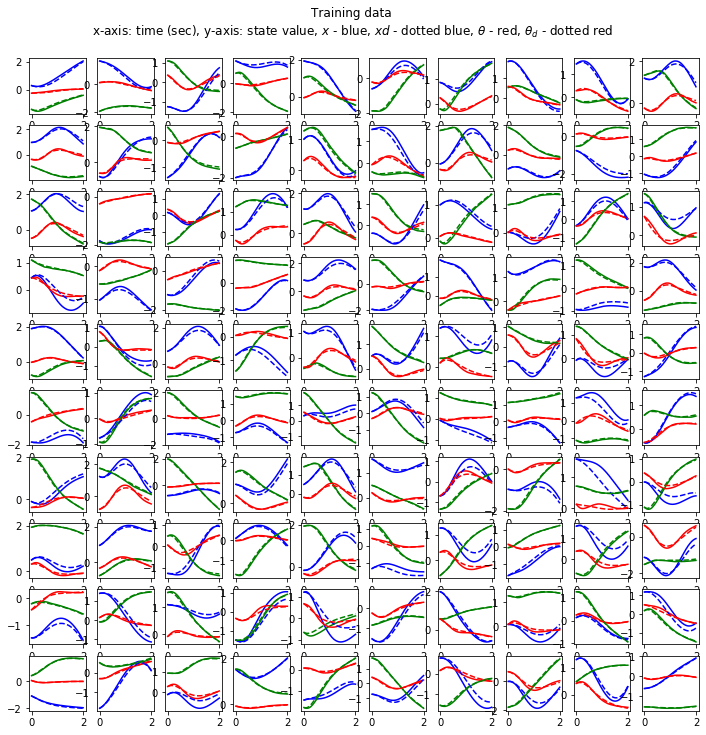

In [4]:
xd = np.empty((n_traj_dc, n_pred_dc + 1, n))
xs = np.empty((n_traj_dc, n_pred_dc + 1, n))
us = np.empty((n_traj_dc, n_pred_dc, m))

plt.figure(figsize=(12, 12 * n_traj_dc / (n_cols ** 2)))
for ii in range(n_traj_dc):
    x0 = np.asarray([rand.uniform(l, u) for l, u in zip(-x0_max, x0_max)])
    set_pt_dc = np.asarray([rand.uniform(l, u) for l, u in zip(-x0_max, x0_max)])
    mpc_trajgen = MPCController(nominal_sys, n_pred_dc, dt, umin, umax, xmin, xmax, QN_trajgen, R_trajgen,
                                QN_trajgen, set_pt_dc)
    mpc_trajgen.eval(x0, 0)
    xd[ii, :, :] = mpc_trajgen.parse_result().T
    while abs(x0[0]) + abs(x0[1]) < 1 or np.any(np.isnan(xd[ii, :, :])):
        x0 = np.asarray([rand.uniform(l, u) for l, u in zip(-x0_max, x0_max)])
        set_pt_dc = np.asarray([rand.uniform(l, u) for l, u in zip(-x0_max, x0_max)])
        mpc_trajgen = MPCController(nominal_sys, n_pred_dc, dt, umin, umax, xmin, xmax, QN_trajgen, R_trajgen,
                                    QN_trajgen, set_pt_dc)
        mpc_trajgen.eval(x0, 0)
        xd[ii, :, :] = mpc_trajgen.parse_result().T

    output = QuadrotorPdOutput(quadrotor, xd[ii, :, :], t_eval, n, m)
    pd_controller = PDController(output, K_dc_p, K_dc_d)
    perturbed_pd_controller = PerturbedController(quadrotor, pd_controller, noise_var, const_offset=hover_thrust)
    xs[ii, :, :], us[ii, :, :] = quadrotor.simulate(x0, perturbed_pd_controller, t_eval)

    plt.subplot(int(np.ceil(n_traj_dc / n_cols)), n_cols, ii + 1)
    plt.plot(t_eval, xs[ii, :, 0], 'b', label='$y$')
    plt.plot(t_eval, xs[ii, :, 1], 'g', label='$z$')
    plt.plot(t_eval, xs[ii, :, 2], 'r', label='$\\theta$')
    plt.plot(t_eval, xd[ii, :, 0], '--b', label='$y_d$')
    plt.plot(t_eval, xd[ii, :, 1], '--g', label='$z_d$')
    plt.plot(t_eval, xd[ii, :, 2], '--r', label='$\\theta_d$')

plt.suptitle(
    'Training data \nx-axis: time (sec), y-axis: state value, $x$ - blue, $xd$ - dotted blue, $\\theta$ - red, $\\theta_d$ - dotted red',
    y=0.94)
plt.show()

### Learn a linear model with dynamic mode decomposition (DMD)

To compare our method with existing techniques, we first learn a linear state space model from data. This is dubbed
dynamic mode decomposition. I.e. we use linear regression with LASSO regularization to learn an approximate linear model
with model structure

\begin{equation}
    \mathbf{\dot{x}} = A_{dmd}\mathbf{x} + B_{dmd}\mathbf{u}
\end{equation}

In [5]:
#DMD parameters:
alpha_dmd = 9.8e-5                                                  # Regularization strength (LASSO) DMD
tune_mdl_dmd = False

In [6]:
basis = lambda x: x
C_dmd = np.eye(n)

optimizer_dmd = linear_model.MultiTaskLasso(alpha=alpha_dmd, fit_intercept=False, selection='random')
cv_dmd = linear_model.MultiTaskLassoCV(fit_intercept=False, n_jobs=-1, cv=3, selection='random')
standardizer_dmd = preprocessing.StandardScaler(with_mean=False)

model_dmd = Edmd(n, m, basis, n, n_traj_dc, optimizer_dmd, cv=cv_dmd, standardizer=standardizer_dmd, C=C_dmd, first_obs_const=False, continuous_mdl=False, dt=dt)
xdmd, y_dmd = model_dmd.process(xs, us-hover_thrust, np.tile(t_eval,(n_traj_dc,1)), downsample_rate=sub_sample_rate)
model_dmd.fit(xdmd, y_dmd, cv=tune_mdl_dmd, override_kinematics=True)
sys_dmd = LinearLiftedDynamics(model_dmd.A, model_dmd.B, model_dmd.C, model_dmd.basis, continuous_mdl=False, dt=dt)
if tune_mdl_dmd:
    print('$\\alpha$ DMD: ',model_dmd.cv.alpha_)

### Learn a lifted linear model with extended dynamic mode decomposition (EDMD)

In addition, we compare our method with the current state of the art of Koopman based learning, the extended dynamic mode
decomposition. We use a dictionary of nonlinear functions $\boldsymbol{\phi(x)}$ to lift the state variables and learn a lifted state space model
of the dynamics. I.e. we first lift and then use linear regression with LASSO regularization to learn an approximate
lifted linear model with model structure

\begin{equation}
    \mathbf{\dot{z}} = A_{edmd}\mathbf{z} + B_{edmd}\mathbf{u}, \qquad \mathbf{z} = \boldsymbol{\phi(x)}
\end{equation}

In [7]:
#EDMD parameters:
alpha_edmd = 2.22e-4                                                 # Regularization strength (LASSO) EDMD
tune_mdl_edmd = False

In [8]:
basis = PlanarQuadBasis(n, poly_deg=3)
basis.construct_basis()
planar_quad_features = preprocessing.FunctionTransformer(basis.basis)
planar_quad_features.fit(np.zeros((1,n)))
n_lift_edmd = planar_quad_features.transform((np.zeros((1,n)))).shape[1]
C_edmd = np.zeros((n,n_lift_edmd))
C_edmd[:,1:n+1] = np.eye(n)

optimizer_edmd = linear_model.MultiTaskLasso(alpha=alpha_edmd, fit_intercept=False, selection='random', max_iter=2000)
cv_edmd = linear_model.MultiTaskLassoCV(fit_intercept=False, n_jobs=-1, cv=3, selection='random', max_iter=2000)
standardizer_edmd = preprocessing.StandardScaler(with_mean=False)

model_edmd = Edmd(n, m, basis.basis, n_lift_edmd, n_traj_dc, optimizer_edmd, cv=cv_edmd, standardizer=standardizer_edmd, C=C_edmd, continuous_mdl=False, dt=dt)
X_edmd, y_edmd = model_edmd.process(xs, us-hover_thrust, np.tile(t_eval,(n_traj_dc,1)), downsample_rate=sub_sample_rate)
model_edmd.fit(X_edmd, y_edmd, cv=tune_mdl_edmd, override_kinematics=True)
model_edmd.reduce_mdl()
sys_edmd = LinearLiftedDynamics(model_edmd.A, model_edmd.B, model_edmd.C, model_edmd.basis_reduced, continuous_mdl=False, dt=dt)
if tune_mdl_edmd:
    print('$\\alpha$ EDMD: ',model_edmd.cv.alpha_)


### Learn a lifted bilinear model with bilinear extended mode decomposition (bEDMD)

Finally, we use the method developed in the paper to learn a lifted bilinear model of the dynamics, dubbed bilinear
extended mode decomposition (bEDMD). I.e. we first lift and then use linear regression with LASSO regularization to learn an approximate
lifted linear model with model structure

\begin{equation}
    \mathbf{\dot{z}}=F\mathbf{z}+\sum_{i=1}^m G_i\mathbf{z}\mathbf{u}_i, \qquad \mathbf{z} = \boldsymbol{\phi(x)}
\end{equation}

In [9]:
#Bilinear EDMD parameters:                                           
alpha_bedmd = 6.9e-5  # Regularization strength (LASSO) bEDMD
tune_mdl_bedmd = False

In [10]:
n_lift_bedmd = n_lift_edmd
C_bedmd = np.zeros((n,n_lift_bedmd))
C_bedmd[:,1:n+1] = np.eye(n)

basis_bedmd = lambda x: planar_quad_features.transform(x)
optimizer_bedmd = linear_model.MultiTaskLasso(alpha=alpha_bedmd, fit_intercept=False, selection='random')
cv_bedmd = linear_model.MultiTaskLassoCV(fit_intercept=False, n_jobs=-1, cv=3, selection='random')
standardizer_bedmd = preprocessing.StandardScaler(with_mean=False)

model_bedmd = BilinearEdmd(n, m, basis_bedmd, n_lift_bedmd, n_traj_dc, optimizer_bedmd, cv=cv_bedmd, standardizer=standardizer_bedmd, C=C_bedmd, continuous_mdl=False, dt=dt)
X_bedmd, y_bedmd = model_bedmd.process(xs, us-hover_thrust, np.tile(t_eval,(n_traj_dc,1)), downsample_rate=sub_sample_rate)
model_bedmd.fit(X_bedmd, y_bedmd, cv=tune_mdl_bedmd, override_kinematics=True)
sys_bedmd = BilinearLiftedDynamics(model_bedmd.n_lift, m, model_bedmd.A, model_bedmd.B, model_bedmd.C, model_bedmd.basis, continuous_mdl=False, dt=dt)
if tune_mdl_bedmd:
    print('$\\alpha$ bilinear EDMD: ', model_bedmd.cv.alpha_)
    

### Evaluate open loop prediction performance

We first evaluate the open loop prediction performance of the proposed method.
This is done by generating a new data set in the same way as the training set, predicting the evolution of the system
with the control sequence of each trajectory executed in the data set with each of the models, and finally comparing
the mean and standard deviation of the error between the true and predicted evolution over the trajectories. The
experimental results support what is to be expected from the theory as the error in the $y$ and $z$ terms are
significantly lower for the bEDMD method than both DMD and EDMD. The reason for this
improvement is that the bEDMD method can capture the nonlinearities present in the actuation matrix of the
$(y,z)$-dynamics.

In [11]:
# Prediction performance evaluation parameters:
folder_plots = 'examples/figures/'                                  # Path to save plots
n_traj_ol = 100                                                     # Number of trajectories to execute, open loop

In [12]:
from tabulate import tabulate

xs_ol = np.empty((n_traj_ol, t_eval.shape[0], n))
xs_dmd_ol = np.empty((n_traj_ol, t_eval.shape[0]-1, n))
xs_edmd_ol = np.empty((n_traj_ol, t_eval.shape[0]-1, n))
xs_bedmd_ol = np.empty((n_traj_ol, t_eval.shape[0]-1, n))
us_test = np.empty((n_traj_ol, t_eval.shape[0]-1, m))

for ii in range(n_traj_ol):
    x0 = np.asarray([rand.uniform(l, u) for l, u in zip(-x0_max, x0_max)])
    set_pt_dc = np.asarray([rand.uniform(l, u) for l, u in zip(-x0_max, x0_max)])
    mpc_trajgen = MPCController(nominal_sys, n_pred_dc, dt, umin, umax, xmin, xmax, QN_trajgen, R_trajgen,
                                QN_trajgen, set_pt_dc)
    mpc_trajgen.eval(x0, 0)
    xd = mpc_trajgen.parse_result().T

    while xd[0,0] is None:
        x0 = np.asarray([rand.uniform(l, u) for l, u in zip(-x0_max, x0_max)])
        set_pt_dc = np.asarray([rand.uniform(l, u) for l, u in zip(-x0_max, x0_max)])
        mpc_trajgen = MPCController(nominal_sys, n_pred_dc, dt, umin, umax, xmin, xmax, QN_trajgen, R_trajgen,
                                    QN_trajgen, set_pt_dc)
        mpc_trajgen.eval(x0, 0)
        xd = mpc_trajgen.parse_result().T

    output = QuadrotorPdOutput(quadrotor, xd, t_eval, n, m)
    pd_controller = PDController(output, K_dc_p, K_dc_d)
    perturbed_pd_controller = PerturbedController(quadrotor, pd_controller, noise_var, const_offset=hover_thrust)

    xs_ol[ii,:,:], us_test[ii,:,:] = quadrotor.simulate(x0, perturbed_pd_controller, t_eval)
    ol_controller_nom = OpenLoopController(sys_bedmd, us_test[ii,:,:]-hover_thrust, t_eval[:-1])

    xs_dmd_ol[ii,:,:], _ = sys_dmd.simulate(x0, ol_controller_nom, t_eval[:-1])

    z_0_edmd = sys_edmd.basis(np.atleast_2d(x0)).squeeze()
    zs_edmd_tmp, _ = sys_edmd.simulate(z_0_edmd, ol_controller_nom, t_eval[:-1])
    xs_edmd_ol[ii,:,:] = np.dot(model_edmd.C, zs_edmd_tmp.T).T

    z_0_bedmd = sys_bedmd.basis(np.atleast_2d(x0)).squeeze()
    zs_bedmd_tmp, _ = sys_bedmd.simulate(z_0_bedmd, ol_controller_nom, t_eval[:-1])
    xs_bedmd_ol[ii,:,:] = np.dot(model_bedmd.C, zs_bedmd_tmp.T).T

error_dmd = xs_ol[:,:-1,:] - xs_dmd_ol
error_dmd_mean = np.mean(error_dmd, axis=0).T
error_dmd_std = np.std(error_dmd, axis=0).T
mse_dmd = np.mean(np.square(error_dmd))
std_dmd = np.std(error_dmd)

error_edmd = xs_ol[:,:-1,:] - xs_edmd_ol
error_edmd_mean = np.mean(error_edmd, axis=0).T
error_edmd_std = np.std(error_edmd, axis=0).T
mse_edmd = np.mean(np.square(error_edmd))
std_edmd = np.std(error_edmd)

error_bedmd = xs_ol[:,:-1,:] - xs_bedmd_ol
error_bedmd_mean = np.mean(error_bedmd, axis=0).T
error_bedmd_std = np.std(error_bedmd, axis=0).T
mse_bedmd = np.mean(np.square(error_bedmd))
std_bedmd = np.std(error_bedmd)

print('\nOpen loop performance statistics:\n')
print(tabulate([['DMD', "{:.5f}".format(mse_dmd), '-', '-', "{:.5f}".format(std_dmd), '-', '-'],
               ['EDMD', "{:.5f}".format(mse_edmd), "{:.2f}".format((1 - mse_edmd / mse_dmd) * 100)+' %', '-', "{:.5f}".format(std_edmd), "{:.2f}".format((1 - std_edmd / std_dmd) * 100)+' %', '-'],
               ['bEDMD', "{:.5f}".format(mse_bedmd), "{:.2f}".format((1 - mse_bedmd / mse_dmd) * 100)+' %', "{:.2f}".format((1 - mse_bedmd / mse_edmd) * 100)+' %', "{:.5f}".format(std_bedmd), "{:.2f}".format((1 - std_bedmd / std_dmd) * 100)+' %', "{:.2f}".format((1 - std_bedmd / std_edmd) * 100)+' %']], 
               headers=['MSE', 'MSE improvement\nover DMD', 'MSE improvement\nover EDMD', 'Standard\ndeviation', 'std improvement\nover DMD', 'std improvement\nover EDMD']))

[ 1.02089912  1.03110285 -0.20650972  0.9703993  -1.01820033 -0.09934785]
[ 1.03069614  1.0208737  -0.20741767  0.9890181  -1.02763312 -0.08224146]
[ 1.04073256  1.0108008  -0.20831325  1.01828718 -0.98695078 -0.09687355]
[ 1.05100094  1.0008447  -0.20916029  1.03539995 -1.00427048 -0.07253599]
[ 1.06143573  0.99069168 -0.20979358  1.05156593 -1.02633527 -0.05412177]
[ 1.0720851   0.98056522 -0.21033579  1.07831847 -0.99896013 -0.05432077]
[ 1.08302819  0.97083352 -0.21075963  1.11031014 -0.94738166 -0.03044668]
[ 1.09424687  0.96140925 -0.21089604  1.1334281  -0.93747264  0.00316574]
[ 1.10565316  0.95188045 -0.21073462  1.14782849 -0.96828661  0.029117  ]
[ 1.11723551  0.94219392 -0.21020256  1.1686335  -0.96901877  0.07729636]
[ 1.12899647  0.93236347 -0.20931319  1.18354771 -0.99706929  0.10057714]
[ 1.14094839  0.92245143 -0.20806324  1.20681238 -0.98533389  0.14941357]
[ 1.15308119  0.91241478 -0.20633494  1.219731   -1.02199177  0.19624452]
[ 1.16536819  0.90213436 -0.20404678  

[ 1.64936311  0.3709131   0.31411656 -1.82742143 -0.05097512 -0.99547053]
[ 1.63093331  0.37039727  0.30410294 -1.8583785  -0.05213949 -1.00725326]
[ 1.61221123  0.36983122  0.29414458 -1.88588891 -0.06102298 -0.98441854]
[ 1.59322399  0.36915926  0.28432282 -1.91141921 -0.07332829 -0.97993245]
[ 1.57396963  0.368421    0.27440715 -1.93929066 -0.07427728 -1.00320323]
[ 1.55441916  0.36775471  0.26438002 -1.97061443 -0.05892831 -1.00222103]
[ 1.53456077  0.36724482  0.254412   -2.0008737  -0.04299956 -0.99138307]
[ 1.51444103  0.36675704  0.24457433 -2.02293331 -0.05451952 -0.97615155]
[ 1.49410773  0.36614381  0.23474076 -2.04358849 -0.06809412 -0.99056299]
[ 1.47358808  0.3653278   0.22486556 -2.06022403 -0.0950809  -0.98447691]
[ 1.45287868  0.36436217  0.21498985 -2.08149968 -0.09800866 -0.9906646 ]
[ 1.43192225  0.36354971  0.20500627 -2.1095658  -0.06443795 -1.0060512 ]
[ 1.41073724  0.36285192  0.19494754 -2.12729019 -0.07509028 -1.00569551]
[ 1.38936433  0.36212614  0.18478302 -

[ 1.91640705  1.35712767  0.43429434 -0.70872552  1.23086197 -0.1880863 ]
[ 1.90914844  1.36931584  0.43234275 -0.74297272  1.20678469 -0.20223301]
[ 1.90158694  1.38117927  0.43017051 -0.7693066   1.16591072 -0.23221489]
[ 1.89376208  1.39263575  0.42755332 -0.79564009  1.12539496 -0.29122337]
[ 1.88562255  1.40380218  0.42443629 -0.83222516  1.10791017 -0.33218094]
[ 1.87705805  1.41492843  0.4210712  -0.88061445  1.11736865 -0.34083692]
[ 1.86804578  1.42607329  0.41749624 -0.92178304  1.11162729 -0.37415604]
[ 1.85864602  1.43711063  0.4136008  -0.95811579  1.09586322 -0.4049314 ]
[ 1.84883476  1.44810496  0.40950326 -1.00406542  1.10303465 -0.41457756]
[ 1.83862045  1.45904641  0.40535621 -1.03874035  1.08527898 -0.41483227]
[ 1.82811766  1.4696786   0.40126215 -1.06178037  1.04117622 -0.40398018]
[ 1.81720452  1.48029863  0.39707718 -1.12075113  1.08286928 -0.43301335]
[ 1.80586085  1.49096287  0.39246677 -1.14793319  1.05000115 -0.48906839]
[ 1.79413049  1.50158163  0.38757062 -

[-0.51581989 -0.12625545 -0.16673179 -1.93692763 -1.0026448  -0.65030031]
[-0.53506476 -0.13604271 -0.17312242 -1.91188914 -0.95483372 -0.62782499]
[-0.55410715 -0.14564947 -0.17943558 -1.89649953 -0.96653443 -0.63480805]
[-0.57291779 -0.1549645  -0.18582558 -1.86544912 -0.89650474 -0.6431906 ]
[-0.59142472 -0.16364411 -0.19205057 -1.83577479 -0.83944857 -0.60180753]
[-0.60963397 -0.17177355 -0.19808021 -1.80592505 -0.78646856 -0.60412152]
[-0.6275589  -0.1794664  -0.20411395 -1.77892674 -0.752129   -0.60262666]
[-0.64523171 -0.18692117 -0.21003038 -1.75552503 -0.7388467  -0.58065841]
[-0.66266645 -0.19424012 -0.21572918 -1.73131784 -0.7249664  -0.55910118]
[-0.67976766 -0.20102149 -0.22127064 -1.68874598 -0.63134748 -0.54919184]
[-0.69651878 -0.20722457 -0.22679993 -1.66136865 -0.60929442 -0.55666526]
[-0.71301162 -0.2132887  -0.23229715 -1.63710315 -0.60355345 -0.54277859]
[-0.72926257 -0.2193112  -0.23769365 -1.61299678 -0.60096876 -0.53652278]
[-0.74529926 -0.22542938 -0.24309038 -

[-0.10498791 -0.26263755 -0.41024698  0.67012795 -2.02887576  0.3695838 ]
[-0.09793751 -0.28261132 -0.40642141  0.73984967 -1.96583572  0.3955318 ]
[-0.09018054 -0.30192415 -0.40223174  0.81142651 -1.89668011  0.44240082]
[-0.08178766 -0.3207238  -0.39761905  0.86704849 -1.86320591  0.48013792]
[-0.07289313 -0.33931047 -0.39266555  0.91176839 -1.85409187  0.51056122]
[-0.06357407 -0.35785333 -0.38756477  0.95196047 -1.85444577  0.50959479]
[-0.05388057 -0.37646019 -0.38239892  0.98666696 -1.8668961   0.52357594]
[-0.04379579 -0.39507458 -0.37703433  1.03019129 -1.85594238  0.54934124]
[-0.03328883 -0.41360388 -0.37151347  1.0711055  -1.84988024  0.55483058]
[-0.02239809 -0.43212942 -0.3657788   1.1069531  -1.85519305  0.59210398]
[-0.01111516 -0.45061136 -0.35972438  1.14951871 -1.84115227  0.61877983]
[ 5.64363031e-04 -4.69020130e-01 -3.53482820e-01  1.18628398e+00
 -1.84056426e+00  6.29532605e-01]
[ 0.01260433 -0.48743311 -0.34723534  1.22160962 -1.84199463  0.61996395]
[ 0.02504952 

[-0.10461187  0.30548405  0.34387008  0.4234982  -0.10413816 -0.3460848 ]
[-0.10054319  0.30441827  0.34032663  0.39029346 -0.10899656 -0.36260628]
[-0.09674515  0.3031352   0.33656105  0.36935191 -0.14760572 -0.3905101 ]
[-0.09321396  0.30163461  0.33241333  0.33695034 -0.15248836 -0.43903306]
[-0.09004018  0.30018886  0.32805432  0.29788878 -0.13663327 -0.43277006]
[-0.08710654  0.29846562  0.32354976  0.28885959 -0.20800973 -0.46814002]
[-0.08447576  0.2966679   0.31882164  0.23741657 -0.15149363 -0.47748525]
[-0.08230621  0.2952857   0.31399067  0.19659422 -0.12491324 -0.48870826]
[-0.08054859  0.29419115  0.30916308  0.15503307 -0.09396382 -0.47680904]
[-0.07918864  0.29336035  0.30431011  0.11705505 -0.07216426 -0.49378581]
[-0.07819067  0.29270091  0.29932603  0.08263089 -0.05969575 -0.50302936]
[-0.07749056  0.29202486  0.29422309  0.05746111 -0.07549288 -0.51755903]
[-0.07708923  0.29135487  0.28903381  0.02290371 -0.05847428 -0.52029724]
[-7.69729211e-02  2.90661191e-01  2.83

[-1.08134443  1.69383844 -0.08476712  1.3361953   0.21191631  0.3009237 ]
[-1.06796129  1.69571941 -0.08183908  1.34040804  0.16427873  0.2846844 ]
[-1.05449422  1.69764859 -0.07905104  1.35293354  0.22156425  0.27292269]
[-1.04090583  1.70012805 -0.07628883  1.36467591  0.27433236  0.27951981]
[-1.02722475  1.70283534 -0.07354007  1.37149742  0.26712875  0.27023089]
[-1.01345738  1.70573636 -0.07074789  1.38191014  0.31308072  0.28820671]
[-0.99960887  1.70879747 -0.06786667  1.38775252  0.29914261  0.28803739]
[-0.98571969  1.71147226 -0.06493754  1.39006537  0.2358182   0.29778746]
[-0.9717979   1.71367    -0.06199172  1.39426016  0.20373146  0.29137646]
[-0.95781423  1.715889   -0.05910374  1.40240961  0.24007192  0.2862194 ]
[-0.94375316  1.71843439 -0.05620674  1.40974293  0.26901073  0.29318046]
[-0.92962206  1.72124293 -0.05335556  1.41641973  0.29270011  0.27705631]
[-0.91542625  1.72428181 -0.05057806  1.42268635  0.31507782  0.27844371]
[-0.9011805   1.7273222  -0.04771847  

[ 0.90410396  1.05331989  0.2548947   1.58211344 -0.18961848  0.33204368]
[ 0.91977512  1.0515062   0.25820229  1.55205515 -0.17313715  0.32947403]
[ 0.93516561  1.04977468  0.26131894  1.52599209 -0.17318088  0.29385571]
[ 0.95039481  1.04766679  0.2642988   1.51983627 -0.24839886  0.30211654]
[ 0.96547552  1.04512536  0.26716852  1.49626406 -0.25989919  0.27182842]
[ 0.98035117  1.0423526   0.26974942  1.47883766 -0.29465912  0.24435118]
[ 0.99488771  1.03982346  0.27217403  1.42839841 -0.21119053  0.24057014]
[ 1.0090046   1.03781795  0.27450687  1.39493178 -0.18992494  0.225998  ]
[ 1.0228529   1.03578586  0.27678532  1.37470154 -0.21650029  0.22969261]
[ 1.03639186  1.03386062  0.27904731  1.33303635 -0.16856344  0.22270587]
[ 1.04958696  1.03215528  0.2812299   1.30594817 -0.17251325  0.21381234]
[ 1.06246476  1.03056685  0.28342507  1.26956611 -0.14518628  0.22522096]
[ 1.07503673  1.02904799  0.28563495  1.2447964  -0.15859569  0.21675561]
[ 1.08730397  1.02758535  0.28766455  

[-1.24046843 -0.21423062  0.19233376  0.42421562  0.29987055  0.14690508]
[-1.2362895  -0.21139861  0.19392266  0.41155256  0.26652835  0.17087504]
[-1.23225705 -0.2088021   0.19568113  0.39491275  0.25276793  0.18082022]
[-1.22842639 -0.20616915  0.19747004  0.3711844   0.27381563  0.176961  ]
[-1.22475656 -0.20371214  0.19921122  0.36276942  0.21758369  0.17127464]
[-1.22124659 -0.20144534  0.20081895  0.33919315  0.23576961  0.15027209]
[-1.21800497 -0.19884165  0.20233382  0.3090944   0.28496009  0.15270187]
[-1.21502686 -0.19593391  0.20386483  0.28649813  0.2965837   0.15349921]
[-1.21224857 -0.19304031  0.20538433  0.26913851  0.28213168  0.15040217]
[-1.20965888 -0.19022255  0.20683634  0.24877663  0.28141572  0.13999956]
[-1.2072711  -0.18742349  0.20819775  0.22875827  0.27839007  0.13228285]
[-1.20512645 -0.184455    0.20954439  0.20014129  0.31530231  0.1370451 ]
[-1.20318825 -0.1814959   0.21090369  0.18748525  0.27651492  0.13481418]
[-1.20142387 -0.17870641  0.21233043  

[ 0.64043254  0.27335111  0.0261414  -2.05001981 -0.16837158 -0.64803392]
[ 0.61992285  0.27157248  0.01963746 -2.05183141 -0.18735329 -0.65275309]
[ 0.59939535  0.26973502  0.01305548 -2.05355408 -0.18013674 -0.66364293]
[ 0.57885529  0.267859    0.0065201  -2.05436676 -0.19506562 -0.64343412]
[ 5.58310095e-01  2.65766905e-01  8.54056260e-05 -2.05459734e+00
 -2.23353843e-01 -6.43503755e-01]
[ 0.53776548  0.26369937 -0.0064217  -2.05418294 -0.19015401 -0.65791806]
[ 0.51722795  0.2618062  -0.01298159 -2.05321462 -0.18848045 -0.65406012]
[ 0.49669896  0.2596394  -0.01951575 -2.05253695 -0.24488056 -0.65277074]
[ 0.47618393  0.25717612 -0.02612867 -2.05036519 -0.24777812 -0.66981321]
[ 0.45568777  0.25447195 -0.03274543 -2.04880912 -0.2930566  -0.65354012]
[ 0.43522721  0.25183884 -0.03930286 -2.0431304  -0.23357229 -0.65794405]
[ 0.4148262   0.2497424  -0.04587804 -2.03691043 -0.18572167 -0.65709305]
[ 0.39448225  0.24791756 -0.05239067 -2.03176732 -0.17925217 -0.64543273]
[ 0.3741929  

[ 1.77402624 -0.11925667  0.48524276 -1.08711662 -0.70226494 -0.60691495]
[ 1.76288779 -0.12626038  0.47892729 -1.14046471 -0.69842258 -0.65617917]
[ 1.75116414 -0.13311738  0.4721133  -1.20412617 -0.6729041  -0.70661978]
[ 1.73882379 -0.13974773  0.4648663  -1.26380149 -0.65309322 -0.74278059]
[ 1.72599337 -0.1463831   0.45718288 -1.30218285 -0.67393274 -0.79390278]
[ 1.71272794 -0.15311439  0.44910318 -1.35076929 -0.67225905 -0.82203793]
[ 1.69901092 -0.15989006  0.44070042 -1.39251085 -0.68281749 -0.858514  ]
[ 1.68482039 -0.16664173  0.43200513 -1.44543188 -0.66743947 -0.88054396]
[ 1.67020451 -0.17345348  0.42316185 -1.47764008 -0.69486205 -0.88811174]
[ 1.65507924 -0.18011174  0.4140999  -1.54717807 -0.6366855  -0.92427889]
[ 1.63935401 -0.18638755  0.40472627 -1.59768595 -0.61839703 -0.9504471 ]
[ 1.62312048 -0.19245754  0.39511132 -1.64882502 -0.59552058 -0.97254269]
[ 1.6064404  -0.198439    0.38523128 -1.68703875 -0.60070762 -1.00346498]
[ 1.5893499  -0.20438843  0.3749934  -

[ 0.76450324 -0.76186186  0.00502259  0.96293518  2.12700083  0.2244029 ]
[ 0.77413016 -0.74066216  0.00735752  0.96241625  2.11293783  0.24258443]
[ 0.78375205 -0.71974531  0.00974375  0.9619405   2.07043246  0.23466125]
[ 0.79336691 -0.69909963  0.0121311   0.96099637  2.05870407  0.24280728]
[ 0.80297057 -0.67851546  0.01451348  0.95969629  2.05812957  0.23367028]
[ 0.81255629 -0.65768938  0.01680906  0.95739202  2.10708492  0.22544435]
[ 0.82211945 -0.63649735  0.0192036   0.95519184  2.13131912  0.25346482]
[ 0.83165903 -0.61505916  0.02177855  0.95266988  2.15631841  0.26152531]
[ 0.84117582 -0.59354878  0.02426518  0.95065236  2.14575626  0.23580059]
[ 0.85066833 -0.57202233  0.02657937  0.94780677  2.15953304  0.22703627]
[ 0.86013197 -0.55038979  0.02879565  0.94488291  2.1669737   0.21621944]
[ 0.86955483 -0.52833091  0.03098487  0.93962366  2.24479992  0.22162554]
[ 0.87894291 -0.50611656  0.03314762  0.93797536  2.19807094  0.21092498]
[ 0.88830744 -0.48417655  0.03520932  

[ 0.22505543  1.38505255 -0.39822216 -0.67444501 -0.44351335 -0.95136692]
[ 0.21854374  1.3806753  -0.40775116 -0.62771955 -0.43201026 -0.95443337]
[ 0.21245183  1.37628992 -0.4173281  -0.59052599 -0.44512506 -0.96095341]
[ 0.20677777  1.37186517 -0.42685505 -0.54412214 -0.43989875 -0.94443603]
[ 0.2015154   1.36736567 -0.43623572 -0.50822936 -0.46005665 -0.93169782]
[ 0.19673077  1.36290797 -0.4455106  -0.44850138 -0.43157577 -0.92327904]
[ 0.19239946  1.35842108 -0.45454441 -0.41766544 -0.4658504  -0.883484  ]
[ 0.18843077  1.3536945  -0.46334596 -0.37594763 -0.47952577 -0.87682478]
[ 0.18490005  1.34886332 -0.47180204 -0.33006929 -0.4867745  -0.81439189]
[ 0.18200494  1.34429478 -0.47966374 -0.2487443  -0.42704119 -0.75794839]
[ 0.17969383  1.33987079 -0.48703143 -0.21339519 -0.45779907 -0.71558949]
[ 0.17771058  1.33508523 -0.49414645 -0.18318876 -0.49934899 -0.70741393]
[ 0.17606697  1.3299488  -0.5010142  -0.14545272 -0.5279803  -0.66613601]
[ 0.17501234  1.32490495 -0.50752995 -

[ 1.23012798 -0.65243088  0.23071836 -2.45167554 -0.52942563 -0.19210119]
[ 1.20545651 -0.65755515  0.2288906  -2.48257825 -0.49541805 -0.17345069]
[ 1.18044352 -0.66219423  0.22726172 -2.51997587 -0.43238835 -0.15232552]
[ 1.15512194 -0.66648063  0.22578187 -2.54431417 -0.42488536 -0.14364386]
[ 1.12952322 -0.67054122  0.22446303 -2.57540093 -0.38722562 -0.12012551]
[-1.05762052 -0.38128604 -0.65503962 -0.46060326 -0.42077982  0.39222254]
[-1.06184445 -0.38548557 -0.6510654  -0.38424788 -0.41907487  0.40262037]
[-1.0651868  -0.38950855 -0.64701889 -0.28431144 -0.38545414  0.40668253]
[-1.06786649 -0.39363666 -0.64282878 -0.25165672 -0.44014518  0.43133849]
[-1.07005811 -0.39809342 -0.63842247 -0.18673032 -0.45115886  0.4499252 ]
[-1.0715648  -0.40260805 -0.63392514 -0.11468193 -0.45171334  0.44954025]
[-1.07227298 -0.4070171  -0.62926185 -0.02704632 -0.43002728  0.48311812]
[-1.07234619 -0.41153598 -0.62417244  0.01235685 -0.47371537  0.5347629 ]
[-1.07194935 -0.41638276 -0.6187434   

[ 0.42803557 -0.52080293  0.12853847  0.86401428 -0.30673178 -0.0149214 ]
[ 0.43661607 -0.52389922  0.12852628  0.85208617 -0.31252442  0.0124839 ]
[ 0.4451216  -0.52739632  0.12858184  0.84901863 -0.38689631 -0.00137224]
[ 0.45353654 -0.53117379  0.12850064  0.83397223 -0.36859699 -0.01486747]
[ 0.46181386 -0.53486715  0.12844521  0.82149166 -0.37007472  0.00378046]
[ 0.46998371 -0.53870957  0.12861559  0.81247681 -0.3984113   0.03029721]
[ 0.47806836 -0.54287424  0.12897991  0.804449   -0.43452257  0.04256642]
[ 0.48607192 -0.54739473  0.12939525  0.79625849 -0.46957642  0.04050159]
[ 0.49400901 -0.55238532  0.12996364  0.79115597 -0.52854172  0.07317521]
[ 0.50185911 -0.5576919   0.13071756  0.77885192 -0.53277495  0.07760907]
[ 0.50964222 -0.56346914  0.1315851   0.77777013 -0.62267297  0.0958995 ]
[ 0.51737782 -0.56986909  0.13280033  0.76933574 -0.65732055  0.14714582]
[ 0.52503394 -0.57665517  0.13438291  0.76187466 -0.69989547  0.16937063]
[ 0.53256584 -0.58350502  0.13616639  

[ 0.17452924 -1.44735982  0.0995389  -1.54929676 -0.53408955 -0.64523561]
[ 0.1589614  -1.45242465  0.09297241 -1.56410432 -0.47885972 -0.66806279]
[ 0.14325564 -1.45699261  0.086273   -1.57688714 -0.43471753 -0.67181887]
[ 0.12745548 -1.46145877  0.07951872 -1.58306161 -0.45850894 -0.6790376 ]
[ 0.11158861 -1.46606598  0.07275532 -1.59020785 -0.46292454 -0.67364115]
[ 0.09564257 -1.4705632   0.06593981 -1.59885815 -0.43650997 -0.68946051]
[ 0.07962875 -1.47502267  0.05895544 -1.60381361 -0.45537834 -0.70741353]
[ 0.0635249  -1.47890679  0.05180915 -1.61668097 -0.32142934 -0.72184586]
[ 0.04732881 -1.48201934  0.04455917 -1.62239373 -0.30107306 -0.7281495 ]
[ 0.03108068 -1.48494707  0.03741066 -1.62709496 -0.28446895 -0.7015515 ]
[ 0.01479556 -1.48787831  0.03028698 -1.62983225 -0.30177459 -0.72318616]
[-1.50802438e-03 -1.49119761e+00  2.29704038e-02 -1.63083935e+00
 -3.62083727e-01 -7.40128239e-01]
[-0.01782499 -1.49489125  0.01569298 -1.6324528  -0.37664339 -0.71535657]
[-0.03415669 

[ 0.60233288 -1.69903806 -0.37116012 -0.05834558 -0.67422358  0.17612054]
[ 0.60194267 -1.70577338 -0.3693626  -0.01972529 -0.67283055  0.18338254]
[ 0.60192688 -1.71252258 -0.36743085  0.01653699 -0.67699622  0.20296688]
[ 0.60228567 -1.71927949 -0.36530454  0.05518513 -0.67437363  0.22229626]
[ 0.60293883 -1.72624826 -0.3629907   0.07542551 -0.71937197  0.2404723 ]
[ 0.60393404 -1.73329653 -0.36055312  0.12356578 -0.69026262  0.24704218]
[ 0.60537824 -1.74013517 -0.35806062  0.16522745 -0.67744701  0.25145909]
[ 0.60737484 -1.74647756 -0.35549866  0.23401452 -0.59100248  0.26093164]
[ 0.60993264 -1.75229026 -0.35281993  0.27749249 -0.57151893  0.27481444]
[ 0.6127919  -1.75826627 -0.35002328  0.29433782 -0.62367496  0.28451698]
[ 0.61584136 -1.76470206 -0.34716456  0.31552746 -0.66347171  0.28722534]
[ 0.61920437 -1.77125142 -0.34426062  0.35701754 -0.64638015  0.29356337]
[ 0.62295979 -1.77768747 -0.34140716  0.39401792 -0.64081241  0.27712784]
[ 0.62700013 -1.78430336 -0.3385045   

[ 1.50757808 -0.09337651 -0.04625456 -0.43602492 -0.7860984  -0.24780068]
[ 1.5032426  -0.1012023  -0.04876431 -0.43102677 -0.77906254 -0.25414946]
[ 1.49895781 -0.10897033 -0.05132111 -0.42588752 -0.77454557 -0.2572113 ]
[ 1.49474247 -0.11637271 -0.05385296 -0.4171114  -0.70593331 -0.24915684]
[ 1.49060898 -0.12323509 -0.05629304 -0.40953066 -0.6665451  -0.23885911]
[ 1.48656375 -0.12951476 -0.05866403 -0.39944588 -0.58939421 -0.23534002]
[ 1.48257578 -0.13579022 -0.06105705 -0.39813966 -0.66569682 -0.24326384]
[ 1.47864698 -0.14208859 -0.06351813 -0.38754949 -0.59398329 -0.24895228]
[ 1.47479093 -0.14821723 -0.06609813 -0.38363455 -0.63174574 -0.26704841]
[ 1.47101032 -0.15419445 -0.06873706 -0.37241568 -0.56370222 -0.26073664]
[ 1.4673433  -0.15950251 -0.07140378 -0.36091488 -0.49791569 -0.2726066 ]
[ 1.4637808  -0.16432829 -0.07416234 -0.35152671 -0.46724555 -0.27910642]
[ 1.46029805 -0.16905899 -0.07695867 -0.34498223 -0.47889704 -0.2801598 ]
[ 1.45687133 -0.17404253 -0.07979913 -

[ 0.54857656 -1.3118671   0.42166757  0.33053647  0.59844662  0.63003563]
[ 0.55165328 -1.30586622  0.42768984  0.28470627  0.60168439  0.57441645]
[ 0.55436567 -1.30004592  0.43333263  0.25771756  0.56234998  0.55414194]
[ 0.55668121 -1.29435012  0.43875759  0.20528861  0.57676289  0.53085061]
[ 0.55861089 -1.2888116   0.44386545  0.18060133  0.53091943  0.49072118]
[ 0.5603445  -1.28384128  0.44851676  0.16609812  0.46313434  0.43954188]
[ 0.56161295 -1.27888774  0.45276362  0.08747701  0.52751648  0.40982936]
[ 0.56215936 -1.27343036  0.4566711   0.02171653  0.56391636  0.37166576]
[ 0.56214841 -1.2678188   0.4601294  -0.02395985  0.55837019  0.31999487]
[ 0.56173074 -1.26236723  0.46306955 -0.05960885  0.53192698  0.26803461]
[ 0.56079639 -1.25686238  0.46541191 -0.12731316  0.56901603  0.2004383 ]
[ 0.55921563 -1.25105114  0.46720907 -0.18887527  0.59321441  0.15899416]
[ 0.55704181 -1.24504509  0.4686232  -0.24591589  0.60798033  0.12383171]
[ 0.55429215 -1.2388825   0.46972318 -

[-0.82450699 -0.11546979 -0.39469532 -0.4066081   0.72902503 -0.83174453]
[-0.82838943 -0.10823264 -0.40315093 -0.36975695  0.71835417 -0.85937713]
[-0.83198527 -0.10130297 -0.41171206 -0.34934478  0.66754975 -0.85284813]
[-0.83526613 -0.09463486 -0.42015011 -0.30669119  0.66601247 -0.83476229]
[-0.83811414 -0.08797888 -0.42849745 -0.26277435  0.66512337 -0.83470623]
[-0.84065591 -0.08163132 -0.43681278 -0.24552832  0.60436496 -0.82835977]
[-0.84280693 -0.0754311  -0.44489046 -0.18450175  0.63559602 -0.78717536]
[-0.84440939 -0.06906027 -0.45263523 -0.135859    0.63850758 -0.7617792 ]
[-0.84551866 -0.06265628 -0.46009654 -0.08586955  0.64222675 -0.73048325]
[-0.84611818 -0.0562047  -0.46735233 -0.03390836  0.64802706 -0.72067523]
[-0.8460951  -0.04950149 -0.47444078  0.03869358  0.69253009 -0.69701467]
[-0.84549723 -0.04265827 -0.48119209  0.08097115  0.67606517 -0.65324742]
[-0.84444479 -0.03592567 -0.48757197  0.12961463  0.67040358 -0.62272707]
[-0.84291386 -0.02927153 -0.49349019  

[ 1.08371726 -0.38921434  0.425398   -0.63323527 -0.87547488 -0.30912226]
[ 1.07719162 -0.39803177  0.42226371 -0.6718489  -0.88799199 -0.31773554]
[ 1.07021617 -0.40682865  0.41907603 -0.72317872 -0.87135727 -0.31980028]
[ 1.06272663 -0.41545244  0.41586339 -0.77466768 -0.85337193 -0.32272823]
[ 1.05475063 -0.42395586  0.41260599 -0.82047519 -0.84728844 -0.32875035]
[ 1.04625078 -0.4322431   0.40942786 -0.87942436 -0.81012781 -0.30687667]
[ 1.03738641 -0.44067283  0.40639779 -0.89343335 -0.87581041 -0.2991378 ]
[ 1.02818102 -0.44928982  0.40325988 -0.94757766 -0.84756025 -0.32844351]
[ 1.01839199 -0.45751947  0.39998715 -1.01014728 -0.79833569 -0.32610173]
[ 1.00804568 -0.46541248  0.39683632 -1.05905382 -0.78024071 -0.30406476]
[ 0.99727036 -0.47326319  0.3938224  -1.0959667  -0.78988283 -0.2987196 ]
[ 0.98602008 -0.48095116  0.39079908 -1.15401905 -0.74768036 -0.30594346]
[ 0.97435329 -0.4886103   0.38776025 -1.17930646 -0.78413519 -0.30182304]
[ 0.9623239  -0.49636184  0.38461111 -

[ 0.05959185  0.23393824 -0.19309306 -1.09517392 -0.64490419 -0.26958026]
[ 0.04871994  0.22740505 -0.19576836 -1.0791714  -0.66174094 -0.26548131]
[ 0.03808534  0.22108584 -0.19827046 -1.04768366 -0.6021146  -0.23493867]
[ 0.02768732  0.21496493 -0.20052712 -1.03189154 -0.6220746  -0.21639355]
[ 0.01743082  0.20855969 -0.20257949 -1.01938602 -0.65897712 -0.19407953]
[ 0.00742503  0.20239202 -0.20456703 -0.98171183 -0.574569   -0.20342855]
[-0.0022722   0.19673172 -0.20655595 -0.95769742 -0.55750002 -0.1943551 ]
[-0.01169316  0.19140839 -0.20846373 -0.92644685 -0.5071742  -0.18720191]
[-0.02090156  0.18611041 -0.2103079  -0.91521623 -0.55242557 -0.18163068]
[-0.02989995  0.18081397 -0.21196773 -0.88442239 -0.50687043 -0.15033709]
[-0.03869321  0.17549101 -0.21346593 -0.8742181  -0.55772514 -0.14930153]
[-0.0473078   0.17001045 -0.21501679 -0.84866863 -0.53839435 -0.16087076]
[-0.05564307  0.16482754 -0.21658102 -0.81835048 -0.49819433 -0.15197443]
[-0.06374192  0.15973894 -0.2180638  -

[ 1.25266557 -0.61889317  0.09437235 -1.14442903  0.32628501 -0.41973854]
[ 1.24117665 -0.61564221  0.09026758 -1.15329021  0.32391154 -0.40121596]
[ 1.22960087 -0.61241281  0.08630986 -1.16180157  0.32197464 -0.39032926]
[ 1.21795396 -0.60934452  0.08242754 -1.16753612  0.29168621 -0.38613468]
[ 1.206254   -0.60661565  0.07862698 -1.1724184   0.25409164 -0.37397711]
[ 1.19447094 -0.60380575  0.07477646 -1.1840955   0.30789661 -0.39612558]
[ 1.18259297 -0.60071434  0.07088635 -1.19143363  0.31038997 -0.3818974 ]
[ 1.17065338 -0.59773877  0.06703645 -1.1964373   0.28472693 -0.38808241]
[ 1.15868665 -0.59534621  0.06322073 -1.19690403  0.19378438 -0.37506197]
[ 1.14668227 -0.59332929  0.05950589 -1.20390266  0.20960451 -0.36790475]
[ 1.13462113 -0.59134476  0.05576234 -1.20827698  0.18730448 -0.38080591]
[ 1.12249825 -0.58922686  0.05196521 -1.21620644  0.2362803  -0.37862035]
[ 1.11032111 -0.58705748  0.04812163 -1.21918297  0.19759825 -0.39009487]
[ 1.09811    -0.58516048  0.0442429  -

[ 0.48029996  1.17604302 -0.0634179  -2.01503507  1.13547069 -0.42000111]
[ 0.46018341  1.18742799 -0.06762504 -2.00820154  1.14151787 -0.42142558]
[ 0.4401083   1.19845252 -0.07179146 -2.00680707  1.06338751 -0.41185986]
[ 0.42007872  1.20912075 -0.07612002 -1.99903385  1.07025201 -0.45385175]
[ 0.40011886  1.21972471 -0.08055155 -1.99287958  1.05053596 -0.43245468]
[ 0.38025633  1.230546   -0.08481158 -1.97951271  1.11371327 -0.41955153]
[ 0.36046054  1.241185   -0.0890074  -1.97964577  1.01408605 -0.41961221]
[ 0.3407033   1.25126802 -0.09319914 -1.97174096  1.00251274 -0.41873507]
[ 0.32102794  1.26124591 -0.09729829 -1.96327053  0.99305952 -0.40109492]
[ 0.30140702  1.270805   -0.10138982 -1.96089891  0.91875692 -0.41721182]
[ 0.28187584  1.2802565  -0.10553204 -1.94523253  0.97153211 -0.41123106]
[ 0.26246239  1.28984364 -0.10961332 -1.93740751  0.94588946 -0.40502594]
[ 0.24311537  1.29905482 -0.11370033 -1.93196369  0.89634436 -0.41237635]
[ 0.22384741  1.30797484 -0.11784364 -

[ 2.06181821 -0.3196388   0.48469364  1.2578333  -1.92088512  1.0025808 ]
[ 2.07417174 -0.33891463  0.49442489  1.21273518 -1.93435504  0.94366896]
[ 2.08595903 -0.35812254  0.50356959  1.14453373 -1.90732953  0.88527063]
[ 2.09720362 -0.37732445  0.51215631  1.10427969 -1.9331101   0.83207302]
[ 2.10810439 -0.39689503  0.52013462  1.07580875 -1.98104373  0.76359032]
[ 2.11862809 -0.41678908  0.52748807  1.02883096 -1.99782457  0.70709855]
[ 2.12870323 -0.43689384  0.53433415  0.98611347 -2.0231758   0.6621187 ]
[ 2.1382896  -0.45715405  0.54066539  0.93106254 -2.02892421  0.60412799]
[ 2.14718145 -0.47723936  0.54656099  0.84717165 -1.98822048  0.5749929 ]
[ 2.15539738 -0.4971934   0.55201365  0.79593895 -2.00263333  0.51553847]
[ 2.16304554 -0.51720679  0.55701543  0.73360849 -2.00009797  0.48481796]
[ 2.17010963 -0.53726306  0.56153091  0.67914378 -2.01119569  0.41827877]
[ 2.17656452 -0.55733216  0.56556205  0.61176318 -2.00267008  0.38794848]
[ 2.18245586 -0.57749383  0.56921505  

[-0.8923476  -1.08725844  0.06602098  0.36129814 -1.38508219 -0.05374253]
[-0.88877249 -1.10102536  0.065465    0.35373428 -1.36830152 -0.05745357]
[-0.88529765 -1.11424251  0.06485462  0.34125209 -1.27512756 -0.06462228]
[-0.88193554 -1.12670572  0.06428929  0.33118539 -1.21751277 -0.04844396]
[-0.8786495  -1.13896926  0.06366909  0.32603144 -1.23519457 -0.0755959 ]
[-0.875441   -1.1509955   0.06280347  0.31569185 -1.17005254 -0.09752905]
[-0.8723225  -1.16257262  0.06199488  0.30802381 -1.14537041 -0.06418756]
[-0.86928058 -1.17389749  0.06139971  0.30037284 -1.11960401 -0.05484602]
[-0.86632226 -1.18484328  0.06090529  0.29130303 -1.06955237 -0.04403828]
[-0.86344007 -1.19552253  0.06056361  0.28514138 -1.06629728 -0.02429872]
[-0.86062954 -1.20600083  0.06029339  0.27697089 -1.02936294 -0.0297445 ]
[-0.85788831 -1.21631228  0.05989679  0.27128121 -1.03292506 -0.04957556]
[-0.85519714 -1.22677022  0.05948305  0.26695779 -1.05866309 -0.03317211]
[-0.85257035 -1.23712745  0.05908617  

[-1.39677676  1.05556922 -0.1353242  -0.21679566  1.65489183  0.22448432]
[-1.39885111  1.07231905 -0.13301408 -0.19812777  1.69508158  0.23754057]
[-1.40080183  1.08900913 -0.13070707 -0.19203335  1.64293611  0.2238618 ]
[-1.40268012  1.10526966 -0.12851986 -0.18364794  1.6091732   0.2135792 ]
[-1.40440994  1.12170102 -0.12618615 -0.16238244  1.67710673  0.25316262]
[-1.40600387  1.13821891 -0.12366587 -0.15642174  1.62647287  0.25089403]
[-1.40752735  1.15432314 -0.12111603 -0.14830224  1.59437827  0.25907348]
[-1.40898398  1.16999478 -0.1185135  -0.14304426  1.53995158  0.26143261]
[-1.41039653  1.18505524 -0.11586606 -0.13947817  1.47214073  0.26805519]
[-1.4117449   1.19968798 -0.11320692 -0.13023252  1.45441226  0.2637742 ]
[-1.41300595  1.21410752 -0.11057971 -0.12200908  1.42950006  0.26166791]
[-1.41417075  1.228414   -0.10801253 -0.11099265  1.43180039  0.25176716]
[-1.41525617  1.2424693  -0.10535839 -0.10611241  1.37926108  0.27906169]
[-1.41626942  1.25622821 -0.10254491 -

[-1.67211223 -0.71851891 -0.30141125 -1.326674   -1.91023484 -0.37620754]
[-1.68522668 -0.73762405 -0.30513589 -1.29615554 -1.91081108 -0.36872005]
[-1.69808206 -0.75688695 -0.30871025 -1.27487874 -1.94178313 -0.34615102]
[-1.71065366 -0.77624186 -0.3120523  -1.23938095 -1.9292188  -0.32226   ]
[-1.72282552 -0.79533895 -0.31506682 -1.19492092 -1.89022137 -0.2806444 ]
[-1.734677   -0.81443277 -0.3178007  -1.17534902 -1.92855063 -0.26613054]
[-1.7461517  -0.83336375 -0.32037541 -1.11951887 -1.85766993 -0.24881108]
[-1.75713584 -0.85179661 -0.32275637 -1.07725868 -1.82891881 -0.22738141]
[-1.76777206 -0.87016954 -0.32491986 -1.04995433 -1.84567718 -0.20531749]
[-1.77807036 -0.88852073 -0.32689034 -1.00966724 -1.82457449 -0.18877849]
[-1.7879109  -0.90650301 -0.32857611 -0.95839776 -1.77189593 -0.14837541]
[-1.79732677 -0.92422018 -0.33000225 -0.92475287 -1.77154465 -0.13685205]
[-1.8064557  -0.94208041 -0.33138314 -0.90101829 -1.80050746 -0.13932607]
[-1.81535478 -0.96025354 -0.33261218 -

[ 0.06116688  0.18090325 -0.02071998  2.11574171  0.10477675  0.86822094]
[ 0.08233629  0.18213392 -0.01196074  2.11794443  0.14136164  0.88362649]
[ 0.10352413  0.18398954 -0.00302288  2.11934486  0.22976466  0.90394561]
[0.12471758 0.18593071 0.00613786 2.11930365 0.15846889 0.92820252]
[0.14590489 0.18764555 0.01533827 2.11796903 0.18449603 0.91187799]
[0.16707362 0.18959628 0.02450703 2.11559391 0.20564695 0.92187525]
[0.1882165  0.19163576 0.03371125 2.1128363  0.20224578 0.9189689 ]
[0.20931793 0.19389934 0.04295966 2.10722597 0.2504598  0.93071271]
[0.23040038 0.19569243 0.05228132 2.10933218 0.10816203 0.9336184 ]
[0.25147982 0.1965339  0.06156907 2.10647864 0.06012856 0.9239316 ]
[0.27250773 0.19721434 0.0708085  2.09892746 0.07594754 0.92395574]
[0.29344503 0.19818574 0.07990447 2.08831883 0.11831541 0.89523827]
[0.31427246 0.19954962 0.08874589 2.07697061 0.15444352 0.87304442]
[0.3349825  0.2012528  0.09746296 2.06484737 0.18617516 0.87037074]
[0.35559626 0.20296882 0.10605

[-1.00508668  0.15545704 -0.42304469 -0.88071978 -2.05964904 -0.00275815]
[-1.01364416  0.13492474 -0.42287744 -0.83077871 -2.04681028  0.03620684]
[-1.02186009  0.11417033 -0.42236733 -0.81241066 -2.1040698   0.06581458]
[-1.02963868  0.09340842 -0.42160431 -0.74332779 -2.0483027   0.08678953]
[-1.03672095  0.07321819 -0.42054624 -0.67315422 -1.98973063  0.12482561]
[-1.04309434  0.05363214 -0.41923395 -0.60155813 -1.92746436  0.13763193]
[-1.04891697  0.03430051 -0.41771412 -0.56299035 -1.93885079  0.16633409]
[-1.05431743  0.01493926 -0.41598282 -0.51713086 -1.9333864   0.17992547]
[-1.05918466 -0.00419558 -0.41397714 -0.45636085 -1.89356266  0.22121106]
[-1.06355092 -0.02317158 -0.41140894 -0.41693031 -1.90161957  0.29242899]
[-1.06746432 -0.04209013 -0.40827828 -0.36581035 -1.88206345  0.33370399]
[-1.07086729 -0.06080965 -0.4048317  -0.31485218 -1.86181109  0.3556119 ]
[-1.07374018 -0.07927291 -0.4012664  -0.2598038  -1.83080885  0.35744804]
[-1.07626147 -0.09788997 -0.39742598 -

[-2.13967227  0.82628349 -0.30831255 -0.31891117  0.18269633  0.10689663]
[-2.1427109   0.82809308 -0.30708475 -0.28883515  0.17922829  0.13866306]
[-2.14544563  0.8298801  -0.30565918 -0.25813318  0.1781823   0.14645057]
[-2.14785571  0.83171508 -0.30412414 -0.22391096  0.18882195  0.16055815]
[-2.14997904  0.83348242 -0.30238059 -0.20077567  0.16465344  0.18815231]
[-2.15182223  0.83516716 -0.30044867 -0.16789781  0.17230535  0.19823197]
[-2.15335766  0.83686419 -0.2982629  -0.13922079  0.16711117  0.23892112]
[-2.15459363  0.83855445 -0.29586121 -0.10801383  0.17095392  0.24141794]
[-2.15556919  0.84011759 -0.29338443 -0.08712715  0.14168109  0.25393674]
[-2.15630956  0.84147851 -0.29084572 -0.06098436  0.1305158   0.25380562]
[-2.15680448  0.84267829 -0.28835543 -0.03803115  0.10944797  0.24425339]
[-2.1570668   0.84368126 -0.28578414 -0.01446784  0.09115658  0.2700043 ]
[-2.15711521  0.84443107 -0.28312307  0.00475827  0.05881489  0.26220885]
[-2.15693636  0.84498138 -0.280416    

[ 0.36731675  0.04071522 -0.02551924 -0.18116791 -2.00346562 -0.05657169]
[ 0.36551224  0.02046873 -0.02615423 -0.17972826 -2.04583233 -0.07042661]
[ 3.63724843e-01 -1.05625731e-04 -2.68196690e-02 -1.77743610e-01
 -2.06903870e+00 -6.26607544e-02]
[ 0.3619612  -0.02077639 -0.0275122  -0.17497244 -2.06511366 -0.07584495]
[ 0.3602331  -0.04113923 -0.02817596 -0.17063193 -2.00745581 -0.05690836]
[ 0.35854167 -0.06117911 -0.02869474 -0.16764355 -2.00052124 -0.04684681]
[ 0.35687551 -0.08131895 -0.02916252 -0.16558398 -2.02744645 -0.04670918]
[ 0.35522764 -0.10181231 -0.02980322 -0.16398352 -2.07122469 -0.08143023]
[ 0.35360463 -0.1224558  -0.03059278 -0.16060441 -2.05747525 -0.07648261]
[ 0.3520096  -0.14316419 -0.0314899  -0.15838973 -2.0842016  -0.10294069]
[ 0.35044801 -0.16379588 -0.03243648 -0.15390615 -2.04213671 -0.08637564]
[ 0.34892398 -0.1842485  -0.03317755 -0.15088993 -2.04838858 -0.0618384 ]
[ 0.34743247 -0.20470257 -0.03394416 -0.14739876 -2.04242594 -0.09148296]
[ 0.34597195 

[1.49736065 0.51932543 0.08554447 0.09302163 1.50104982 0.12142483]
[1.49826134 0.53418803 0.08673686 0.08710452 1.4714681  0.11705273]
[1.49908971 0.54890082 0.08790611 0.07854966 1.47108846 0.1167988 ]
[1.49985623 0.56333558 0.08898702 0.07474702 1.41586283 0.09938198]
[1.50054343 0.57767672 0.08995387 0.0626715  1.45236235 0.09398854]
[1.50110637 0.59241453 0.09083078 0.04989561 1.49519892 0.08139417]
[1.5015658  0.60730872 0.09160084 0.04197939 1.48363669 0.07261757]
[1.50194303 0.62211683 0.09226363 0.03345541 1.47798495 0.05994046]
[1.5022538  0.63666273 0.09276485 0.02869408 1.4311948  0.04030369]
[1.50247845 0.65115293 0.09304351 0.01622957 1.46684383 0.01542669]
[ 1.50263041  0.66544154  0.09299747  0.01416377  1.39087973 -0.02463297]
[ 1.50273746  0.67923103  0.09285065  0.00724666  1.36701694 -0.00473127]
[ 1.50279415  0.6925801   0.09277942  0.00409273  1.30279875 -0.00951451]
[ 1.50281396e+00  7.05344593e-01  9.26285915e-02 -1.28604921e-04
  1.25009923e+00 -2.06520631e-02]

[ 0.4867276  -0.54166792  0.17484173 -1.73512952 -2.05627224 -0.52877183]
[ 0.46930682 -0.56232365  0.16946704 -1.74895562 -2.07486181 -0.54616553]
[ 0.45172521 -0.58301877  0.16393747 -1.76726678 -2.0641452  -0.55974761]
[ 0.43391967 -0.60333799  0.15821489 -1.79368557 -1.99967333 -0.58476937]
[ 0.41590784 -0.62334935  0.15232056 -1.80858607 -2.00258412 -0.59409553]
[ 0.39771111 -0.64313374  0.14631581 -1.83061345 -1.95427297 -0.60685521]
[ 0.37933708 -0.66269962  0.14014585 -1.84409721 -1.95888873 -0.62713782]
[ 0.36082235 -0.68224815  0.13390217 -1.8587386  -1.95080196 -0.62159688]
[ 0.34219232 -0.70192511  0.12771418 -1.86720032 -1.98458096 -0.61600063]
[ 0.32345524 -0.72174621  0.12143763 -1.88010738 -1.97962573 -0.63930981]
[ 0.30458548 -0.74145978  0.11488797 -1.89372141 -1.96307384 -0.67062192]
[ 0.28563126 -0.76143078  0.10824602 -1.8970879  -2.03112163 -0.65776786]
[ 0.26657945 -0.78147219  0.1016578  -1.91310791 -1.97714363 -0.65987761]
[ 0.24739111 -0.80116036  0.09508763 -

[-1.39713871 -1.37934678 -0.46860913 -0.47317778 -0.03425257 -0.07207062]
[-1.40167562 -1.37979505 -0.46910344 -0.43419803 -0.05540498 -0.02679067]
[-1.40586186 -1.38053237 -0.46918904 -0.40304965 -0.09205992  0.0096703 ]
[-1.40965549 -1.38147617 -0.46897671 -0.35567967 -0.09669792  0.03279543]
[-1.41288479 -1.38228705 -0.46846561 -0.29018994 -0.06547292  0.06942568]
[-1.41559513 -1.38305352 -0.46767453 -0.25188954 -0.08781465  0.08878919]
[-1.41776134 -1.38372332 -0.46676501 -0.18137382 -0.04613501  0.09311472]
[-1.4193834  -1.38429445 -0.46566006 -0.14305137 -0.06808455  0.12787586]
[-1.42057153 -1.38498291 -0.46425981 -0.09459644 -0.06959669  0.1521753 ]
[-1.42121161 -1.38555776 -0.46263211 -0.03345441 -0.04535636  0.17336343]
[-1.42136357 -1.38613515 -0.46066541  0.00303945 -0.0701096   0.21997778]
[-1.4211607  -1.38697856 -0.4583836   0.03750796 -0.09855847  0.23638298]
[-1.42055393 -1.38798417 -0.45603212  0.0838086  -0.1025464   0.23391372]
[-1.41939337 -1.38884136 -0.45347207  

[-0.83354362  0.6436474  -0.27867764 -0.87410012  1.26344981 -0.13027654]
[-0.84218853  0.65612671 -0.27994931 -0.85486665  1.23240821 -0.12405725]
[-0.85055662  0.6685874  -0.28120614 -0.81872545  1.25972141 -0.12730949]
[-0.85871922  0.68077932 -0.28246606 -0.81379129  1.17866247 -0.12467408]
[-0.86671146  0.69257662 -0.28365465 -0.78463669  1.18079102 -0.11304342]
[-0.87439467  0.70445287 -0.28490364 -0.75198311  1.19445267 -0.13675575]
[-0.88173851  0.71650681 -0.28627878 -0.71675662  1.21632723 -0.13827123]
[-0.88888223  0.72826046 -0.28768375 -0.71198302  1.13440214 -0.1427241 ]
[-0.89582681  0.73970525 -0.28902338 -0.6769075   1.15454624 -0.12520012]
[-0.90254942  0.75091624 -0.29028541 -0.66760756  1.08765046 -0.12720621]
[-0.90918966  0.76142204 -0.29148772 -0.66043481  1.01350826 -0.11325736]
[-0.91569944  0.77138139 -0.29258034 -0.64150973  0.97835828 -0.10526514]
[-0.9219408   0.78125053 -0.29353054 -0.60674494  0.99546428 -0.08477513]
[-0.92787954  0.79114008 -0.2943608  -

[ 0.08005996  1.14322246 -0.00747698 -1.68254351 -0.44113877 -0.53426136]
[ 0.0632378   1.13867498 -0.0126876  -1.68182728 -0.46835731 -0.50786321]
[ 0.04642616  1.1339631  -0.01760187 -1.68042469 -0.4740192  -0.47498995]
[ 0.02963184  1.12924966 -0.02235583 -1.67835773 -0.46867194 -0.47580115]
[ 0.01286991  1.12497745 -0.02698051 -1.67388786 -0.38577206 -0.44913616]
[-0.00385384  1.12116002 -0.03160773 -1.67077967 -0.37771749 -0.47630766]
[-0.02054664  1.11734394 -0.03635841 -1.66770908 -0.38550123 -0.47382886]
[-0.03719669  1.11371098 -0.04102362 -1.66219083 -0.34109367 -0.45921234]
[-0.05379123  1.11045245 -0.04556767 -1.65661953 -0.31061754 -0.44959839]
[-0.07033068  1.10742373 -0.04995354 -1.65118831 -0.29513014 -0.42757514]
[-0.08681777  1.10446417 -0.0542396  -1.64615948 -0.29678532 -0.42963594]
[-0.10325244  1.10148902 -0.05850558 -1.64070559 -0.29824942 -0.42356107]
[-0.11963201  1.09847417 -0.06265589 -1.63514674 -0.3047239  -0.40650094]
[-0.13595304  1.09541133 -0.06676917 -

[-0.51913586  0.68382345 -0.00493316  2.21613472 -0.13370947  0.79848073]
[-0.49697405  0.68219899  0.00290673  2.2161749  -0.19118356  0.76949671]
[-0.4748147   0.68023481  0.01057477  2.2155838  -0.2016532   0.76411203]
[-0.45266727  0.67836908  0.01820584  2.21373778 -0.17149489  0.76210183]
[-0.43055318  0.67728634  0.02578322  2.2087968  -0.04505951  0.75337488]
[-0.40847776  0.67678864  0.03325369  2.20617749 -0.05448241  0.74071923]
[-0.38642567  0.67602437  0.04064954  2.20417345 -0.09837562  0.73844972]
[-0.3644128   0.67521918  0.04801788  2.19823704 -0.06266852  0.73521803]
[-0.34245945  0.67467703  0.05519668  2.1922936  -0.0457686   0.70054227]
[-0.32056947  0.6743011   0.06214101  2.18557041 -0.02942451  0.68832497]
[-0.29872718  0.6737242   0.06891687  2.18284205 -0.08595959  0.66684645]
[-0.276955    0.67316343  0.07555118  2.17141898 -0.02620747  0.6600158 ]
[-0.25529858  0.67315228  0.08219563  2.15970097  0.0239656   0.6688733 ]
[-0.23374323  0.67339377  0.088845    

[-0.85908028  1.35848032 -0.02481335 -1.12109542 -0.36084433 -0.50110248]
[-0.87027804  1.35487937 -0.02985862 -1.11837276 -0.35934861 -0.50795185]
[-0.88144781  1.35123787 -0.0348597  -1.11550693 -0.36895212 -0.49226325]
[-0.8925859   1.34752286 -0.03978308 -1.11203452 -0.37405411 -0.49241301]
[-0.90369114  1.34365632 -0.0446917  -1.1089535  -0.39925674 -0.48931118]
[-0.91474385  1.33996732 -0.04966457 -1.10145774 -0.33854781 -0.50526347]
[-0.9257204   1.33683169 -0.05457575 -1.09373016 -0.28858444 -0.47697135]
[-0.93662942  1.33395826 -0.05941118 -1.08799283 -0.2861076  -0.49011529]
[-0.94749679  1.33081201 -0.06438693 -1.08544826 -0.34314341 -0.50503385]
[-0.95828808  1.32784509 -0.06943515 -1.0726497  -0.25025267 -0.50461078]
[-0.96897986  1.32533931 -0.07463146 -1.06562079 -0.25090892 -0.53465237]
[-0.97959882  1.32282627 -0.07992014 -1.05808562 -0.25170524 -0.52308333]
[-0.99012461  1.32049174 -0.0850288  -1.04695702 -0.21521084 -0.49864777]
[-1.00054452  1.31842049 -0.09005177 -

[-0.83826677 -0.87803739 -0.04167442 -0.13038525  0.66398725  0.40740419]
[-0.83954991 -0.87137451 -0.03762347 -0.12631141  0.66859121  0.40278594]
[-0.84079524 -0.86468929 -0.0336851  -0.12281854  0.66845558  0.38488835]
[-0.84201028 -0.85809001 -0.02990942 -0.12024158  0.65140291  0.37024661]
[-0.84319777 -0.85154655 -0.0263472  -0.11731825  0.65729015  0.34219792]
[-0.84436451 -0.84520879 -0.02298558 -0.11605874  0.61026242  0.3301255 ]
[-0.84550529 -0.83869201 -0.0197594  -0.1121934   0.69309668  0.31511048]
[-0.84662395 -0.83207686 -0.01664515 -0.11155764  0.62993231  0.30773921]
[-0.84772809 -0.82553465 -0.01345638 -0.1093471   0.67851244  0.33001469]
[-0.84882037 -0.81914401 -0.01019289 -0.10912015  0.59961429  0.32268309]
[-0.8499046  -0.81287505 -0.00705974 -0.10780557  0.65417914  0.30394735]
[-0.8509806  -0.80648371 -0.00409323 -0.10742714  0.6240883   0.28935452]
[-0.85205307 -0.80016131 -0.00123792 -0.10712291  0.64039311  0.28170896]
[-0.85312408 -0.79347208  0.00167192 -

[-1.02838156 -0.19507746 -0.41258346 -0.58144905  2.051751    0.45247562]
[-1.03399476 -0.1745886  -0.4077796  -0.54126325  2.04605289  0.50829724]
[-1.03916864 -0.15406332 -0.40274953 -0.49360586  2.05904177  0.49771651]
[-1.04382727 -0.13330919 -0.39769306 -0.43823066  2.09183085  0.5135766 ]
[-1.04804249 -0.11248171 -0.39243824 -0.40488419  2.07369606  0.53738799]
[-1.05185622 -0.09166428 -0.38693384 -0.35796603  2.08983182  0.56349265]
[-1.05522521 -0.07073666 -0.38129292 -0.31593041  2.09573113  0.56469055]
[-1.05816553 -0.04972064 -0.37564927 -0.27223595  2.10751552  0.56403935]
[-1.06065637 -0.02854567 -0.36992484 -0.22604583  2.12752188  0.58084723]
[-1.06260665 -0.00695643 -0.36405828 -0.16416788  2.19038748  0.59246537]
[-1.06410005  0.01484844 -0.35807145 -0.13458862  2.17061596  0.60489906]
[-1.06537916  0.03624364 -0.35207606 -0.12126977  2.10843723  0.59418078]
[-1.06647057  0.0571697  -0.34608627 -0.09707813  2.07679841  0.6037761 ]
[-1.06722148  0.07806083 -0.33986689 -

[-0.66489641  0.02386535  0.08669699 -0.65478508  0.68028205 -0.46503082]
[-0.67148366  0.03063937  0.08194469 -0.66259178  0.67452705 -0.4854282 ]
[-0.67814347  0.03731503  0.07718462 -0.66930268  0.66061088 -0.46658553]
[-0.68489813  0.0442439   0.0726159  -0.6815062   0.72517174 -0.44715957]
[-0.6917205   0.05110769  0.06807663 -0.68295201  0.64758724 -0.46069426]
[-0.69855599  0.05718262  0.06345233 -0.68413184  0.56740084 -0.46416517]
[-0.70542223  0.06276809  0.05889452 -0.6890549   0.54969586 -0.44739665]
[-0.71233574  0.0681741   0.0544866  -0.69358921  0.53150931 -0.43418814]
[-0.71930666  0.07365846  0.05007516 -0.70049598  0.56536853 -0.44810034]
[-0.72633624  0.07932802  0.0456421  -0.70534595  0.56854759 -0.43851016]
[-0.73341082  0.08500065  0.0412834  -0.70950032  0.5659816  -0.4332301 ]
[-0.74053072  0.09079479  0.0369079  -0.71438939  0.59284896 -0.44186962]
[-0.74768633  0.09656312  0.03248418 -0.71668273  0.56081872 -0.442874  ]
[-0.7548633   0.10200799  0.02798754 -

[-0.71143087 -1.01650406  0.00462176  1.98150544 -0.50416638  0.44009189]
[-0.69161796 -1.02168346  0.00908096  1.98102275 -0.53171485  0.45174978]
[-0.67180812 -1.02745544  0.01364961  1.98094172 -0.62268024  0.46197996]
[-0.65200789 -1.03356764  0.01830683  1.97900865 -0.59976216  0.46946334]
[-0.63223136 -1.03937389  0.02304732  1.97618951 -0.56148961  0.47863416]
[-0.61248554 -1.04482715  0.02781049  1.97287175 -0.5291656   0.47399958]
[-0.59277327 -1.05004967  0.03253956  1.96949316 -0.51533986  0.4718143 ]
[-0.57309956 -1.0550716   0.0371973   1.96515284 -0.48904926  0.45973444]
[-0.55346838 -1.05992722  0.04161673  1.96100704 -0.48207823  0.42415231]
[-0.53387712 -1.06480155  0.0459204   1.95718073 -0.49279186  0.43658085]
[-0.51433209 -1.06965518  0.05024799  1.95174451 -0.47793777  0.42893684]
[-0.49484697 -1.0743002   0.05460436  1.94518835 -0.45107066  0.44233809]
[-0.47542651 -1.07874173  0.05906601  1.93882064 -0.43724048  0.44999194]
[-0.45606414 -1.08317851  0.06346358  

[-0.87964027 -0.8932037   0.09259442 -0.42129121  0.53726553 -0.03735738]
[-0.88389336 -0.88788831  0.09212507 -0.4293183   0.52581436 -0.05651123]
[-0.88823908 -0.88255085  0.09159698 -0.43981596  0.54167805 -0.04910802]
[-0.8926641  -0.87733155  0.09109061 -0.44518424  0.50218292 -0.05216609]
[-0.897154   -0.87238281  0.09060409 -0.45278874  0.48756423 -0.04513764]
[-0.90170363 -0.86775799  0.09007981 -0.45713189  0.43740141 -0.05971884]
[-0.90632061 -0.86336782  0.08948384 -0.46625406  0.44063226 -0.05947349]
[-0.91099929 -0.85927169  0.08889214 -0.469479    0.37859544 -0.05886823]
[-0.91574968 -0.85535107  0.088365   -0.48058826  0.40552791 -0.04655969]
[-0.92058234 -0.85148353  0.08794333 -0.4859397   0.36798117 -0.03777406]
[-0.925494   -0.84770069  0.08760935 -0.49638533  0.38858801 -0.02902235]
[-0.9305226  -0.84356741  0.0873939  -0.50933008  0.43806862 -0.01406597]
[-0.93566369 -0.83913145  0.08718918 -0.51888375  0.44912266 -0.02687874]
[-0.9409112  -0.83445873  0.08687597 -

[-0.7886775  -1.88568748 -0.1545906  -1.7426419  -0.37926012 -0.42336642]
[-0.80601885 -1.88942972 -0.15885196 -1.72555125 -0.36919993 -0.42890538]
[-0.82321682 -1.89325626 -0.1630493  -1.71399304 -0.39611583 -0.41056306]
[-0.84028358 -1.89726686 -0.16707628 -1.69929929 -0.40601373 -0.3948319 ]
[-0.85718855 -1.90129978 -0.17110338 -1.68162596 -0.40058319 -0.4105884 ]
[-0.87391636 -1.90528834 -0.17513458 -1.663868   -0.39714082 -0.39565116]
[-0.89038666 -1.90880604 -0.17924861 -1.6300615  -0.30642254 -0.42715684]
[-0.9065675  -1.91170509 -0.18352404 -1.60601432 -0.27340485 -0.42792907]
[-0.92249676 -1.91423008 -0.18784695 -1.57973628 -0.23161037 -0.43665189]
[-0.93822037 -1.91665175 -0.192248   -1.56492917 -0.25273562 -0.44355857]
[-0.95377339 -1.9191789  -0.19665731 -1.5456035  -0.25270872 -0.43830405]
[-0.96915283 -1.92181495 -0.20100953 -1.53022945 -0.27451113 -0.43213865]
[-0.984361   -1.92459196 -0.20525359 -1.51133948 -0.2809059  -0.41667425]
[-0.99933119 -1.92720833 -0.20928054 -

[-1.55862321  1.02154428 -0.16331365 -0.62611139 -0.39900253 -0.09769442]
[-1.56481695  1.01747186 -0.1641659  -0.61262474 -0.41548412 -0.07275673]
[-1.57086652  1.01328871 -0.16484847 -0.59727886 -0.42114749 -0.06375654]
[-1.57671776  1.00931647 -0.1653949  -0.5729563  -0.37330149 -0.04552997]
[-1.58239143  1.00542756 -0.16572305 -0.56177316 -0.40448077 -0.02010019]
[-1.58795508  1.0012155  -0.16576575 -0.55095694 -0.43793145  0.01156123]
[-1.59340356  0.99671093 -0.16556338 -0.5387425  -0.46298377  0.02891303]
[-1.59873836  0.99190573 -0.16524827 -0.52822065 -0.49805426  0.0341073 ]
[-1.60394896  0.98686439 -0.16494151 -0.51390252 -0.51021398  0.02724509]
[-1.60898282  0.98190394 -0.16454024 -0.49287938 -0.48187392  0.05300963]
[-1.61381885  0.97715401 -0.16396566 -0.47433758 -0.46811043  0.0619072 ]
[-1.61850997  0.97229872 -0.16327683 -0.463892   -0.50294571  0.07585779]
[-1.62308992  0.96713729 -0.16245175 -0.45210829 -0.52933862  0.08915732]
[-1.62743985  0.96239954 -0.1616206  -

[ 1.40311538  0.09811546  0.24238569 -0.01206337  2.0709972   0.10867727]
[ 1.40287847  0.11880455  0.24331305 -0.03533321  2.06681543  0.07679497]
[ 1.40247871  0.13916901  0.24415698 -0.04462347  2.00607586  0.09199059]
[ 1.40187024  0.15938961  0.2451449  -0.07709247  2.03803928  0.10559414]
[ 1.40090466  0.18005653  0.24600893 -0.11604643  2.09533883  0.0672117 ]
[ 1.39963941  0.20093635  0.24658481 -0.13701097  2.08062397  0.04796381]
[ 1.39809143  0.22195827  0.24707268 -0.17259682  2.1237572   0.04961138]
[ 1.39624287  0.24319106  0.24754861 -0.19712333  2.1227985   0.04557458]
[ 1.39416421  0.26435332  0.24798689 -0.21861368  2.10965114  0.04208032]
[ 1.39183248  0.28553406  0.24831944 -0.24773959  2.12649557  0.02443021]
[ 1.38926771  0.30665301  0.24858382 -0.26521821  2.09729323  0.0284453 ]
[ 1.38658174  0.3272685   0.24881526 -0.27197672  2.02580503  0.01784332]
[ 1.38372978  0.34755617  0.24900065 -0.29841684  2.0317272   0.01923356]
[ 1.38063675  0.36781096  0.24918286 -

[ 0.80864561  0.43114125  0.38677378 -0.86526674 -0.03838515 -0.42467559]
[ 0.79971952  0.43094094  0.3825655  -0.91985686 -0.00163813 -0.4169802 ]
[ 0.79041064  0.43070932  0.37815997 -0.94187791 -0.04466886 -0.46412683]
[ 0.78082039  0.43020576  0.37327479 -0.97610243 -0.05601519 -0.51290879]
[ 0.77083358  0.42973458  0.36799162 -1.02115691 -0.03818107 -0.54372535]
[ 0.7603947   0.42945505  0.36252384 -1.06651075 -0.01768514 -0.54983126]
[ 0.74949128  0.42941958  0.35681797 -1.11405432  0.0106381  -0.59134195]
[ 0.73816871  0.42952671  0.35093652 -1.15036301  0.01082309 -0.58494885]
[ 0.72660123  0.42931991  0.34501181 -1.16309768 -0.05217086 -0.59999338]
[ 0.71479053  0.42881096  0.33893355 -1.19893988 -0.04958279 -0.61565794]
[ 0.70253293  0.4285905   0.33256418 -1.25241717  0.00554694 -0.65821533]
[ 0.68983681  0.42865689  0.32588207 -1.28669507  0.00776986 -0.67820672]
[ 0.67678995  0.42878052  0.31899017 -1.32255489  0.01699745 -0.70017424]
[ 0.66340653  0.42894179  0.31192225 -

[ 1.7651207  -0.11039632  0.36064215 -1.71648691 -1.42008054 -0.76401406]
[ 1.74781956 -0.12472346  0.35284737 -1.74364692 -1.44531087 -0.79494157]
[ 1.73027219 -0.13936341  0.34480767 -1.76574644 -1.48265072 -0.81299861]
[ 1.71253119 -0.15444584  0.33660691 -1.78238874 -1.53381098 -0.82715334]
[ 1.69439606 -0.16937696  0.32818019 -1.84438638 -1.4523276  -0.85819004]
[ 1.6757459  -0.18377909  0.31937054 -1.88546402 -1.4280368  -0.90374162]
[ 1.65671416 -0.19800889  0.31021329 -1.92072006 -1.41787033 -0.92770812]
[ 1.63739265 -0.21231763  0.3007375  -1.94346843 -1.44384083 -0.9674493 ]
[ 1.61772136 -0.22647481  0.29089304 -1.99053477 -1.38751761 -1.00144322]
[ 1.59762114 -0.24018154  0.28077307 -2.02928678 -1.35376294 -1.02254952]
[ 1.57710709 -0.25343266  0.27035559 -2.07325474 -1.29638515 -1.0609477 ]
[ 1.55624775 -0.26642317  0.2597966  -2.09844893 -1.30167358 -1.05084984]
[ 1.53517215 -0.27958269  0.24916185 -2.11654836 -1.33019815 -1.07610014]
[ 1.51385997 -0.29278981  0.23825632 -

[0.02096596 1.43702727 0.0414919  0.80585299 1.03879169 0.07190138]
[0.02899681 1.44758745 0.04226581 0.80029985 1.07324332 0.08287904]
[0.03698369 1.458208   0.04309942 0.7970659  1.05086601 0.08384361]
[0.04494377 1.46846988 0.04407199 0.79494107 1.00151085 0.11067083]
[0.05287908 1.47831143 0.0452172  0.79210969 0.9667982  0.11837131]
[0.06077088 1.48813044 0.04649516 0.78622409 0.99700142 0.13721965]
[0.06859678 1.49838375 0.04776789 0.77892213 1.05365951 0.11732777]
[0.07636684 1.50882737 0.04904412 0.775072   1.03506384 0.1379181 ]
[0.08409831 1.51907582 0.05046181 0.77120546 1.01462457 0.14561839]
[0.0917942  1.52904857 0.05195205 0.7679564  0.9799257  0.15243108]
[0.09945372 1.53873915 0.05349524 0.76392671 0.95818976 0.15620561]
[0.10708378 1.54800086 0.05491936 0.7620778  0.89415016 0.12861924]
[0.11465457 1.55735415 0.05620782 0.75204072 0.97650678 0.12907258]
[0.12216063 1.56688175 0.05752262 0.74916017 0.92901148 0.13388775]
[0.12962224 1.57619806 0.05884954 0.74314033 0.9

[ 0.48167035 -0.73222036 -0.12932795 -2.18701431 -0.94782297 -0.87518382]
[ 0.45986226 -0.74172254 -0.1380473  -2.17446703 -0.95263142 -0.86868601]
[ 0.43822769 -0.75096336 -0.14666509 -2.15222576 -0.89556416 -0.85487344]
[ 0.41677777 -0.7599292  -0.15513328 -2.1376213  -0.89762569 -0.83876327]
[ 0.39552437 -0.76862471 -0.16341853 -2.11284587 -0.84150968 -0.8182879 ]
[ 0.37447435 -0.77706255 -0.17159617 -2.09703083 -0.84608088 -0.81723968]
[ 0.3536319  -0.7852878  -0.17967114 -2.07126489 -0.79900339 -0.79775469]
[ 0.33308779 -0.79285402 -0.18740414 -2.03732116 -0.71428475 -0.74884532]
[ 0.31287016 -0.79967791 -0.19483791 -2.00600361 -0.65053027 -0.73790845]
[ 0.29290609 -0.80619359 -0.20212057 -1.98669369 -0.65262979 -0.7186226 ]
[ 0.27312048 -0.81281828 -0.20918324 -1.97033726 -0.67232773 -0.69391168]
[ 0.25356808 -0.8193288  -0.21598806 -1.93998213 -0.62981038 -0.66705291]
[ 0.23428012 -0.82561289 -0.22246826 -1.91750208 -0.62703173 -0.62898765]
[ 0.21521186 -0.8319063  -0.22882498 -

[-0.71692451 -0.53512792  0.12053437  0.72799434  0.08972414  0.22648179]
[-0.70969688 -0.53429203  0.12281571  0.7175      0.07744895  0.22978618]
[-0.70254754 -0.53380151  0.12518459  0.71235229  0.02065369  0.24398984]
[-0.69547203 -0.53370646  0.12770942  0.70271758 -0.0016486   0.26097589]
[-0.68853184 -0.53354071  0.13036725  0.6852608   0.03479177  0.27058999]
[-0.68175193 -0.53313261  0.13303955  0.67067114  0.04682245  0.26387091]
[-0.67513109 -0.53251748  0.13565051  0.65344141  0.07619535  0.25832071]
[-0.66869061 -0.53156213  0.13812227  0.63459894  0.11486616  0.23603033]
[-0.66241823 -0.53037749  0.1404779   0.61983625  0.1220568   0.23509593]
[-0.65629068 -0.52914941  0.14280534  0.60563376  0.12355319  0.23039242]
[-0.65030512 -0.52791475  0.14497544  0.59144362  0.12337392  0.20362736]
[-0.6444497  -0.52676918  0.14701832  0.57961233  0.10573592  0.20494836]
[-0.6387079  -0.52583724  0.14903385  0.56872436  0.08064946  0.1981587 ]
[-0.63303868 -0.52540172  0.15104648  

[-2.03076233  0.02735623 -0.2177762  -0.64398045  2.01032435 -0.25804973]
[-2.03712047  0.0473365  -0.22039256 -0.62761591  1.98572265 -0.26522065]
[-2.04324199  0.06739066 -0.22296722 -0.5966296   2.02509672 -0.24971234]
[-2.04906413  0.08778452 -0.22540818 -0.56774573  2.05366338 -0.23847937]
[-2.05466951  0.10814382 -0.22782846 -0.55330556  2.01819072 -0.24557674]
[-2.06011444  0.12821393 -0.23027527 -0.53564847  1.99582509 -0.24378571]
[-2.06533748  0.14824884 -0.23267975 -0.5089142   2.01114611 -0.23711033]
[-2.07037733  0.16807706 -0.23499472 -0.49904119  1.95449372 -0.22588277]
[-2.07523215  0.18769597 -0.23727824 -0.47187879  1.96927816 -0.23082079]
[-2.07976368  0.20767001 -0.23949762 -0.43437082  2.02551642 -0.21305599]
[-2.08396662  0.22800943 -0.24158266 -0.40617627  2.04235671 -0.20395246]
[-2.08791857  0.24838691 -0.24347605 -0.384186    2.03313323 -0.17472468]
[-2.09165056  0.26866896 -0.24518176 -0.36218696  2.0232704  -0.16641704]
[-2.09518668  0.28875311 -0.24671677 -

[-0.59021451 -1.60641431  0.29202006  0.48753474  0.21452503 -0.18821301]
[-0.58553329 -1.60411228  0.29003216  0.44875241  0.24589373 -0.20936761]
[-0.58114919 -1.60179641  0.28786993  0.4280933   0.21728676 -0.22307839]
[-0.57704194 -1.59952584  0.28561811  0.39339995  0.23684156 -0.22728502]
[-0.5733101  -1.5969575   0.28317538  0.35302612  0.2768419  -0.26126099]
[-0.56982579 -1.59452114  0.2805684   0.34384857  0.21043438 -0.2601358 ]
[-0.56642306 -1.5927828   0.27786789  0.33670839  0.13723684 -0.27996598]
[-0.56325316 -1.59120718  0.2750133   0.29733728  0.17790707 -0.29095084]
[-0.56049917 -1.5891381   0.27185384  0.25354387  0.23593153 -0.3409422 ]
[-0.55813872 -1.58663875  0.26839497  0.21861949  0.26395745 -0.35083143]
[-0.55613371 -1.58382787  0.26487091  0.18246028  0.29824118 -0.35397985]
[-0.55444434 -1.58083501  0.26121725  0.15547436  0.30034731 -0.37675221]
[-0.55301089 -1.57786596  0.25736468  0.13127308  0.29347734 -0.39376237]
[-0.55187181 -1.5747584   0.25340696  

[-1.65589488  0.85704822 -0.48906127  0.07090355 -1.73675064  0.12895462]
[-1.65482235  0.839874   -0.48753423  0.14356594 -1.69807549  0.17645456]
[-1.65309115  0.82296099 -0.48548768  0.20263644 -1.68450572  0.2328553 ]
[-1.65089611  0.80594575 -0.48298828  0.23634455 -1.71852745  0.26702324]
[-1.64810325  0.78909067 -0.4801277   0.32214969 -1.65244891  0.30509345]
[-1.6445682   0.77267932 -0.47684643  0.38479402 -1.62978598  0.35116009]
[-1.64038552  0.75654086 -0.47306737  0.45166085 -1.59786416  0.40465324]
[-1.63570665  0.74038982 -0.46890789  0.48406939 -1.63232226  0.42724184]
[-1.63056784  0.72416669 -0.46445986  0.54360438 -1.61225926  0.46236501]
[-1.62476976  0.70827903 -0.45965215  0.61589419 -1.56521367  0.4991772 ]
[-1.61828757  0.69279221 -0.45443646  0.68042984 -1.53209545  0.54396085]
[-1.61115209  0.67766185 -0.44877271  0.74653772 -1.49391351  0.5887886 ]
[-1.60340757  0.66281488 -0.44270098  0.80224959 -1.4754238   0.62555739]
[-1.59510297  0.64816844 -0.43635329  

[-1.01372191 -0.210175   -0.16337199  0.98649591  0.09569744  0.50268129]
[-1.00378815 -0.20928675 -0.15838208  1.00018625  0.0819635   0.49530213]
[-0.99370105 -0.20841812 -0.15323806  1.01714119  0.09177707  0.53350191]
[-0.98343986 -0.20740262 -0.147877    1.03499174  0.11133941  0.53870971]
[-0.97302859 -0.20636267 -0.14235572  1.0471851   0.09666041  0.56554571]
[-0.96248846 -0.20540364 -0.13669287  1.06075108  0.09515803  0.56702444]
[-0.95180201 -0.20436055 -0.1310562   1.07642957  0.11347581  0.56031051]
[-0.94096563 -0.20316132 -0.12531515  1.09074021  0.12638345  0.58789819]
[-0.92997386 -0.20170752 -0.11937806  1.10747773  0.16439344  0.59952056]
[-0.91886114 -0.20023229 -0.1133223   1.11500136  0.13065943  0.61163059]
[-0.90761076 -0.198518   -0.10720222  1.13489182  0.212219    0.61238605]
[-0.89622586 -0.19654538 -0.10108147  1.14201942  0.182313    0.61176315]
[-0.88477148 -0.19486882 -0.09503497  1.14878598  0.15300564  0.59753784]
[-0.87323781 -0.19333825 -0.0889952   

[ 0.05113948  1.04519543 -0.04479009 -2.08248178  1.81478321 -0.53754981]
[ 0.03034064  1.06340998 -0.05018302 -2.07718628  1.82812197 -0.54103588]
[ 0.00958396  1.0814925  -0.05556441 -2.07409754  1.78837963 -0.5352422 ]
[-0.01115181  1.09897652 -0.06083973 -2.07304011  1.70842335 -0.51982272]
[-0.03186917  1.11577833 -0.06600029 -2.07039713  1.65193747 -0.51228912]
[-0.05254216  1.13226413 -0.0710566  -2.06412418  1.64521718 -0.4989728 ]
[-0.0731173   1.14913315 -0.07605246 -2.05075315  1.72857565 -0.50019817]
[-0.09361282  1.16608275 -0.08097841 -2.04832431  1.66134169 -0.48499259]
[-0.11409101  1.18226666 -0.08584877 -2.04730454  1.57543932 -0.48907901]
[-0.13451231  1.19812069 -0.09068395 -2.03685917  1.59535848 -0.47795645]
[-0.1548344   1.21408643 -0.09523901 -2.02748343  1.59778333 -0.43305608]
[-0.17507339  1.22994344 -0.09947853 -2.02026186  1.57361206 -0.41484746]
[-0.1952211   1.24573169 -0.10352437 -2.00920707  1.58403195 -0.39432071]
[-0.21527739  1.26142159 -0.10733818 -

[ 1.70644632  0.69563678  0.49094965  0.71179519 -2.04859004  0.45906025]
[ 1.7133974   0.6749714   0.49533209  0.67837544 -2.08451077  0.41742661]
[ 1.7198482   0.65425009  0.49926552  0.61170382 -2.05979352  0.36926052]
[ 1.72574513  0.63356414  0.50271391  0.56763445 -2.07742227  0.3204166 ]
[ 1.73108999  0.61290083  0.50568585  0.50127806 -2.05527196  0.27397124]
[ 1.73572618  0.59253631  0.50825405  0.42590339 -2.01766561  0.23966972]
[ 1.73962367  0.57251701  0.51045044  0.35354575 -1.98622066  0.19960656]
[ 1.74294441  0.55254718  0.51228746  0.31057941 -2.00775805  0.16779746]
[ 1.7458444   0.5323446   0.51380063  0.26940043 -2.03276768  0.1348371 ]
[ 1.74825415  0.51202961  0.5149709   0.21253031 -2.03024288  0.09921653]
[ 1.75008162  0.49176262  0.51569571  0.15295129 -2.02316148  0.04574592]
[ 1.75133138  0.47153389  0.51596571  0.09699527 -2.02258757  0.00825496]
[ 1.75187053  0.451577    0.5159367   0.01083546 -1.9687899  -0.01405815]
[ 1.75162386  0.4320247   0.51546306 -

[ 1.2091825   1.08323317  0.41403671  0.52450794 -2.10569397  0.53417872]
[ 1.21439573  1.06175787  0.41911669  0.51812576 -2.18937178  0.48181691]
[ 1.21935776  1.03986364  0.4238311   0.4742028  -2.18950869  0.46106653]
[ 1.22389737  1.01792491  0.4282075   0.43365426 -2.19826696  0.41421328]
[ 1.22801852  0.99592195  0.43208453  0.39051598 -2.2023533   0.36119285]
[ 1.23176303  0.97375523  0.43555254  0.35834432 -2.23101008  0.33240808]
[ 1.23517317  0.95132598  0.43871529  0.3236446  -2.25485695  0.30014195]
[ 1.23825293  0.92862002  0.44146002  0.29227648 -2.28634947  0.24880479]
[ 1.24084296  0.90596868  0.4437229   0.22567713 -2.24394337  0.20377176]
[ 1.24277834  0.88371369  0.44575821  0.16135388 -2.20707644  0.20329016]
[ 1.24415337  0.86165074  0.44766781  0.11361946 -2.20552895  0.17862839]
[ 1.24515286  0.83938922  0.44934375  0.0862637  -2.24678417  0.15655973]
[ 1.24576341  0.81695295  0.45071099  0.03582268 -2.24047943  0.11688846]
[ 1.24598329  0.79434328  0.45168527  

[-9.35136030e-01 -9.51279406e-01 -1.97622190e-01 -1.64527373e+00
  4.48263448e-01  1.31103307e-03]
[-0.95149696 -0.94682871 -0.19750116 -1.62691358  0.44187637  0.02289473]
[-0.96767399 -0.94244003 -0.197299   -1.60849674  0.43586056  0.01753747]
[-0.98371453 -0.93834954 -0.19695338 -1.59961257  0.38223716  0.05158649]
[-0.99964206 -0.93467359 -0.19642913 -1.58589954  0.35295379  0.05326305]
[-1.01535332 -0.93089146 -0.19585864 -1.55636759  0.40347577  0.0608348 ]
[-1.03082928 -0.92690459 -0.19518905 -1.53883394  0.39390057  0.07308476]
[-1.04608252 -0.92277181 -0.19432682 -1.51183434  0.43265913  0.09936106]
[-1.06114345 -0.91864348 -0.19334861 -1.50036067  0.3930089   0.09627928]
[-1.07605005 -0.91470761 -0.19246413 -1.48097327  0.39416761  0.08061757]
[-1.09072743 -0.91057622 -0.19151891 -1.45452433  0.43211492  0.108426  ]
[-1.10519354 -0.90633662 -0.19038888 -1.4387124   0.41580761  0.11758124]
[-1.11949343 -0.90221546 -0.18915916 -1.42128564  0.40842722  0.12836224]
[-1.13360099 

[ 2.04402439  0.32263864  0.51978427 -1.68566989  1.39454596 -1.0987693 ]
[ 2.02676949  0.33679545  0.50855861 -1.76504878  1.43696431 -1.14636428]
[ 2.00900927  0.35087323  0.49685885 -1.78691724  1.3786341  -1.19358761]
[ 1.99074587  0.36490313  0.48471028 -1.86546529  1.42750621 -1.23612544]
[ 1.97187333  0.37910565  0.47211921 -1.90886664  1.41308822 -1.28208976]
[ 1.95255445  0.39320169  0.45916509 -1.95471164  1.40621778 -1.30873405]
[ 1.93274145  0.40731716  0.44586704 -2.00764767  1.41699363 -1.35087546]
[ 1.91245451  0.4214421   0.43217064 -2.04953616  1.40809006 -1.388404  ]
[ 1.89165202  0.43570658  0.41820221 -2.11064919  1.44494965 -1.40528207]
[ 1.87042916  0.44993076  0.40407237 -2.13379654  1.39993998 -1.42068631]
[ 1.84876942  0.46420219  0.38973711 -2.19778759  1.45449963 -1.4463663 ]
[ 1.82657515  0.47879087  0.37513114 -2.24080589  1.46333973 -1.47482797]
[ 1.8039709   0.49343931  0.36016322 -2.27979092  1.46644673 -1.51875419]
[ 1.78101373  0.50804279  0.34494285 -

[ 0.83059971  0.25295308  0.19435243  1.72114769 -0.06126543  0.26607194]
[ 0.84772834  0.25226889  0.19698765  1.70454057 -0.07558019  0.26097259]
[ 0.86466738  0.25155311  0.1995786   1.68322303 -0.06758396  0.25721726]
[ 0.88142491  0.25075448  0.20219184  1.66824943 -0.09214868  0.26543103]
[ 0.89800651  0.24983246  0.2047897   1.64802972 -0.09226435  0.25414027]
[ 0.91434682  0.24909056  0.20716674  1.61997804 -0.0561266   0.22126856]
[ 0.93046241  0.24843791  0.20934783  1.60311063 -0.07440989  0.21494983]
[ 0.94635338  0.24786057  0.2114807   1.57503729 -0.04106713  0.2116231 ]
[ 0.9619726   0.24756829  0.2134097   1.54876782 -0.01739853  0.17417748]
[ 0.97742221  0.247079    0.21512725  1.54114318 -0.08046093  0.16933235]
[ 0.9927316   0.24624961  0.21678859  1.52071019 -0.08542319  0.16293662]
[ 1.0078163   0.24545927  0.21824699  1.49620244 -0.07265066  0.12874198]
[ 1.0227325   0.24444848  0.21956977  1.48702768 -0.12950974  0.13581404]
[ 1.0374907   0.243164    0.2209118   

[ 1.69957387 -1.0323589   0.06304911 -0.10331291 -0.08607023  0.14109439]
[ 1.69851812 -1.03335435  0.06442232 -0.10785421 -0.11302167  0.13354778]
[ 1.69739811 -1.03433674  0.06580985 -0.11617783 -0.08345799  0.14395802]
[ 1.69621366 -1.03532036  0.06725355 -0.12072805 -0.11326647  0.14478317]
[ 1.69495932 -1.03624976  0.06865022 -0.13017211 -0.07261631  0.13455023]
[ 1.69364161 -1.0372354   0.07007342 -0.13338144 -0.12451238  0.15009048]
[ 1.69229655 -1.03881193  0.07158021 -0.13563868 -0.19079541  0.15126758]
[ 1.69090256 -1.04068963  0.07303973 -0.14318387 -0.1847451   0.14063626]
[ 1.68944298 -1.04265086  0.07443604 -0.14874973 -0.20750202  0.13862527]
[ 1.68789199 -1.0443702   0.07580702 -0.16148717 -0.1363691   0.13557125]
[ 1.68621948 -1.04547012  0.07718016 -0.17304845 -0.08361776  0.13905551]
[ 1.68443994 -1.04616614  0.07851183 -0.1828883  -0.05558766  0.12727828]
[ 1.68257715 -1.04678396  0.07988054 -0.18968895 -0.06797896  0.14646377]
[ 1.6806452  -1.04751898  0.08139233 -

[-0.62656577 -0.03346407 -0.38798083  0.58895478  1.4295817   0.32560184]
[-0.62035066 -0.01885969 -0.3847213   0.65398079  1.4913307   0.32630356]
[-0.61372704 -0.00422923 -0.3813726   0.6707195   1.43476938  0.34343764]
[-0.60685292  0.0100456  -0.37798854  0.70405721  1.42021571  0.33337342]
[-0.59949947  0.0245478  -0.37456311  0.76654329  1.48026087  0.35171363]
[-0.59168332  0.03924464 -0.37092619  0.79663953  1.45912409  0.37566903]
[-0.58367461  0.05345459 -0.36720261  0.80508952  1.38287106  0.36904777]
[-0.57555242  0.06697883 -0.36335955  0.81932382  1.3219875   0.3995633 ]
[-0.56726917  0.0799459  -0.35937327  0.83729616  1.27143818  0.39769287]
[-0.55879044  0.09245245 -0.3553481   0.85841132  1.22988628  0.40734258]
[-0.55000351  0.10480965 -0.35117027  0.89889778  1.24158122  0.42822285]
[-0.54076775  0.11741155 -0.3469408   0.94815912  1.27883369  0.41767097]
[-0.53106842  0.13031421 -0.34279833  0.99162286  1.30172886  0.41082265]
[-0.52094475  0.14342483 -0.33853335  

[-0.13565344  0.35105031  0.21006947  0.25087922 -1.88229727  0.29651638]
[-0.13328609  0.33239713  0.21284693  0.22252918 -1.84835242  0.25897461]
[-0.13112567  0.31372198  0.21552136  0.20952899 -1.88668306  0.2759122 ]
[-0.12918933  0.2950875   0.21836133  0.17766984 -1.84022881  0.29208171]
[-0.12738168  0.27605586  0.22122811  0.18387309 -1.96609465  0.28127398]
[-0.12559484  0.25613411  0.22401799  0.17347474 -2.01826132  0.27670145]
[-0.12397635  0.23596914  0.22671531  0.15017635 -2.01474297  0.26276243]
[-0.12259924  0.21586946  0.22922064  0.12520166 -2.00520387  0.23830433]
[-0.12146791  0.19584233  0.2316046   0.10102282 -2.00023028  0.23848767]
[-0.12059692  0.17593787  0.23387701  0.07313133 -1.98067253  0.21599445]
[-0.11998625  0.15614549  0.23596228  0.04896624 -1.977812    0.20105847]
[-0.1195851   0.13624397  0.23779488  0.03124106 -2.00249828  0.16546339]
[-0.11953837  0.11682204  0.23932649 -0.0219491  -1.88190084  0.14085792]
[-0.11986962  0.09796966  0.24064948 -

[-0.55059959 -1.54538789 -0.43041462 -0.53083046 -0.57188064 -0.17322178]
[-0.55566069 -1.55105958 -0.43206114 -0.4813613  -0.5624711  -0.15608239]
[-0.56019638 -1.55657287 -0.43357236 -0.42574511 -0.54020139 -0.14616077]
[-0.56413293 -1.56177309 -0.43493058 -0.3615348  -0.49985675 -0.12548316]
[-0.56761172 -1.56696852 -0.43602914 -0.33421084 -0.53923368 -0.09422969]
[-0.57058244 -1.57205487 -0.43676022 -0.25991468 -0.47804562 -0.05198655]
[-0.57304805 -1.57703987 -0.43702949 -0.23320432 -0.51895532 -0.00186748]
[-0.57528919 -1.58252534 -0.43698658 -0.21502506 -0.57813949  0.01044901]
[-0.57707187 -1.5880102  -0.43671663 -0.14151797 -0.51882784  0.04354186]
[-0.57828394 -1.59325364 -0.43614246 -0.10090338 -0.52985694  0.07129166]
[-0.57897266 -1.59835502 -0.43536306 -0.03685958 -0.49041048  0.08458802]
[-0.57912479 -1.60328384 -0.43430366  0.00641741 -0.49534696  0.12729296]
[-0.57887478 -1.6083267  -0.43293884  0.04356677 -0.51321595  0.14567172]
[-0.57803643 -1.61307689 -0.43122046  

[-0.04947076 -1.46493058 -0.06371498  2.18494926 -0.76360865  0.59863663]
[-0.02759463 -1.4726261  -0.05764216  2.19018852 -0.77549068  0.61592672]
[-0.00566035 -1.48028939 -0.05153262  2.19654953 -0.75715983  0.60598116]
[ 0.01634921 -1.4874624  -0.0454781   2.20518166 -0.67743382  0.60492333]
[ 0.03843241 -1.49400559 -0.03943428  2.21131312 -0.63119905  0.6038391 ]
[ 0.0605631  -1.50033915 -0.03345916  2.21473195 -0.63550978  0.59118613]
[ 0.08272598 -1.50669084 -0.02757217  2.21774699 -0.63482404  0.58621156]
[ 0.10491749 -1.51298182 -0.02182312  2.22045119 -0.62337045  0.56359943]
[ 0.12713698 -1.51895545 -0.0162384   2.22330714 -0.57135124  0.5533436 ]
[ 0.14937661 -1.52470518 -0.01084625  2.22453548 -0.57859492  0.52508586]
[ 0.17162712 -1.53041373 -0.00551264  2.22546609 -0.56311439  0.54163704]
[ 1.93885641e-01 -1.53549813e+00 -1.94293548e-04  2.22605465e+00
 -4.53764852e-01  5.22031886e-01]
[ 0.21614535 -1.53997917  0.00492167  2.22579411 -0.44244408  0.50116084]
[ 0.23839937 

[ 1.85338861  0.2405885   0.31550981 -0.58576417 -0.16556239 -0.22825487]
[ 1.84733677  0.2390389   0.31313046 -0.62455677 -0.14434293 -0.24761505]
[ 1.84090169  0.23769193  0.31063656 -0.66241011 -0.12503501 -0.25116519]
[ 1.83416352  0.23630746  0.30799767 -0.68519327 -0.15184811 -0.27661186]
[ 1.82719755  0.23465811  0.30520943 -0.70796752 -0.17801215 -0.28103597]
[ 1.81999176  0.23278909  0.30235341 -0.73315145 -0.19577878 -0.29016876]
[ 1.81241914  0.23111642  0.29948889 -0.78129927 -0.13873293 -0.28273527]
[ 1.80443148  0.22980615  0.29668917 -0.8161795  -0.12330478 -0.27720822]
[ 1.79610223  0.22863215  0.29391997 -0.84961863 -0.11147938 -0.27663172]
[ 1.78750528  0.2273609   0.2910653  -0.86974055 -0.14276145 -0.29430183]
[ 1.77871864  0.2257417   0.28815939 -0.88755753 -0.18106968 -0.28688166]
[ 1.76975875  0.22372598  0.28523017 -0.90439331 -0.2220659  -0.29896223]
[ 1.76044299  0.2219452   0.28236976 -0.95866946 -0.1340654  -0.27311924]
[ 1.75069214  0.22068186  0.27950215 -

[-1.108533   -0.5641521  -0.28363652 -0.25260508 -2.04772528 -0.12944636]
[-1.11091497 -0.58462631 -0.28474791 -0.2237707  -2.04712195 -0.09283184]
[-1.11304433 -0.60521826 -0.28552746 -0.20209186 -2.07127113 -0.06307795]
[-1.11492721 -0.62595155 -0.28603489 -0.17447575 -2.07538964 -0.03840769]
[-1.11651965 -0.64667827 -0.28636094 -0.14400688 -2.06995521 -0.02680332]
[-1.11774355 -0.66713439 -0.28656524 -0.10076751 -2.02127036 -0.01405645]
[-1.11854785 -0.6871475  -0.28657374 -0.06009261 -1.98135109  0.01235719]
[-1.11909343 -0.70726366 -0.28633011 -0.04902547 -2.0418812   0.03636728]
[-1.11934200e+00 -7.27351718e-01 -2.85950111e-01 -6.99171040e-04
 -1.97572723e+00  3.96332471e-02]
[-1.11913702 -0.74687812 -0.28544678  0.04168275 -1.92955009  0.06103305]
[-1.11850103 -0.76591669 -0.28474418  0.08549794 -1.87815917  0.0794875 ]
[-1.11738599 -0.78429937 -0.28385764  0.13748379 -1.79836752  0.09781962]
[-1.11585062 -0.80222258 -0.28282818  0.1695717  -1.78627037  0.10807255]
[-1.11402711 

[-4.13430233e-01  9.71313476e-04  1.38745584e-01 -1.32508313e+00
 -7.66698784e-01 -3.79941785e-01]
[-0.42676974 -0.00654528  0.13497765 -1.34273709 -0.73660884 -0.37364406]
[-0.44025945 -0.01393853  0.13138381 -1.35515089 -0.74203373 -0.34512436]
[-0.45385448 -0.02151707  0.12780176 -1.36381428 -0.77366881 -0.37128667]
[-0.46754751 -0.02931291  0.12418233 -1.37474084 -0.78549318 -0.35259802]
[-0.48139668 -0.03683539  0.12077052 -1.39499908 -0.71898999 -0.32976438]
[-0.49542701 -0.04384775  0.11756343 -1.41099533 -0.68347502 -0.31165409]
[-0.50960232 -0.05061483  0.11464278 -1.42401217 -0.66993308 -0.27247666]
[-0.52388514 -0.05743089  0.11195145 -1.43251795 -0.6932759  -0.26578862]
[-0.53825314 -0.06447012  0.10925719 -1.44104861 -0.71456721 -0.27306229]
[-0.55270692 -0.07170829  0.10652991 -1.449671   -0.73306138 -0.2723941 ]
[-0.56726776 -0.0789246   0.10386519 -1.46244234 -0.71019474 -0.26055019]
[-0.58198199 -0.08564809  0.10118335 -1.48032588 -0.63449581 -0.27581899]
[-0.59681324 

[-0.50609706  0.13216512 -0.00726629  1.14723455 -1.3655429   0.18234826]
[-0.49462113  0.11855776 -0.0054778   1.14792029 -1.35592855  0.1753497 ]
[-0.4831393   0.10504689 -0.00362149  1.14841251 -1.34624636  0.19591213]
[-0.47165304  0.09180889 -0.00175589  1.14879475 -1.30135368  0.17720941]
[-4.60164231e-01  7.90422682e-02  8.43320879e-06  1.14892342e+00
 -1.25196975e+00  1.75654584e-01]
[-0.44867541  0.06673682  0.00173939  1.14879964 -1.20911925  0.17053709]
[-0.43718938  0.05500456  0.00347129  1.14835777 -1.13733285  0.17584233]
[-0.42570736  0.04352369  0.00533476  1.14802188 -1.15884184  0.19685105]
[-0.41423036  0.03198247  0.00722148  1.14734526 -1.14940295  0.1804947 ]
[-0.40275951  0.02033082  0.00897792  1.14680547 -1.18092753  0.17079187]
[-0.3912976   0.00867501  0.01067846  1.14553947 -1.15023471  0.16931711]
[-0.37984756 -0.00284107  0.01235028  1.14444116 -1.15298168  0.16504563]
[-0.36841376 -0.01403917  0.01402702  1.14227296 -1.08663798  0.17030413]
[-0.3569976  

[-0.64376092 -0.46498741 -0.0893994  -0.23780347 -0.49275471 -0.01743743]
[-0.6461009  -0.46998104 -0.08937102 -0.23019303 -0.50597172  0.02311372]
[-0.64833724 -0.47479841 -0.0889163  -0.21708693 -0.45750073  0.06783145]
[-0.65044331 -0.4791352  -0.0882445  -0.20414312 -0.40985644  0.06652706]
[-0.65243405 -0.4831497  -0.08743233 -0.1940203  -0.39304149  0.09590682]
[-0.65430954 -0.48682947 -0.08637789 -0.18110336 -0.34291038  0.11498181]
[-0.65610625 -0.49058289 -0.08526466 -0.17824415 -0.40777406  0.10766506]
[-0.65785986 -0.49481231 -0.08405814 -0.17249175 -0.43810792  0.13363858]
[-0.65955558 -0.49933555 -0.08272303 -0.16666854 -0.46653908  0.13338336]
[-0.66117494 -0.50391736 -0.08126955 -0.15723032 -0.44981976  0.15731227]
[-0.66268457 -0.50813125 -0.0795062  -0.14474116 -0.39295471  0.19535701]
[-0.66408262 -0.51192669 -0.07754999 -0.13491091 -0.36613149  0.19588596]
[-0.66537174 -0.51529967 -0.07549703 -0.1229649  -0.30845935  0.21470667]
[-0.66657688 -0.51854768 -0.07339743 -

[-0.51857903  0.88375158  0.15217251  0.8001415   0.26720366  0.55148412]
[-0.51064954  0.88639654  0.15751972  0.78567305  0.26177629  0.51795833]
[-0.50283981  0.88881652  0.16248828  0.77622422  0.22221212  0.47575317]
[-0.49516013  0.8910468   0.16728319  0.75963207  0.22383053  0.48322836]
[-0.48770697  0.89363424  0.17201752  0.73086788  0.29363414  0.46363909]
[-0.48045006  0.89637541  0.1764642   0.72047015  0.2545925   0.42569568]
[-0.473309    0.89878487  0.18056807  0.70769371  0.22729051  0.39507938]
[-0.46629308  0.90089904  0.1844821   0.69544718  0.19553653  0.38772539]
[-0.45944856  0.90294901  0.18817987  0.67338576  0.21444296  0.35182969]
[-0.45283461  0.90522866  0.19163855  0.64933106  0.2414741   0.33990571]
[-0.44642523  0.90758289  0.19503337  0.63249634  0.2293611   0.3390594 ]
[-0.440213    0.90995332  0.19840107  0.60988578  0.24471174  0.33448009]
[-0.43425823  0.91262264  0.20151931  0.58099453  0.28913827  0.28916666]
[-0.42860967  0.91580968  0.20436694  

[-1.00974055  0.84195308  0.04468771 -0.24688675  0.73661327  0.18685082]
[-1.01223381  0.84936706  0.04642704 -0.25179761  0.7461828   0.16101519]
[-1.01477587  0.85685062  0.04812119 -0.25664271  0.75052636  0.17781442]
[-1.0173825   0.86469005  0.0499296  -0.26473423  0.81735874  0.18386854]
[-1.02002903  0.872357    0.05150712 -0.26457023  0.71603076  0.13163484]
[-1.02269593  0.87943461  0.05278463 -0.26882756  0.69948926  0.12386667]
[-1.02540252  0.88628296  0.05399979 -0.27250422  0.67018005  0.11916704]
[-1.02813141  0.89256481  0.05513164 -0.27327505  0.58619015  0.10720281]
[-1.03088811  0.8983675   0.05610779 -0.27807898  0.5743472   0.088026  ]
[-1.03369488  0.9040807   0.05694466 -0.28328822  0.56829345  0.07934878]
[-1.036537    0.90943444  0.05773499 -0.28514     0.50245248  0.0787171 ]
[-1.03943266  0.91473097  0.0584065  -0.29400878  0.55685373  0.05558434]
[-1.04241705  0.92056451  0.05884894 -0.30288045  0.60985371  0.0329036 ]
[-1.04545425  0.9263149   0.05904308 -

[-0.0898013   0.12852587  0.38169114  0.70649026 -0.45502909  0.09635091]
[-0.08300055  0.1241426   0.38262815  0.65363929 -0.42163422  0.09105191]
[-0.07660543  0.11978648  0.38351729  0.62537414 -0.44959462  0.08677554]
[-0.07062579  0.11547877  0.38442478  0.57053308 -0.4119551   0.09472275]
[-0.06513379  0.1113956   0.38519141  0.52785454 -0.40468474  0.0586022 ]
[-0.05996389  0.10712607  0.38575281  0.50612054 -0.44922325  0.0536785 ]
[-0.05499769  0.10237718  0.38620312  0.48711511 -0.50055537  0.0363833 ]
[-0.05030979  0.09733167  0.38640909  0.45046186 -0.50854821  0.00481103]
[-0.0459405   0.09208831  0.38632001  0.42339664 -0.54012246 -0.02262684]
[-0.04183156  0.08650403  0.38608542  0.39839392 -0.57673397 -0.02429114]
[-0.0381176   0.08091054  0.38574288  0.34440632 -0.54195975 -0.0442184 ]
[-0.03490387  0.07556793  0.38511323  0.2983521  -0.52655773 -0.08171018]
[-0.03199891  0.07000582  0.38412962  0.28264667 -0.58586104 -0.1150118 ]
[-0.02930107  0.06397529  0.38295979  

[-0.34965733 -1.16240598 -0.24554709  0.17192828 -0.95949254 -0.10818509]
[-0.34773201 -1.17167049 -0.24658578  0.21316326 -0.89341683 -0.0995535 ]
[-0.34548217 -1.18062614 -0.24747689  0.2368198  -0.89771635 -0.07866824]
[-0.34297513 -1.18954484 -0.24811041  0.26459894 -0.88602613 -0.04803485]
[-0.34014757 -1.19817938 -0.24868491  0.30092759 -0.84088517 -0.06686601]
[-0.3369894  -1.20649297 -0.24937082  0.33071905 -0.82183596 -0.07031608]
[-0.33357067 -1.21476423 -0.2499563   0.35303659 -0.83241774 -0.04677989]
[-0.32981535 -1.22269825 -0.25026801  0.39803528 -0.75439012 -0.01556248]
[-0.3257348  -1.23034073 -0.25028018  0.41807515 -0.77410506  0.01312953]
[-0.32150195 -1.23836844 -0.25016279  0.42849432 -0.83143759  0.01034776]
[-0.31712589 -1.24681665 -0.25003771  0.44671672 -0.85820376  0.01466777]
[-0.31246238 -1.25512012 -0.24970969  0.4859765  -0.80248836  0.05093699]
[-0.30749853 -1.26322708 -0.24916098  0.50678637 -0.81890017  0.05880579]
[-0.30229254 -1.27136325 -0.24847489  

[-0.32880816  0.81774658 -0.24271166  0.17603865 -0.24592864 -0.08607615]
[-0.32695796  0.81515911 -0.24346555  0.19400988 -0.27156739 -0.06470024]
[-0.32492479  0.81232731 -0.24404259  0.21263179 -0.29479389 -0.0507086 ]
[-0.32269139  0.80931862 -0.24452076  0.23405537 -0.30694678 -0.04492608]
[-0.32017118  0.80647818 -0.24500922  0.26999754 -0.26114345 -0.05276466]
[-0.31731044  0.80401878 -0.24545904  0.30216021 -0.2307394  -0.03720078]
[-0.31414978  0.80177569 -0.24581045  0.32997771 -0.21788046 -0.03308123]
[-0.31079285  0.79933408 -0.24611847  0.3414105  -0.27044087 -0.02852277]
[-0.30717772  0.79693915 -0.2462744   0.38161991 -0.20854621 -0.00266139]
[-0.30326668  0.79474048 -0.24623569  0.40058758 -0.23118849  0.0104031 ]
[-0.29913817  0.79242612 -0.24609164  0.42511273 -0.23168238  0.01840692]
[-0.29483503  0.78982594 -0.24590024  0.43551453 -0.28835451  0.01987185]
[-0.29028092  0.78724494 -0.24555516  0.475298   -0.22784211  0.04914535]
[-0.28534145  0.78522069 -0.24503929  

[-0.81124502  1.2420657  -0.2848435   0.50389164  1.0029257  -0.10649542]
[-0.80601585  1.25225345 -0.28568161  0.54196011  1.03461855 -0.06112636]
[-0.80046201  1.26256581 -0.28633142  0.56881755  1.02785115 -0.06883631]
[-0.79461021  1.27290916 -0.28688265  0.60155314  1.0408148  -0.04140839]
[-0.78847714  1.28322502 -0.28725322  0.62506589  1.02235687 -0.03270618]
[-0.78206032  1.29352033 -0.28753809  0.65830335  1.03670273 -0.02426807]
[-0.77524142  1.30419421 -0.28770929  0.70548082  1.09807244 -0.0099721 ]
[-0.76806564  1.31509322 -0.2876802   0.72967459  1.08172824  0.01579059]
[-0.76063542  1.32587125 -0.28735752  0.75636562  1.07387912  0.04874547]
[-0.75300638  1.33634093 -0.28654033  0.7694351   1.02005951  0.1146921 ]
[-0.74523254  1.34632119 -0.28533303  0.78532173  0.97599495  0.12676786]
[-0.73729994  1.35586166 -0.28419808  0.80118799  0.93210206  0.1002221 ]
[-0.72906897  1.36544322 -0.28306789  0.84497878  0.98422003  0.12581608]
[-0.7204331   1.37543562 -0.28183288  

[1.02457406 1.96935931 0.05823341 1.97248975 0.37345949 0.20411573]
[1.04427925 1.97293751 0.0603199  1.96852479 0.34217875 0.21318264]
[1.06393008 1.97643188 0.06257053 1.9615987  0.35669292 0.23694409]
[1.08351274 1.9800335  0.06495884 1.95489233 0.36362925 0.24071775]
[1.10304963 1.98336209 0.06738044 1.95246991 0.30208638 0.24360125]
[1.1225292  1.98655313 0.06982851 1.94339111 0.33611794 0.24601415]
[1.14193151 1.98987024 0.07241414 1.9370323  0.32730141 0.27111123]
[1.16127248 1.9930525  0.07505224 1.93112591 0.30914791 0.25650806]
[1.18052943 1.99636746 0.07768727 1.92020131 0.35384032 0.27049752]
[1.19970837 1.99970826 0.08040687 1.91556153 0.31431623 0.27342251]
[1.21882703 2.00281442 0.08317379 1.90812723 0.30691418 0.27996265]
[1.23786462 2.00591118 0.0859471  1.89934375 0.31243334 0.27469866]
[1.25680191 2.00918993 0.08856529 1.88805824 0.34331061 0.24894048]
[1.27562329 2.01279305 0.09103065 1.87616361 0.3773084  0.24413028]
[1.29432305 2.01674734 0.09355295 1.86373192 0.4

[-0.51648297 -0.45859541  0.11999503  2.04569796  0.22666531  0.36558222]
[-0.49610354 -0.45618272  0.12371845  2.03011005  0.2558634   0.37910063]
[-0.47587076 -0.45357073  0.12739612  2.0163798   0.26652604  0.35643423]
[-0.45576478 -0.45094863  0.13077215  2.00476433  0.25788738  0.31877121]
[-0.43576168 -0.44852436  0.13389728  1.99582183  0.22696201  0.3062541 ]
[-0.41589434 -0.44607561  0.13684841  1.97757886  0.26278012  0.28397181]
[-0.39618114 -0.44348703  0.1397284   1.96501901  0.25492849  0.29202646]
[-0.37659977 -0.44094233  0.14255992  1.95120979  0.2540053   0.27427906]
[-0.35715924 -0.43839736  0.14529214  1.93685051  0.25498265  0.27216356]
[-0.33778331 -0.43638846  0.14789365  1.93833971  0.14679822  0.2481396 ]
[-0.3185572  -0.43436101  0.15021071  1.90680173  0.25867995  0.21527187]
[-0.29954692 -0.431885    0.15230861  1.89522642  0.2365169   0.20430795]
[-0.28072382 -0.42917269  0.15437748  1.86933588  0.30593683  0.20946546]
[-0.26211759 -0.42604645  0.15638562  

[ 0.8324792   0.46243126 -0.14355122  0.52206361 -0.29781476  0.40393435]
[ 0.83777431  0.45948283 -0.13942868  0.53688651 -0.29186223  0.4205729 ]
[ 0.84321967  0.45662446 -0.13514744  0.55210773 -0.27979923  0.43567462]
[ 0.84880743  0.45383176 -0.13082064  0.56537321 -0.27873172  0.42968633]
[ 0.8545121   0.4509454  -0.12649194  0.57550319 -0.29853319  0.43605409]
[ 0.86033091  0.44797707 -0.12208313  0.58818581 -0.29512319  0.44570737]
[ 0.86624945  0.44483799 -0.11766614  0.59547699 -0.33268803  0.43769052]
[ 0.87228279  0.44169369 -0.11326494  0.61109189 -0.29616005  0.44255014]
[ 0.87846429  0.43887033 -0.1088483   0.62511559 -0.26850266  0.44077693]
[ 0.88478389  0.43632981 -0.10441166  0.63871103 -0.23959094  0.44655169]
[ 0.89122065  0.43392409 -0.0999243   0.64856879 -0.24154456  0.45092064]
[ 0.89777782  0.43174207 -0.09543132  0.66275676 -0.19485003  0.44767551]
[ 0.9044521   0.42979894 -0.09089913  0.67202472 -0.19376911  0.45876214]
[ 0.91122172  0.42792177 -0.08623429  

[0.71708882 0.43666747 0.04459909 1.68391206 1.17149479 0.22519671]
[0.73391273 0.44822713 0.04679955 1.68084563 1.14043547 0.21489475]
[0.75069751 0.45963873 0.0490539  1.67607271 1.14188369 0.23597552]
[0.76743688 0.47099535 0.05132032 1.67176902 1.12943792 0.21730857]
[0.78414105 0.48205872 0.05353738 1.66904603 1.08323446 0.2261031 ]
[0.80079942 0.49299103 0.05580829 1.66258342 1.10322539 0.22807881]
[0.81740608 0.50387146 0.05804206 1.6587229  1.07286027 0.21867628]
[0.83398127 0.51431408 0.06018586 1.65630185 1.01566313 0.21008253]
[0.85051142 0.5245195  0.06230374 1.64968834 1.02541804 0.21349523]
[0.86701864 0.53411923 0.06439792 1.65176866 0.89452745 0.20533935]
[0.88350469 0.54305947 0.06650483 1.64540561 0.89351972 0.21604335]
[0.89993042 0.55192486 0.06864782 1.63971116 0.87955473 0.21255367]
[0.91628675 0.56081691 0.07080965 1.6315125  0.89885379 0.21981351]
[0.93257677 0.56966521 0.07305594 1.62646552 0.87080294 0.22944422]
[0.94881912 0.57818442 0.07532753 1.62198065 0.8

[ 0.11411975 -0.76060275  0.29273986  0.33980773 -0.83116144  0.16744961]
[ 0.11736574 -0.76890125  0.29439157  0.30936158 -0.82854787  0.16289345]
[ 0.12025273 -0.77699704  0.29595235  0.26800059 -0.79062173  0.14926242]
[ 0.12275065 -0.7847976   0.29733847  0.23155579 -0.76949789  0.12796153]
[ 0.12495742 -0.7926286   0.29852403  0.20978576 -0.79670609  0.10914969]
[ 0.12687249 -0.80049288  0.29954551  0.17320679 -0.7761556   0.09514642]
[ 0.1284668  -0.80829935  0.30034852  0.14564392 -0.7851434   0.06545509]
[ 0.12974184 -0.816056    0.3008904   0.10935318 -0.76618999  0.04292264]
[ 0.13076387 -0.82397809  0.30128255  0.09504951 -0.81822845  0.03550591]
[ 0.13148778 -0.83192192  0.30140758  0.04973031 -0.77053849 -0.01049964]
[ 0.13177435 -0.83943984  0.30126927  0.00758607 -0.73304338 -0.01716178]
[ 0.13171168 -0.84681485  0.30101091 -0.02011512 -0.7419578  -0.03450954]
[ 0.13132264 -0.85411943  0.3006477  -0.0576863  -0.71895749 -0.03813321]
[ 0.13048051 -0.86094355  0.30025422 -

[-0.99091508 -0.46729004  0.58930827  0.21255649 -0.71095378 -0.22349886]
[-0.98913022 -0.47437964  0.58706361  0.14445494 -0.70694238 -0.22543367]
[-0.98796891 -0.48151313  0.58472294  0.08783982 -0.71973301 -0.24270132]
[-0.98733384 -0.48883268  0.58207472  0.03920613 -0.74415566 -0.28694167]
[-0.98717349 -0.49641191  0.57903787 -0.00710033 -0.77166694 -0.32042916]
[-0.9875759  -0.50411098  0.5756649  -0.07332349 -0.76810872 -0.35416521]
[-0.98854448 -0.51191896  0.57186485 -0.12034637 -0.79345778 -0.40584465]
[-0.99011324 -0.51977471  0.56762398 -0.19332683 -0.77764166 -0.44232876]
[-0.99237219 -0.52752915  0.56294252 -0.25838172 -0.7731952  -0.49396372]
[-0.99527684 -0.53524129  0.55782457 -0.3224626  -0.76917841 -0.52962631]
[-0.9987184  -0.54307448  0.55223299 -0.36578294 -0.79741972 -0.58868811]
[-1.00266721 -0.55106484  0.54619783 -0.42388362 -0.80059331 -0.61834554]
[-1.00724343 -0.55900362  0.53976304 -0.49124163 -0.78708942 -0.66861152]
[-1.01247063 -0.56683685  0.53273107 -

[ 1.29539726  1.09945552  0.06987187 -0.45557154  0.57922945  0.61880539]
[ 1.29082006  1.1050555   0.07608228 -0.45993091  0.54076256  0.62327632]
[ 1.28618956  1.11037082  0.08236027 -0.46625212  0.52229502  0.63232192]
[ 1.28147808  1.11568175  0.08850966 -0.47616325  0.53988101  0.59755459]
[ 1.27667846  1.12100866  0.09439471 -0.48384159  0.5254931   0.57945518]
[ 1.27177909  1.12640405  0.10011217 -0.49615345  0.55357254  0.56403815]
[ 1.26678518  1.1317657   0.10555997 -0.50268598  0.51875232  0.52552122]
[ 1.26167639  1.13722344  0.11069375 -0.51920277  0.57278172  0.5012349 ]
[ 1.25641728  1.14305533  0.11561671 -0.5327167   0.59358397  0.48335662]
[ 1.25101038  1.14917785  0.12028648 -0.54876848  0.63090851  0.4505988 ]
[ 1.24541285  1.15589391  0.12474579 -0.57086958  0.71228691  0.44126279]
[ 1.23965616  1.16290458  0.1290994  -0.58052421  0.6898391   0.42945855]
[ 1.23375551  1.17003944  0.13313689 -0.59970281  0.73712152  0.37803881]
[ 1.22774771  1.17699986  0.13677403 -

[ 1.68024325  1.9806303   0.22542045 -0.65481878  0.42907135 -0.03604766]
[ 1.67353809  1.98511552  0.22491715 -0.68620347  0.46797569 -0.06461156]
[ 1.66660603  1.98961111  0.22441485 -0.70020289  0.43114264 -0.03584833]
[ 1.65957077  1.99357768  0.22415975 -0.70684759  0.36217236 -0.01517219]
[ 1.65246969  1.99685193  0.22401541 -0.71336686  0.2926764  -0.01369448]
[ 1.64520323  1.99987118  0.22384123 -0.7399227   0.31117501 -0.02114263]
[ 1.63774931  2.00273276  0.22365099 -0.75086044  0.26114191 -0.01690571]
[ 1.63017308  2.00515103  0.22352258 -0.76438281  0.22251188 -0.00877577]
[ 1.62245534  2.00721087  0.22341102 -0.77916519  0.1894561  -0.01353686]
[ 1.61458423  2.00896472  0.22319482 -0.79505305  0.16131454 -0.02970249]
[ 1.60658798  2.01028893  0.22274155 -0.80419483  0.10352838 -0.06095138]
[ 1.59851495  2.01097106  0.22210242 -0.81040755  0.03289773 -0.06687396]
[ 1.59036037  2.01103342  0.22131892 -0.82050238 -0.02042323 -0.08982729]
[ 1.5820137   2.01096915  0.2203593  -

[ 0.70838565 -0.31510764 -0.00669823  0.49058859 -0.32630343 -0.62875939]
[ 0.71329351 -0.31863627 -0.01290776  0.49103012 -0.37942467 -0.61314555]
[ 0.71821153 -0.32240496 -0.01902822  0.4926785  -0.37431491 -0.61094676]
[ 0.72315251 -0.32596348 -0.02491078  0.49565048 -0.33739142 -0.56556665]
[ 0.72812949 -0.32906351 -0.03047277  0.49988727 -0.28261891 -0.54682959]
[ 0.73314389 -0.33189932 -0.03575336  0.50307603 -0.28454577 -0.50928937]
[ 0.73820381 -0.33445593 -0.04058343  0.50903489 -0.22678047 -0.45672496]
[ 0.74332923 -0.33638101 -0.04489875  0.51616858 -0.15824126 -0.40633949]
[ 0.74852185 -0.33778536 -0.04885653  0.52244351 -0.12263195 -0.38521462]
[ 0.75376556 -0.33911775 -0.05246742  0.52634496 -0.14384947 -0.33696455]
[ 0.7590609  -0.34045178 -0.05554946  0.53278338 -0.12295982 -0.27944367]
[ 0.76442898 -0.34145945 -0.05808693  0.54089379 -0.07857794 -0.22804934]
[ 0.76984467 -0.34262102 -0.0601738   0.54225268 -0.15373606 -0.1893244 ]
[ 0.77528666 -0.34432906 -0.06192717  

[ 1.80077307 -0.4033085   0.18217336  0.41338937  0.20752197  0.76760919]
[ 1.80482555 -0.401288    0.18966177  0.39699703  0.19655865  0.7300734 ]
[ 1.80873683 -0.39951118  0.19701229  0.38518562  0.15879054  0.74003041]
[ 1.81242536 -0.39760584  0.20437831  0.35232067  0.22223673  0.7331723 ]
[ 1.81587727 -0.39553423  0.211758    0.33797928  0.19206829  0.74276668]
[ 1.81910966 -0.39342647  0.21904836  0.30833358  0.22944712  0.7153055 ]
[ 1.82206154 -0.39103852  0.22604719  0.28190692  0.24811227  0.68445969]
[ 1.82473655 -0.38842797  0.23291858  0.25295254  0.27396442  0.68981915]
[ 1.82716399 -0.38575281  0.23963783  0.2324407   0.26104395  0.65403005]
[ 1.82928086 -0.38279132  0.24600902  0.1907543   0.33120984  0.62020751]
[ 1.83100221 -0.37923455  0.25203987  0.15336815  0.38010646  0.58596321]
[ 1.83250075 -0.3757886   0.2577817   0.14631319  0.30907841  0.56240309]
[ 1.83379765 -0.37256251  0.2632509   0.11295318  0.33610874  0.53143696]
[ 1.83465378 -0.36868435  0.26826126  

[ 1.00352656  0.1487379  -0.1976714  -0.71014696  0.3334641  -0.31978845]
[ 0.99651558  0.15203137 -0.20081452 -0.69200223  0.32521993 -0.30883535]
[ 0.98970831  0.15534408 -0.20389427 -0.66939515  0.33731034 -0.3071139 ]
[ 0.98311978  0.15873391 -0.20701851 -0.64825756  0.34064427 -0.31773483]
[ 0.97676062  0.16223438 -0.21018253 -0.62351342  0.35943715 -0.31506895]
[ 0.97067868  0.16605272 -0.21324752 -0.5928017   0.40421495 -0.29792901]
[ 0.96485145  0.17006761 -0.21620012 -0.57259802  0.39875392 -0.29259179]
[ 0.9592792   0.17426144 -0.21897439 -0.54178725  0.43999737 -0.26226109]
[ 0.95402991  0.17892538 -0.22150802 -0.50800723  0.49277627 -0.24446473]
[ 0.94901604  0.18365549 -0.22384531 -0.49474528  0.45324073 -0.22299445]
[ 0.94423285  0.18841654 -0.22596883 -0.46184075  0.49895662 -0.20170858]
[ 0.93958803  0.19280105 -0.22801421 -0.46713204  0.37794735 -0.20736869]
[ 0.93509558  0.19685849 -0.23003103 -0.43130552  0.43352834 -0.19599435]
[ 0.93088639  0.2011455  -0.23200995 -

[ 1.60995287  0.25923929  0.34206999 -0.12090335 -0.08429671  0.03044255]
[ 1.60856938  0.25839564  0.34229898 -0.15579858 -0.08443439  0.01535452]
[ 1.60686904  0.25746029  0.34225801 -0.18427022 -0.10263399 -0.0235476 ]
[ 1.60478943  0.25660863  0.34179086 -0.2316399  -0.06769542 -0.06988189]
[ 1.60233946  0.25581692  0.34109237 -0.2583458  -0.09064366 -0.06981591]
[ 1.59954542  0.25501369  0.34028519 -0.3004455  -0.06999659 -0.09162045]
[ 1.59636191  0.25432952  0.33911538 -0.33623794 -0.06682987 -0.14234274]
[ 1.59287801  0.25351573  0.33769306 -0.36052473 -0.09592198 -0.14212071]
[ 1.58908071  0.25261384  0.33609286 -0.39890674 -0.08444625 -0.17791872]
[ 1.58498916  0.25157283  0.33418401 -0.41938549 -0.12375005 -0.20385163]
[ 1.58075869  0.2499505   0.33220434 -0.4267008  -0.20071284 -0.19208213]
[ 1.57627304  0.24808797  0.33017421 -0.47038508 -0.17177735 -0.21394345]
[ 1.57134702  0.24652955  0.32782713 -0.51476865 -0.13989074 -0.25547275]
[ 1.56599633  0.24523875  0.32517446 -

[-0.27573508  0.46064207  0.13135632  1.5850471   0.02832715  0.30879009]
[-0.25992113  0.46070918  0.13429996  1.57771487 -0.01490705  0.27993761]
[-0.2442042   0.46051219  0.13704143  1.56563163 -0.02449751  0.2683559 ]
[-0.22862042  0.46029923  0.13975067  1.55107722 -0.01810158  0.27349135]
[-0.21317747  0.46010682  0.14233938  1.53747005 -0.02038504  0.24425201]
[-0.19782756  0.45958447  0.14478044  1.53249761 -0.08408665  0.24396024]
[-0.18256595  0.45868522  0.14723604  1.5197897  -0.09576887  0.24715916]
[-0.1674284   0.45764159  0.1498118   1.50768547 -0.11296255  0.26799344]
[-0.1523971   0.45632146  0.15244004  1.4985484  -0.15106702  0.25765436]
[-0.13750387  0.45491734  0.15500911  1.48004725 -0.12976498  0.25615877]
[-0.12277042  0.45355581  0.15740189  1.46660823 -0.14254724  0.22239814]
[-0.10822249  0.45238077  0.15955478  1.44292474 -0.09246866  0.2081787 ]
[-0.09383687  0.45123554  0.16151674  1.43418154 -0.13658149  0.18421318]
[-0.07956448  0.44980365  0.163385    

[-0.46582483 -0.11537487 -0.41157042 -0.14312751 -0.3945005  -0.46949602]
[-0.46716001 -0.11959115 -0.41604666 -0.12387622 -0.4487689  -0.42575202]
[-0.4680144  -0.12370265 -0.4200973  -0.04688478 -0.37358312 -0.38437617]
[-0.46820809 -0.12731507 -0.42387359  0.00822447 -0.34893706 -0.37088285]
[-0.46788959 -0.13077303 -0.42737789  0.05553641 -0.34268285 -0.32997566]
[-0.46716348 -0.13431654 -0.43052394  0.08972448 -0.3660357  -0.29923556]
[-0.46625759 -0.13844862 -0.43332291  0.09145488 -0.46038203 -0.26055897]
[-0.46514941 -0.14312531 -0.43559905  0.13021253 -0.47497027 -0.19466736]
[-0.46357597 -0.14778352 -0.43740136  0.18450986 -0.45668761 -0.16579538]
[-0.46155985 -0.15247563 -0.43884521  0.21873331 -0.48174383 -0.12297395]
[-0.45912914 -0.15726558 -0.43991977  0.2674263  -0.47625449 -0.09193922]
[-0.45609316 -0.16175063 -0.44052795  0.33978656 -0.42076165 -0.0296967 ]
[-0.45254588 -0.16613187 -0.44063438  0.36966891 -0.45548842  0.00841089]
[-0.44855771 -0.17055904 -0.44039052  

[-1.00842465 -1.00146155 -0.25117625  1.84384741 -0.96339665  0.69737378]
[-0.989845   -1.01103042 -0.24411962  1.87195258 -0.95034432  0.71395409]
[-0.97099191 -1.02048256 -0.23680304  1.8985343  -0.94005236  0.74936171]
[-0.95188506 -1.02986451 -0.22921668  1.92270612 -0.93630627  0.76790913]
[-0.93252215 -1.03912903 -0.22153403  1.94972408 -0.9165634   0.76862133]
[-0.91286768 -1.04807861 -0.21383697  1.98099001 -0.87331165  0.77079029]
[-0.8928771  -1.05645987 -0.20625952  2.01691258 -0.80289569  0.74469987]
[-0.87260128 -1.06446299 -0.19873961  2.03812146 -0.79770215  0.7592813 ]
[-0.8520945  -1.07229873 -0.19104303  2.0630723  -0.76941428  0.78003498]
[-0.8313714  -1.07999895 -0.18323879  2.08142285 -0.77060464  0.78081404]
[-0.8105058  -1.08791421 -0.17539256  2.09162285 -0.81243474  0.78843165]
[-0.78949185 -1.0959691  -0.1675573   2.11102065 -0.79851695  0.77861948]
[-0.76830181 -1.10396515 -0.15970479  2.12686268 -0.80067367  0.79188252]
[-0.74695464 -1.1119664  -0.15164058  

[-0.71712681  1.07257786 -0.12069228  1.97786513  0.04955333  0.47512452]
[-0.69728396  1.07311958 -0.1156487   1.99061517  0.05880125  0.5335924 ]
[-0.67730732  1.07383335 -0.11040365  2.00460483  0.08396409  0.51541785]
[-0.65725243  1.07426351 -0.10517512  2.00635875  0.00207086  0.53028736]
[-0.63714017  1.07426275 -0.09990311  2.01601176 -0.00221477  0.52411538]
[-0.61690979  1.07446364 -0.09463738  2.02993865  0.04240459  0.52903055]
[-0.59659079  1.07460779 -0.08933977  2.03382464 -0.01357087  0.53049009]
[-0.57620652  1.07450591 -0.08394339  2.0429354  -0.00679815  0.54878603]
[-0.55573038  1.07451588 -0.07842699  2.05218704  0.00880198  0.55449378]
[-0.53519521  1.07428678 -0.07286204  2.05481536 -0.05462025  0.55849641]
[-0.51462799  1.0735181  -0.06737273  2.0585796  -0.09911114  0.53936662]
[-0.49401025  1.072523   -0.06195377  2.06488094 -0.0999049   0.54442506]
[-0.47331886  1.07174057 -0.05654511  2.07326972 -0.0565722   0.53730688]
[-0.45256281  1.07111019 -0.05125416  

[-2.01209811 -1.10750097 -0.35317974  0.48486082  1.8219256  -0.11489028]
[-2.00708202 -1.08931841 -0.35422514  0.51837218  1.81458089 -0.09418897]
[-2.00163441 -1.07095017 -0.354955    0.57116651  1.85906074 -0.05178336]
[-1.99588215 -1.05274057 -0.35529777  0.57928856  1.78285999 -0.01677043]
[-1.98995463e+00 -1.03503968e+00 -3.55391522e-01  6.06215164e-01
  1.75731670e+00 -1.98083702e-03]
[-1.98371545 -1.01748003 -0.35532327  0.64161971  1.75461372  0.01563096]
[-1.97702846 -0.99969444 -0.35499681  0.69577157  1.80250731  0.04966113]
[-1.96984085 -0.98153935 -0.35430827  0.74173486  1.82851625  0.08804678]
[-1.96228085 -0.96335866 -0.35325235  0.77025265  1.80762665  0.12313832]
[-1.95439249 -0.94526823 -0.35185447  0.80739492  1.8104687   0.15643768]
[-1.94628279 -0.92755649 -0.35024406  0.81454042  1.73187984  0.16564353]
[-1.93801096 -0.9103815  -0.34849376  0.83980505  1.70312508  0.18441737]
[-1.92954383 -0.89365023 -0.34656661  0.85360979  1.64313364  0.20101248]
[-1.92086325 

[-0.65526899 -1.04765889 -0.17828594  0.66404452 -1.31213594  0.3479198 ]
[-0.64851753 -1.06065051 -0.17472095  0.68617403 -1.28617371  0.3650787 ]
[-0.64154428 -1.07336641 -0.17093268  0.70839616 -1.25699335  0.3925747 ]
[-0.63438493 -1.0859866  -0.166835    0.72341355 -1.26703417  0.42696092]
[-0.62704538 -1.09851601 -0.16260082  0.74440699 -1.23883345  0.41987472]
[-0.61949865 -1.11076351 -0.15835548  0.76484937 -1.21065085  0.42919402]
[-0.61170985 -1.12247356 -0.15386484  0.79277853 -1.13133809  0.46893433]
[-0.60369438 -1.13370625 -0.14925908  0.81022682 -1.11518709  0.45221793]
[-0.59553423 -1.14495968 -0.14465535  0.8217437  -1.13549043  0.46852655]
[-0.58723196 -1.1562163  -0.13994838  0.83861716 -1.11581983  0.4728679 ]
[-0.57879354 -1.16748983 -0.13528886  0.8490091  -1.13887819  0.45903658]
[-0.57022069 -1.17875403 -0.13060277  0.86546432 -1.11394935  0.47818098]
[-0.56142726 -1.18931399 -0.12566742  0.89304577 -0.99801894  0.50888901]
[-0.55243094 -1.19925612 -0.12056193  

[ 0.19993204  1.17385558 -0.06612973 -1.43994375  1.4383782  -0.26218243]
[ 0.18553509  1.18778586 -0.06873138 -1.43944406  1.34767694 -0.25814784]
[ 0.17116111  1.20106572 -0.07130377 -1.43532602  1.30829392 -0.25632949]
[ 0.15681668  1.21378027 -0.07392022 -1.43354982  1.23461544 -0.26696197]
[ 0.14254449  1.22648101 -0.07638771 -1.42081825  1.3055268  -0.22653517]
[ 0.1283722   1.2395101  -0.07862831 -1.41360592  1.30028821 -0.22158446]
[ 0.11425555  1.25226655 -0.08081398 -1.40970603  1.25100056 -0.21554996]
[ 0.10021378  1.26496263 -0.08305366 -1.39859648  1.28821201 -0.23238561]
[ 0.086227    1.27734444 -0.08535891 -1.39876216  1.18814918 -0.22866412]
[ 0.07227023  1.28909294 -0.08747704 -1.39256587  1.16154864 -0.19496214]
[ 0.05839438  1.30078172 -0.08938687 -1.38256775  1.17620533 -0.1870048 ]
[ 0.04461105  1.31252259 -0.09113855 -1.37407079  1.17196479 -0.16333051]
[ 0.03088395  1.32389975 -0.09283426 -1.37134038  1.10346717 -0.17581182]
[ 0.01719477  1.33470242 -0.09454263 -

[-0.62084507 -0.00680948 -0.22411645  0.82309986 -1.03676096  0.09271849]
[-0.61254215 -0.01735161 -0.22311164  0.83747304 -1.07166291  0.10824344]
[-0.60408631 -0.02820058 -0.22187911  0.85368186 -1.0981272   0.13826352]
[-0.59536768 -0.03886472 -0.22049029  0.89000547 -1.03469188  0.13950044]
[-0.58626553 -0.04879855 -0.21919196  0.93038626 -0.9520652   0.120164  ]
[-0.57687675 -0.05842778 -0.21794853  0.94735363 -0.97377894  0.12852353]
[-0.56732738 -0.06831293 -0.21658481  0.96250519 -1.00324683  0.1442189 ]
[-0.55755928 -0.07818426 -0.21506797  0.99108158 -0.97101233  0.15915062]
[-0.54752214 -0.08780511 -0.21344829  1.01631514 -0.95315087  0.1647852 ]
[-0.53725918 -0.09736542 -0.21176982  1.03625028 -0.95890594  0.17090834]
[-0.5267359  -0.10669517 -0.21019648  1.06836612 -0.90703481  0.14376063]
[-0.51589778 -0.11553024 -0.20862238  1.09922038 -0.85997164  0.17105898]
[-0.50479547 -0.12409889 -0.20694375  1.12121338 -0.85375058  0.16466649]
[-0.49347785 -0.13262313 -0.20534337  

[-0.29056211 -0.21769607 -0.22214535 -1.57356838 -0.09540263 -0.3475066 ]
[-0.3061858  -0.21864743 -0.22557244 -1.55111393 -0.09488115 -0.33791174]
[-0.32163071 -0.21979958 -0.22892136 -1.53783454 -0.1355559  -0.33187222]
[-0.33687627 -0.22107855 -0.23215574 -1.51121618 -0.12025422 -0.315004  ]
[-0.35187775 -0.22230561 -0.23522536 -1.48903292 -0.12516834 -0.29891992]
[-0.36667118 -0.22364526 -0.23822979 -1.46961309 -0.14277107 -0.30196606]
[-0.38119567 -0.22485972 -0.24117615 -1.4352159  -0.10013828 -0.28730549]
[-0.39546367 -0.22601084 -0.24401225 -1.41835172 -0.13009314 -0.27991499]
[-0.40954811 -0.22740592 -0.24691916 -1.39849693 -0.14893203 -0.30146581]
[-0.42340896 -0.22889537 -0.24984244 -1.37362521 -0.1489706  -0.28319168]
[-0.43707384 -0.230597   -0.25266443 -1.35932585 -0.19136153 -0.28120495]
[-0.45052111 -0.23243789 -0.2555786  -1.33007384 -0.17683194 -0.30162922]
[-0.4636717  -0.23412437 -0.25849531 -1.29998751 -0.16047824 -0.28171341]
[-0.47655359 -0.23577514 -0.26139237 -

[ 0.51709276  0.23879976 -0.24670285 -1.02810527 -0.85840976 -0.41729978]
[ 0.50693588  0.23021542 -0.25067112 -1.00320597 -0.85847331 -0.37635361]
[ 0.49706962  0.22178433 -0.25441092 -0.96996657 -0.8277657  -0.37160674]
[ 0.48752249  0.21359984 -0.25797291 -0.93939014 -0.80915085 -0.34079188]
[ 0.47831678  0.20572787 -0.26124441 -0.90167443 -0.76526333 -0.31350667]
[ 0.46934361  0.19774708 -0.26428048 -0.89294161 -0.83089921 -0.29370686]
[ 0.46053789  0.18940289 -0.26730324 -0.86815699 -0.83795212 -0.31084671]
[ 0.45202875  0.18115997 -0.2703624  -0.83360713 -0.81064922 -0.3009842 ]
[ 0.44377387  0.1728548  -0.27330984 -0.81734063 -0.85039344 -0.28850439]
[ 0.43572946  0.16431886 -0.27607897 -0.7914995  -0.85680607 -0.26532197]
[ 0.42799858  0.15590801 -0.2786302  -0.75462156 -0.8253783  -0.24492341]
[ 0.42066249  0.14789601 -0.28103435 -0.71253781 -0.77703938 -0.23590716]
[ 0.41360135  0.13985702 -0.28331796 -0.69967227 -0.83076406 -0.2208152 ]
[ 0.40673657  0.13151081 -0.28545421 -

[-0.27810589  1.66138704 -0.02389669  1.52151546  0.39721246  0.55636451]
[-0.26288244  1.66524463 -0.01833111  1.52310339  0.37430781  0.55675311]
[-0.2476434   1.66898424 -0.01264631  1.52461412  0.37361481  0.58020546]
[-0.2323906   1.67285079 -0.00689808  1.52582658  0.39969711  0.56944067]
[-2.17130869e-01  1.67664924e+00 -1.23521184e-03  1.52606375e+00
  3.59991920e-01  5.63133261e-01]
[-0.20187056  1.68026327  0.00442527  1.52590326  0.36281563  0.56896394]
[-0.18661449  1.68387075  0.01009553  1.52522073  0.35867907  0.56508654]
[-0.17136842  1.68747861  0.01580936  1.52389653  0.36289232  0.57768098]
[-0.15614294  1.69137697  0.0215961   1.52105393  0.41677654  0.57966642]
[-0.14093808  1.69529603  0.02728344  1.51987098  0.3670331   0.55780203]
[-0.12575321  1.69895023  0.03299596  1.51701284  0.36380484  0.58470191]
[-0.11060561  1.70274219  0.03885206  1.51238126  0.39458201  0.58651682]
[-0.09549897  1.70661814  0.044669    1.50886553  0.3806047   0.57687085]
[-0.08042997 

[ 0.77218134 -1.31071272 -0.10377117  0.71239827  0.26849752  0.48955425]
[ 0.77932529 -1.30832345 -0.0988665   0.71635959  0.20936063  0.49138112]
[ 0.78654313 -1.30616409 -0.09386858  0.72711618  0.22251911  0.50820169]
[ 0.79388833 -1.30362859 -0.08885406  0.74178892  0.28459299  0.49470228]
[ 0.8013591  -1.30066821 -0.08388721  0.75226612  0.30749165  0.49866812]
[ 0.80889541 -1.29791829 -0.07900057  0.7549676   0.24249491  0.47866003]
[ 0.81645497 -1.29585645 -0.07432145  0.75692433  0.16987532  0.45716348]
[ 0.82404785 -1.29432412 -0.06980297  0.76160278  0.13659331  0.44653352]
[ 0.83168356 -1.29316095 -0.06525073  0.76549572  0.09604359  0.4639138 ]
[ 0.83934692 -1.29255925 -0.06072279  0.76715736  0.02429717  0.44167495]
[ 0.8470554  -1.29218463 -0.05628731  0.77444623  0.05063361  0.44542046]
[ 0.8548421  -1.29139899 -0.05189723  0.78278111  0.10650027  0.43259495]
[ 0.86268522 -1.29052143 -0.04764447  0.78579961  0.06901299  0.41795772]
[ 0.87055495 -1.29006836 -0.04349167  

[ 0.41644446  0.01585821 -0.00297018 -0.04057184 -1.58033861 -0.10116552]
[ 4.16040721e-01  1.64720938e-04 -3.90969750e-03 -4.01573266e-02
 -1.55835849e+00 -8.67375654e-02]
[ 0.41564394 -0.01476362 -0.00468095 -0.03916938 -1.42730927 -0.06751199]
[ 0.41525482 -0.0290017  -0.00527861 -0.03864463 -1.4203064  -0.05202097]
[ 0.41487071 -0.04326466 -0.00568838 -0.0381708  -1.43228674 -0.02993389]
[ 0.41449311 -0.05736936 -0.00602399 -0.03734163 -1.38865318 -0.0371866 ]
[ 0.41412457 -0.07095208 -0.006313   -0.03635949 -1.32789133 -0.02061672]
[ 0.41376176 -0.08459737 -0.00647466 -0.03620057 -1.40116543 -0.01171381]
[ 0.41340177 -0.09879029 -0.00654846 -0.03579741 -1.43741995 -0.00304707]
[ 4.13047337e-01 -1.13114626e-01 -6.57037203e-03 -3.50883430e-02
 -1.42744659e+00 -1.33522751e-03]
[ 0.41270024 -0.12730261 -0.00653982 -0.03433106 -1.41015125  0.00744554]
[ 0.41236001 -0.14142384 -0.00660113 -0.03371452 -1.41409303 -0.01970768]
[ 0.41202814 -0.15526252 -0.00672148 -0.03265633 -1.35364456 -

[-0.12241963 -1.00366805 -0.20765765 -0.59856335 -1.46188296 -0.19166004]
[-0.12829411 -1.01825144 -0.20945271 -0.57630155 -1.45480262 -0.16735157]
[-0.13394849 -1.03278026 -0.21106608 -0.55454603 -1.45096697 -0.15532228]
[-0.13932957 -1.04701508 -0.212479   -0.52163458 -1.39600522 -0.12726291]
[-0.14449352 -1.06122325 -0.21366753 -0.51114599 -1.4456304  -0.11044315]
[-0.14945938 -1.07550017 -0.21465831 -0.48200455 -1.40975803 -0.0877126 ]
[-0.15412722 -1.08939107 -0.21552035 -0.45154303 -1.36842778 -0.08469571]
[-0.15852791 -1.10304242 -0.21630942 -0.42858145 -1.36184486 -0.07311855]
[-0.16262652 -1.11630037 -0.21695787 -0.39112109 -1.28974926 -0.05657   ]
[-0.16644547 -1.12927017 -0.21748842 -0.3726615  -1.30421258 -0.04954148]
[-0.17002799 -1.14215127 -0.21798746 -0.34383249 -1.27200892 -0.050266  ]
[-0.17330963 -1.15465502 -0.21838102 -0.31248697 -1.22874266 -0.02844582]
[-0.17633426 -1.1669814  -0.21861622 -0.29243391 -1.23653478 -0.01859347]
[-1.79110519e-01 -1.17917088e+00 -2.18

[1.60816818 0.52051042 0.35691228 0.4597013  1.36918324 0.12387741]
[1.61260513 0.53414048 0.35810247 0.42767151 1.3568232  0.11415993]
[1.61661213 0.54793814 0.35913837 0.37370252 1.40269861 0.09302184]
[1.62022174 0.56181371 0.3599853  0.34821037 1.37241158 0.076363  ]
[1.62353439 0.5754972  0.36066761 0.31430981 1.36428334 0.06009955]
[1.62668168 0.58863843 0.36125909 0.31514822 1.26396242 0.05819716]
[1.62966255 0.60123885 0.36171451 0.28101987 1.25611911 0.03288498]
[1.63227617 0.61382895 0.36196132 0.24169962 1.26189853 0.01647715]
[ 1.63454142e+00  6.26358157e-01  3.62037889e-01  2.11348596e-01
  1.24394292e+00 -1.16259641e-03]
[ 1.6364452   0.63886083  0.36192574  0.16940926  1.25659246 -0.02126686]
[ 1.63798547  0.65134264  0.36164106  0.13864907  1.23977101 -0.03566917]
[ 1.63923972  0.66359957  0.36126239  0.11220541  1.21161568 -0.04006572]
[ 1.64027768  0.6754479   0.36076556  0.09538926  1.15805243 -0.0593003 ]
[ 1.64092823  0.68734246  0.36009022  0.03473927  1.22086738 

[-1.72685288  0.08200456 -0.43265382  0.46418676 -1.68163642 -0.18888988]
[-1.72192754  0.06531056 -0.43422981  0.52091385 -1.65717778 -0.12630893]
[-1.7163286   0.04908797 -0.43531344  0.59890479 -1.58735502 -0.09041659]
[-1.71018504  0.03305593 -0.43588086  0.62981236 -1.61905584 -0.02306627]
[-1.70366398  0.01685346 -0.43594193  0.674401   -1.62143708  0.01085201]
[-1.69670892e+00  6.01742921e-04 -4.35593986e-01  7.16605750e-01
 -1.62890464e+00  5.87361575e-02]
[-1.68928394 -0.0156211  -0.43470546  0.76837462 -1.61565693  0.11896902]
[-1.68143569 -0.03191351 -0.43336757  0.80125861 -1.64281679  0.14860968]
[-1.67306933 -0.04806653 -0.43168218  0.87197056 -1.58776807  0.18846785]
[-1.66410522 -0.06390323 -0.42961113  0.92081504 -1.57955535  0.2257424 ]
[-1.65467451 -0.07970249 -0.42711517  0.96528649 -1.58027747  0.27344962]
[-1.644657   -0.09519257 -0.42413088  1.0381342  -1.51770201  0.3234072 ]
[-1.63400673 -0.11026271 -0.42066742  1.0918527  -1.49629457  0.36928531]
[-1.62266819 

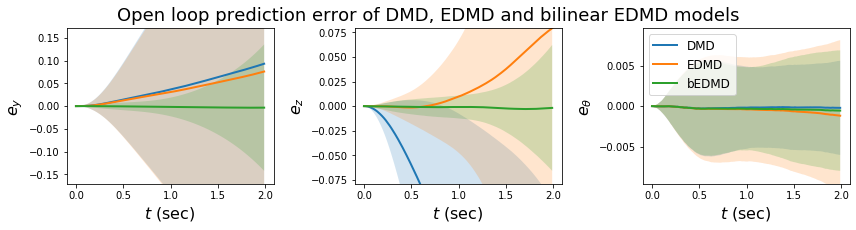

In [13]:
import matplotlib.pyplot as plt
import matplotlib

figwidth = 12
lw = 2
fs = 16
y_lim_gain = 1.2

#Plot open loop results:
ylabels = ['$e_{y}$', '$e_z$', '$e_{\\theta}$']
plt.figure(figsize=(figwidth,3))
for ii in range(3):
    plt.subplot(1,3,ii+1)
    plt.plot(t_eval[:-1], error_dmd_mean[ii,:], linewidth=lw, label='DMD')
    plt.fill_between(t_eval[:-1], error_dmd_mean[ii,:] - error_dmd_std[ii,:], error_dmd_mean[ii,:] + error_dmd_std[ii,:], alpha=0.2)
    plt.plot(t_eval[:-1], error_edmd_mean[ii, :], linewidth=lw, label='EDMD')
    plt.fill_between(t_eval[:-1], error_edmd_mean[ii, :] - error_edmd_std[ii, :],error_edmd_mean[ii, :] + error_edmd_std[ii, :], alpha=0.2)
    plt.plot(t_eval[:-1], error_bedmd_mean[ii, :], linewidth=lw, label='bEDMD')
    plt.fill_between(t_eval[:-1], error_bedmd_mean[ii, :] - error_bedmd_std[ii, :],error_bedmd_mean[ii, :] + error_bedmd_std[ii, :], alpha=0.2)
    ylim = max(max(np.abs(error_bedmd_mean[ii, :] - error_bedmd_std[ii, :])), max(np.abs(error_bedmd_mean[ii, :] + error_bedmd_std[ii, :])))
    plt.ylim([-ylim * y_lim_gain, ylim * y_lim_gain])
    plt.xlabel('$t$ (sec)', fontsize=fs)
    plt.ylabel(ylabels[ii], fontsize=fs)

plt.legend(loc='upper left', fontsize=fs-4)
suptitle = plt.suptitle('Open loop prediction error of DMD, EDMD and bilinear EDMD models', y=1.05, fontsize=18)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.tight_layout()
plt.savefig(folder_plots + 'planar_quad_prediction.pdf', format='pdf', dpi=2400, bbox_extra_artists=(suptitle,), bbox_inches="tight")
plt.show()


# Design trajectories based on learned models

We now study the closed loop performance of the control design. 

In [14]:
#Closed loop performance evaluation parameters:
traj_length=250
t_eval = dt * np.arange(traj_length+1)                       # Simulation time points, closed loop
Q_mpc = sc.sparse.diags([0,0,0,0,0,0])                       # State penalty matrix, trajectory generation
#QN_mpc = sc.sparse.diags([1e5,1e5,1e5,1e5,1e5,1e5])         # Final state penalty matrix, trajectory generation
QN_mpc = Q_mpc
R_mpc = sc.sparse.eye(m)                                     # Actuation penalty matrix, trajectory generation

ctrl_offset = np.array([hover_thrust, hover_thrust])

# Design trajectory:
x0_cl = np.array([0., 0., 0., 0., 0., 0.])                   # Initial value, closed loop trajectory
set_pt_cl = np.array([1.5, 0.5, 0., 0., 0., 0.])              # Desired final value, closed loop trajectory
xmax = np.array([2, 2, np.pi/3, 1.,1.,1.])                          # State constraints, trajectory generation
xmin = -xmax
term_constraint=True

# Define initial solution for SQP algorithm:
x_init = np.linspace(x0_cl, set_pt_cl, int(traj_length)+1)
u_init = np.zeros((m,traj_length)).T

#### Design controllers for learned DMD, EDMD, and bEDMD models

In [15]:
from koopman_core.controllers import MPCController, NonlinearMPCController, BilinearMPCController

# Define DMD-based controller:
controller_dmd = MPCController(sys_dmd, traj_length, dt, umin, umax, xmin, xmax, Q_mpc, R_mpc, QN_mpc, set_pt_cl, terminal_constraint=term_constraint, const_offset=ctrl_offset)

# Define EDMD-based controller:
controller_edmd = MPCController(sys_edmd, traj_length, dt, umin, umax, xmin, xmax, Q_mpc, R_mpc, QN_mpc, set_pt_cl, terminal_constraint=term_constraint, const_offset=ctrl_offset)

# Define bEDMD-based controller:
controller_bedmd = BilinearMPCController(sys_bedmd, traj_length, dt, umin, umax, xmin, xmax, Q_mpc, R_mpc, QN_mpc, set_pt_cl, terminal_constraint=term_constraint, const_offset=ctrl_offset)
z0_cl = sys_bedmd.basis(x0_cl.reshape((1,-1))).squeeze()
z_init = sys_bedmd.basis(x_init)
controller_bedmd.construct_controller(z_init, u_init)

#### Design controller using full knowledge of nonlinear controller

In [16]:
quadrotor_d = PlanarQuadrotorForceInputDiscrete(mass, inertia, prop_arm, g=gravity, dt=dt)
controller_nmpc = NonlinearMPCController(quadrotor_d, traj_length, dt, umin+hover_thrust, umax+hover_thrust, xmin, xmax, Q_mpc, R_mpc, QN_mpc, set_pt_cl, terminal_constraint=term_constraint)
controller_nmpc.construct_controller(x_init, u_init+hover_thrust)

#### Design trajectories with the contructed MPCs

In [17]:
max_iter = 50

controller_dmd.eval(x0_cl, 0)
xr_dmd = controller_dmd.parse_result()
ur_dmd = controller_dmd.get_control_prediction() + hover_thrust

controller_edmd.eval(x0_cl, 0)
xr_edmd = sys_edmd.C@controller_edmd.parse_result()
ur_edmd = controller_edmd.get_control_prediction() + hover_thrust

controller_bedmd.solve_to_convergence(z0_cl, 0., z_init, u_init, max_iter=max_iter)
xr_bedmd = sys_bedmd.C@controller_bedmd.get_state_prediction().T
ur_bedmd = controller_bedmd.get_control_prediction().T + hover_thrust

/Users/carlaxelfolkestad/OneDrive - California Institute of Technology/Research/Learning to fly/Code/koopman-learning-control/koopman_core/controllers/nonlinear_mpc_controller.py:99: RuntimeWarning: divide by zero encountered in double_scalars
  while (iter == 0 or np.linalg.norm(u_prev-self.cur_u)/np.linalg.norm(u_prev) > eps) and iter < max_iter:


In [18]:

controller_nmpc.solve_to_convergence(x0_cl, 0., x_init, u_init + ctrl_offset.reshape(1,-1), max_iter=max_iter)
xr_nmpc = controller_nmpc.get_state_prediction().T
ur_nmpc = controller_nmpc.get_control_prediction().T

#### Simulate designed trajectories open loop

In [19]:
ol_controller_dmd = OpenLoopController(quadrotor, ur_dmd.T, t_eval[:-1])
xs_dmd, us_dmd = quadrotor.simulate(x0_cl, ol_controller_dmd, t_eval)
xs_dmd, us_dmd = xs_dmd.T, us_dmd.T

ol_controller_edmd = OpenLoopController(quadrotor, ur_edmd.T, t_eval[:-1])
xs_edmd, us_edmd = quadrotor.simulate(x0_cl, ol_controller_edmd, t_eval)
xs_edmd, us_edmd = xs_edmd.T, us_edmd.T

ol_controller_bedmd = OpenLoopController(quadrotor, ur_bedmd.T, t_eval[:-1])
xs_bedmd, us_bedmd = quadrotor.simulate(x0_cl, ol_controller_bedmd, t_eval)
xs_bedmd, us_bedmd = xs_bedmd.T, us_bedmd.T

ol_controller_nmpc = OpenLoopController(quadrotor, ur_nmpc.T, t_eval[:-1])
xs_nmpc, us_nmpc = quadrotor.simulate(x0_cl, ol_controller_nmpc, t_eval)
xs_nmpc, us_nmpc = xs_nmpc.T, us_nmpc.T

[ 1.60396245e-08 -2.37970148e-10 -1.96203453e-04  6.41584978e-06
 -4.78454444e-08 -3.92406905e-02]
[ 2.56633967e-07 -9.85469135e-10 -7.84813559e-04  5.13267883e-05
 -1.06185374e-07 -7.84813309e-02]
[ 1.29920911e-06 -2.57400754e-09 -1.76582983e-03  1.73227835e-04
 -2.31662561e-07 -1.17721923e-01]
[ 4.10614049e-06 -6.31693143e-09 -3.13925178e-03  4.10613814e-04
 -5.71553758e-07 -1.56962468e-01]
[ 1.00177052e-05 -1.90538803e-06 -4.90432306e-03  8.00446617e-04
 -3.79357719e-04 -1.96051787e-01]
[ 2.06977266e-05 -1.74307785e-05 -7.04800686e-03  1.36976851e-03
 -2.72592421e-03 -2.32684972e-01]
[ 3.81601878e-05 -5.57018155e-05 -9.54207910e-03  2.16258619e-03
 -4.92861319e-03 -2.66129476e-01]
[ 6.48064713e-05 -1.15288336e-04 -1.23552087e-02  3.21169908e-03
 -6.98918333e-03 -2.96496446e-01]
[ 1.03351746e-04 -1.94778844e-04 -1.54571681e-02  4.54708014e-03
 -8.90960901e-03 -3.23895434e-01]
[ 1.56797129e-04 -2.92782652e-04 -1.88188172e-02  6.19596074e-03
 -1.06920768e-02 -3.48434395e-01]
[ 2.284026

[0.7033087  0.17011535 0.01725182 0.89605279 0.46223158 0.08983868]
[0.71226058 0.17473986 0.01817898 0.89430743 0.46267016 0.09559283]
[0.72119457 0.17936669 0.0191671  0.89247544 0.46269578 0.10203153]
[0.73010979 0.18399183 0.02022279 0.89055089 0.46233013 0.10910716]
[0.73900527 0.18861147 0.02135216 0.88852718 0.46159849 0.11676724]
[0.74787999 0.19322211 0.02256077 0.88639704 0.46052974 0.1249547 ]
[0.75673284 0.19782055 0.02385359 0.88415258 0.45915642 0.13360838]
[0.76556264 0.20240391 0.02523495 0.88178533 0.45751466 0.14266351]
[0.77436812 0.2069697  0.02670853 0.87928628 0.45564395 0.15205233]
[0.78314791 0.21151586 0.02827731 0.87664589 0.45358701 0.1617047 ]
[0.79190054 0.21604074 0.02994358 0.87385413 0.45138914 0.171549  ]
[0.80062445 0.22054318 0.03170889 0.8709006  0.44909679 0.18151335]
[0.80931798 0.22502243 0.0335741  0.86777466 0.44675325 0.1915281 ]
[0.81797934 0.22947814 0.0355394  0.86446591 0.44438654 0.20153149]
[0.82660665 0.23391012 0.03760441 0.8609644  0.4

[ 1.60094653e-08  2.12020541e-05 -1.87720161e-04  6.40378612e-06
  4.24041059e-03 -3.75440322e-02]
[ 2.60669874e-07  9.94278659e-05 -7.45032691e-04  5.23058179e-05
  1.14047474e-02 -7.39184738e-02]
[ 1.32544715e-06  2.53990284e-04 -1.65659715e-03  1.76784779e-04
  1.95077171e-02 -1.08394418e-01]
[ 4.17773107e-06  4.88916551e-04 -2.90160742e-03  4.15681663e-04
  2.74774866e-02 -1.40607635e-01]
[ 1.01330319e-05  8.02885649e-04 -4.45775959e-03  8.02854634e-04
  3.53162323e-02 -1.70622799e-01]
[ 2.08331616e-05  1.19459750e-03 -6.30339276e-03  1.36971897e-03
  4.30259633e-02 -1.98503835e-01]
[ 3.82222189e-05  1.66277121e-03 -8.41748147e-03  2.14532953e-03
  5.06085042e-02 -2.24313908e-01]
[ 6.45233884e-05  2.20614313e-03 -1.07796282e-02  3.15646122e-03
  5.80654827e-02 -2.48115431e-01]
[ 1.02216535e-04  2.82346491e-03 -1.33700556e-02  4.42768754e-03
  6.53983239e-02 -2.69970058e-01]
[ 1.54016576e-04  3.51350140e-03 -1.61695993e-02  5.98145728e-03
  7.26082492e-02 -2.89938685e-01]
[ 2.228526

[ 0.71946706  0.32104308 -0.02776463  1.16448459  0.35038674  0.12256638]
[ 0.73112538  0.32454864 -0.02656544  1.16715894  0.35072665  0.11727294]
[ 0.74280984  0.32805694 -0.02541777  1.16971424  0.35093266  0.11226096]
[ 0.75451928  0.33156652 -0.02431864  1.17215519  0.35098346  0.10756457]
[ 0.76625257  0.33507572 -0.02326474  1.17448627  0.35085877  0.10321585]
[ 0.77800864  0.33858272 -0.02225244  1.17671169  0.35053974  0.09924443]
[ 0.78978646  0.34208546 -0.02127783  1.17883535  0.35000917  0.09567707]
[ 0.80158501  0.34558176 -0.02033676  1.18086082  0.34925178  0.09253739]
[ 0.81340335  0.34906929 -0.01942484  1.18279133  0.34825441  0.08984554]
[ 0.82524052  0.35254559 -0.01853753  1.18462974  0.34700616  0.08761794]
[ 0.83709564  0.35600811 -0.0176701   1.18637848  0.34549858  0.08586711]
[ 0.84896779  0.35945424 -0.01681776  1.1880396   0.34372577  0.08460149]
[ 0.86085613  0.36288129 -0.01597562  1.18961472  0.34168449  0.08382527]
[ 0.8727598   0.36628658 -0.0151388   

[ 1.95625991  0.58009297  0.08527799  0.63675797  0.13358846 -0.01246835]
[ 1.96258578  0.58142645  0.08520073  0.62841757  0.13310721 -0.00298267]
[1.96882826 0.58275526 0.08522415 0.62007744 0.13265505 0.00766576]
[1.97498729 0.5840797  0.0853601  0.61172695 0.13223337 0.0195246 ]
[1.98106272 0.58540009 0.08562094 0.60335433 0.13184352 0.03264229]
[ 1.60393508e-08 -6.22668200e-11 -1.96200035e-04  6.41574032e-06
 -1.27047702e-08 -3.92400070e-02]
[ 2.56629608e-07 -2.87183388e-10 -7.84800139e-04  5.13259204e-05
 -3.68094105e-08 -7.84800138e-02]
[ 1.29918727e-06 -1.01527825e-09 -1.76580031e-03  1.73224950e-04
 -1.28949152e-07 -1.17720020e-01]
[ 4.10607236e-06 -3.56882907e-09 -3.13920055e-03  4.10607091e-04
 -4.36390810e-07 -1.56960027e-01]
[ 1.00245856e-05 -1.13847529e-08 -4.90500085e-03  8.01966160e-04
 -1.24234788e-06 -1.96200033e-01]
[ 2.07869616e-05 -3.16006434e-08 -7.06320121e-03  1.38579497e-03
 -3.01129434e-06 -2.35440039e-01]
[ 3.85003581e-05 -1.34024747e-06 -9.61329636e-03  2.19

[ 0.75436973  0.72924376 -0.01063983  1.09451851  0.44761229 -0.00198613]
[ 0.76531964  0.73367384 -0.01067356  1.09546562  0.43840335 -0.00476024]
[ 0.77627905  0.73801195 -0.01072939  1.09641706  0.42921799 -0.00640625]
[ 0.787248    0.7422583  -0.01079597  1.09737423  0.42005295 -0.00690988]
[ 0.79822656  0.74641309 -0.01086187  1.09833757  0.41090483 -0.00626894]
[ 0.80921478  0.75047645 -0.01091568  1.09930643  0.40176717 -0.00449325]
[ 0.8202127   0.75444843 -0.01094617  1.1002791   0.39262738 -0.00160446]
[ 0.83122036  0.75832888 -0.01094237  1.10125278  0.38346365  0.00236431]
[ 0.84223775  0.76211741 -0.0108937   1.10222357  0.37424246  0.00736889]
[ 0.8532648   0.76581321 -0.01079009  1.10318653  0.36491682  0.01335461]
[ 0.86430143  0.76941492 -0.01062203  1.10413573  0.35542587  0.020257  ]
[ 0.87534745  0.77292053 -0.01038073  1.10506435  0.34569621  0.02800276]
[ 0.88640262  0.77632724 -0.01005816  1.10596482  0.33564568  0.03651081]
[ 0.89746661  0.77963142 -0.00964714  

[ 1.60393488e-08  1.06014400e-12 -1.96199984e-04  6.41573949e-06
 -3.93772489e-11 -3.92399969e-02]
[ 2.56629575e-07 -3.35633594e-11 -7.84799938e-04  5.13259138e-05
 -1.14161888e-08 -7.84799938e-02]
[ 1.29918711e-06 -4.43828341e-10 -1.76579986e-03  1.73224928e-04
 -9.07763902e-08 -1.17719991e-01]
[ 4.10607184e-06 -2.55154713e-09 -3.13919975e-03  4.10607040e-04
 -3.85397142e-07 -1.56959988e-01]
[ 1.00245844e-05 -9.79327291e-09 -4.90499962e-03  8.01966061e-04
 -1.17850190e-06 -1.96199985e-01]
[ 2.07869590e-05 -2.93063333e-08 -7.06319946e-03  1.38579480e-03
 -2.93457421e-06 -2.35439982e-01]
[ 3.84553971e-05 -7.01842582e-06 -9.61102140e-03  2.18895850e-03
 -1.39523090e-03 -2.74124406e-01]
[ 6.52324895e-05 -4.84645464e-05 -1.25374783e-02  3.21162531e-03
 -6.89449257e-03 -3.11166970e-01]
[ 1.03387078e-04 -1.64081666e-04 -1.58266956e-02  4.46795365e-03
 -1.62296207e-02 -3.46676488e-01]
[ 1.55774471e-04 -3.63754741e-04 -1.94529848e-02  6.06429619e-03
 -2.37059595e-02 -3.78581363e-01]
[ 2.260591

 4.12634020e-01 2.92983614e-02]
[8.33550928e-01 8.03295787e-01 8.02796970e-04 1.00468192e+00
 4.01041255e-01 3.79297752e-02]
[0.84359734 0.8072464  0.00122888 1.00459508 0.38908095 0.04728589]
[0.8536427  0.81107526 0.00175178 1.00446806 0.37669105 0.0572957 ]
[0.86368655 0.81477777 0.00237769 1.00429285 0.36381205 0.0678856 ]
[0.87372837 0.81834884 0.00311203 1.00406118 0.35040067 0.07898168]
[0.88376755 0.82178308 0.0039595  1.00376446 0.33644843 0.09051252]
[0.89380341 0.82507494 0.00492411 1.00339407 0.32192204 0.10240925]
[0.90383517 0.82821846 0.00600918 1.00294139 0.30678292 0.11460539]
[0.91386195 0.83120733 0.00721739 1.00239791 0.29099135 0.12703664]
[0.9238828  0.83403487 0.00855078 1.00175522 0.27451528 0.13964088]
[0.9338967  0.83669408 0.01001077 1.00100514 0.25732633 0.15235816]
[0.94390253 0.83917771 0.01159822 1.00013972 0.23939996 0.16513069]
[0.9538991  0.84147829 0.01331338 0.99915133 0.22071588 0.17790283]
[0.96388514 0.84358816 0.015156   0.99803264 0.20125831 0.1

##### Compare performance

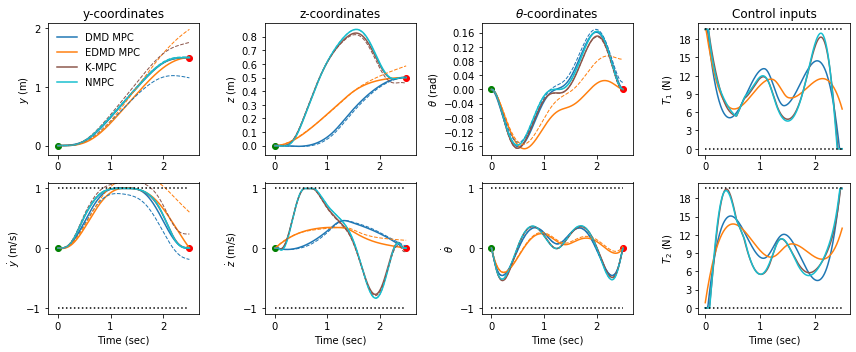

Solution statistics:

                       Normalized cost,    Realized terminal,  # of SQP      Mean comp. time           Total comp.
                    designed trajectory                 error  iterations    per iteration (secs)      time (secs)
----------------  ---------------------  --------------------  ------------  ----------------------  -------------
DMD MPC                          0.9345                0.3963  -             -                            0.257834
EDMD MPC                         0.862                 0.7928  -             -                            3.65869
bEDMD MPC                        0.9875                0.3582  13            2.5297                      32.8863
NMPC (benchmark)                 1                     0.0174  8             0.1623                       1.29845


In [20]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

plot_inds = [0, 1, 2, 3, 4, 5, 0, 1]
subplot_inds = [1, 2, 3, 5, 6, 7, 4, 8]
labels = ['$y$ (m)', '$z$ (m)', '$\\theta$ (rad)', '$\\dot{y}$ (m/s)','$\\dot{z}$ (m/s)', '$\\dot{\\theta}$', '$T_1$ (N)','$T_2$ (N)']
titles = ['y-coordinates', 'z-coordinates', '$\\theta$-coordinates', 'Control inputs']
colors = ['tab:blue', 'tab:orange', 'tab:brown', 'tab:cyan']

plt.figure(figsize=(12,5))
#plt.suptitle('Trajectory designed with model predictive controllers\nsolid lines - designed trajectory | dashed lines - open loop simulated trajectory | black dotted lines - state/actuation bounds')
for ii in range(8):
    ind = plot_inds[ii]
    if ii < 6:
        ax = plt.subplot(2,4,subplot_inds[ii])
        plt.plot(t_eval, xr_dmd[ind,:], colors[0], label='DMD MPC')
        plt.plot(t_eval, xr_edmd[ind, :], colors[1], label='EDMD MPC')
        plt.plot(t_eval, xr_bedmd[ind, :], colors[2], label='K-MPC')
        plt.plot(t_eval, xr_nmpc[ind,:], colors[3], label='NMPC')

        plt.plot(t_eval, xs_dmd[ind,:], '--', color=colors[0], linewidth=1)
        plt.plot(t_eval, xs_edmd[ind, :], '--', color=colors[1], linewidth=1)
        plt.plot(t_eval, xs_bedmd[ind, :], '--', color=colors[2], linewidth=1)
        plt.plot(t_eval, xs_nmpc[ind,:], '--', color=colors[3], linewidth=1)

        plt.scatter(t_eval[0], x0_cl[ind], color='g')
        plt.scatter(t_eval[-1], set_pt_cl[ind], color='r')
        plt.ylabel(labels[ind])
#        plt.ylim(xmin[ind]-0.1,xmax[ind]+0.1)
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        if ii >= 3:
            plt.plot([0, t_eval[-1]], [xmax[ind], xmax[ind]], ':k')
            plt.plot([0, t_eval[-1]], [xmin[ind], xmin[ind]], ':k')
            plt.ylim(xmin[ind]-0.1,xmax[ind]+0.1)
        if subplot_inds[ii]==1:
            plt.legend(loc='upper left', frameon=False)
    elif ii < 8:
        ax = plt.subplot(2,4,subplot_inds[ii])
        plt.plot(t_eval[:-1],ur_dmd[ind,:], color=colors[0], label='DMD MPC')
        plt.plot(t_eval[:-1], ur_edmd[ind, :], color=colors[1], label='EDMD MPC')
        plt.plot(t_eval[:-1], ur_bedmd[ind, :], color=colors[2], label='K-NMPC')
        plt.plot(t_eval[:-1],ur_nmpc[ind,:], color=colors[3], label='NMPC')
        plt.plot([0, t_eval[-1]], [umax[ind]+hover_thrust, umax[ind]+hover_thrust], ':k')
        plt.plot([0, t_eval[-1]], [umin[ind]+hover_thrust, umin[ind]+hover_thrust], ':k')
        plt.ylabel(labels[ii])
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        
    if subplot_inds[ii] > 4:
        plt.xlabel('Time (sec)')
    else:
        plt.title(titles[subplot_inds[ii]-1])

if save_figures:
    matplotlib.rcParams['pdf.fonttype'] = 42
    matplotlib.rcParams['ps.fonttype'] = 42
    plt.tight_layout()
    plt.savefig(dropbox_folder + 'planar_quad_trajectory.pdf', format='pdf', dpi=2400)
plt.show()

cost_ref_dmd = (xr_dmd[:,-1]-set_pt_cl).T@QN_mpc@(xr_dmd[:,-1]-set_pt_cl) + np.sum(np.diag(ur_dmd.T@R_mpc@ur_dmd))
cost_ref_edmd = (xr_edmd[:,-1]-set_pt_cl).T@QN_mpc@(xr_edmd[:,-1]-set_pt_cl) + np.sum(np.diag(ur_edmd.T@R_mpc@ur_edmd))
cost_ref_bedmd = (xr_bedmd[:,-1]-set_pt_cl).T@QN_mpc@(xr_bedmd[:,-1]-set_pt_cl) + np.sum(np.diag(ur_bedmd.T@R_mpc@ur_bedmd))
cost_ref_nmpc = (xr_nmpc[:,-1]-set_pt_cl).T@QN_mpc@(xr_nmpc[:,-1]-set_pt_cl) + np.sum(np.diag(ur_nmpc.T@R_mpc@ur_nmpc))

dist_ol_dmd = np.linalg.norm(xs_dmd[:,-1] - set_pt_cl)
dist_ol_edmd = np.linalg.norm(xs_edmd[:,-1] - set_pt_cl)
dist_ol_bedmd = np.linalg.norm(xs_bedmd[:,-1] - set_pt_cl)
dist_ol_nmpc = np.linalg.norm(xs_nmpc[:,-1] - set_pt_cl)

print('Solution statistics:\n')
print(tabulate([['DMD MPC', "{:.4f}".format(cost_ref_dmd/cost_ref_nmpc), "{:.4f}".format(dist_ol_dmd), '-','-',sum(controller_dmd.comp_time)], 
                ['EDMD MPC', "{:.4f}".format(cost_ref_edmd/cost_ref_nmpc), "{:.4f}".format(dist_ol_edmd),'-','-',sum(controller_edmd.comp_time)], 
                ['bEDMD MPC', "{:.4f}".format(cost_ref_bedmd/cost_ref_nmpc), "{:.4f}".format(dist_ol_bedmd), len(controller_bedmd.x_iter), "{:.4f}".format(np.mean(controller_bedmd.comp_time)), sum(controller_bedmd.comp_time)],
                ['NMPC (benchmark)', 1, "{:.4f}".format(dist_ol_nmpc), len(controller_nmpc.x_iter), "{:.4f}".format(np.mean(controller_nmpc.comp_time)), sum(controller_nmpc.comp_time)]], 
               headers=['Normalized cost,\ndesigned trajectory', 'Realized terminal,\nerror', '# of SQP\niterations','Mean comp. time\nper iteration (secs)', 'Total comp.\ntime (secs)']))

#### Study evolution of the solution after each iteration of the SQP-algorithm

In [21]:
n_iter = min(len(controller_nmpc.x_iter),len(controller_bedmd.x_iter))

# Calculate cost after each iteration:
iter_cost_bedmd, iter_cost_nmpc = [], []

ol_controller_init = OpenLoopController(quadrotor, u_init, t_eval[:-1])
xs_init, _ = quadrotor.simulate(x0_cl, ol_controller_init, t_eval)
xs_init, us_init = xs_init.T, u_init.T+hover_thrust
init_cost = (xs_init[:,-1]-set_pt_cl).T@QN_mpc@(xs_init[:,-1]-set_pt_cl) + np.sum(np.diag(us_init.T@R_mpc@us_init))
iter_cost_bedmd = [init_cost]
iter_cost_nmpc = [init_cost]
iter_norm_dist_bedmd = [np.linalg.norm(xs_init[:,-1]-set_pt_cl)]
iter_norm_dist_nmpc = [np.linalg.norm(xs_init[:,-1]-set_pt_cl)]

for ii in range(len(controller_bedmd.x_iter)):
    ur_bedmd_iter = controller_bedmd.u_iter[ii].T+hover_thrust
    ol_controller_bedmd_iter = OpenLoopController(quadrotor, ur_bedmd_iter, t_eval[:-1])
    xs_bedmd_iter, _ = quadrotor.simulate(x0_cl, ol_controller_bedmd_iter, t_eval)
    xs_bedmd_iter, us_bedmd_iter = xs_bedmd_iter.T, ur_bedmd_iter.T
    iter_cost_bedmd.append((xs_bedmd_iter[:,-1]-set_pt_cl).T@QN_mpc@(xs_bedmd_iter[:,-1]-set_pt_cl) + np.sum(np.diag(us_bedmd_iter.T@R_mpc@us_bedmd_iter)))
    iter_norm_dist_bedmd.append(np.linalg.norm(xs_bedmd_iter[:,-1]-set_pt_cl))
    
for ii in range(len(controller_nmpc.x_iter)):
    ur_nmpc_iter = controller_nmpc.u_iter[ii].T
    ol_controller_nmpc_iter = OpenLoopController(quadrotor, ur_nmpc_iter, t_eval[:-1])
    xs_nmpc_iter, _ = quadrotor.simulate(x0_cl, ol_controller_nmpc_iter, t_eval)
    xs_nmpc_iter, us_nmpc_iter = xs_nmpc_iter.T, ur_nmpc_iter.T
    iter_cost_nmpc.append((xs_nmpc_iter[:,-1]-set_pt_cl).T@QN_mpc@(xs_nmpc_iter[:,-1]-set_pt_cl) + np.sum(np.diag(us_nmpc_iter.T@R_mpc@us_nmpc_iter)))
    iter_norm_dist_nmpc.append(np.linalg.norm(xs_nmpc_iter[:,-1]-set_pt_cl))

[ 0.        -0.0004905  0.         0.        -0.0981     0.       ]
[ 0.       -0.001962  0.        0.       -0.1962    0.      ]
[ 0.        -0.0044145  0.         0.        -0.2943     0.       ]
[ 0.       -0.007848  0.        0.       -0.3924    0.      ]
[ 0.        -0.0122625  0.         0.        -0.4905     0.       ]
[ 0.       -0.017658  0.        0.       -0.5886    0.      ]
[ 0.        -0.0240345  0.         0.        -0.6867     0.       ]
[ 0.       -0.031392  0.        0.       -0.7848    0.      ]
[ 0.        -0.0397305  0.         0.        -0.8829     0.       ]
[ 0.      -0.04905  0.       0.      -0.981    0.     ]
[ 0.        -0.0593505  0.         0.        -1.0791     0.       ]
[ 0.       -0.070632  0.        0.       -1.1772    0.      ]
[ 0.        -0.0828945  0.         0.        -1.2753     0.       ]
[ 0.       -0.096138  0.        0.       -1.3734    0.      ]
[ 0.        -0.1103625  0.         0.        -1.4715     0.       ]
[ 0.       -0.125568  0.    

[  0.       -16.969338   0.         0.       -18.2466     0.      ]
[  0.        -17.1522945   0.          0.        -18.3447      0.       ]
[  0.       -17.336232   0.         0.       -18.4428     0.      ]
[  0.        -17.5211505   0.          0.        -18.5409      0.       ]
[  0.      -17.70705   0.        0.      -18.639     0.     ]
[  0.        -17.8939305   0.          0.        -18.7371      0.       ]
[  0.       -18.081792   0.         0.       -18.8352     0.      ]
[  0.        -18.2706345   0.          0.        -18.9333      0.       ]
[  0.       -18.460458   0.         0.       -19.0314     0.      ]
[  0.        -18.6512625   0.          0.        -19.1295      0.       ]
[  0.       -18.843048   0.         0.       -19.2276     0.      ]
[  0.        -19.0358145   0.          0.        -19.3257      0.       ]
[  0.       -19.229562   0.         0.       -19.4238     0.      ]
[  0.        -19.4242905   0.          0.        -19.5219      0.       ]
[  0.   -19.

[ 0.03366239  0.0444739  -0.10893623  0.2369969   0.16837252 -0.20510039]
[ 0.03608771  0.04617006 -0.11095322  0.24810089  0.1708562  -0.1982981 ]
[ 0.03862506  0.04789085 -0.11290141  0.25940192  0.17329651 -0.19134018]
[ 0.04127638  0.04963582 -0.11477931  0.27089285  0.17569383 -0.18423989]
[ 0.04404353  0.05140455 -0.11658556  0.28256644  0.17804861 -0.17701024]
[ 0.04692829  0.05319661 -0.11831893  0.29441529  0.18036135 -0.16966397]
[ 0.04993239  0.0550116  -0.11997832  0.30643194  0.18263259 -0.16221355]
[ 0.05305746  0.05684909 -0.12156274  0.31860878  0.18486294 -0.15467118]
[ 0.05630507  0.05870869 -0.12307134  0.33093817  0.18705304 -0.14704882]
[ 0.0596767   0.06058999 -0.12450338  0.34341235  0.1892036  -0.13935814]
[ 0.06317377  0.06249259 -0.12585822  0.35602353  0.19131534 -0.13161054]
[ 0.0667976   0.06441613 -0.12713536  0.36876387  0.19338904 -0.12381716]
[ 0.07054944  0.06636022 -0.12833439  0.38162547  0.19542552 -0.11598889]
[ 0.07443048  0.06832448 -0.12945502  

[ 1.07308983  0.34110125 -0.02039543  1.3430069   0.31658816  0.15910462]
[ 1.08652969  0.34426921 -0.01879661  1.34493781  0.3170049   0.16066011]
[ 1.09998806  0.34744124 -0.01718194  1.34671001  0.31740128  0.16227397]
[ 1.11346336  0.35061713 -0.01555089  1.348322    0.31777785  0.1639356 ]
[ 1.12695396  0.35379669 -0.01390304  1.34977222  0.31813521  0.16563441]
[ 1.14045825  0.35697973 -0.01223807  1.35105907  0.31847322  0.16736076]
[ 1.15397459  0.36016606 -0.01055574  1.35218093  0.31879161  0.16910539]
[ 1.16750132  0.36335546 -0.00885591  1.35313614  0.31909013  0.1708593 ]
[ 1.18103675  0.36654776 -0.00713855  1.35392306  0.31936849  0.17261378]
[ 1.19457921  0.36974273 -0.00540368  1.35454002  0.31962641  0.17436037]
[ 1.20812698  0.37294018 -0.00365142  1.35498539  0.3198636   0.17609089]
[ 1.22167834  0.3761399  -0.00188198  1.35525755  0.32007975  0.1777974 ]
[ 1.23523155e+00  3.79341667e-01 -9.56299585e-05  1.35535488e+00
  3.20274547e-01  1.79472265e-01]
[1.24878485 0

[ 0.01725645  0.04672769 -0.11079419  0.1825943   0.3828007  -0.32761806]
[ 0.01914841  0.05065282 -0.11400773  0.19586064  0.40221914 -0.31509131]
[ 0.02117501  0.05477296 -0.1170939   0.20952114  0.42180213 -0.30214098]
[ 0.02334012  0.05908957 -0.12004872  0.22355731  0.44151314 -0.28882359]
[ 0.02564737  0.06360375 -0.1228688   0.23794978  0.46131552 -0.2751931 ]
[ 0.02810025  0.06831622 -0.12555127  0.25267843  0.48117256 -0.26130087]
[ 0.03070201  0.07322736 -0.12809376  0.26772247  0.50104761 -0.24719569]
[ 0.03345568  0.07833715 -0.13049435  0.28306054  0.52090418 -0.2329238 ]
[ 0.03636412  0.08364523 -0.13275162  0.29867082  0.54070607 -0.21852891]
[ 0.03942992  0.08915087 -0.13486452  0.31453113  0.56041736 -0.20405221]
[ 0.04265548  0.094853   -0.13683245  0.33061902  0.58000259 -0.18953247]
[ 0.04604296  0.10075017 -0.13865514  0.34691186  0.59942676 -0.17500606]
[ 0.04959429  0.1068406  -0.1403327   0.36338693  0.61865545 -0.16050702]
[ 0.05331118  0.11312218 -0.14186557  

 -8.98116257e-08 -1.17720067e-01]
[ 4.10607462e-06 -2.52106773e-09 -3.13920180e-03  4.10607314e-04
 -3.84534403e-07 -1.56960085e-01]
[ 1.00350377e-05  2.96121045e-06 -4.89854184e-03  8.04124520e-04
  5.93015084e-04 -1.94907922e-01]
[ 2.08471779e-05  1.51976394e-05 -7.02235714e-03  1.39347427e-03
  1.85406169e-03 -2.29855137e-01]
[ 3.86963201e-05  4.40987207e-05 -9.48080363e-03  2.21739864e-03
  3.92581654e-03 -2.61834161e-01]
[ 6.61168098e-05  9.83892952e-05 -1.22444495e-02  3.31326950e-03
  6.93179315e-03 -2.90895004e-01]
[ 1.06009877e-04  1.87936187e-04 -1.52844430e-02  4.71709743e-03
  1.09768735e-02 -3.17103708e-01]
[ 1.61629790e-04  3.23566472e-04 -1.85726641e-02  6.46348154e-03
  1.61482259e-02 -3.40540512e-01]
[ 2.36569271e-04  5.16894913e-04 -2.20818559e-02  8.58551435e-03
  2.25162209e-02 -3.61297853e-01]
[ 3.34743808e-04  7.80160532e-04 -2.57857365e-02  1.11146549e-02
  3.01353411e-02 -3.79478264e-01]
[ 0.00046037  0.00112607 -0.02965909  0.01408058  0.03904508 -0.39519226]
[

[ 1.58457052  0.66549296  0.11308398  0.89383995 -0.48251733  0.08431056]
[ 1.59345282  0.66067008  0.1138608   0.88260729 -0.48206199  0.07105313]
[ 1.60222196  0.65585586  0.11450367  0.87120915 -0.48078203  0.05752087]
[ 1.61087634  0.65105855  0.11500998  0.85965842 -0.47868037  0.04374078]
[ 1.6194145   0.64628634  0.11537739  0.84796883 -0.47576228  0.0297412 ]
[ 1.62783514  0.64154736  0.11560385  0.83615499 -0.47203537  0.01555187]
[ 1.63613708e+00  6.36849634e-01  1.15687630e-01  8.24232325e-01
 -4.67509597e-01  1.20394044e-03]
[ 1.64431933  0.6322011   0.1156273   0.81221704 -0.46219726 -0.01327002]
[ 1.65238102  0.62760955  0.11542177  0.80012608 -0.45611299 -0.02783599]
[ 1.66032151  0.62308261  0.1150703   0.78797712 -0.44927369 -0.04245845]
[ 1.66814029  0.61862774  0.1145725   0.77578844 -0.44169853 -0.0571004 ]
[ 1.67583707  0.6142522   0.11392838  0.7635789  -0.43340892 -0.07172329]
[ 1.68341174  0.609963    0.11313833  0.75136787 -0.4244284  -0.08628701]
[ 1.69086437 

[ 0.65260247  0.6928756  -0.02557814  1.10691374  0.45051535  0.1106908 ]
[ 0.66368232  0.69731492 -0.02451219  1.10904077  0.43734854  0.10249999]
[ 0.67478304  0.70162434 -0.02352636  1.11108915  0.42453587  0.09466464]
[ 0.68590388  0.70580749 -0.02261686  1.11306526  0.41209509  0.0872369 ]
[ 0.69704415  0.70986853 -0.02177928  1.11497672  0.40011266  0.08027879]
[ 0.70820324  0.71381237 -0.02100863  1.11683018  0.38865589  0.07385167]
[ 0.7193806   0.71764443 -0.0202993   1.11863107  0.37775742  0.06801258]
[ 0.73057572  0.72137034 -0.01964517  1.1203838   0.36742333  0.06281363]
[ 0.74178814  0.72499565 -0.0190396   1.12209193  0.35763967  0.05830139]
[ 0.75301744  0.72852574 -0.01847551  1.12375823  0.34837756  0.05451637]
[ 0.76426319  0.73196561 -0.01794547  1.12538474  0.33959702  0.05149251]
[ 0.77552501  0.73531984 -0.01744172  1.12697279  0.3312499   0.04925671]
[ 0.78680253  0.7385925  -0.01695629  1.12852301  0.32328192  0.04782851]
[ 0.79809536  0.74178708 -0.01648105  

[ 1.80669536  0.52622408  0.04798634  0.4242938   0.01391355 -0.31476803]
[ 1.81091281  0.52641509  0.0448906   0.41925364  0.02428992 -0.30438047]
[ 1.81508174  0.52670506  0.04190928  0.41458555  0.03370809 -0.29188437]
[ 1.81920577  0.52708447  0.03906393  0.41026998  0.04217458 -0.27718454]
[ 1.8232883   0.52754388  0.03637709  0.40628499  0.0497094  -0.2601844 ]
[ 1.82733254  0.52807415  0.03387224  0.40260629  0.05634731 -0.24078596]
[ 1.83134141  0.52866658  0.03157386  0.39920731  0.06213908 -0.21888983]
[ 1.83531757  0.52931303  0.02950743  0.39605928  0.06715284 -0.19439522]
[ 1.83926337  0.53000617  0.02769946  0.39313117  0.07147543 -0.16719986]
[ 1.84318084  0.53073961  0.02617746  0.39038968  0.07521389 -0.13720002]
[ 1.84707168  0.53150817  0.02497     0.38779916  0.07849689 -0.1042904 ]
[ 1.85093721  0.53230803  0.02410673  0.38532136  0.08147633 -0.06836416]
[ 1.8547785   0.53313104  0.02361594  0.38294398  0.08312506 -0.02979494]
[1.85859639 0.53396215 0.02351419 0.38

[ 0.56400449  0.64385529 -0.03288475  1.08257606  0.58190746  0.1795084 ]
[ 0.5748437   0.64960019 -0.03113903  1.0852418   0.56707363  0.16963531]
[ 0.58570889  0.65519784 -0.02949216  1.08777276  0.552458    0.15974003]
[ 0.59659874  0.66065045 -0.02794413  1.09017663  0.5380645   0.1498645 ]
[ 0.60751203  0.66596024 -0.02649455  1.09246102  0.52389416  0.14005205]
[ 0.6184476   0.67112944 -0.02514255  1.09463348  0.50994529  0.13034736]
[ 0.62940436  0.67616023 -0.02388683  1.09670148  0.49621356  0.12079651]
[ 0.64038131  0.68105476 -0.02272562  1.09867239  0.4826923   0.11144692]
[ 0.65137752  0.68581508 -0.02165665  1.10055343  0.46937265  0.10234736]
[ 0.66239212  0.69044337 -0.02067715  1.10235255  0.4562863   0.09355227]
[ 0.67342433  0.69494233 -0.01978377  1.10407825  0.44350623  0.0851227 ]
[ 0.68447347  0.69931524 -0.01897257  1.10573798  0.43107474  0.07711874]
[ 0.69553891  0.70356566 -0.01823898  1.10733839  0.41901034  0.06959897]
[ 0.70662008  0.70769764 -0.01757783  

[ 1.73558723  0.51070463  0.08724994  0.464323   -0.15544128 -0.34926373]
[ 1.74017959  0.50924932  0.08371559  0.45421691 -0.13561532 -0.35760631]
[ 1.74467326  0.50798907  0.08010394  0.44458772 -0.11642831 -0.36472328]
[ 1.74907307  0.50691703  0.07642767  0.43544624 -0.09797365 -0.37053016]
[ 1.75338394  0.50602543  0.07270031  0.42680033 -0.08034159 -0.37494103]
[ 1.75761086  0.5053056   0.06893627  0.41865484 -0.06361831 -0.37786865]
[ 1.76175883  0.50474806  0.0651508   0.41101148 -0.04788512 -0.37922446]
[ 1.76583288  0.50434253  0.06136008  0.40386881 -0.03321747 -0.37891872]
[ 1.76983798  0.504078    0.05758119  0.39722225 -0.01968399 -0.37686055]
[ 1.77377907  0.50394283  0.0538321   0.39106408 -0.00734548 -0.37295799]
[ 1.77766097  0.50392482  0.05013171  0.3853835   0.00374622 -0.36711811]
[ 1.78148839  0.50401128  0.04649989  0.38016673  0.01354928 -0.35924705]
[ 1.7852659   0.50418918  0.0429574   0.37539709  0.02203308 -0.34925009]
[ 1.78899786  0.50444523  0.03952599  

[ 1.23584864  0.7824538   0.04879075  1.09646995 -0.23644585  0.30609974]
[ 1.24679448  0.77997728  0.05186777  1.09265773 -0.25886031  0.30930505]
[ 1.257701    0.77727696  0.05497398  1.08860718 -0.28120589  0.31193536]
[ 1.26856579  0.77435381  0.05810353  1.08431252 -0.30342496  0.31397605]
[ 1.27938639  0.77120941  0.06125048  1.0797678  -0.3254587   0.3154136 ]
[ 1.29016027  0.76784589  0.06440873  1.07496693 -0.34724734  0.31623556]
[ 1.30088482  0.76426602  0.06757206  1.0699036  -0.36873036  0.31643058]
[ 1.3115574   0.76047314  0.07073415  1.06457141 -0.38984674  0.31598839]
[ 1.32217528  0.75647125  0.07388859  1.05896383 -0.41053518  0.31489983]
[ 1.33273568  0.75226492  0.07702888  1.05307424 -0.43073438  0.3131569 ]
[ 1.34323573  0.74785934  0.08014843  1.04689598 -0.45038321  0.3107527 ]
[ 1.35367253  0.74326034  0.0832406   1.04042242 -0.46942101  0.30768153]
[ 1.36404308  0.73847431  0.0862987   1.03364698 -0.48778782  0.30393889]
[ 1.37434433  0.73350827  0.089316    

[ 0.00731558  0.01211246 -0.09609921  0.11108337  0.23619892 -0.49321863]
[ 0.00848845  0.01461658 -0.10098115  0.12359196  0.26461592 -0.48316925]
[ 0.00979     0.01740976 -0.10575463  0.13681914  0.29400999 -0.47152605]
[ 0.01122732  0.0205011  -0.1104042   0.15074536  0.32424647 -0.45838793]
[ 0.01280729  0.02389832 -0.11491542  0.16534643  0.35518687 -0.44385557]
[ 0.01453652  0.02760776 -0.11927485  0.1805938   0.38669005 -0.42803107]
[ 0.01642131  0.03163433 -0.12347009  0.19645486  0.41861321 -0.41101746]
[ 0.01846762  0.03598152 -0.12748977  0.21289322  0.45081296 -0.39291834]
[ 0.02068101  0.04065137 -0.13132355  0.22986912  0.48314625 -0.37383736]
[ 0.02306666  0.04564451 -0.13496213  0.24733982  0.51547124 -0.35387786]
[ 0.02562929  0.05096016 -0.13839723  0.26526004  0.54764818 -0.3331424 ]
[ 0.02837315  0.05659615 -0.1416216   0.28358237  0.57954015 -0.31173233]
[ 0.03130203  0.06254896 -0.144629    0.30225773  0.61101375 -0.2897474 ]
[ 0.03441919  0.06881378 -0.14741416  

[1.02517227 0.79212696 0.00261694 1.12634062 0.14222491 0.16686688]
[1.03643438 0.7934682  0.00433694 1.12605656 0.12602336 0.17713311]
[1.04769294 0.79464436 0.00615915 1.12563066 0.10920914 0.18730876]
[1.0589465  0.79564936 0.00808247 1.12505681 0.09178952 0.19735488]
[1.07019357 0.79647718 0.01010541 1.12432916 0.07377515 0.20723411]
[1.08143256 0.79712196 0.01222614 1.12344203 0.05518011 0.21691067]
[1.09266187 0.79757797 0.01444244 1.12238995 0.03602199 0.22635027]
[1.10387981 0.7978397  0.01675179 1.12116764 0.01632183 0.23552009]
[ 1.11508465  0.79790183  0.01915134  1.11976996 -0.00389586  0.24438872]
[ 1.12627462  0.79775934  0.02163791  1.11819189 -0.02460316  0.25292613]
[ 1.13744789  0.79740748  0.02420806  1.11642854 -0.04576879  0.26110361]
[ 1.14860258  0.79684185  0.02685805  1.11447507 -0.06735816  0.26889375]
[ 1.15973676  0.7960584   0.02958387  1.11232665 -0.08933351  0.27627037]
[ 1.17084846  0.79505346  0.03238126  1.1099785  -0.11165401  0.28320852]
[ 1.18193566

[ 0.00211177  0.00154245 -0.06214869  0.04510307  0.07250952 -0.53312367]
[ 0.00260028  0.00236258 -0.06749916  0.05270427  0.09151019 -0.53697021]
[ 0.00316861  0.00338214 -0.07287601  0.06106902  0.11239349 -0.53840005]
[ 0.00382448  0.00461951 -0.0782555   0.07021333  0.13507321 -0.53749752]
[ 0.00457574  0.00609217 -0.08361475  0.080148    0.15944962 -0.53435168]
[ 0.00543033  0.00781652 -0.08893178  0.09087834  0.18541071 -0.52905601]
[ 0.00639619  0.00980779 -0.09418561  0.10240404  0.2128335  -0.52170816]
[ 0.00748126  0.01207994 -0.09935619  0.11471906  0.24158537 -0.51240959]
[ 0.00869337  0.01464555 -0.10442457  0.12781165  0.27152541 -0.50126517]
[ 0.01004022  0.01751576 -0.10937281  0.14166437  0.30250576 -0.48838282]
[ 0.01152929  0.02070022 -0.11418409  0.15625431  0.33437298 -0.47387305]
[ 0.01316782  0.02420699 -0.1188427   0.17155324  0.36696937 -0.45784854]
[ 0.01496273  0.02804256 -0.12333406  0.18752797  0.40013424 -0.44042365]
[ 0.0169206   0.03221182 -0.12764474  

 -7.88587702e-04 -4.63825948e-01]
[ 1.73015588  0.46898912  0.04015924  0.27094221  0.00482502 -0.4537124 ]
[ 1.73284568  0.46905422  0.03568585  0.26709332  0.00819826 -0.44096546]
[ 1.73549963  0.46914169  0.03135366  0.26376823  0.00929738 -0.4254733 ]
[ 1.73812279  0.46922871  0.02719067  0.26093212  0.00810811 -0.40712419]
[ 1.74071988  0.46929243  0.02322602  0.25854785  0.00463741 -0.38580658]
[ 1.74329521e+00  4.69310185e-01  1.94899374e-02  2.56576420e-01
 -1.08475383e-03 -3.61409159e-01]
[ 1.74585272  0.46925974  0.01601379  0.25497744 -0.0090036  -0.33382093]
[ 1.74839592  0.46911953  0.01283003  0.25370954 -0.01903769 -0.30293122]
[ 1.75092792  0.46886895  0.00997222  0.25273077 -0.03107703 -0.26862968]
[ 1.75345116  0.46851456  0.00746468  0.2519542  -0.03980161 -0.23287815]
[ 1.75596757  0.46809139  0.00532204  0.25136205 -0.04483173 -0.19564943]
[ 1.75847891  0.4676376   0.00355956  0.2509344  -0.04592582 -0.15684668]
[ 1.76098675  0.46717834  0.0021873   0.25065573 -0.0

[ 0.51558686  0.60747363 -0.03264811  1.06362493  0.67978141  0.22622121]
[ 0.52623669  0.61420619 -0.03044434  1.06630798  0.66673081  0.21453382]
[ 0.53691246  0.62080972 -0.02835852  1.06881713  0.65397636  0.20262898]
[ 0.54761249  0.62728722 -0.02639261  1.07116155  0.64152538  0.19055297]
[ 0.55833519  0.63364175 -0.02454808  1.07335045  0.62938032  0.17835402]
[ 0.56907903  0.63987634 -0.0228259   1.07539315  0.61753886  0.16608232]
[ 0.5798426   0.645994   -0.02122654  1.07729906  0.60599403  0.15378998]
[ 0.59062459  0.65199764 -0.01974993  1.07907762  0.59473444  0.14153097]
[ 0.60142377  0.65789003 -0.01839547  1.08073837  0.58374446  0.12936113]
[ 0.61223901  0.66367378 -0.01716197  1.0822908   0.57300452  0.11733808]
[ 0.62306927  0.66935127 -0.01604768  1.08374449  0.56249433  0.10552148]
[ 0.63391361  0.67492469 -0.01505021  1.08510888  0.55219007  0.09397271]
[ 0.64477118  0.68039596 -0.01416657  1.0863933   0.54206347  0.08275465]
[ 0.65564124  0.68576669 -0.01339314  

[ 1.66591339  0.4890361   0.11812589  0.43510339 -0.2765018  -0.34162939]
[ 1.67018912  0.48642139  0.11461896  0.42011815 -0.24643077 -0.35975785]
[ 1.67431753  0.48410557  0.11093505  0.40564128 -0.21672465 -0.37702227]
[ 1.67830388  0.48208416  0.1070833   0.39171013 -0.18754931 -0.39332836]
[ 1.6821538   0.480351    0.10307376  0.37835886 -0.15907275 -0.40857964]
[ 1.68587325  0.47889827  0.09891748  0.365618   -0.13146417 -0.4226776 ]
[ 1.68946846  0.47771645  0.09462648  0.35351418 -0.104893   -0.43552177]
[ 1.69294593  0.4767943   0.09021382  0.34206972 -0.07952784 -0.44700993]
[ 1.69631233  0.47611894  0.08569358  0.33130243 -0.05553534 -0.45703823]
[ 1.69957451  0.47567583  0.08108088  0.32122534 -0.03307891 -0.46550134]
[ 1.7027394   0.47544881  0.07639191  0.31184656 -0.0123175  -0.47229266]
[ 1.70581402  0.47542017  0.07164393  0.30316913  0.00659587 -0.47730445]
[ 1.70880536  0.4755707   0.06685526  0.295191    0.02351552 -0.48042804]
[ 1.71172039  0.47587977  0.06204535  

[ 0.2475235   0.37514316 -0.11910666  0.89102451  0.99293175  0.34438334]
[ 0.2564903   0.3850592  -0.11563743  0.90227984  0.99028195  0.34946151]
[ 0.26556719  0.394942   -0.11212171  0.91304321  0.9862855   0.35368363]
[ 0.27474933  0.40477852 -0.10856799  0.9233294   0.98102306  0.35705865]
[ 0.28403202  0.41455649 -0.10498472  0.9331534   0.9745767   0.35959637]
[ 0.29341071  0.42426449 -0.1013802   0.94253029  0.96702946  0.36130738]
[ 0.302881    0.43389193 -0.09776265  0.95147512  0.95846503  0.36220308]
[ 0.31243866  0.44342907 -0.09414015  0.96000283  0.94896732  0.36229567]
[ 0.32207958  0.45286698 -0.09052068  0.96812814  0.93862015  0.36159819]
[ 0.33179981  0.46219759 -0.08691207  0.97586548  0.92750681  0.36012451]
[ 0.34159554  0.47141366 -0.083322    0.98322896  0.91570974  0.35788944]
[ 0.3514631   0.48050873 -0.07975801  0.99023229  0.90331016  0.35490874]
[ 0.36139896  0.4894772  -0.07622747  0.99688875  0.8903877   0.35119917]
[ 0.3713997   0.49831422 -0.07273758  

[ 0.00636107  0.00770765 -0.09485208  0.10243926  0.19593927 -0.52582817]
[ 0.00744719  0.00981352 -0.10006187  0.1148943   0.2252242  -0.51612929]
[ 0.00866186  0.01221885 -0.1051652   0.12814903  0.25582967 -0.50453654]
[ 0.01001299  0.01493602 -0.1101437   0.14218513  0.28759311 -0.49116428]
[ 0.01150828  0.01797577 -0.11498017  0.15697832  0.32034555 -0.47612974]
[ 0.01315515  0.02134713 -0.11965858  0.1724986   0.35391326 -0.45955249]
[ 0.0149607   0.02505735 -0.12416411  0.1887106   0.38811925 -0.44155393]
[ 0.01693164  0.02911193 -0.12848317  0.20557398  0.42278476 -0.42225667]
[ 0.01907428  0.03351457 -0.13260337  0.22304387  0.45773061 -0.40178405]
[ 0.02139442  0.03826717 -0.13651359  0.2410714   0.49277855 -0.38025943]
[ 0.02389739  0.04336989 -0.14020391  0.25960427  0.52775244 -0.35780568]
[ 0.02658796  0.0488211  -0.14366566  0.27858729  0.56247936 -0.33454453]
[ 0.02947036  0.0546175  -0.14689137  0.29796299  0.59679064 -0.31059598]
[ 0.03254821  0.06075412 -0.14987473  

[1.07568501 0.81370556 0.01183688 1.10993874 0.07115658 0.22771841]
[1.08677961 0.81430671 0.01416902 1.10895093 0.04907395 0.23870902]
[1.09786348 0.81468351 0.01660954 1.10779254 0.0262846  0.24939526]
[1.10893489 0.814829   0.01915523 1.10645848 0.00281435 0.25974294]
[ 1.11999207  0.81473655  0.02180255  1.10494387 -0.02130618  0.26971936]
[ 1.13103317  0.81439981  0.02454761  1.10324392 -0.04604168  0.2792933 ]
[ 1.14205633  0.81381285  0.02738625  1.10135393 -0.07135223  0.28843492]
[ 1.15305963  0.81297012  0.030314    1.0992692  -0.09719342  0.29711566]
[ 1.16404108  0.81186658  0.03332612  1.09698497 -0.12351652  0.30530827]
[ 1.17499867  0.81049766  0.0364176   1.09449639 -0.15026865  0.3129867 ]
[ 1.18593033  0.80885936  0.03958316  1.09179841 -0.17739292  0.32012606]
[ 1.19683394  0.80694826  0.0428173   1.08888577 -0.20482873  0.32670259]
[ 1.20770733  0.80476157  0.04611429  1.08575291 -0.23251189  0.33269365]
[ 1.21854826  0.80229714  0.04946814  1.08239396 -0.26037495  

[ 6.54601295e-05 -2.33908805e-05 -1.25475092e-02  3.23995772e-03
 -4.10703040e-03 -3.12282039e-01]
[ 1.04225188e-04 -8.75573761e-05 -1.58474176e-02  4.56446666e-03
 -8.72699777e-03 -3.47699632e-01]
[ 1.57977364e-04 -1.89395016e-04 -1.94860478e-02  6.24369251e-03
 -1.16415492e-02 -3.80026411e-01]
[ 2.30497707e-04 -3.11068500e-04 -2.34326593e-02  8.32421063e-03
 -1.26945169e-02 -4.09295897e-01]
[ 3.26032519e-04 -4.33318237e-04 -2.76568535e-02  1.08524773e-02
 -1.17572111e-02 -4.35542944e-01]
[ 4.49290367e-04 -5.35729697e-04 -3.21285941e-02  1.38744634e-02
 -8.72733380e-03 -4.58805171e-01]
[ 0.00060544 -0.00059699 -0.03681824  0.0174352  -0.003528   -0.47912411]
[ 0.00080007 -0.00059515 -0.04169659  0.02157829  0.0038932  -0.49654611]
[ 1.03923896e-03 -5.07838196e-04 -4.67349368e-02  2.63453009e-02
  1.35650690e-02 -5.11122919e-01]
[ 1.32936760e-03 -3.12520743e-04 -5.19051123e-02  3.17752385e-02
  2.54937422e-02 -5.22912192e-01]
[ 1.67726997e-03  1.32930755e-05 -5.71795616e-02  3.79039294

[ 0.7762117   0.73797346 -0.01085421  1.09655893  0.42991411 -0.0066037 ]
[ 0.78718213  0.74222689 -0.01092276  1.09752756  0.42077268 -0.0071073 ]
[ 0.79816228  0.74638895 -0.01099064  1.09850242  0.41163908 -0.00646715]
[ 0.8091522   0.75045968 -0.01104644  1.09948288  0.4025066  -0.00469306]
[ 0.82015195  0.75443902 -0.01107894  1.10046723  0.39336263 -0.0018066 ]
[ 0.83116155  0.75832676 -0.01107717  1.10145266  0.38418565  0.00215916]
[ 0.84218099  0.76212241 -0.01103058  1.10243528  0.37494271  0.00716012]
[ 0.85321022  0.76582506 -0.01092907  1.10341017  0.36558779  0.0131417 ]
[ 0.86424914  0.7694333  -0.01076316  1.1043714   0.35606133  0.02003958]
[ 0.87529758  0.77294507 -0.01052406  1.10531215  0.34629164  0.02778058]
[ 0.88635529  0.77635752 -0.01020374  1.10622491  0.33619862  0.03628384]
[ 0.89742195  0.77966702 -0.00979501  1.10710157  0.32570058  0.04546219]
[ 0.90849716  0.78286915 -0.00929157  1.10793377  0.31472611  0.0552257 ]
[ 0.91958044  0.78595891 -0.00868797  

[ 1.74351692  0.46408337  0.00783662  0.24008255 -0.03370148 -0.26642981]
[ 1.74591471  0.46369053  0.00534619  0.23951204 -0.04486654 -0.23165507]
[ 1.74830775  0.46320389  0.00321066  0.23912755 -0.05246122 -0.19545261]
[ 1.75069780e+00  4.62660442e-01  1.44479750e-03  2.38910930e-01
 -5.62277513e-02 -1.57719117e-01]
[ 1.75308644e+00  4.62098164e-01  6.38063434e-05  2.38840141e-01
 -5.62277881e-02 -1.18479115e-01]
[ 1.75547499e+00  4.61535886e-01 -9.24784794e-04  2.38885580e-01
 -5.62278061e-02 -7.92391127e-02]
[ 1.75786441e+00  4.60973608e-01 -1.52097591e-03  2.39008752e-01
 -5.62278884e-02 -3.99991106e-02]
[ 1.76025530e+00  4.60411328e-01 -1.72476701e-03  2.39171164e-01
 -5.62280266e-02 -7.59108477e-04]
[ 1.60393508e-08 -6.22668200e-11 -1.96200035e-04  6.41574032e-06
 -1.27047702e-08 -3.92400070e-02]
[ 2.56629608e-07 -2.87183388e-10 -7.84800139e-04  5.13259204e-05
 -3.68094105e-08 -7.84800138e-02]
[ 1.29918727e-06 -1.01527825e-09 -1.76580031e-03  1.73224950e-04
 -1.28949152e-07 -1.

[ 1.49603117  0.63658446  0.13812565  0.85896621 -0.79568154  0.18979492]
[ 1.50455234  0.62862767  0.13994116  0.84523684 -0.79567972  0.1733063 ]
[ 1.51293405  0.62067994  0.14158843  0.83107816 -0.79387129  0.15614791]
[ 1.52117207  0.61275936  0.14306089  0.8165002  -0.79024702  0.13834535]
[ 1.52926226  0.60488412  0.14435225  0.80151556 -0.78480458  0.1199267 ]
[ 1.53720063  0.59707237  0.1454565   0.78613957 -0.77754872  0.10092258]
[ 1.54498336  0.58934218  0.14636794  0.77039033 -0.76849155  0.08136618]
[ 1.55260682  0.58171147  0.14708124  0.75428875 -0.75765263  0.06129341]
[ 1.5600676   0.57419792  0.14759142  0.73785861 -0.74505922  0.04074286]
[ 1.56736256  0.56681889  0.14789392  0.72112652 -0.73074637  0.01975593]
[ 1.57448881  0.55959138  0.14798458  0.70412194 -0.7147571  -0.00162318]
[ 1.58144379  0.55253188  0.14785973  0.68687709 -0.69714242 -0.02334737]
[ 1.58822528  0.54565635  0.14751616  0.66942687 -0.6779615  -0.04536666]
[ 1.5948314   0.53898013  0.14695118  

[ 0.10268149  0.06049021 -0.14190587  0.52359701  0.18665231  0.11958558]
[ 0.1079886   0.06236563 -0.14063299  0.53780304  0.18843307  0.13499102]
[ 0.11343707  0.06425873 -0.13920851  0.55186837  0.19019077  0.14990537]
[ 0.11902544  0.0661693  -0.13763745  0.56577821  0.19192726  0.16430536]
[ 0.12475206  0.06809714 -0.13592508  0.57951827  0.19364431  0.17816925]
[ 0.13061518  0.07004206 -0.13407685  0.59307483  0.19534349  0.19147682]
[ 0.13661289  0.07200388 -0.13209842  0.60643473  0.19702624  0.20420939]
[ 0.14274317  0.07398246 -0.12999562  0.61958536  0.19869387  0.21634978]
[ 0.14900385  0.07597764 -0.12777446  0.63251475  0.20034749  0.22788236]
[ 0.15539268  0.0779893  -0.12544108  0.64521152  0.20198808  0.23879301]
[ 0.16190726  0.08001729 -0.12300177  0.65766491  0.20361646  0.24906913]
[ 0.16854512  0.08206152 -0.12046293  0.6698648   0.20523328  0.25869966]
[ 0.17530368  0.08412185 -0.11783106  0.68180174  0.20683907  0.26767505]
[ 0.18218024  0.08619819 -0.11511274  

[1.03973971 0.33182644 0.12631067 0.6362631  0.197805   0.30295234]
[1.0460414  0.33379007 0.12931164 0.62402721 0.19491376 0.29724122]
[1.05221934 0.33572438 0.13225209 0.61151402 0.19194354 0.29084857]
[1.05827078 0.3376286  0.13512521 0.59872998 0.18889437 0.28377648]
[1.06419307 0.33950194 0.13792424 0.58568217 0.1857664  0.2760286 ]
[1.06998358 0.3413436  0.14064243 0.57237826 0.18255991 0.26761007]
[1.07563981 0.34315281 0.14327312 0.55882659 0.17927537 0.25852757]
[1.08115933 0.34492878 0.14580971 0.54503607 0.17591339 0.2487893 ]
[1.08653978 0.34667075 0.14824568 0.53101623 0.17247472 0.23840499]
[1.09177893 0.34837795 0.15057463 0.5167772  0.16896029 0.22738588]
[1.09687464 0.35004963 0.15279028 0.50232965 0.16537118 0.21574476]
[1.10182488 0.35168506 0.15488649 0.48768485 0.16170865 0.20349592]
[1.10662773 0.3532835  0.15685724 0.4728546  0.1579741  0.19065518]
[1.11128141 0.35484424 0.15869672 0.45785125 0.15416909 0.1772399 ]
[1.11578423 0.35636658 0.16039926 0.44268764 0.1

[ 0.02516287  0.04159434 -0.14745762  0.27927121  0.5682295  -0.37323551]
[ 0.02805662  0.04746067 -0.1510704   0.29955981  0.60502457 -0.34932056]
[ 0.03115467  0.0536883  -0.15444149  0.32012568  0.64048987 -0.32489644]
[ 0.0344596   0.06026405 -0.15756582  0.3409303   0.67464817 -0.29997043]
[ 0.03797362  0.06717495 -0.16043842  0.36193555  0.70752199 -0.27454957]
[ 0.04169853  0.07440827 -0.16305437  0.38310378  0.73913404 -0.24864089]
[ 0.04563579  0.08195152 -0.16540883  0.40439784  0.7695074  -0.22225146]
[ 0.04978646  0.08979243 -0.16749703  0.42578114  0.79866588 -0.19538859]
[ 0.05415127  0.09791896 -0.16931428  0.44721772  0.82663418 -0.16805985]
[ 0.05873056  0.10631935 -0.17085594  0.46867225  0.85343812 -0.14027324]
[ 0.06352434  0.11498208 -0.17211749  0.49011012  0.8791048  -0.1120372 ]
[ 0.0685317   0.12389264 -0.17309582  0.51138232  0.90300227 -0.08362893]
[ 0.07375011  0.1330294  -0.17379091  0.5323126   0.92434824 -0.05538801]
[ 0.07917583  0.14236622 -0.1742048   

[ 1.00587272  0.9001464  -0.00783976  1.09956797  0.36630248  0.10307177]
[ 1.01687115  0.90368732 -0.00672213  1.10010551  0.34188285  0.12045382]
[ 1.0278745   0.90697876 -0.00542966  1.10054782  0.31640399  0.13804019]
[ 1.03888175  0.91001011 -0.00396071  1.10088487  0.28986547  0.15575032]
[ 1.04989181  0.91277076 -0.00231443  1.10110711  0.26226583  0.1735062 ]
[ 1.06090348e+00  9.15250117e-01 -4.90737356e-04  1.10120553e+00
  2.33605281e-01  1.91232265e-01]
[1.07191548 0.91743757 0.0015097  1.1011717  0.20388635 0.2088553 ]
[1.08292645 0.91932258 0.0036855  1.10099779 0.17311481 0.22630433]
[1.09393495 0.92089466 0.00603457 1.10067658 0.14130078 0.24351056]
[1.10493947 0.92214346 0.00855416 1.10020147 0.10845998 0.26040733]
[1.11593846 0.92305884 0.01124085 1.09956636 0.07461535 0.27693006]
[1.12693027 0.92363092 0.01409058 1.09876564 0.03979878 0.29301623]
[1.13791322 0.92385018 0.01709869 1.09779397 0.00405329 0.30860545]
[ 1.14888558  0.92370762  0.02025991  1.09664617 -0.032

[ 3.84318890e-05 -9.98471972e-06 -9.60982918e-03  2.18398779e-03
 -1.98898513e-03 -2.73886745e-01]
[ 6.51158784e-05 -6.13814450e-05 -1.25323041e-02  3.19752306e-03
 -8.29085413e-03 -3.10608230e-01]
[ 1.03059594e-04 -1.95858771e-04 -1.58139750e-02  4.43923387e-03
 -1.86052908e-02 -3.45725967e-01]
[ 1.54756143e-04 -4.42636486e-04 -1.94355848e-02  5.95195813e-03
 -3.07511658e-02 -3.78595995e-01]
[ 2.23423460e-04 -7.99258441e-04 -2.33674168e-02  7.83935339e-03
 -4.05744627e-02 -4.07770398e-01]
[ 3.13056775e-04 -1.24142617e-03 -2.75730926e-02  1.01509651e-02
 -4.78607045e-02 -4.33364753e-01]
[ 4.28150252e-04 -1.74283901e-03 -3.20174022e-02  1.29370148e-02
 -5.24239269e-02 -4.55497171e-01]
[ 0.0005737  -0.00227555 -0.03666633  0.01624749 -0.05412025 -0.47428818]
[ 0.00075519 -0.00281039 -0.04148707  0.02013117 -0.05285155 -0.48986053]
[ 0.0009786  -0.00331744 -0.04644807  0.02463484 -0.04856181 -0.50233904]
[ 0.00125034 -0.00376639 -0.05151902  0.02980238 -0.04123367 -0.5118503 ]
[ 0.0015772

[ 1.41371039  0.62247731  0.16268588  0.61118161 -0.8343358   0.06695822]
[ 1.41973279  0.61418751  0.1632473   0.59328857 -0.82362598  0.04532541]
[ 1.42557419  0.60601575  0.16358984  0.57498394 -0.81072692  0.0231841 ]
[ 1.43123061e+00  5.97983725e-01  1.63708663e-01  5.56297892e-01
 -7.95677797e-01  5.79822994e-04]
[ 1.43669841  0.59011269  0.16359937  0.53726442 -0.77852861 -0.02243841]
[ 1.4419743   0.58242334  0.16325809  0.5179213  -0.75934031 -0.0458181 ]
[ 1.4470554   0.57493571  0.16268148  0.49830995 -0.73818492 -0.06950359]
[ 1.45193925  0.56766904  0.16186678  0.4784753  -0.71514559 -0.09343618]
[ 1.45662384  0.56064172  0.16081183  0.4584654  -0.69031541 -0.11755408]
[ 1.46110769  0.55387113  0.1595151   0.43833105 -0.66379693 -0.14179233]
[ 1.46538981  0.54737361  0.15797572  0.41812558 -0.63570203 -0.16608276]
[ 1.46946977  0.54116431  0.15619354  0.39790446 -0.60615178 -0.19035389]
[ 1.4733477   0.53525714  0.15416911  0.377725   -0.57527637 -0.21453091]
[ 1.47702431 

[ 0.10668496  0.19111651 -0.15427166  0.61170503  0.99094438  0.11676706]
[ 0.11288175  0.20104961 -0.15300388  0.62763157  0.99567907  0.13678773]
[ 0.11923528  0.21101814 -0.15153925  0.64304839  0.99803005  0.15613952]
[ 0.12574055  0.22099945 -0.14988459  0.65797918  0.99823695  0.17479147]
[ 0.13239414  0.23098197 -0.14804706  0.67270857  0.99827216  0.19271492]
[ 0.13919408  0.24096492 -0.14603407  0.68724694  0.99832208  0.20988329]
[ 0.14613835  0.25094824 -0.14385329  0.7015714   0.99834742  0.22627207]
[ 0.15322474  0.26093174 -0.14151264  0.71566725  0.99835839  0.2418588 ]
[ 0.16045088  0.27091537 -0.13902023  0.72952159  0.99837267  0.2566231 ]
[ 0.16781431  0.28089918 -0.13638438  0.74312054  0.99839545  0.2705466 ]
[ 0.17531239  0.29088325 -0.13361358  0.75644992  0.99842381  0.28361299]
[ 0.18294236  0.30086761 -0.13071648  0.76949655  0.99845546  0.295808  ]
[ 0.19070133  0.31085232 -0.12770184  0.78224877  0.9984927   0.30711938]
[ 0.19858631  0.32083745 -0.12457856  

[ 1.19276469  0.83068707  0.08451084  0.93092981 -0.42934317  0.37731664]
[ 1.2020448   0.82624263  0.08828606  0.92504923 -0.45954886  0.37772814]
[ 1.21126461  0.8214983   0.09206129  0.91887104 -0.48932059  0.37731816]
[ 1.2204211   0.81645889  0.09582826  0.91238332 -0.5185658   0.37607552]
[ 1.2295111   0.81113013  0.09957859  0.90557361 -0.54719122  0.3739903 ]
[ 1.23853133  0.80551868  0.10330381  0.89842897 -0.57510326  0.37105388]
[ 1.24747838  0.79963214  0.10699537  0.89093602 -0.60220841  0.36725895]
[ 1.25634868  0.79347906  0.11064467  0.88308112 -0.62841359  0.36259949]
[ 1.26513856  0.78706888  0.11424302  0.87485037 -0.6536266   0.35707084]
[ 1.27384417  0.78041199  0.11778172  0.86622982 -0.67775652  0.35066971]
[ 1.28246157  0.77351966  0.12125204  0.85720556 -0.70071406  0.34339423]
[ 1.29098663  0.76640406  0.12464523  0.84776388 -0.72241204  0.33524399]
[ 1.29941512  0.7590782   0.12795255  0.83789147 -0.74276572  0.32622009]
[ 1.30774267  0.75155593  0.13116528  

[ 0.01126865  0.01259333 -0.11119242  0.15428425  0.29998558 -0.43986079]
[ 0.01288716  0.0157715  -0.11550637  0.16951217  0.33563789 -0.42292958]
[ 0.01466121  0.01930951 -0.11964518  0.18539144  0.37195322 -0.40483232]
[ 0.01659712  0.02321298 -0.12359775  0.20187887  0.40872969 -0.38568104]
[ 0.01870072  0.02748552 -0.12735408  0.2189272   0.44576705 -0.36558511]
[ 0.02097739  0.03212874 -0.13090526  0.23648572  0.48286784 -0.34465113]
[ 0.02343195  0.03714233 -0.13424343  0.25450075  0.51983841 -0.3229827 ]
[ 0.02606868  0.04252402 -0.13736174  0.27291623  0.55648989 -0.30068037]
[ 0.02889131  0.04826971 -0.14025435  0.29167431  0.59263901 -0.27784147]
[ 0.03190296  0.05437349 -0.14291636  0.31071587  0.62810883 -0.25456004]
[ 0.03510618  0.06082772 -0.14534379  0.32998114  0.66272943 -0.23092671]
[ 0.0385029   0.06762309 -0.14753357  0.34941017  0.69633842 -0.2070287 ]
[ 0.04209445  0.07474872 -0.14948346  0.3689434   0.72878151 -0.18294968]
[ 0.0458816   0.08219222 -0.15119206  

[0.97346671 0.84642686 0.01761598 0.99524606 0.18842749 0.2020134 ]
[0.9834121  0.84820682 0.01969779 0.9938057  0.16756393 0.21434986]
[0.99334235 0.84977411 0.02190203 0.99221654 0.14589216 0.22649851]
[1.00325595 0.85112064 0.02422659 0.99047281 0.12341438 0.23841345]
[1.01315131 0.85223841 0.02666892 0.98856902 0.10013828 0.2500508 ]
[1.02302681 0.85311949 0.02922601 0.98649998 0.07607718 0.2613686 ]
[1.03288078 0.85375613 0.03189449 0.98426072 0.05124999 0.27232679]
[1.04271148 0.85414079 0.03467056 0.98184644 0.02568125 0.28288714]
[ 1.05251715e+00  8.54266213e-01  3.75500614e-02  9.79252487e-01
 -5.98897907e-04  2.93013231e-01]
[ 1.06229596  0.85412545  0.04052848  0.97647424 -0.02755482  0.30267041]
[ 1.07204604  0.85371196  0.04360096  0.97350707 -0.05514546  0.3118257 ]
[ 1.08176549  0.85301962  0.04676233  0.97034627 -0.08332447  0.32044781]
[ 1.09145235  0.8520428   0.0500071   0.96698699 -0.11204038  0.32850704]
[ 1.1011046   0.85077643  0.05332951  0.96342412 -0.14123678 

[ 6.52339210e-05 -4.83001540e-05 -1.25375454e-02  3.21176202e-03
 -6.88023067e-03 -3.11172709e-01]
[ 1.03390031e-04 -1.63766164e-04 -1.58268235e-02  4.46812301e-03
 -1.62136606e-02 -3.46682911e-01]
[ 1.55772860e-04 -3.63652098e-04 -1.94533204e-02  6.06317219e-03
 -2.37644910e-02 -3.78616459e-01]
[ 2.26039004e-04 -6.27307439e-04 -2.33811234e-02  8.05086985e-03
 -2.89678790e-02 -4.06944156e-01]
[ 3.18360246e-04 -9.30469314e-04 -2.75747663e-02  1.04800587e-02
 -3.16661945e-02 -4.31784415e-01]
[ 4.37394221e-04 -1.24750250e-03 -3.19999728e-02  1.33990322e-02
 -3.17425954e-02 -4.53256894e-01]
[ 0.00058828 -0.00155179 -0.03662367  0.01685489 -0.02911825 -0.47148248]
[ 0.0007766  -0.00181612 -0.041414    0.02089286 -0.02374962 -0.48658323]
[ 0.00100841 -0.00201297 -0.04634033  0.02555559 -0.01562573 -0.49868225]
[ 0.00129014 -0.00211491 -0.05137325  0.03088243 -0.00476558 -0.5079036 ]
[ 0.00162862 -0.00209479 -0.05648463  0.03690884  0.00878448 -0.51437208]
[ 0.002031   -0.00192607 -0.06164756

[ 1.38882519  0.64952491  0.15927887  0.65541584 -0.83832566  0.12960726]
[ 1.39529643  0.641166    0.16047528  0.63881049 -0.83345974  0.10967509]
[ 1.40159937  0.63286586  0.16146932  0.62176084 -0.82657084  0.08913437]
[ 1.40772967  0.62464469  0.1622551   0.60428585 -0.81766504  0.06802135]
[ 1.41368319  0.61652259  0.16282709  0.58640781 -0.80675681  0.04637516]
[ 1.41945603  0.60851946  0.16318015  0.56815237 -0.79386918  0.02423794]
[ 1.42504454  0.60065495  0.16330961  0.54954857 -0.77903405  0.00165486]
[ 1.43044542  0.59294832  0.16321126  0.53062882 -0.76229227 -0.02132579]
[ 1.43565568  0.58541838  0.16288137  0.51142884 -0.74369392 -0.04465252]
[ 1.4406727   0.57808341  0.16231675  0.49198756 -0.72329837 -0.06827065]
[ 1.4454943   0.57096103  0.16151479  0.47234704 -0.70117442 -0.09212217]
[ 1.45011869  0.56406814  0.16047345  0.45255224 -0.67740041 -0.1161458 ]
[ 1.45454457  0.5574208   0.15919134  0.43265085 -0.65206421 -0.14027691]
[ 1.45877113  0.55103414  0.15766771  

[ 0.15220026  0.26037215 -0.1408796   0.7112301   0.99870582  0.23739772]
[ 0.15938173  0.27035925 -0.1384323   0.72502333  0.99871998  0.25206348]
[ 0.16669989  0.28034653 -0.13584245  0.73856577  0.99874269  0.26590592]
[ 0.17415216  0.29033409 -0.13311838  0.75184396  0.99877579  0.27890859]
[ 0.18173584  0.30032203 -0.13026855  0.76484477  0.99881702  0.29105704]
[ 0.18944809  0.31031042 -0.12730157  0.77755653  0.99886869  0.30233885]
[ 0.19728596  0.32029938 -0.12422616  0.78996786  0.99892858  0.31274354]
[ 0.20524639  0.33028886 -0.12105113  0.80206579  0.99897406  0.32226267]
[ 0.21332617  0.34027858 -0.11778536  0.81383773  0.99897647  0.33088975]
[ 0.22152202  0.3502682  -0.11443781  0.82527765  0.99895306  0.3386203 ]
[ 0.22983063  0.36025785 -0.11101745  0.83638739  0.99898409  0.34545177]
[ 0.23824866  0.37024819 -0.10753328  0.8471624   0.99909101  0.35138365]
[ 0.24677261  0.38023873 -0.10399427  0.85756978  0.99902202  0.35641733]
[ 0.25539819  0.39022196 -0.1004094   

[ 1.26654047  0.77468934  0.11852047  0.85688247 -0.66394766  0.34668096]
[ 1.27506386  0.76793727  0.12195055  0.84775119 -0.68647292  0.33933476]
[ 1.28349386  0.7609661   0.12530285  0.83820649 -0.70776514  0.33112501]
[ 1.29182628  0.7537886   0.12856874  0.82823547 -0.72774047  0.32205313]
[ 1.3000568   0.74641834  0.13173962  0.81782576 -0.74631793  0.31212215]
[ 1.30818097  0.73886968  0.13480691  0.80696577 -0.76341983  0.30133675]
[ 1.31619422  0.73115775  0.13776211  0.79564482 -0.77897218  0.28970337]
[ 1.32409191  0.72329839  0.14059678  0.78385336 -0.79290504  0.27723025]
[ 1.33186929  0.71530812  0.14330257  0.77158319 -0.80515294  0.26392751]
[ 1.33952153  0.70720411  0.14587124  0.75882766 -0.81565525  0.24980724]
[ 1.34704376  0.69900408  0.1482947   0.74558185 -0.82435653  0.23488357]
[ 1.35443105  0.69072629  0.15056498  0.73184281 -0.83120692  0.21917273]
[ 1.36167848  0.68238947  0.15267431  0.71760975 -0.83616248  0.2026932 ]
[ 1.3687811   0.67401275  0.1546151   

[ 0.05397329  0.09837807 -0.1538793   0.42681078  0.81605876 -0.11182915]
[ 0.05833811  0.10667026 -0.1548777   0.44617451  0.84237459 -0.08785123]
[ 0.06289577  0.11521674 -0.15563721  0.46537291  0.86691874 -0.06404959]
[ 0.06764437  0.1239993  -0.15615989  0.48435794  0.88959321 -0.04048638]
[ 0.07258156  0.13299882 -0.15644842  0.50308449  0.91030936 -0.01722036]
[ 0.07770453  0.14219531 -0.15650606  0.52151057  0.92898787  0.00569313]
[ 0.08301008  0.15156804 -0.15633658  0.53959749  0.94555879  0.02820206]
[ 0.08849466  0.16109563 -0.15594428  0.55730997  0.95996139  0.05025769]
[ 0.09415434  0.17075615 -0.15533392  0.57461626  0.97214415  0.07181444]
[ 0.09998494  0.18052718 -0.1545107   0.59148815  0.98206456  0.09282989]
[ 0.10598198  0.19038594 -0.15348023  0.60790102  0.98968904  0.11326464]
[ 0.11214076  0.20030933 -0.15224849  0.62383378  0.99499269  0.13308225]
[ 0.11845639  0.21027407 -0.15082184  0.63926887  0.99795916  0.15224913]
[ 0.12492383  0.22025674 -0.14920692  

[ 1.07260953  0.85198834  0.04327428  0.97535954 -0.06325996  0.31368466]
[ 1.0823476   0.85121524  0.04645425  0.97221749 -0.09136112  0.32230891]
[ 1.09205325  0.8501586   0.0497176   0.96887376 -0.11996844  0.33036094]
[ 1.10172442  0.84881365  0.05305847  0.96532307 -0.14902525  0.33781307]
[ 1.11135903  0.84717618  0.05647073  0.96155984 -0.17847035  0.34463916]
[ 1.12095492  0.84524265  0.059948    0.95757813 -0.20823825  0.35081455]
[ 1.13050987  0.84301017  0.06348365  0.95337155 -0.2382594   0.35631603]
[ 1.1400216   0.84047658  0.06707084  0.94893327 -0.2684605   0.3611218 ]
[ 1.14948775  0.83764047  0.07070251  0.94425587 -0.29876472  0.36521145]
[ 1.15890589  0.8345012   0.0743714   0.9393314  -0.32909208  0.36856592]
[ 1.16827351  0.83105896  0.07807006  0.93415128 -0.3593597   0.3711675 ]
[ 1.17758801  0.82731477  0.0817909   0.92870631 -0.38948219  0.37299978]
[ 1.18684669  0.82327052  0.08552614  0.92298665 -0.41937194  0.37404768]
[ 1.19604675  0.81892898  0.08926786  

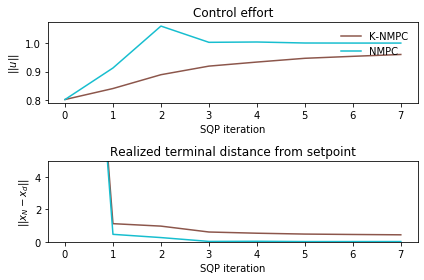

Solution statistics

                        Number of SQP    Mean comp. time per    Std comp. time per    Total comp.
                           iterations       iteration (secs)      iteration (secs)    time (secs)
--------------------  ---------------  ---------------------  --------------------  -------------
Nonlinear MPC                       8               0.162307              0.119478        1.29845
Koopman bilinear MPC               13               2.52972               1.92676        32.8863


In [22]:
plt.figure(figsize=(6,4))
#plt.suptitle('Control solution after each iteration of the SQP-algorithm for NMPC and K-NMPC')
plt.subplot(2,1,1)
plt.plot(np.arange(n_iter), iter_cost_bedmd[:n_iter]/iter_cost_nmpc[-1], color=colors[2], label='K-NMPC')
plt.plot(np.arange(n_iter), iter_cost_nmpc[:n_iter]/iter_cost_nmpc[-1], color=colors[3], label='NMPC')
plt.title('Control effort')
plt.ylabel('$||u||$')
plt.legend(loc='upper right', frameon=False)
plt.xlabel('SQP iteration')

plt.subplot(2,1,2)
plt.plot(np.arange(n_iter), iter_norm_dist_bedmd[:n_iter], color=colors[2], label=labels[2])
plt.plot(np.arange(n_iter), iter_norm_dist_nmpc[:n_iter], color=colors[3], label=labels[3])
plt.ylim(0,5)
plt.title('Realized terminal distance from setpoint')
plt.ylabel('$||x_N - x_d||$')
plt.xlabel('SQP iteration')

if save_figures:
    matplotlib.rcParams['pdf.fonttype'] = 42
    matplotlib.rcParams['ps.fonttype'] = 42
    plt.tight_layout()
    plt.savefig(dropbox_folder + 'planar_quad_sqp_iterations.pdf', format='pdf', dpi=2400)

plt.show()

print('Solution statistics\n')
print(tabulate([['Nonlinear MPC', len(controller_nmpc.x_iter), np.mean(controller_nmpc.comp_time), np.std(controller_nmpc.comp_time), sum(controller_nmpc.comp_time)],
                ['Koopman bilinear MPC', len(controller_bedmd.x_iter), np.mean(controller_bedmd.comp_time), np.std(controller_bedmd.comp_time), sum(controller_bedmd.comp_time)]], 
               headers=['Number of SQP\niterations','Mean comp. time per\niteration (secs)', 'Std comp. time per\niteration (secs)', 'Total comp.\ntime (secs)']))

# Evaluate performance of controllers for closed-loop control

#### Design finite horizon controllers

In [27]:
from koopman_core.controllers import PerturbedController

Q_mpc_cl = 5e2*np.diag([1, 1, 1, 2e-1, 2e-1, 2e-1])
QN_mpc_cl = Q_mpc_cl
R_mpc_cl = np.eye(m)
traj_duration = 1.
N_cl = int(traj_duration/dt)
t_eval_cl=np.arange(300)*dt

# Solver settings closed loop:
polish_osqp = False
max_iter_osqp = 20
linsys_solver_osqp = 'qdldl'
warm_start_osqp = True

controller_dmd_cl = MPCController(sys_dmd, N_cl, dt, umin, umax, xmin, xmax, Q_mpc_cl, R_mpc_cl, QN_mpc_cl, set_pt_cl)
controller_dmd_cl = PerturbedController(sys_dmd,controller_dmd_cl,0.,const_offset=hover_thrust, umin=umin, umax=umax)

controller_edmd_cl = MPCController(sys_edmd, N_cl, dt, umin, umax, xmin, xmax, Q_mpc_cl, R_mpc_cl, QN_mpc_cl, set_pt_cl)
controller_edmd_cl = PerturbedController(sys_edmd,controller_edmd_cl,0.,const_offset=hover_thrust, umin=umin, umax=umax)

controller_bedmd_cl = BilinearMPCController(sys_bedmd, N_cl, dt, umin, umax, xmin, xmax, Q_mpc_cl, R_mpc_cl, QN_mpc_cl, set_pt_cl)
controller_bedmd_cl.construct_controller(controller_bedmd.cur_z[:N_cl+1,:], controller_bedmd.cur_u[:N_cl,:])
controller_bedmd_cl.solve_to_convergence(z0_cl, 0., controller_bedmd.cur_z[:N_cl+1,:], controller_bedmd.cur_u[:N_cl,:], max_iter=max_iter)
controller_bedmd_cl = PerturbedController(sys_bedmd,controller_bedmd_cl,0.,const_offset=hover_thrust, umin=umin, umax=umax)
controller_bedmd_cl.nom_controller.update_solver_settings(polish=polish_osqp, max_iter=max_iter_osqp, linsys_solver=linsys_solver_osqp, warm_start=warm_start_osqp)

controller_nmpc_cl = NonlinearMPCController(quadrotor_d, N_cl, dt, umin+hover_thrust, umax+hover_thrust, xmin, xmax, Q_mpc_cl, R_mpc_cl, QN_mpc_cl, set_pt_cl)
controller_nmpc_cl.construct_controller(controller_nmpc.cur_z[:N_cl+1,:], controller_nmpc.cur_u[:N_cl,:])
controller_nmpc_cl.solve_to_convergence(x0_cl, 0., controller_nmpc.cur_z[:N_cl+1,:], controller_nmpc.cur_u[:N_cl,:], max_iter=max_iter)
controller_nmpc_cl.update_solver_settings(polish=polish_osqp, max_iter=max_iter_osqp, linsys_solver=linsys_solver_osqp, warm_start=warm_start_osqp)

#### Simulate designed trajectories closed-loop

In [28]:
xs_dmd_cl, us_dmd_cl = quadrotor.simulate(x0_cl, controller_dmd_cl, t_eval_cl)
xs_dmd_cl, us_dmd_cl = xs_dmd_cl.T, us_dmd_cl.T

xs_edmd_cl, us_edmd_cl = quadrotor.simulate(x0_cl, controller_edmd_cl, t_eval_cl)
xs_edmd_cl, us_edmd_cl = xs_edmd_cl.T, us_edmd_cl.T

controller_bedmd_cl.comp_time = []
xs_bedmd_cl, us_bedmd_cl = quadrotor.simulate(x0_cl, controller_bedmd_cl, t_eval_cl)
xs_bedmd_cl, us_bedmd_cl = xs_bedmd_cl.T, us_bedmd_cl.T

controller_nmpc_cl.comp_time = []
xs_nmpc_cl, us_nmpc_cl = quadrotor.simulate(x0_cl, controller_nmpc_cl, t_eval_cl)
xs_nmpc_cl, us_nmpc_cl = xs_nmpc_cl.T, us_nmpc_cl.T

[ 1.55562060e-08  8.50469557e-05 -1.62171366e-04  6.22248239e-06
  1.70093909e-02 -3.24342732e-02]
[ 2.51349000e-07  3.49669224e-04 -6.44898404e-04  5.03497097e-05
  3.59150591e-02 -6.41111345e-02]
[ 1.28333457e-06  8.16053792e-04 -1.43931506e-03  1.71875729e-04
  5.73618384e-02 -9.47721967e-02]
[ 4.08679024e-06  1.50855373e-03 -2.53568374e-03  4.11085627e-04
  8.11381058e-02 -1.24501538e-01]
[ 1.00431949e-05  2.44984203e-03 -3.92493511e-03  8.08925328e-04
  1.07119461e-01 -1.53348737e-01]
[ 2.09459106e-05  3.66143321e-03 -5.59846133e-03  1.40681183e-03
  1.35198609e-01 -1.81356505e-01]
[ 3.90040787e-05  5.16381537e-03 -7.54806296e-03  2.24647145e-03
  1.65277550e-01 -2.08563821e-01]
[ 6.68451066e-05  6.97654325e-03 -9.76591129e-03  3.36982080e-03
  1.97267609e-01 -2.35005847e-01]
[ 1.07516264e-04  9.11834435e-03 -1.22445050e-02  4.81890843e-03
  2.31092012e-01 -2.60712889e-01]
[ 1.64485405e-04  1.16072049e-02 -1.49766346e-02  6.63579492e-03
  2.66679274e-01 -2.85713029e-01]
[ 2.416409

[ 0.57367361  0.42870826 -0.01179471  0.99114722  0.15009257  0.25788445]
[ 0.5835903   0.43019598 -0.00922747  0.99215045  0.14745151  0.25556329]
[ 0.59351581  0.4316575  -0.00668375  0.99291005  0.14485268  0.25318029]
[ 0.6034477   0.43309324 -0.00416418  0.99342808  0.14229533  0.2507344 ]
[ 0.61338357  0.43450361 -0.00166938  0.99370668  0.13977868  0.24822484]
[6.23321041e-01 4.35889014e-01 7.99999181e-04 9.93748037e-01
 1.37302010e-01 2.45651069e-01]
[0.63325775 0.43724985 0.00324332 0.99355443 0.13486461 0.24301275]
[0.64319135 0.4385865  0.00565993 0.99312818 0.13246578 0.24030978]
[0.65311954 0.43989935 0.00804919 0.9924717  0.13010486 0.23754223]
[0.66304003 0.44118879 0.01041045 0.99158745 0.12778119 0.23471039]
[0.67295054 0.44245517 0.01274308 0.99047797 0.12549414 0.23181471]
[0.68284884 0.44369885 0.01504643 0.98914585 0.12324308 0.22885581]
[0.69273272 0.44492021 0.01731988 0.98759376 0.12102744 0.22583448]
[0.70259999 0.44611958 0.01956281 0.98582444 0.11884663 0.222

[ 1.464715    0.50477693  0.02962548  0.09906067  0.00863405 -0.07350838]
[ 1.46569121  0.50486251  0.02889454  0.09619391  0.00848351 -0.07268007]
[ 1.46663912  0.5049466   0.02817196  0.09339835  0.00833493 -0.07183584]
[ 1.46755942  0.50502922  0.0274579   0.09067315  0.00818831 -0.07097654]
[ 1.46845281  0.50511038  0.0267525   0.08801748  0.0080436  -0.07010299]
[ 1.46931999  0.5051901   0.02605591  0.08543046  0.0079008  -0.06921601]
[ 1.47016165  0.5052684   0.02536825  0.08291125  0.00775989 -0.06831642]
[ 1.47097844  0.5053453   0.02468964  0.08045895  0.00762084 -0.06740501]
[ 1.47177105  0.50542082  0.0240202   0.07807268  0.00748364 -0.06648257]
[ 1.47254011  0.50549498  0.02336004  0.07575153  0.00734828 -0.06554988]
[ 1.47328629  0.5055678   0.02270925  0.07349459  0.00721474 -0.06460771]
[ 1.47401022  0.50563928  0.02206793  0.07130093  0.007083   -0.0636568 ]
[ 1.47471252  0.50570946  0.02143615  0.06916962  0.00695306 -0.0626979 ]
[ 1.47539381  0.50577835  0.02081401  

[ 0.32044623  0.37016822 -0.08865584  0.89868251  0.25608706  0.36652694]
[ 0.32947388  0.37270442 -0.08498559  0.90679216  0.2511582   0.36752445]
[ 0.33858096  0.37519192 -0.08130794  0.91456671  0.24634612  0.36800428]
[ 0.34776411  0.37763187 -0.07762791  0.9220048   0.2416477   0.36800261]
[ 0.35701995  0.38002539 -0.0739503   0.92910574  0.23706215  0.36751872]
[ 0.36634511  0.38237364 -0.07028062  0.93586944  0.23259058  0.36641815]
[ 0.37573623  0.38467776 -0.06662458  0.94229669  0.22823913  0.36478912]
[ 0.38518994  0.38693898 -0.06298701  0.94838827  0.22400745  0.36272548]
[ 0.39470289  0.38915848 -0.05937185  0.95414543  0.21989605  0.36030662]
[ 0.40427174  0.39133747 -0.05578235  0.95956981  0.21590627  0.35759391]
[ 0.41389319  0.39347719 -0.05222119  0.96466335  0.21204061  0.35463626]
[ 0.42356393  0.3955789  -0.0486907   0.96942831  0.20830346  0.35146276]
[ 0.43328068  0.39764403 -0.04519313  0.97386831  0.20472457  0.34805093]
[ 0.44304023  0.39967423 -0.04173059  

[ 1.31192084  0.49339871  0.07667097  0.4150415   0.01566648 -0.06469727]
[ 1.31603382  0.49355365  0.07601474  0.40756394  0.01532128 -0.06654817]
[ 1.32007234  0.49370517  0.07534033  0.40015121  0.01498378 -0.06833426]
[ 1.32403706  0.49385335  0.07464838  0.39280509  0.01465383 -0.07005525]
[ 1.32792867  0.49399827  0.07393955  0.38552728  0.01433128 -0.07171094]
[ 1.33174784  0.49414001  0.07321449  0.37831944  0.01401596 -0.07330115]
[ 1.33549529  0.49427862  0.07247385  0.37118313  0.01370772 -0.07482578]
[ 1.33917175  0.49441419  0.0717183   0.36411986  0.01340643 -0.07628479]
[ 1.34277794  0.49454677  0.07094848  0.35713109  0.01311193 -0.07767818]
[ 1.34631462  0.49467645  0.07016506  0.3502182   0.01282409 -0.07900602]
[ 1.34978256  0.49480328  0.06936869  0.3433825   0.01254277 -0.0802684 ]
[ 1.35318253  0.49492733  0.06856002  0.33662524  0.01226784 -0.08146551]
[ 1.35651533  0.49504866  0.06773971  0.32994761  0.01199916 -0.08259756]
[ 1.35978175  0.49516733  0.06690839  

[ 0.00187349  0.02097094 -0.05323671  0.04103229  0.31095818 -0.50060376]
[ 0.00231788  0.02420979 -0.05827276  0.04794951  0.33680592 -0.50660541]
[ 0.00283322  0.02768441 -0.06335585  0.05521976  0.35811237 -0.51001167]
[ 0.0034259   0.03139635 -0.06846348  0.06342115  0.38426831 -0.51151449]
[ 0.00410228  0.0353485  -0.07357095  0.0719568   0.40615534 -0.5099808 ]
[ 0.00486852  0.0395385  -0.07865116  0.08139656  0.43183662 -0.50605983]
[ 0.00573008  0.0439575  -0.0836779   0.09101357  0.45195588 -0.49928913]
[ 0.00669148  0.04858593 -0.08863103  0.10136687  0.4737205  -0.49133738]
[ 0.00775664  0.05340155 -0.09349152  0.11175709  0.48939529 -0.48075897]
[ 0.00892957  0.05838545 -0.09823598  0.12292044  0.50737565 -0.46813455]
[ 0.01021386  0.06351888 -0.10283642  0.13402099  0.51930197 -0.45195261]
[ 0.0116126   0.06878043 -0.10726258  0.1458104   0.53299943 -0.43327861]
[ 0.01312909  0.074155   -0.11149021  0.15756336  0.54190758 -0.41224831]
[ 0.01476609  0.07962502 -0.11550591  

[ 0.48583193 -0.0710433  -0.02419279  0.60607221  1.17858849 -0.07964923]
[ 0.49190835 -0.05910576 -0.02489548  0.60922706  1.20891862 -0.06088847]
[ 0.49801482 -0.04694133 -0.02540631  0.61207531  1.22396766 -0.0412767 ]
[ 0.50415132 -0.03457551 -0.02572504  0.61523089  1.24919567 -0.02246923]
[ 0.51031776 -0.02202614 -0.02585347  0.61805934  1.26067839 -0.00321815]
[ 0.51651358 -0.00932068 -0.02579089  0.62110463  1.28041323  0.01573552]
[ 0.52273811  0.00351697 -0.025536    0.62379658  1.28711839  0.03524299]
[ 0.52899029  0.01645718 -0.02508573  0.62663142  1.3009233   0.05480912]
[ 0.53526905  0.02947572 -0.02443902  0.62910888  1.30278562  0.07453338]
[ 0.54157316  0.04255156 -0.02359691  0.63169776  1.31238171  0.09388921]
[ 0.54790138  0.05566824 -0.0225647   0.63393094  1.3109546   0.11255169]
[ 0.55425233  0.06881184 -0.02134993  0.63623645  1.31776624  0.1304023 ]
[ 0.56062449  0.08196766 -0.01996231  0.63817419  1.31339868  0.14712309]
[ 0.56701604  0.09511521 -0.01841094  

[ 1.10939608  0.47250135 -0.00259325  0.47031214 -0.03276921  0.05509943]
[ 1.11410041  0.47218803 -0.00201597  0.47054529 -0.02989513  0.06035712]
[ 1.11880684  0.47193759 -0.00138887  0.47072924 -0.02019272  0.06506249]
[ 1.12351473e+00  4.71755326e-01 -7.15464033e-04  4.70836982e-01
 -1.62603019e-02  6.96182912e-02]
[ 1.12822336e+00  4.71639934e-01  8.59752520e-07  4.70875768e-01
 -6.81808522e-03  7.36464658e-02]
[ 1.13293199e+00  4.71589696e-01  7.56793566e-04  4.70837576e-01
 -3.22967748e-03  7.75402969e-02]
[1.13763983 0.47159903 0.00154908 0.47071517 0.00509732 0.08091767]
[1.14234605 0.47166829 0.00237436 0.47051583 0.00875337 0.0841383 ]
[1.14704979 0.47179824 0.0032294  0.47021743 0.01723753 0.08686937]
[1.15175015 0.47199525 0.00411098 0.46983953 0.02216373 0.08944654]
[1.1564462  0.4722596  0.00501598 0.46935305 0.03070559 0.09155327]
[1.16113699 0.47258942 0.00594122 0.46879081 0.03526    0.09349452]
[1.16582162 0.47297599 0.00688374 0.46811831 0.04205363 0.09501042]
[1.17

[ 0.0959963   0.23715414 -0.15489813  0.49095339  0.44924253  0.10492885]
[ 0.10096467  0.24153379 -0.15374646  0.50270673  0.42668949  0.12540612]
[ 0.10605072  0.2456919  -0.15239189  0.51448613  0.40493375  0.1455076 ]
[ 0.11125506  0.24963931 -0.15083834  0.52636183  0.38455205  0.16520151]
[ 0.1165789   0.25339201 -0.14909007  0.53838153  0.36599211  0.18445325]
[ 0.12202422  0.2569727  -0.1471516   0.55065685  0.35015008  0.20324132]
[ 0.12759368  0.26041001 -0.14502532  0.56320382  0.33731504  0.22201512]
[ 0.13329068  0.26373982 -0.14271222  0.57616204  0.32865269  0.24060424]
[ 0.13911997  0.26700954 -0.14021457  0.58965641  0.32529642  0.25892539]
[ 0.14508765  0.27027908 -0.13753589  0.6038342   0.32861836  0.27681005]
[ 0.15120147  0.27362391 -0.13467962  0.61887851  0.34035534  0.29444382]
[ 0.15747203  0.27714503 -0.13164746  0.63517218  0.36387602  0.31198901]
[ 0.16391256  0.28096942 -0.12843938  0.65286065  0.40101271  0.32962726]
[ 0.17053792  0.28524481 -0.12505643  

[ 1.1831405   1.54277566  0.10236039  0.77714573 -0.24539079 -0.26433527]
[ 1.19083534  1.54058373  0.09968813  0.76188865 -0.19298817 -0.27011806]
[ 1.19837666  1.53894601  0.09698397  0.74644539 -0.13454979 -0.27071375]
[ 1.20576584  1.53789096  0.09428506  0.73146205 -0.07645249 -0.2690678 ]
[ 1.21302069  1.53727408  0.09161476  0.71956474 -0.04691962 -0.2649924 ]
[ 1.22018247  1.5366866   0.08900097  0.7128238  -0.07057368 -0.25776496]
[ 1.22731096  1.53548757  0.08642307  0.71287288 -0.16923183 -0.25781517]
[ 1.23444005  1.53330055  0.08384494  0.71294465 -0.26817274 -0.25781146]
[ 1.24156983  1.53012425  0.08126685  0.71301205 -0.36708732 -0.25780537]
[ 1.2487002   1.52595981  0.07868883  0.71306109 -0.46579922 -0.2577994 ]
[ 1.25583101  1.52080873  0.07611086  0.71310124 -0.56441693 -0.25779429]
[ 1.26296225  1.51467107  0.07353293  0.71314617 -0.66311627 -0.25779138]
[ 1.27009389  1.50754697  0.07095508  0.71318145 -0.76170384 -0.25777936]
[ 1.27722576  1.49943859  0.06837732  

TypeError: unsupported operand type(s) for +: 'float' and 'NoneType'

#### Plot/analyze the results

In [ ]:
plot_inds = [0, 1, 2, 0, 1]
subplot_inds = [1, 2, 3, 4, 8]

plt.figure(figsize=(12,3))
for ii in range(5):
    ind = plot_inds[ii]
    if ii < 3:
        ax = plt.subplot(1,4,subplot_inds[ii])
        plt.plot(t_eval_cl, xs_dmd_cl[ind,:], colors[0], label='DMD MPC')
        plt.plot(t_eval_cl, xs_edmd_cl[ind, :], colors[1], label='EDMD MPC')
        plt.plot(t_eval_cl, xs_bedmd_cl[ind, :], colors[2], label='K-NMPC')
        plt.plot(t_eval_cl, xs_nmpc_cl[ind,:], colors[3], label='NMPC')

        plt.scatter(t_eval_cl[0], x0_cl[ind], color='g')
        plt.scatter(t_eval_cl[-1], set_pt_cl[ind], color='r')
        plt.ylabel(labels[ind])
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        plt.title(titles[subplot_inds[ii]-1])
        plt.xlabel('Time (sec)')
        if subplot_inds[ii]==1:
            plt.legend(loc='upper left', frameon=False)
    else:
        bx = plt.subplot(2,4,subplot_inds[ii])
        plt.plot(t_eval_cl[:-1],us_dmd_cl[ind,:], color=colors[0], label='DMD MPC')
        plt.plot(t_eval_cl[:-1], us_edmd_cl[ind, :], color=colors[1], label='EDMD MPC')
        plt.plot(t_eval_cl[:-1], us_bedmd_cl[ind, :], color=colors[2], label='K-NMPC')
        plt.plot(t_eval_cl[:-1],us_nmpc_cl[ind,:], color=colors[3], label='NMPC')
        plt.plot([0, t_eval_cl[-1]], [umax[ind]+hover_thrust, umax[ind]+hover_thrust], ':k')
        plt.plot([0, t_eval_cl[-1]], [umin[ind]+hover_thrust, umin[ind]+hover_thrust], ':k')
        plt.ylabel(labels[ii+3])
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        if subplot_inds[ii] == 4:
            plt.title('Control inputs')
        else:
            plt.xlabel('Time (sec)')
if save_figures:
    matplotlib.rcParams['pdf.fonttype'] = 42
    matplotlib.rcParams['ps.fonttype'] = 42
    plt.tight_layout()
    plt.savefig(dropbox_folder + 'planar_quad_closed_loop.pdf', format='pdf', dpi=2400)
plt.show()
    
from matplotlib._png import read_png
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from scipy import ndimage

draw_inds = np.arange(0,t_eval_cl.size)[::50]

plt.figure(figsize=(12,2))
ax = plt.subplot(1,1,1, frameon=False)
plt.plot(xs_bedmd_cl[0,:], xs_bedmd_cl[1,:], color=colors[2], label='Koopman NMPC closed loop trajectory with quadrotor orientation sampled at 2 hz')
plt.xlabel('y (m)')
plt.ylabel('z (m)')
plt.ylim(-0.1, xs_bedmd[1,-1]+0.3)
plt.legend(loc='upper left', frameon=False)
for ii in draw_inds:
    im_quad = read_png('quad_figure.png')
    im_quad = ndimage.rotate(im_quad, xs_bedmd_cl[2,ii]*180)
    imagebox_quad = OffsetImage(im_quad, zoom=.11)
    ab = AnnotationBbox(imagebox_quad, [xs_bedmd_cl[0,ii], xs_bedmd_cl[1,ii]], frameon=False)
    ax.add_artist(ab)

if save_figures:
    matplotlib.rcParams['pdf.fonttype'] = 42
    matplotlib.rcParams['ps.fonttype'] = 42
    plt.tight_layout()
    plt.savefig(dropbox_folder + 'planar_quad_closed_loop_2.pdf', format='pdf', dpi=2400)
plt.show()

cost_cl_dmd = np.sum(np.diag((xs_dmd_cl[:,:-1]-set_pt_cl.reshape(-1,1)).T@Q_mpc_cl@(xs_dmd_cl[:,:-1]-set_pt_cl.reshape(-1,1)))) + (xs_dmd_cl[:,-1]-set_pt_cl).T@QN_mpc_cl@(xs_dmd_cl[:,-1]-set_pt_cl) + np.sum(np.diag(us_dmd_cl.T@R_mpc_cl@us_dmd_cl))
cost_cl_edmd = np.sum(np.diag((xs_edmd_cl[:,:-1]-set_pt_cl.reshape(-1,1)).T@Q_mpc_cl@(xs_edmd_cl[:,:-1]-set_pt_cl.reshape(-1,1)))) + (xs_edmd_cl[:,-1]-set_pt_cl).T@QN_mpc_cl@(xs_edmd_cl[:,-1]-set_pt_cl) + np.sum(np.diag(us_edmd_cl.T@R_mpc_cl@us_edmd_cl))
cost_cl_bedmd = np.sum(np.diag((xs_bedmd_cl[:,:-1]-set_pt_cl.reshape(-1,1)).T@Q_mpc_cl@(xs_bedmd_cl[:,:-1]-set_pt_cl.reshape(-1,1)))) + (xs_bedmd_cl[:,-1]-set_pt_cl).T@QN_mpc_cl@(xs_bedmd_cl[:,-1]-set_pt_cl) + np.sum(np.diag(us_bedmd_cl.T@R_mpc_cl@us_bedmd_cl))
cost_cl_nmpc = np.sum(np.diag((xs_nmpc_cl[:,:-1]-set_pt_cl.reshape(-1,1)).T@Q_mpc_cl@(xs_nmpc_cl[:,:-1]-set_pt_cl.reshape(-1,1)))) + (xs_nmpc_cl[:,-1]-set_pt_cl).T@QN_mpc_cl@(xs_nmpc_cl[:,-1]-set_pt_cl) + np.sum(np.diag(us_nmpc_cl.T@R_mpc_cl@us_nmpc_cl))

print('Solution statistics:\n')
print(tabulate([['DMD MPC', "{:.4f}".format(cost_cl_dmd/cost_cl_nmpc), np.mean(controller_dmd_cl.nom_controller.comp_time), np.std(controller_dmd_cl.nom_controller.comp_time)], 
                ['EDMD MPC', "{:.4f}".format(cost_cl_edmd/cost_cl_nmpc),np.mean(controller_edmd_cl.nom_controller.comp_time), np.std(controller_edmd_cl.nom_controller.comp_time)], 
                ['bEDMD MPC', "{:.4f}".format(cost_cl_bedmd/cost_cl_nmpc), np.mean(controller_bedmd_cl.nom_controller.comp_time), np.std(controller_bedmd_cl.nom_controller.comp_time)],
                ['NMPC (benchmark, known model)',1, np.mean(controller_nmpc_cl.comp_time), np.std(controller_nmpc_cl.comp_time)]], 
               headers=['Normalized cost,\nrealized trajectory', 'Mean comp. time (secs)', 'std comp. time (secs)']))